# TESS Atlas fit for TOI 521

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 521.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-521.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-521.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-521.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 521

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 521 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

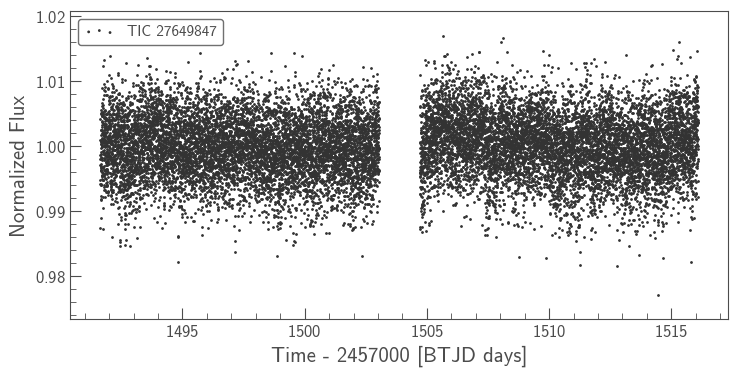

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -55037.45504409774 -> -54987.131626560375


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -49103.97159430519 -> -48625.534281063425


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -48625.534281063425 -> -48618.551542200774


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -48618.551542200774 -> -48618.54507021048


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -48618.54507021048 -> -48618.53529733138


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -48618.53529733138 -> -48618.53091588675


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -48618.53091588675 -> -48574.35062344831


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -48574.35062344831 -> -48574.06187117885


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -48574.06187117885 -> -48571.122566806676


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -48571.122566806676 -> -48570.063316906824


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -48570.063316906824 -> -48567.35497736961


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -48567.35497736961 -> -48567.33702509603


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -48567.33702509603 -> -48562.93186841283


*** Sigma clipping round 3 ***


optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -48562.93186841283 -> -48562.93186841283


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -48562.93186841283 -> -48562.93186841283


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -48562.93186841283 -> -48562.93186841278


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -48562.93186841278 -> -48562.93186841278


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -48562.93186841278 -> -48562.93186841278


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -48562.93186841278 -> -48562.93186841278


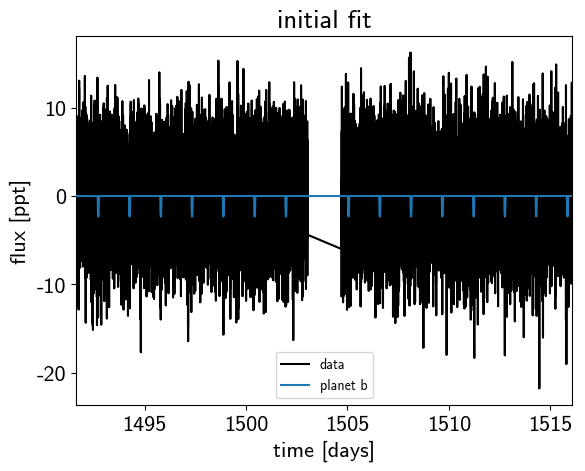

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:08, 11.48draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:14,  6.26draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:02<00:18,  4.84draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:21,  4.18draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:23,  3.77draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:23,  3.56draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:04<00:25,  3.27draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:05<00:25,  3.18draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:05<00:20,  3.88draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:06<00:26,  3.00draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:06<00:27,  2.79draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:06<00:24,  3.13draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:07<00:26,  2.82draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:07<00:23,  3.19draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:07<00:26,  2.84draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:08<00:23,  3.15draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:08<00:25,  2.78draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:08<00:22,  3.19draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:09<00:24,  2.81draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:09<00:20,  3.41draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:09<00:24,  2.79draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:09<00:19,  3.45draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:10<00:24,  2.69draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:11<00:23,  2.75draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:11<00:21,  2.85draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:12<00:20,  2.86draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:13<00:20,  2.88draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:13<00:15,  3.63draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:13<00:20,  2.78draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:14<00:17,  3.19draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:14<00:18,  2.85draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:14<00:17,  2.98draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:15<00:17,  2.90draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:15<00:18,  2.81draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:15<00:16,  3.05draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:16<00:17,  2.75draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:16<00:16,  2.97draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:16<00:16,  2.88draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:17<00:16,  2.84draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:17<00:16,  2.75draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:17<00:14,  3.00draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:18<00:13,  3.23draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:18<00:14,  2.95draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:18<00:13,  3.09draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:19<00:13,  3.01draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:19<00:13,  2.97draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:19<00:12,  3.07draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:20<00:12,  3.01draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:20<00:12,  3.00draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:20<00:12,  2.90draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:21<00:11,  2.98draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:21<00:11,  2.83draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:21<00:10,  3.18draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:22<00:10,  2.86draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:22<00:09,  3.31draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:22<00:10,  2.80draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:23<00:08,  3.42draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:23<00:09,  2.79draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:23<00:07,  3.31draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:24<00:09,  2.69draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:24<00:07,  3.27draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:24<00:08,  2.72draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:25<00:08,  2.61draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:25<00:07,  2.88draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:26<00:08,  2.35draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:26<00:06,  2.83draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:26<00:07,  2.52draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:27<00:07,  2.41draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:27<00:05,  2.75draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:28<00:05,  2.53draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:28<00:04,  2.91draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:28<00:04,  2.71draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:29<00:04,  2.74draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:29<00:03,  2.89draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:30<00:04,  2.32draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:30<00:03,  2.53draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:30<00:02,  2.97draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:31<00:02,  2.74draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:31<00:01,  3.17draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:32<00:01,  2.71draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:32<00:00,  3.07draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:32<00:00,  2.32draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:34<00:00,  1.19draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:35<00:00,  1.26draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:05, 17.83draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:13,  7.12draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:17,  5.08draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:20,  4.48draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:24,  3.67draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:24,  3.65draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:26,  3.28draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:28,  3.02draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:25,  3.34draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:04<00:30,  2.77draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:04<00:23,  3.51draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:04<00:26,  3.04draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:05<00:23,  3.47draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:05<00:26,  3.00draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:05<00:26,  3.03draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:06<00:25,  3.02draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:06<00:26,  2.93draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:06<00:24,  3.05draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:07<00:28,  2.63draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:07<00:22,  3.33draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:07<00:18,  3.89draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:08<00:23,  3.03draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:08<00:22,  3.14draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:08<00:23,  2.99draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:08<00:21,  3.21draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:09<00:22,  3.07draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:09<00:21,  3.10draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:09<00:21,  3.08draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:10<00:21,  3.04draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:10<00:21,  2.97draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:11<00:22,  2.80draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:11<00:25,  2.45draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:11<00:21,  2.83draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:12<00:27,  2.18draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:13<00:25,  2.32draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:13<00:20,  2.73draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:14<00:23,  2.41draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:14<00:18,  2.90draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:14<00:21,  2.51draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:14<00:18,  2.93draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:15<00:20,  2.57draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:15<00:16,  3.08draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:15<00:14,  3.57draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:16<00:17,  2.84draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:16<00:14,  3.42draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:16<00:17,  2.74draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:17<00:13,  3.32draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:17<00:16,  2.74draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:17<00:13,  3.35draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:18<00:15,  2.75draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:18<00:13,  3.21draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:18<00:14,  2.77draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:19<00:12,  3.14draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:19<00:10,  3.58draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:19<00:12,  3.01draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:20<00:11,  3.27draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:20<00:11,  3.00draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:20<00:11,  3.13draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:21<00:11,  2.93draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:21<00:10,  3.22draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:21<00:11,  2.89draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:22<00:09,  3.25draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:22<00:10,  2.86draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:22<00:10,  2.80draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:23<00:09,  2.81draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:23<00:10,  2.52draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:23<00:08,  3.13draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:24<00:10,  2.34draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:24<00:08,  2.89draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:25<00:09,  2.49draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:25<00:08,  2.45draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:25<00:07,  2.78draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:26<00:08,  2.40draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:27<00:07,  2.54draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:27<00:05,  3.10draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:27<00:05,  2.68draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:27<00:04,  3.18draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:28<00:05,  2.77draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:28<00:04,  3.08draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:29<00:04,  2.93draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:29<00:03,  3.03draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:29<00:03,  2.94draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:29<00:02,  3.03draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:30<00:02,  2.92draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:30<00:02,  3.01draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:31<00:02,  2.87draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:31<00:01,  3.10draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:31<00:01,  2.51draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:32<00:00,  2.42draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:35<00:00,  1.01draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:35<00:00,  1.29draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<02:20,  1.44draws/s]

Sampling 2 chains:   2%|▏         | 4/204 [00:00<01:39,  2.01draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:01<01:51,  1.79draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:01<01:30,  2.18draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:02<01:33,  2.11draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:02<01:30,  2.17draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:02<01:20,  2.41draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:03<01:26,  2.25draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:03<01:09,  2.76draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:04<01:16,  2.51draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:04<01:09,  2.73draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:04<01:09,  2.73draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:05<01:10,  2.67draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:05<01:04,  2.93draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:05<01:10,  2.66draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:06<01:09,  2.69draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:06<01:05,  2.84draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:07<01:17,  2.37draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:07<01:00,  3.02draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:07<01:17,  2.35draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:08<01:00,  3.01draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:08<00:54,  3.31draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:08<01:09,  2.57draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:09<01:01,  2.90draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:09<00:57,  3.08draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:09<00:57,  3.07draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:10<01:01,  2.84draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:10<00:53,  3.25draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:11<01:04,  2.66draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:11<00:51,  3.32draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:11<01:07,  2.51draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:12<01:01,  2.74draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:12<00:49,  3.38draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:13<01:01,  2.71draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:13<00:54,  3.05draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:13<01:02,  2.64draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:14<00:50,  3.24draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:14<01:02,  2.61draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:14<00:50,  3.22draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:15<01:00,  2.63draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:15<00:47,  3.32draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:15<01:01,  2.59draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:16<00:53,  2.94draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:16<00:59,  2.62draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:16<00:48,  3.21draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:17<01:03,  2.43draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:17<00:53,  2.86draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:18<01:02,  2.42draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:18<01:05,  2.29draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:18<00:56,  2.66draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:19<01:07,  2.20draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:20<01:03,  2.32draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:21<00:53,  2.68draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:21<00:50,  2.81draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:22<00:51,  2.76draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:22<00:48,  2.91draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:23<01:00,  2.31draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:23<00:50,  2.73draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:23<00:49,  2.77draws/s]

Sampling 2 chains:  34%|███▍      | 69/204 [00:24<00:47,  2.85draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:24<00:45,  2.92draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:24<00:49,  2.68draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:25<00:42,  3.10draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:25<00:48,  2.68draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:25<00:40,  3.23draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:26<00:46,  2.76draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:26<00:38,  3.29draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:26<00:47,  2.66draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:27<00:43,  2.90draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:28<00:42,  2.92draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:28<00:35,  3.46draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:28<00:41,  2.90draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:29<00:38,  3.09draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:29<00:42,  2.79draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:29<00:39,  3.01draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:30<00:40,  2.92draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:30<00:40,  2.90draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:30<00:37,  3.10draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:31<00:39,  2.85draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:31<00:35,  3.17draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:31<00:44,  2.53draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:32<00:41,  2.66draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:33<00:39,  2.74draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:33<00:37,  2.81draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:34<00:35,  2.92draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:35<00:34,  2.95draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:35<00:29,  3.41draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:35<00:33,  2.95draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:36<00:31,  3.17draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:36<00:35,  2.74draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:36<00:32,  3.02draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:37<00:41,  2.31draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:38<00:40,  2.34draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:38<00:31,  2.98draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:39<00:39,  2.34draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:39<00:35,  2.59draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:39<00:36,  2.47draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:40<00:34,  2.58draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:40<00:34,  2.57draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:40<00:31,  2.74draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:41<00:30,  2.77draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:41<00:27,  3.04draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:41<00:29,  2.83draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:42<00:25,  3.22draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:42<00:30,  2.67draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:42<00:24,  3.32draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:43<00:31,  2.52draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:43<00:23,  3.26draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:44<00:28,  2.74draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:44<00:25,  2.93draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:44<00:28,  2.63draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:45<00:24,  2.96draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:45<00:29,  2.48draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:46<00:27,  2.64draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:46<00:27,  2.58draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:47<00:26,  2.58draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:47<00:24,  2.83draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:47<00:25,  2.63draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:48<00:26,  2.49draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:48<00:23,  2.81draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:49<00:25,  2.53draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:49<00:22,  2.71draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:50<00:21,  2.77draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:51<00:19,  2.91draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:51<00:16,  3.52draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:51<00:16,  3.31draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:52<00:16,  3.31draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [00:53<00:15,  3.34draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:53<00:14,  3.37draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [00:54<00:13,  3.40draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [00:54<00:13,  3.37draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [00:54<00:10,  4.13draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [00:55<00:13,  3.09draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [00:55<00:11,  3.57draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [00:56<00:13,  3.06draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [00:56<00:12,  3.29draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [00:56<00:10,  3.72draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [00:56<00:11,  3.40draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [00:57<00:10,  3.50draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [00:57<00:11,  3.08draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [00:57<00:10,  3.31draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [00:58<00:11,  3.01draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:58<00:09,  3.33draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [00:58<00:11,  2.88draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [00:59<00:09,  3.37draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [00:59<00:10,  2.97draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [00:59<00:08,  3.51draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [01:00<00:09,  3.01draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [01:00<00:07,  3.59draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [01:00<00:08,  3.04draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [01:00<00:06,  3.63draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [01:01<00:08,  2.95draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [01:01<00:06,  3.49draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [01:01<00:07,  2.84draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [01:02<00:06,  3.47draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [01:02<00:07,  2.85draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [01:02<00:05,  3.40draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [01:03<00:06,  2.67draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [01:04<00:05,  2.72draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [01:04<00:04,  3.45draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [01:04<00:05,  2.68draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [01:05<00:04,  2.75draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [01:06<00:03,  2.84draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [01:06<00:02,  2.93draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [01:07<00:02,  2.98draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [01:08<00:01,  2.97draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [01:08<00:00,  2.90draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [01:10<00:00,  1.25draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [01:11<00:00,  1.09draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|▏         | 6/404 [00:00<00:13, 29.32draws/s]

Sampling 2 chains:   2%|▏         | 8/404 [00:00<00:17, 22.40draws/s]

Sampling 2 chains:   2%|▏         | 10/404 [00:00<00:43,  9.10draws/s]

Sampling 2 chains:   3%|▎         | 11/404 [00:01<00:53,  7.28draws/s]

Sampling 2 chains:   3%|▎         | 12/404 [00:01<01:08,  5.74draws/s]

Sampling 2 chains:   3%|▎         | 13/404 [00:01<01:22,  4.75draws/s]

Sampling 2 chains:   3%|▎         | 14/404 [00:02<01:44,  3.72draws/s]

Sampling 2 chains:   4%|▎         | 15/404 [00:02<01:27,  4.45draws/s]

Sampling 2 chains:   4%|▍         | 16/404 [00:02<02:01,  3.19draws/s]

Sampling 2 chains:   4%|▍         | 17/404 [00:02<01:59,  3.24draws/s]

Sampling 2 chains:   4%|▍         | 18/404 [00:03<01:53,  3.41draws/s]

Sampling 2 chains:   5%|▍         | 19/404 [00:03<02:30,  2.56draws/s]

Sampling 2 chains:   5%|▍         | 20/404 [00:03<01:58,  3.25draws/s]

Sampling 2 chains:   5%|▌         | 21/404 [00:04<02:11,  2.91draws/s]

Sampling 2 chains:   5%|▌         | 22/404 [00:04<02:16,  2.80draws/s]

Sampling 2 chains:   6%|▌         | 23/404 [00:04<01:58,  3.22draws/s]

Sampling 2 chains:   6%|▌         | 24/404 [00:05<01:43,  3.67draws/s]

Sampling 2 chains:   6%|▌         | 25/404 [00:05<01:36,  3.93draws/s]

Sampling 2 chains:   6%|▋         | 26/404 [00:05<01:20,  4.71draws/s]

Sampling 2 chains:   7%|▋         | 28/404 [00:05<01:11,  5.28draws/s]

Sampling 2 chains:   7%|▋         | 29/404 [00:05<01:01,  6.10draws/s]

Sampling 2 chains:   7%|▋         | 30/404 [00:06<00:59,  6.27draws/s]

Sampling 2 chains:   8%|▊         | 31/404 [00:06<01:23,  4.47draws/s]

Sampling 2 chains:   8%|▊         | 32/404 [00:06<01:25,  4.33draws/s]

Sampling 2 chains:   8%|▊         | 33/404 [00:07<01:44,  3.53draws/s]

Sampling 2 chains:   8%|▊         | 34/404 [00:07<01:59,  3.11draws/s]

Sampling 2 chains:   9%|▊         | 35/404 [00:07<01:36,  3.81draws/s]

Sampling 2 chains:   9%|▉         | 36/404 [00:08<02:07,  2.88draws/s]

Sampling 2 chains:   9%|▉         | 37/404 [00:08<01:40,  3.65draws/s]

Sampling 2 chains:   9%|▉         | 38/404 [00:08<02:11,  2.79draws/s]

Sampling 2 chains:  10%|▉         | 39/404 [00:09<01:58,  3.09draws/s]

Sampling 2 chains:  10%|▉         | 40/404 [00:09<01:56,  3.12draws/s]

Sampling 2 chains:  10%|█         | 41/404 [00:09<02:08,  2.83draws/s]

Sampling 2 chains:  10%|█         | 42/404 [00:09<01:43,  3.50draws/s]

Sampling 2 chains:  11%|█         | 43/404 [00:10<01:40,  3.60draws/s]

Sampling 2 chains:  11%|█         | 44/404 [00:10<01:38,  3.64draws/s]

Sampling 2 chains:  11%|█▏        | 46/404 [00:10<01:29,  3.98draws/s]

Sampling 2 chains:  12%|█▏        | 47/404 [00:10<01:19,  4.48draws/s]

Sampling 2 chains:  12%|█▏        | 49/404 [00:11<01:22,  4.29draws/s]

Sampling 2 chains:  12%|█▏        | 50/404 [00:11<01:17,  4.57draws/s]

Sampling 2 chains:  13%|█▎        | 51/404 [00:11<01:12,  4.89draws/s]

Sampling 2 chains:  13%|█▎        | 52/404 [00:12<01:10,  5.02draws/s]

Sampling 2 chains:  13%|█▎        | 54/404 [00:12<00:59,  5.89draws/s]

Sampling 2 chains:  14%|█▎        | 55/404 [00:12<01:23,  4.16draws/s]

Sampling 2 chains:  14%|█▍        | 56/404 [00:12<01:09,  5.01draws/s]

Sampling 2 chains:  14%|█▍        | 57/404 [00:12<01:05,  5.28draws/s]

Sampling 2 chains:  14%|█▍        | 58/404 [00:13<01:36,  3.57draws/s]

Sampling 2 chains:  15%|█▍        | 60/404 [00:13<01:35,  3.59draws/s]

Sampling 2 chains:  15%|█▌        | 62/404 [00:14<01:14,  4.58draws/s]

Sampling 2 chains:  16%|█▌        | 63/404 [00:14<01:06,  5.15draws/s]

Sampling 2 chains:  16%|█▌        | 64/404 [00:14<01:04,  5.28draws/s]

Sampling 2 chains:  16%|█▌        | 65/404 [00:14<00:58,  5.82draws/s]

Sampling 2 chains:  16%|█▋        | 66/404 [00:14<01:01,  5.53draws/s]

Sampling 2 chains:  17%|█▋        | 68/404 [00:15<01:04,  5.25draws/s]

Sampling 2 chains:  17%|█▋        | 70/404 [00:15<00:50,  6.59draws/s]

Sampling 2 chains:  18%|█▊        | 72/404 [00:15<00:44,  7.49draws/s]

Sampling 2 chains:  18%|█▊        | 74/404 [00:15<00:43,  7.59draws/s]

Sampling 2 chains:  19%|█▊        | 75/404 [00:15<00:47,  6.95draws/s]

Sampling 2 chains:  19%|█▉        | 77/404 [00:16<00:41,  7.87draws/s]

Sampling 2 chains:  19%|█▉        | 78/404 [00:16<00:39,  8.30draws/s]

Sampling 2 chains:  20%|█▉        | 79/404 [00:16<00:47,  6.84draws/s]

Sampling 2 chains:  20%|██        | 81/404 [00:16<00:38,  8.36draws/s]

Sampling 2 chains:  21%|██        | 83/404 [00:16<00:37,  8.50draws/s]

Sampling 2 chains:  21%|██        | 85/404 [00:17<00:48,  6.51draws/s]

Sampling 2 chains:  21%|██▏       | 86/404 [00:17<00:47,  6.67draws/s]

Sampling 2 chains:  22%|██▏       | 87/404 [00:17<00:55,  5.73draws/s]

Sampling 2 chains:  22%|██▏       | 88/404 [00:17<00:49,  6.34draws/s]

Sampling 2 chains:  23%|██▎       | 91/404 [00:17<00:38,  8.15draws/s]

Sampling 2 chains:  23%|██▎       | 94/404 [00:18<00:34,  8.99draws/s]

Sampling 2 chains:  24%|██▍       | 96/404 [00:18<00:34,  9.02draws/s]

Sampling 2 chains:  24%|██▍       | 98/404 [00:18<00:48,  6.25draws/s]

Sampling 2 chains:  25%|██▍       | 99/404 [00:19<01:02,  4.90draws/s]

Sampling 2 chains:  25%|██▍       | 100/404 [00:19<00:57,  5.30draws/s]

Sampling 2 chains:  25%|██▌       | 102/404 [00:19<00:47,  6.40draws/s]

Sampling 2 chains:  26%|██▌       | 104/404 [00:19<00:52,  5.75draws/s]

Sampling 2 chains:  26%|██▌       | 105/404 [00:20<01:00,  4.96draws/s]

Sampling 2 chains:  26%|██▌       | 106/404 [00:20<01:14,  4.00draws/s]

Sampling 2 chains:  26%|██▋       | 107/404 [00:20<01:14,  3.99draws/s]

Sampling 2 chains:  27%|██▋       | 108/404 [00:21<01:19,  3.72draws/s]

Sampling 2 chains:  27%|██▋       | 109/404 [00:21<01:22,  3.59draws/s]

Sampling 2 chains:  27%|██▋       | 110/404 [00:21<01:20,  3.67draws/s]

Sampling 2 chains:  27%|██▋       | 111/404 [00:22<01:27,  3.36draws/s]

Sampling 2 chains:  28%|██▊       | 112/404 [00:22<01:16,  3.80draws/s]

Sampling 2 chains:  28%|██▊       | 113/404 [00:22<01:04,  4.50draws/s]

Sampling 2 chains:  28%|██▊       | 114/404 [00:22<01:19,  3.64draws/s]

Sampling 2 chains:  28%|██▊       | 115/404 [00:22<01:18,  3.67draws/s]

Sampling 2 chains:  29%|██▊       | 116/404 [00:23<01:16,  3.75draws/s]

Sampling 2 chains:  29%|██▉       | 118/404 [00:23<01:15,  3.77draws/s]

Sampling 2 chains:  29%|██▉       | 119/404 [00:23<01:05,  4.38draws/s]

Sampling 2 chains:  30%|██▉       | 120/404 [00:24<01:11,  3.97draws/s]

Sampling 2 chains:  30%|███       | 122/404 [00:24<01:15,  3.72draws/s]

Sampling 2 chains:  31%|███       | 124/404 [00:25<01:00,  4.63draws/s]

Sampling 2 chains:  31%|███       | 125/404 [00:25<01:02,  4.45draws/s]

Sampling 2 chains:  31%|███       | 126/404 [00:25<01:05,  4.21draws/s]

Sampling 2 chains:  32%|███▏      | 128/404 [00:26<01:10,  3.93draws/s]

Sampling 2 chains:  32%|███▏      | 129/404 [00:26<01:08,  4.00draws/s]

Sampling 2 chains:  32%|███▏      | 130/404 [00:26<01:21,  3.36draws/s]

Sampling 2 chains:  32%|███▏      | 131/404 [00:27<01:30,  3.03draws/s]

Sampling 2 chains:  33%|███▎      | 132/404 [00:27<01:12,  3.73draws/s]

Sampling 2 chains:  33%|███▎      | 133/404 [00:27<01:36,  2.80draws/s]

Sampling 2 chains:  33%|███▎      | 134/404 [00:28<01:24,  3.19draws/s]

Sampling 2 chains:  33%|███▎      | 135/404 [00:28<01:36,  2.78draws/s]

Sampling 2 chains:  34%|███▎      | 136/404 [00:28<01:31,  2.93draws/s]

Sampling 2 chains:  34%|███▍      | 137/404 [00:29<01:32,  2.88draws/s]

Sampling 2 chains:  34%|███▍      | 138/404 [00:29<01:27,  3.06draws/s]

Sampling 2 chains:  34%|███▍      | 139/404 [00:29<01:26,  3.08draws/s]

Sampling 2 chains:  35%|███▍      | 140/404 [00:30<01:24,  3.12draws/s]

Sampling 2 chains:  35%|███▍      | 141/404 [00:30<01:20,  3.26draws/s]

Sampling 2 chains:  35%|███▌      | 142/404 [00:30<01:23,  3.15draws/s]

Sampling 2 chains:  35%|███▌      | 143/404 [00:30<01:10,  3.72draws/s]

Sampling 2 chains:  36%|███▌      | 144/404 [00:31<01:25,  3.06draws/s]

Sampling 2 chains:  36%|███▌      | 146/404 [00:31<01:20,  3.22draws/s]

Sampling 2 chains:  37%|███▋      | 148/404 [00:32<01:18,  3.24draws/s]

Sampling 2 chains:  37%|███▋      | 149/404 [00:32<01:04,  3.94draws/s]

Sampling 2 chains:  37%|███▋      | 150/404 [00:33<01:15,  3.35draws/s]

Sampling 2 chains:  37%|███▋      | 151/404 [00:33<01:09,  3.64draws/s]

Sampling 2 chains:  38%|███▊      | 152/404 [00:33<01:12,  3.50draws/s]

Sampling 2 chains:  38%|███▊      | 154/404 [00:33<00:59,  4.23draws/s]

Sampling 2 chains:  38%|███▊      | 155/404 [00:34<01:05,  3.80draws/s]

Sampling 2 chains:  39%|███▊      | 156/404 [00:34<01:08,  3.60draws/s]

Sampling 2 chains:  39%|███▉      | 157/404 [00:34<01:03,  3.91draws/s]

Sampling 2 chains:  39%|███▉      | 158/404 [00:35<01:22,  2.98draws/s]

Sampling 2 chains:  39%|███▉      | 159/404 [00:35<01:16,  3.19draws/s]

Sampling 2 chains:  40%|███▉      | 160/404 [00:35<01:19,  3.05draws/s]

Sampling 2 chains:  40%|███▉      | 161/404 [00:35<01:08,  3.56draws/s]

Sampling 2 chains:  40%|████      | 162/404 [00:36<01:18,  3.07draws/s]

Sampling 2 chains:  41%|████      | 164/404 [00:36<01:00,  3.98draws/s]

Sampling 2 chains:  41%|████      | 165/404 [00:36<00:52,  4.52draws/s]

Sampling 2 chains:  41%|████      | 166/404 [00:36<00:47,  4.97draws/s]

Sampling 2 chains:  41%|████▏     | 167/404 [00:36<00:43,  5.41draws/s]

Sampling 2 chains:  42%|████▏     | 169/404 [00:37<00:41,  5.60draws/s]

Sampling 2 chains:  42%|████▏     | 171/404 [00:37<00:36,  6.38draws/s]

Sampling 2 chains:  43%|████▎     | 173/404 [00:37<00:32,  7.02draws/s]

Sampling 2 chains:  43%|████▎     | 174/404 [00:37<00:33,  6.88draws/s]

Sampling 2 chains:  44%|████▎     | 176/404 [00:38<00:27,  8.19draws/s]

Sampling 2 chains:  44%|████▍     | 178/404 [00:38<00:23,  9.59draws/s]

Sampling 2 chains:  45%|████▍     | 180/404 [00:38<00:31,  7.14draws/s]

Sampling 2 chains:  45%|████▍     | 181/404 [00:38<00:29,  7.44draws/s]

Sampling 2 chains:  45%|████▌     | 182/404 [00:38<00:32,  6.87draws/s]

Sampling 2 chains:  45%|████▌     | 183/404 [00:39<00:54,  4.07draws/s]

Sampling 2 chains:  46%|████▌     | 185/404 [00:39<00:56,  3.84draws/s]

Sampling 2 chains:  46%|████▋     | 187/404 [00:40<00:57,  3.76draws/s]

Sampling 2 chains:  47%|████▋     | 188/404 [00:40<00:49,  4.34draws/s]

Sampling 2 chains:  47%|████▋     | 189/404 [00:41<01:00,  3.57draws/s]

Sampling 2 chains:  47%|████▋     | 190/404 [00:41<00:55,  3.82draws/s]

Sampling 2 chains:  47%|████▋     | 191/404 [00:41<00:59,  3.58draws/s]

Sampling 2 chains:  48%|████▊     | 192/404 [00:41<00:59,  3.59draws/s]

Sampling 2 chains:  48%|████▊     | 193/404 [00:42<00:57,  3.67draws/s]

Sampling 2 chains:  48%|████▊     | 194/404 [00:42<01:01,  3.40draws/s]

Sampling 2 chains:  48%|████▊     | 195/404 [00:42<00:55,  3.74draws/s]

Sampling 2 chains:  49%|████▊     | 196/404 [00:43<01:05,  3.16draws/s]

Sampling 2 chains:  49%|████▉     | 197/404 [00:43<01:00,  3.41draws/s]

Sampling 2 chains:  49%|████▉     | 198/404 [00:43<01:05,  3.16draws/s]

Sampling 2 chains:  49%|████▉     | 199/404 [00:43<00:56,  3.66draws/s]

Sampling 2 chains:  50%|████▉     | 200/404 [00:44<01:05,  3.11draws/s]

Sampling 2 chains:  50%|█████     | 202/404 [00:44<01:03,  3.18draws/s]

Sampling 2 chains:  50%|█████     | 204/404 [00:45<01:01,  3.25draws/s]

Sampling 2 chains:  51%|█████     | 206/404 [00:46<01:01,  3.23draws/s]

Sampling 2 chains:  51%|█████▏    | 208/404 [00:46<01:00,  3.23draws/s]

Sampling 2 chains:  52%|█████▏    | 210/404 [00:47<00:58,  3.32draws/s]

Sampling 2 chains:  52%|█████▏    | 211/404 [00:47<00:47,  4.02draws/s]

Sampling 2 chains:  52%|█████▏    | 212/404 [00:47<00:57,  3.33draws/s]

Sampling 2 chains:  53%|█████▎    | 213/404 [00:48<00:52,  3.65draws/s]

Sampling 2 chains:  53%|█████▎    | 214/404 [00:48<00:58,  3.24draws/s]

Sampling 2 chains:  53%|█████▎    | 215/404 [00:48<00:56,  3.35draws/s]

Sampling 2 chains:  53%|█████▎    | 216/404 [00:49<00:56,  3.35draws/s]

Sampling 2 chains:  54%|█████▍    | 218/404 [00:49<00:55,  3.36draws/s]

Sampling 2 chains:  54%|█████▍    | 220/404 [00:49<00:42,  4.29draws/s]

Sampling 2 chains:  55%|█████▍    | 221/404 [00:49<00:36,  4.95draws/s]

Sampling 2 chains:  55%|█████▍    | 222/404 [00:50<00:38,  4.73draws/s]

Sampling 2 chains:  55%|█████▌    | 223/404 [00:50<00:33,  5.35draws/s]

Sampling 2 chains:  55%|█████▌    | 224/404 [00:50<00:33,  5.32draws/s]

Sampling 2 chains:  56%|█████▌    | 227/404 [00:50<00:26,  6.73draws/s]

Sampling 2 chains:  57%|█████▋    | 230/404 [00:51<00:24,  7.11draws/s]

Sampling 2 chains:  57%|█████▋    | 231/404 [00:51<00:39,  4.34draws/s]

Sampling 2 chains:  58%|█████▊    | 233/404 [00:51<00:38,  4.40draws/s]

Sampling 2 chains:  58%|█████▊    | 234/404 [00:52<00:40,  4.18draws/s]

Sampling 2 chains:  58%|█████▊    | 235/404 [00:52<00:54,  3.08draws/s]

Sampling 2 chains:  59%|█████▊    | 237/404 [00:53<00:54,  3.06draws/s]

Sampling 2 chains:  59%|█████▉    | 239/404 [00:53<00:50,  3.25draws/s]

Sampling 2 chains:  59%|█████▉    | 240/404 [00:54<00:47,  3.43draws/s]

Sampling 2 chains:  60%|█████▉    | 241/404 [00:54<00:48,  3.37draws/s]

Sampling 2 chains:  60%|█████▉    | 242/404 [00:54<00:54,  3.00draws/s]

Sampling 2 chains:  60%|██████    | 243/404 [00:55<00:47,  3.38draws/s]

Sampling 2 chains:  60%|██████    | 244/404 [00:55<00:57,  2.77draws/s]

Sampling 2 chains:  61%|██████    | 246/404 [00:56<00:57,  2.76draws/s]

Sampling 2 chains:  61%|██████▏   | 248/404 [00:56<00:52,  2.96draws/s]

Sampling 2 chains:  62%|██████▏   | 249/404 [00:57<00:43,  3.53draws/s]

Sampling 2 chains:  62%|██████▏   | 250/404 [00:57<00:54,  2.82draws/s]

Sampling 2 chains:  62%|██████▏   | 251/404 [00:57<00:46,  3.28draws/s]

Sampling 2 chains:  62%|██████▏   | 252/404 [00:58<00:51,  2.95draws/s]

Sampling 2 chains:  63%|██████▎   | 253/404 [00:58<00:46,  3.22draws/s]

Sampling 2 chains:  63%|██████▎   | 254/404 [00:58<00:46,  3.23draws/s]

Sampling 2 chains:  63%|██████▎   | 255/404 [00:59<00:46,  3.17draws/s]

Sampling 2 chains:  63%|██████▎   | 256/404 [00:59<00:41,  3.56draws/s]

Sampling 2 chains:  64%|██████▎   | 257/404 [00:59<00:48,  3.05draws/s]

Sampling 2 chains:  64%|██████▍   | 258/404 [00:59<00:40,  3.57draws/s]

Sampling 2 chains:  64%|██████▍   | 259/404 [01:00<00:49,  2.90draws/s]

Sampling 2 chains:  65%|██████▍   | 261/404 [01:00<00:47,  3.03draws/s]

Sampling 2 chains:  65%|██████▌   | 263/404 [01:01<00:43,  3.25draws/s]

Sampling 2 chains:  65%|██████▌   | 264/404 [01:01<00:40,  3.43draws/s]

Sampling 2 chains:  66%|██████▌   | 265/404 [01:01<00:39,  3.49draws/s]

Sampling 2 chains:  66%|██████▌   | 266/404 [01:02<00:43,  3.17draws/s]

Sampling 2 chains:  66%|██████▌   | 267/404 [01:02<00:36,  3.80draws/s]

Sampling 2 chains:  66%|██████▋   | 268/404 [01:03<00:47,  2.88draws/s]

Sampling 2 chains:  67%|██████▋   | 270/404 [01:03<00:43,  3.09draws/s]

Sampling 2 chains:  67%|██████▋   | 271/404 [01:03<00:34,  3.81draws/s]

Sampling 2 chains:  67%|██████▋   | 272/404 [01:04<00:39,  3.32draws/s]

Sampling 2 chains:  68%|██████▊   | 273/404 [01:04<00:38,  3.42draws/s]

Sampling 2 chains:  68%|██████▊   | 274/404 [01:04<00:33,  3.86draws/s]

Sampling 2 chains:  68%|██████▊   | 275/404 [01:04<00:31,  4.13draws/s]

Sampling 2 chains:  68%|██████▊   | 276/404 [01:05<00:46,  2.75draws/s]

Sampling 2 chains:  69%|██████▉   | 278/404 [01:06<00:44,  2.85draws/s]

Sampling 2 chains:  69%|██████▉   | 280/404 [01:06<00:40,  3.08draws/s]

Sampling 2 chains:  70%|██████▉   | 281/404 [01:06<00:35,  3.50draws/s]

Sampling 2 chains:  70%|██████▉   | 282/404 [01:07<00:36,  3.37draws/s]

Sampling 2 chains:  70%|███████   | 283/404 [01:07<00:38,  3.17draws/s]

Sampling 2 chains:  70%|███████   | 284/404 [01:07<00:32,  3.67draws/s]

Sampling 2 chains:  71%|███████   | 285/404 [01:08<00:39,  3.00draws/s]

Sampling 2 chains:  71%|███████   | 287/404 [01:08<00:37,  3.10draws/s]

Sampling 2 chains:  71%|███████▏  | 288/404 [01:08<00:30,  3.76draws/s]

Sampling 2 chains:  72%|███████▏  | 289/404 [01:09<00:37,  3.09draws/s]

Sampling 2 chains:  72%|███████▏  | 290/404 [01:09<00:34,  3.28draws/s]

Sampling 2 chains:  72%|███████▏  | 291/404 [01:10<00:40,  2.76draws/s]

Sampling 2 chains:  72%|███████▏  | 292/404 [01:10<00:36,  3.10draws/s]

Sampling 2 chains:  73%|███████▎  | 293/404 [01:10<00:42,  2.59draws/s]

Sampling 2 chains:  73%|███████▎  | 294/404 [01:10<00:34,  3.14draws/s]

Sampling 2 chains:  73%|███████▎  | 295/404 [01:11<00:40,  2.69draws/s]

Sampling 2 chains:  73%|███████▎  | 296/404 [01:11<00:32,  3.30draws/s]

Sampling 2 chains:  74%|███████▎  | 297/404 [01:12<00:37,  2.83draws/s]

Sampling 2 chains:  74%|███████▍  | 298/404 [01:12<00:31,  3.35draws/s]

Sampling 2 chains:  74%|███████▍  | 299/404 [01:12<00:37,  2.81draws/s]

Sampling 2 chains:  74%|███████▍  | 300/404 [01:12<00:32,  3.18draws/s]

Sampling 2 chains:  75%|███████▍  | 301/404 [01:13<00:36,  2.82draws/s]

Sampling 2 chains:  75%|███████▍  | 302/404 [01:13<00:37,  2.71draws/s]

Sampling 2 chains:  75%|███████▌  | 303/404 [01:13<00:31,  3.21draws/s]

Sampling 2 chains:  75%|███████▌  | 304/404 [01:14<00:38,  2.63draws/s]

Sampling 2 chains:  76%|███████▌  | 306/404 [01:15<00:36,  2.67draws/s]

Sampling 2 chains:  76%|███████▌  | 307/404 [01:15<00:36,  2.65draws/s]

Sampling 2 chains:  76%|███████▌  | 308/404 [01:15<00:35,  2.74draws/s]

Sampling 2 chains:  76%|███████▋  | 309/404 [01:16<00:36,  2.60draws/s]

Sampling 2 chains:  77%|███████▋  | 310/404 [01:16<00:34,  2.73draws/s]

Sampling 2 chains:  77%|███████▋  | 311/404 [01:17<00:37,  2.49draws/s]

Sampling 2 chains:  77%|███████▋  | 312/404 [01:17<00:32,  2.81draws/s]

Sampling 2 chains:  77%|███████▋  | 313/404 [01:17<00:34,  2.64draws/s]

Sampling 2 chains:  78%|███████▊  | 314/404 [01:18<00:36,  2.43draws/s]

Sampling 2 chains:  78%|███████▊  | 315/404 [01:18<00:32,  2.75draws/s]

Sampling 2 chains:  78%|███████▊  | 316/404 [01:19<00:33,  2.60draws/s]

Sampling 2 chains:  78%|███████▊  | 317/404 [01:19<00:31,  2.79draws/s]

Sampling 2 chains:  79%|███████▊  | 318/404 [01:19<00:34,  2.49draws/s]

Sampling 2 chains:  79%|███████▉  | 320/404 [01:20<00:30,  2.73draws/s]

Sampling 2 chains:  79%|███████▉  | 321/404 [01:20<00:24,  3.45draws/s]

Sampling 2 chains:  80%|███████▉  | 322/404 [01:21<00:30,  2.71draws/s]

Sampling 2 chains:  80%|███████▉  | 323/404 [01:21<00:25,  3.22draws/s]

Sampling 2 chains:  80%|████████  | 324/404 [01:21<00:30,  2.60draws/s]

Sampling 2 chains:  80%|████████  | 325/404 [01:22<00:28,  2.73draws/s]

Sampling 2 chains:  81%|████████  | 326/404 [01:22<00:28,  2.78draws/s]

Sampling 2 chains:  81%|████████  | 327/404 [01:22<00:27,  2.76draws/s]

Sampling 2 chains:  81%|████████  | 328/404 [01:23<00:24,  3.10draws/s]

Sampling 2 chains:  81%|████████▏ | 329/404 [01:23<00:27,  2.72draws/s]

Sampling 2 chains:  82%|████████▏ | 331/404 [01:24<00:24,  2.93draws/s]

Sampling 2 chains:  82%|████████▏ | 332/404 [01:24<00:19,  3.61draws/s]

Sampling 2 chains:  82%|████████▏ | 333/404 [01:24<00:23,  3.02draws/s]

Sampling 2 chains:  83%|████████▎ | 334/404 [01:24<00:21,  3.32draws/s]

Sampling 2 chains:  83%|████████▎ | 335/404 [01:25<00:20,  3.31draws/s]

Sampling 2 chains:  83%|████████▎ | 336/404 [01:25<00:21,  3.16draws/s]

Sampling 2 chains:  83%|████████▎ | 337/404 [01:25<00:18,  3.57draws/s]

Sampling 2 chains:  84%|████████▎ | 338/404 [01:26<00:24,  2.70draws/s]

Sampling 2 chains:  84%|████████▍ | 340/404 [01:26<00:21,  2.92draws/s]

Sampling 2 chains:  84%|████████▍ | 341/404 [01:27<00:23,  2.72draws/s]

Sampling 2 chains:  85%|████████▍ | 342/404 [01:27<00:18,  3.44draws/s]

Sampling 2 chains:  85%|████████▍ | 343/404 [01:28<00:22,  2.67draws/s]

Sampling 2 chains:  85%|████████▌ | 344/404 [01:28<00:20,  2.95draws/s]

Sampling 2 chains:  85%|████████▌ | 345/404 [01:28<00:20,  2.89draws/s]

Sampling 2 chains:  86%|████████▌ | 346/404 [01:29<00:23,  2.45draws/s]

Sampling 2 chains:  86%|████████▌ | 348/404 [01:29<00:20,  2.71draws/s]

Sampling 2 chains:  86%|████████▋ | 349/404 [01:29<00:17,  3.10draws/s]

Sampling 2 chains:  87%|████████▋ | 350/404 [01:30<00:17,  3.04draws/s]

Sampling 2 chains:  87%|████████▋ | 351/404 [01:30<00:18,  2.94draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [01:30<00:15,  3.38draws/s]

Sampling 2 chains:  87%|████████▋ | 353/404 [01:31<00:18,  2.74draws/s]

Sampling 2 chains:  88%|████████▊ | 355/404 [01:31<00:16,  2.96draws/s]

Sampling 2 chains:  88%|████████▊ | 356/404 [01:32<00:12,  3.74draws/s]

Sampling 2 chains:  88%|████████▊ | 357/404 [01:32<00:15,  3.04draws/s]

Sampling 2 chains:  89%|████████▊ | 358/404 [01:32<00:13,  3.45draws/s]

Sampling 2 chains:  89%|████████▉ | 359/404 [01:33<00:14,  3.02draws/s]

Sampling 2 chains:  89%|████████▉ | 360/404 [01:33<00:14,  3.04draws/s]

Sampling 2 chains:  89%|████████▉ | 361/404 [01:34<00:16,  2.57draws/s]

Sampling 2 chains:  90%|████████▉ | 362/404 [01:34<00:14,  2.93draws/s]

Sampling 2 chains:  90%|████████▉ | 363/404 [01:34<00:16,  2.51draws/s]

Sampling 2 chains:  90%|█████████ | 364/404 [01:34<00:12,  3.12draws/s]

Sampling 2 chains:  90%|█████████ | 365/404 [01:35<00:16,  2.41draws/s]

Sampling 2 chains:  91%|█████████ | 367/404 [01:36<00:14,  2.50draws/s]

Sampling 2 chains:  91%|█████████ | 368/404 [01:36<00:15,  2.33draws/s]

Sampling 2 chains:  92%|█████████▏| 370/404 [01:37<00:12,  2.66draws/s]

Sampling 2 chains:  92%|█████████▏| 371/404 [01:37<00:13,  2.44draws/s]

Sampling 2 chains:  92%|█████████▏| 372/404 [01:38<00:12,  2.66draws/s]

Sampling 2 chains:  92%|█████████▏| 373/404 [01:38<00:10,  2.95draws/s]

Sampling 2 chains:  93%|█████████▎| 374/404 [01:38<00:12,  2.38draws/s]

Sampling 2 chains:  93%|█████████▎| 375/404 [01:39<00:13,  2.09draws/s]

Sampling 2 chains:  93%|█████████▎| 376/404 [01:40<00:14,  1.93draws/s]

Sampling 2 chains:  93%|█████████▎| 377/404 [01:40<00:14,  1.92draws/s]

Sampling 2 chains:  94%|█████████▎| 378/404 [01:41<00:14,  1.84draws/s]

Sampling 2 chains:  94%|█████████▍| 379/404 [01:41<00:14,  1.71draws/s]

Sampling 2 chains:  94%|█████████▍| 380/404 [01:42<00:13,  1.74draws/s]

Sampling 2 chains:  94%|█████████▍| 381/404 [01:43<00:13,  1.76draws/s]

Sampling 2 chains:  95%|█████████▍| 382/404 [01:43<00:12,  1.82draws/s]

Sampling 2 chains:  95%|█████████▍| 383/404 [01:44<00:11,  1.81draws/s]

Sampling 2 chains:  95%|█████████▌| 384/404 [01:44<00:11,  1.75draws/s]

Sampling 2 chains:  95%|█████████▌| 385/404 [01:45<00:11,  1.70draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [01:46<00:11,  1.61draws/s]

Sampling 2 chains:  96%|█████████▌| 387/404 [01:46<00:10,  1.63draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [01:47<00:09,  1.61draws/s]

Sampling 2 chains:  96%|█████████▋| 389/404 [01:47<00:08,  1.70draws/s]

Sampling 2 chains:  97%|█████████▋| 390/404 [01:48<00:07,  1.76draws/s]

Sampling 2 chains:  97%|█████████▋| 391/404 [01:48<00:07,  1.71draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [01:49<00:07,  1.69draws/s]

Sampling 2 chains:  97%|█████████▋| 393/404 [01:50<00:06,  1.67draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [01:50<00:06,  1.65draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [01:51<00:05,  1.72draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [01:51<00:04,  1.70draws/s]

Sampling 2 chains:  98%|█████████▊| 397/404 [01:52<00:04,  1.68draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [01:53<00:03,  1.66draws/s]

Sampling 2 chains:  99%|█████████▉| 399/404 [01:53<00:02,  1.72draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [01:53<00:01,  2.07draws/s]

Sampling 2 chains:  99%|█████████▉| 401/404 [01:54<00:01,  1.89draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [01:55<00:01,  1.90draws/s]

Sampling 2 chains: 100%|█████████▉| 403/404 [01:56<00:00,  1.47draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [01:58<00:00,  1.13s/draws]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 4/804 [00:00<00:35, 22.27draws/s]

Sampling 2 chains:   1%|          | 7/804 [00:00<00:36, 21.85draws/s]

Sampling 2 chains:   1%|          | 9/804 [00:00<00:52, 15.23draws/s]

Sampling 2 chains:   1%|▏         | 11/804 [00:00<01:07, 11.72draws/s]

Sampling 2 chains:   2%|▏         | 13/804 [00:01<01:12, 10.94draws/s]

Sampling 2 chains:   2%|▏         | 15/804 [00:01<01:06, 11.84draws/s]

Sampling 2 chains:   2%|▏         | 17/804 [00:01<01:11, 11.00draws/s]

Sampling 2 chains:   2%|▏         | 19/804 [00:01<01:08, 11.50draws/s]

Sampling 2 chains:   3%|▎         | 21/804 [00:01<01:26,  9.10draws/s]

Sampling 2 chains:   3%|▎         | 23/804 [00:02<01:18,  9.90draws/s]

Sampling 2 chains:   3%|▎         | 25/804 [00:02<01:34,  8.23draws/s]

Sampling 2 chains:   3%|▎         | 26/804 [00:02<01:46,  7.30draws/s]

Sampling 2 chains:   3%|▎         | 27/804 [00:02<02:30,  5.17draws/s]

Sampling 2 chains:   4%|▎         | 29/804 [00:03<03:00,  4.29draws/s]

Sampling 2 chains:   4%|▍         | 31/804 [00:04<03:20,  3.86draws/s]

Sampling 2 chains:   4%|▍         | 32/804 [00:04<02:53,  4.44draws/s]

Sampling 2 chains:   4%|▍         | 33/804 [00:04<03:56,  3.26draws/s]

Sampling 2 chains:   4%|▍         | 34/804 [00:04<03:30,  3.65draws/s]

Sampling 2 chains:   4%|▍         | 35/804 [00:05<04:06,  3.12draws/s]

Sampling 2 chains:   4%|▍         | 36/804 [00:05<03:47,  3.38draws/s]

Sampling 2 chains:   5%|▍         | 37/804 [00:05<03:55,  3.26draws/s]

Sampling 2 chains:   5%|▍         | 38/804 [00:06<03:15,  3.91draws/s]

Sampling 2 chains:   5%|▍         | 39/804 [00:06<03:00,  4.25draws/s]

Sampling 2 chains:   5%|▍         | 40/804 [00:06<03:31,  3.61draws/s]

Sampling 2 chains:   5%|▌         | 41/804 [00:06<03:35,  3.54draws/s]

Sampling 2 chains:   5%|▌         | 43/804 [00:07<03:02,  4.17draws/s]

Sampling 2 chains:   6%|▌         | 45/804 [00:07<02:37,  4.82draws/s]

Sampling 2 chains:   6%|▌         | 47/804 [00:07<02:09,  5.83draws/s]

Sampling 2 chains:   6%|▌         | 48/804 [00:08<03:51,  3.26draws/s]

Sampling 2 chains:   6%|▌         | 50/804 [00:08<03:57,  3.18draws/s]

Sampling 2 chains:   6%|▋         | 51/804 [00:09<03:35,  3.49draws/s]

Sampling 2 chains:   6%|▋         | 52/804 [00:09<04:33,  2.74draws/s]

Sampling 2 chains:   7%|▋         | 53/804 [00:10<04:35,  2.73draws/s]

Sampling 2 chains:   7%|▋         | 54/804 [00:10<04:15,  2.94draws/s]

Sampling 2 chains:   7%|▋         | 55/804 [00:10<04:33,  2.74draws/s]

Sampling 2 chains:   7%|▋         | 56/804 [00:11<04:56,  2.52draws/s]

Sampling 2 chains:   7%|▋         | 57/804 [00:11<04:21,  2.85draws/s]

Sampling 2 chains:   7%|▋         | 58/804 [00:12<05:25,  2.29draws/s]

Sampling 2 chains:   7%|▋         | 59/804 [00:12<04:42,  2.64draws/s]

Sampling 2 chains:   7%|▋         | 60/804 [00:12<04:26,  2.79draws/s]

Sampling 2 chains:   8%|▊         | 61/804 [00:13<04:37,  2.68draws/s]

Sampling 2 chains:   8%|▊         | 62/804 [00:13<03:43,  3.33draws/s]

Sampling 2 chains:   8%|▊         | 63/804 [00:13<04:33,  2.71draws/s]

Sampling 2 chains:   8%|▊         | 65/804 [00:14<04:11,  2.94draws/s]

Sampling 2 chains:   8%|▊         | 66/804 [00:14<03:51,  3.18draws/s]

Sampling 2 chains:   8%|▊         | 67/804 [00:14<03:54,  3.15draws/s]

Sampling 2 chains:   8%|▊         | 68/804 [00:15<04:10,  2.94draws/s]

Sampling 2 chains:   9%|▊         | 69/804 [00:15<03:28,  3.53draws/s]

Sampling 2 chains:   9%|▊         | 70/804 [00:16<04:27,  2.75draws/s]

Sampling 2 chains:   9%|▉         | 72/804 [00:16<04:08,  2.94draws/s]

Sampling 2 chains:   9%|▉         | 73/804 [00:16<04:04,  2.99draws/s]

Sampling 2 chains:   9%|▉         | 74/804 [00:17<03:36,  3.37draws/s]

Sampling 2 chains:   9%|▉         | 75/804 [00:17<04:27,  2.72draws/s]

Sampling 2 chains:  10%|▉         | 77/804 [00:18<04:14,  2.86draws/s]

Sampling 2 chains:  10%|▉         | 78/804 [00:18<03:57,  3.06draws/s]

Sampling 2 chains:  10%|▉         | 79/804 [00:18<03:44,  3.23draws/s]

Sampling 2 chains:  10%|▉         | 80/804 [00:19<04:41,  2.57draws/s]

Sampling 2 chains:  10%|█         | 82/804 [00:19<04:19,  2.78draws/s]

Sampling 2 chains:  10%|█         | 83/804 [00:20<04:14,  2.83draws/s]

Sampling 2 chains:  10%|█         | 84/804 [00:20<03:48,  3.15draws/s]

Sampling 2 chains:  11%|█         | 85/804 [00:20<04:10,  2.87draws/s]

Sampling 2 chains:  11%|█         | 86/804 [00:21<03:19,  3.60draws/s]

Sampling 2 chains:  11%|█         | 87/804 [00:21<04:26,  2.70draws/s]

Sampling 2 chains:  11%|█         | 89/804 [00:22<04:11,  2.84draws/s]

Sampling 2 chains:  11%|█         | 90/804 [00:22<03:24,  3.50draws/s]

Sampling 2 chains:  11%|█▏        | 91/804 [00:22<04:09,  2.86draws/s]

Sampling 2 chains:  11%|█▏        | 92/804 [00:23<03:30,  3.38draws/s]

Sampling 2 chains:  12%|█▏        | 93/804 [00:23<04:10,  2.84draws/s]

Sampling 2 chains:  12%|█▏        | 94/804 [00:23<03:39,  3.23draws/s]

Sampling 2 chains:  12%|█▏        | 95/804 [00:24<04:47,  2.46draws/s]

Sampling 2 chains:  12%|█▏        | 96/804 [00:24<03:58,  2.97draws/s]

Sampling 2 chains:  12%|█▏        | 97/804 [00:25<04:49,  2.44draws/s]

Sampling 2 chains:  12%|█▏        | 98/804 [00:25<04:44,  2.48draws/s]

Sampling 2 chains:  12%|█▏        | 99/804 [00:25<04:31,  2.60draws/s]

Sampling 2 chains:  12%|█▏        | 100/804 [00:26<04:51,  2.42draws/s]

Sampling 2 chains:  13%|█▎        | 101/804 [00:26<04:21,  2.69draws/s]

Sampling 2 chains:  13%|█▎        | 102/804 [00:27<04:44,  2.47draws/s]

Sampling 2 chains:  13%|█▎        | 103/804 [00:27<04:35,  2.54draws/s]

Sampling 2 chains:  13%|█▎        | 104/804 [00:27<04:20,  2.68draws/s]

Sampling 2 chains:  13%|█▎        | 105/804 [00:28<05:13,  2.23draws/s]

Sampling 2 chains:  13%|█▎        | 107/804 [00:28<04:19,  2.68draws/s]

Sampling 2 chains:  13%|█▎        | 108/804 [00:29<03:53,  2.98draws/s]

Sampling 2 chains:  14%|█▎        | 109/804 [00:29<04:26,  2.61draws/s]

Sampling 2 chains:  14%|█▎        | 110/804 [00:29<03:32,  3.27draws/s]

Sampling 2 chains:  14%|█▍        | 112/804 [00:30<03:48,  3.03draws/s]

Sampling 2 chains:  14%|█▍        | 113/804 [00:30<03:19,  3.46draws/s]

Sampling 2 chains:  14%|█▍        | 114/804 [00:31<04:06,  2.79draws/s]

Sampling 2 chains:  14%|█▍        | 116/804 [00:31<04:07,  2.78draws/s]

Sampling 2 chains:  15%|█▍        | 117/804 [00:32<03:16,  3.49draws/s]

Sampling 2 chains:  15%|█▍        | 118/804 [00:32<04:23,  2.60draws/s]

Sampling 2 chains:  15%|█▍        | 120/804 [00:33<04:08,  2.75draws/s]

Sampling 2 chains:  15%|█▌        | 121/804 [00:33<03:19,  3.42draws/s]

Sampling 2 chains:  15%|█▌        | 122/804 [00:33<04:01,  2.82draws/s]

Sampling 2 chains:  15%|█▌        | 123/804 [00:34<03:35,  3.17draws/s]

Sampling 2 chains:  15%|█▌        | 124/804 [00:34<04:09,  2.72draws/s]

Sampling 2 chains:  16%|█▌        | 125/804 [00:34<03:46,  3.00draws/s]

Sampling 2 chains:  16%|█▌        | 126/804 [00:35<05:09,  2.19draws/s]

Sampling 2 chains:  16%|█▌        | 128/804 [00:36<04:46,  2.36draws/s]

Sampling 2 chains:  16%|█▌        | 130/804 [00:36<04:27,  2.52draws/s]

Sampling 2 chains:  16%|█▋        | 132/804 [00:37<04:13,  2.65draws/s]

Sampling 2 chains:  17%|█▋        | 134/804 [00:38<04:12,  2.66draws/s]

Sampling 2 chains:  17%|█▋        | 136/804 [00:39<03:59,  2.79draws/s]

Sampling 2 chains:  17%|█▋        | 137/804 [00:39<03:13,  3.44draws/s]

Sampling 2 chains:  17%|█▋        | 138/804 [00:39<03:55,  2.83draws/s]

Sampling 2 chains:  17%|█▋        | 139/804 [00:40<04:07,  2.69draws/s]

Sampling 2 chains:  17%|█▋        | 140/804 [00:40<03:34,  3.09draws/s]

Sampling 2 chains:  18%|█▊        | 141/804 [00:40<04:30,  2.45draws/s]

Sampling 2 chains:  18%|█▊        | 143/804 [00:41<04:21,  2.53draws/s]

Sampling 2 chains:  18%|█▊        | 145/804 [00:42<04:11,  2.62draws/s]

Sampling 2 chains:  18%|█▊        | 146/804 [00:42<03:16,  3.35draws/s]

Sampling 2 chains:  18%|█▊        | 147/804 [00:42<04:11,  2.61draws/s]

Sampling 2 chains:  18%|█▊        | 148/804 [00:43<03:51,  2.84draws/s]

Sampling 2 chains:  19%|█▊        | 149/804 [00:43<04:17,  2.54draws/s]

Sampling 2 chains:  19%|█▊        | 150/804 [00:43<03:37,  3.01draws/s]

Sampling 2 chains:  19%|█▉        | 151/804 [00:44<04:10,  2.61draws/s]

Sampling 2 chains:  19%|█▉        | 152/804 [00:44<03:26,  3.15draws/s]

Sampling 2 chains:  19%|█▉        | 153/804 [00:45<04:07,  2.63draws/s]

Sampling 2 chains:  19%|█▉        | 154/804 [00:45<03:18,  3.27draws/s]

Sampling 2 chains:  19%|█▉        | 155/804 [00:45<04:08,  2.61draws/s]

Sampling 2 chains:  20%|█▉        | 157/804 [00:46<03:57,  2.73draws/s]

Sampling 2 chains:  20%|█▉        | 159/804 [00:47<03:54,  2.75draws/s]

Sampling 2 chains:  20%|██        | 161/804 [00:47<03:52,  2.76draws/s]

Sampling 2 chains:  20%|██        | 163/804 [00:48<03:37,  2.95draws/s]

Sampling 2 chains:  21%|██        | 165/804 [00:49<03:23,  3.13draws/s]

Sampling 2 chains:  21%|██        | 167/804 [00:49<03:26,  3.09draws/s]

Sampling 2 chains:  21%|██        | 169/804 [00:50<03:17,  3.21draws/s]

Sampling 2 chains:  21%|██        | 170/804 [00:50<02:55,  3.61draws/s]

Sampling 2 chains:  21%|██▏       | 171/804 [00:50<03:08,  3.36draws/s]

Sampling 2 chains:  21%|██▏       | 172/804 [00:51<03:03,  3.45draws/s]

Sampling 2 chains:  22%|██▏       | 173/804 [00:51<03:07,  3.36draws/s]

Sampling 2 chains:  22%|██▏       | 174/804 [00:51<03:09,  3.33draws/s]

Sampling 2 chains:  22%|██▏       | 175/804 [00:52<03:40,  2.85draws/s]

Sampling 2 chains:  22%|██▏       | 176/804 [00:52<03:05,  3.39draws/s]

Sampling 2 chains:  22%|██▏       | 177/804 [00:52<04:04,  2.57draws/s]

Sampling 2 chains:  22%|██▏       | 178/804 [00:53<03:09,  3.30draws/s]

Sampling 2 chains:  22%|██▏       | 179/804 [00:53<04:09,  2.51draws/s]

Sampling 2 chains:  23%|██▎       | 181/804 [00:54<03:41,  2.81draws/s]

Sampling 2 chains:  23%|██▎       | 183/804 [00:54<03:32,  2.92draws/s]

Sampling 2 chains:  23%|██▎       | 184/804 [00:54<02:59,  3.45draws/s]

Sampling 2 chains:  23%|██▎       | 185/804 [00:55<03:34,  2.89draws/s]

Sampling 2 chains:  23%|██▎       | 187/804 [00:56<03:27,  2.98draws/s]

Sampling 2 chains:  24%|██▎       | 189/804 [00:56<03:22,  3.04draws/s]

Sampling 2 chains:  24%|██▍       | 191/804 [00:57<03:20,  3.06draws/s]

Sampling 2 chains:  24%|██▍       | 193/804 [00:57<02:45,  3.69draws/s]

Sampling 2 chains:  24%|██▍       | 194/804 [00:57<02:46,  3.66draws/s]

Sampling 2 chains:  24%|██▍       | 195/804 [00:58<02:23,  4.25draws/s]

Sampling 2 chains:  24%|██▍       | 196/804 [00:58<02:12,  4.58draws/s]

Sampling 2 chains:  25%|██▍       | 197/804 [00:58<03:13,  3.13draws/s]

Sampling 2 chains:  25%|██▍       | 199/804 [00:59<03:14,  3.12draws/s]

Sampling 2 chains:  25%|██▌       | 201/804 [00:59<02:30,  4.01draws/s]

Sampling 2 chains:  25%|██▌       | 202/804 [00:59<02:38,  3.81draws/s]

Sampling 2 chains:  25%|██▌       | 203/804 [01:00<02:36,  3.84draws/s]

Sampling 2 chains:  25%|██▌       | 205/804 [01:00<02:14,  4.45draws/s]

Sampling 2 chains:  26%|██▌       | 206/804 [01:00<02:21,  4.24draws/s]

Sampling 2 chains:  26%|██▌       | 207/804 [01:00<02:06,  4.72draws/s]

Sampling 2 chains:  26%|██▌       | 208/804 [01:01<02:34,  3.87draws/s]

Sampling 2 chains:  26%|██▌       | 209/804 [01:01<03:02,  3.26draws/s]

Sampling 2 chains:  26%|██▌       | 210/804 [01:01<02:36,  3.79draws/s]

Sampling 2 chains:  26%|██▌       | 211/804 [01:02<02:40,  3.68draws/s]

Sampling 2 chains:  26%|██▋       | 212/804 [01:02<02:40,  3.69draws/s]

Sampling 2 chains:  27%|██▋       | 214/804 [01:02<02:47,  3.53draws/s]

Sampling 2 chains:  27%|██▋       | 215/804 [01:03<02:26,  4.02draws/s]

Sampling 2 chains:  27%|██▋       | 216/804 [01:03<02:57,  3.31draws/s]

Sampling 2 chains:  27%|██▋       | 217/804 [01:03<02:44,  3.57draws/s]

Sampling 2 chains:  27%|██▋       | 218/804 [01:03<02:19,  4.19draws/s]

Sampling 2 chains:  27%|██▋       | 219/804 [01:04<03:11,  3.05draws/s]

Sampling 2 chains:  27%|██▋       | 221/804 [01:04<02:36,  3.72draws/s]

Sampling 2 chains:  28%|██▊       | 222/804 [01:05<02:38,  3.67draws/s]

Sampling 2 chains:  28%|██▊       | 223/804 [01:05<02:21,  4.09draws/s]

Sampling 2 chains:  28%|██▊       | 224/804 [01:05<02:42,  3.57draws/s]

Sampling 2 chains:  28%|██▊       | 225/804 [01:06<03:21,  2.87draws/s]

Sampling 2 chains:  28%|██▊       | 227/804 [01:06<03:20,  2.88draws/s]

Sampling 2 chains:  28%|██▊       | 229/804 [01:07<02:48,  3.41draws/s]

Sampling 2 chains:  29%|██▊       | 230/804 [01:07<03:08,  3.04draws/s]

Sampling 2 chains:  29%|██▊       | 231/804 [01:07<02:43,  3.51draws/s]

Sampling 2 chains:  29%|██▉       | 232/804 [01:08<03:14,  2.94draws/s]

Sampling 2 chains:  29%|██▉       | 233/804 [01:08<02:47,  3.41draws/s]

Sampling 2 chains:  29%|██▉       | 234/804 [01:08<03:19,  2.85draws/s]

Sampling 2 chains:  29%|██▉       | 235/804 [01:09<03:27,  2.75draws/s]

Sampling 2 chains:  29%|██▉       | 236/804 [01:09<03:32,  2.67draws/s]

Sampling 2 chains:  29%|██▉       | 237/804 [01:10<03:38,  2.59draws/s]

Sampling 2 chains:  30%|██▉       | 238/804 [01:10<03:43,  2.53draws/s]

Sampling 2 chains:  30%|██▉       | 239/804 [01:10<03:07,  3.02draws/s]

Sampling 2 chains:  30%|██▉       | 240/804 [01:11<03:40,  2.56draws/s]

Sampling 2 chains:  30%|███       | 242/804 [01:11<03:18,  2.84draws/s]

Sampling 2 chains:  30%|███       | 243/804 [01:11<02:43,  3.43draws/s]

Sampling 2 chains:  30%|███       | 244/804 [01:12<03:04,  3.03draws/s]

Sampling 2 chains:  30%|███       | 245/804 [01:12<02:45,  3.37draws/s]

Sampling 2 chains:  31%|███       | 246/804 [01:12<03:00,  3.09draws/s]

Sampling 2 chains:  31%|███       | 247/804 [01:13<03:00,  3.09draws/s]

Sampling 2 chains:  31%|███       | 248/804 [01:13<02:51,  3.24draws/s]

Sampling 2 chains:  31%|███       | 249/804 [01:13<03:00,  3.07draws/s]

Sampling 2 chains:  31%|███       | 250/804 [01:14<02:42,  3.40draws/s]

Sampling 2 chains:  31%|███       | 251/804 [01:14<03:05,  2.99draws/s]

Sampling 2 chains:  31%|███▏      | 252/804 [01:14<02:48,  3.28draws/s]

Sampling 2 chains:  31%|███▏      | 253/804 [01:15<03:05,  2.97draws/s]

Sampling 2 chains:  32%|███▏      | 254/804 [01:15<02:37,  3.48draws/s]

Sampling 2 chains:  32%|███▏      | 255/804 [01:15<03:07,  2.92draws/s]

Sampling 2 chains:  32%|███▏      | 256/804 [01:15<02:28,  3.68draws/s]

Sampling 2 chains:  32%|███▏      | 257/804 [01:16<03:11,  2.86draws/s]

Sampling 2 chains:  32%|███▏      | 259/804 [01:17<03:06,  2.93draws/s]

Sampling 2 chains:  32%|███▏      | 261/804 [01:17<02:59,  3.02draws/s]

Sampling 2 chains:  33%|███▎      | 263/804 [01:18<02:53,  3.12draws/s]

Sampling 2 chains:  33%|███▎      | 264/804 [01:18<02:28,  3.65draws/s]

Sampling 2 chains:  33%|███▎      | 265/804 [01:18<02:46,  3.24draws/s]

Sampling 2 chains:  33%|███▎      | 266/804 [01:19<02:37,  3.41draws/s]

Sampling 2 chains:  33%|███▎      | 267/804 [01:19<02:51,  3.13draws/s]

Sampling 2 chains:  33%|███▎      | 268/804 [01:19<03:03,  2.92draws/s]

Sampling 2 chains:  33%|███▎      | 269/804 [01:20<03:21,  2.65draws/s]

Sampling 2 chains:  34%|███▎      | 270/804 [01:20<03:18,  2.68draws/s]

Sampling 2 chains:  34%|███▎      | 271/804 [01:21<03:24,  2.61draws/s]

Sampling 2 chains:  34%|███▍      | 272/804 [01:21<02:59,  2.97draws/s]

Sampling 2 chains:  34%|███▍      | 273/804 [01:21<03:20,  2.65draws/s]

Sampling 2 chains:  34%|███▍      | 274/804 [01:21<02:50,  3.10draws/s]

Sampling 2 chains:  34%|███▍      | 275/804 [01:22<02:34,  3.42draws/s]

Sampling 2 chains:  34%|███▍      | 276/804 [01:22<02:56,  3.00draws/s]

Sampling 2 chains:  34%|███▍      | 277/804 [01:22<02:34,  3.41draws/s]

Sampling 2 chains:  35%|███▍      | 278/804 [01:23<02:59,  2.94draws/s]

Sampling 2 chains:  35%|███▍      | 279/804 [01:23<02:22,  3.68draws/s]

Sampling 2 chains:  35%|███▍      | 280/804 [01:24<03:34,  2.44draws/s]

Sampling 2 chains:  35%|███▌      | 282/804 [01:24<03:16,  2.66draws/s]

Sampling 2 chains:  35%|███▌      | 284/804 [01:25<03:03,  2.83draws/s]

Sampling 2 chains:  35%|███▌      | 285/804 [01:25<02:46,  3.12draws/s]

Sampling 2 chains:  36%|███▌      | 286/804 [01:25<02:53,  2.98draws/s]

Sampling 2 chains:  36%|███▌      | 287/804 [01:26<02:36,  3.30draws/s]

Sampling 2 chains:  36%|███▌      | 288/804 [01:26<02:50,  3.03draws/s]

Sampling 2 chains:  36%|███▌      | 289/804 [01:26<02:30,  3.42draws/s]

Sampling 2 chains:  36%|███▌      | 290/804 [01:27<02:44,  3.12draws/s]

Sampling 2 chains:  36%|███▋      | 292/804 [01:27<02:41,  3.18draws/s]

Sampling 2 chains:  36%|███▋      | 293/804 [01:27<02:15,  3.78draws/s]

Sampling 2 chains:  37%|███▋      | 294/804 [01:28<02:55,  2.91draws/s]

Sampling 2 chains:  37%|███▋      | 296/804 [01:29<02:55,  2.89draws/s]

Sampling 2 chains:  37%|███▋      | 298/804 [01:29<02:47,  3.02draws/s]

Sampling 2 chains:  37%|███▋      | 300/804 [01:30<02:43,  3.09draws/s]

Sampling 2 chains:  38%|███▊      | 302/804 [01:30<02:40,  3.13draws/s]

Sampling 2 chains:  38%|███▊      | 304/804 [01:31<02:30,  3.31draws/s]

Sampling 2 chains:  38%|███▊      | 305/804 [01:31<02:24,  3.44draws/s]

Sampling 2 chains:  38%|███▊      | 306/804 [01:31<02:20,  3.54draws/s]

Sampling 2 chains:  38%|███▊      | 307/804 [01:32<02:54,  2.84draws/s]

Sampling 2 chains:  38%|███▊      | 309/804 [01:33<02:43,  3.03draws/s]

Sampling 2 chains:  39%|███▊      | 310/804 [01:33<02:14,  3.68draws/s]

Sampling 2 chains:  39%|███▊      | 311/804 [01:33<02:40,  3.07draws/s]

Sampling 2 chains:  39%|███▉      | 312/804 [01:33<02:36,  3.15draws/s]

Sampling 2 chains:  39%|███▉      | 313/804 [01:34<02:40,  3.07draws/s]

Sampling 2 chains:  39%|███▉      | 314/804 [01:34<02:20,  3.49draws/s]

Sampling 2 chains:  39%|███▉      | 315/804 [01:34<02:00,  4.04draws/s]

Sampling 2 chains:  39%|███▉      | 316/804 [01:35<02:29,  3.26draws/s]

Sampling 2 chains:  39%|███▉      | 317/804 [01:35<02:16,  3.56draws/s]

Sampling 2 chains:  40%|███▉      | 318/804 [01:35<02:18,  3.52draws/s]

Sampling 2 chains:  40%|███▉      | 319/804 [01:36<02:34,  3.15draws/s]

Sampling 2 chains:  40%|███▉      | 320/804 [01:36<02:09,  3.75draws/s]

Sampling 2 chains:  40%|███▉      | 321/804 [01:36<02:49,  2.86draws/s]

Sampling 2 chains:  40%|████      | 322/804 [01:36<02:22,  3.38draws/s]

Sampling 2 chains:  40%|████      | 323/804 [01:37<02:59,  2.68draws/s]

Sampling 2 chains:  40%|████      | 325/804 [01:37<02:43,  2.93draws/s]

Sampling 2 chains:  41%|████      | 326/804 [01:38<02:21,  3.39draws/s]

Sampling 2 chains:  41%|████      | 327/804 [01:38<02:26,  3.25draws/s]

Sampling 2 chains:  41%|████      | 328/804 [01:38<02:43,  2.91draws/s]

Sampling 2 chains:  41%|████      | 329/804 [01:39<02:12,  3.59draws/s]

Sampling 2 chains:  41%|████      | 330/804 [01:39<02:55,  2.69draws/s]

Sampling 2 chains:  41%|████▏     | 332/804 [01:40<02:43,  2.89draws/s]

Sampling 2 chains:  41%|████▏     | 333/804 [01:40<02:09,  3.64draws/s]

Sampling 2 chains:  42%|████▏     | 334/804 [01:40<02:31,  3.10draws/s]

Sampling 2 chains:  42%|████▏     | 335/804 [01:41<02:35,  3.01draws/s]

Sampling 2 chains:  42%|████▏     | 336/804 [01:41<02:14,  3.49draws/s]

Sampling 2 chains:  42%|████▏     | 337/804 [01:41<02:36,  2.99draws/s]

Sampling 2 chains:  42%|████▏     | 339/804 [01:42<02:32,  3.06draws/s]

Sampling 2 chains:  42%|████▏     | 340/804 [01:42<02:06,  3.67draws/s]

Sampling 2 chains:  42%|████▏     | 341/804 [01:42<02:37,  2.93draws/s]

Sampling 2 chains:  43%|████▎     | 343/804 [01:43<02:35,  2.96draws/s]

Sampling 2 chains:  43%|████▎     | 345/804 [01:44<02:25,  3.15draws/s]

Sampling 2 chains:  43%|████▎     | 346/804 [01:44<01:58,  3.86draws/s]

Sampling 2 chains:  43%|████▎     | 347/804 [01:44<02:37,  2.89draws/s]

Sampling 2 chains:  43%|████▎     | 348/804 [01:45<02:14,  3.39draws/s]

Sampling 2 chains:  43%|████▎     | 349/804 [01:45<02:26,  3.10draws/s]

Sampling 2 chains:  44%|████▎     | 350/804 [01:45<02:18,  3.27draws/s]

Sampling 2 chains:  44%|████▎     | 351/804 [01:46<02:21,  3.20draws/s]

Sampling 2 chains:  44%|████▍     | 352/804 [01:46<02:02,  3.68draws/s]

Sampling 2 chains:  44%|████▍     | 353/804 [01:46<01:50,  4.07draws/s]

Sampling 2 chains:  44%|████▍     | 354/804 [01:46<02:07,  3.53draws/s]

Sampling 2 chains:  44%|████▍     | 355/804 [01:47<02:40,  2.79draws/s]

Sampling 2 chains:  44%|████▍     | 357/804 [01:48<02:42,  2.74draws/s]

Sampling 2 chains:  45%|████▍     | 358/804 [01:48<02:48,  2.64draws/s]

Sampling 2 chains:  45%|████▍     | 359/804 [01:48<02:58,  2.49draws/s]

Sampling 2 chains:  45%|████▍     | 360/804 [01:49<03:28,  2.13draws/s]

Sampling 2 chains:  45%|████▌     | 362/804 [01:50<03:07,  2.35draws/s]

Sampling 2 chains:  45%|████▌     | 363/804 [01:50<03:14,  2.27draws/s]

Sampling 2 chains:  45%|████▌     | 364/804 [01:50<02:36,  2.81draws/s]

Sampling 2 chains:  45%|████▌     | 365/804 [01:51<03:11,  2.29draws/s]

Sampling 2 chains:  46%|████▌     | 366/804 [01:52<03:40,  1.99draws/s]

Sampling 2 chains:  46%|████▌     | 367/804 [01:52<03:58,  1.83draws/s]

Sampling 2 chains:  46%|████▌     | 368/804 [01:53<04:10,  1.74draws/s]

Sampling 2 chains:  46%|████▌     | 369/804 [01:53<03:38,  1.99draws/s]

Sampling 2 chains:  46%|████▌     | 370/804 [01:54<03:11,  2.27draws/s]

Sampling 2 chains:  46%|████▌     | 371/804 [01:54<03:42,  1.95draws/s]

Sampling 2 chains:  46%|████▋     | 372/804 [01:55<04:03,  1.77draws/s]

Sampling 2 chains:  46%|████▋     | 373/804 [01:55<03:55,  1.83draws/s]

Sampling 2 chains:  47%|████▋     | 374/804 [01:56<03:08,  2.28draws/s]

Sampling 2 chains:  47%|████▋     | 375/804 [01:56<03:41,  1.94draws/s]

Sampling 2 chains:  47%|████▋     | 376/804 [01:57<03:57,  1.81draws/s]

Sampling 2 chains:  47%|████▋     | 377/804 [01:58<04:12,  1.69draws/s]

Sampling 2 chains:  47%|████▋     | 378/804 [01:58<03:58,  1.79draws/s]

Sampling 2 chains:  47%|████▋     | 379/804 [01:58<03:09,  2.25draws/s]

Sampling 2 chains:  47%|████▋     | 380/804 [01:59<03:35,  1.97draws/s]

Sampling 2 chains:  47%|████▋     | 381/804 [02:00<04:12,  1.67draws/s]

Sampling 2 chains:  48%|████▊     | 382/804 [02:00<04:21,  1.62draws/s]

Sampling 2 chains:  48%|████▊     | 384/804 [02:01<03:47,  1.85draws/s]

Sampling 2 chains:  48%|████▊     | 385/804 [02:02<04:11,  1.66draws/s]

Sampling 2 chains:  48%|████▊     | 386/804 [02:03<04:34,  1.52draws/s]

Sampling 2 chains:  48%|████▊     | 387/804 [02:03<04:23,  1.58draws/s]

Sampling 2 chains:  48%|████▊     | 388/804 [02:03<03:21,  2.07draws/s]

Sampling 2 chains:  48%|████▊     | 389/804 [02:04<04:08,  1.67draws/s]

Sampling 2 chains:  49%|████▊     | 390/804 [02:05<04:40,  1.47draws/s]

Sampling 2 chains:  49%|████▊     | 391/804 [02:06<04:14,  1.62draws/s]

Sampling 2 chains:  49%|████▉     | 392/804 [02:06<03:23,  2.02draws/s]

Sampling 2 chains:  49%|████▉     | 393/804 [02:06<03:55,  1.75draws/s]

Sampling 2 chains:  49%|████▉     | 394/804 [02:07<04:14,  1.61draws/s]

Sampling 2 chains:  49%|████▉     | 395/804 [02:08<04:15,  1.60draws/s]

Sampling 2 chains:  49%|████▉     | 396/804 [02:08<04:09,  1.63draws/s]

Sampling 2 chains:  50%|████▉     | 398/804 [02:09<03:38,  1.86draws/s]

Sampling 2 chains:  50%|████▉     | 399/804 [02:10<04:05,  1.65draws/s]

Sampling 2 chains:  50%|████▉     | 400/804 [02:11<04:17,  1.57draws/s]

Sampling 2 chains:  50%|█████     | 402/804 [02:11<03:40,  1.82draws/s]

Sampling 2 chains:  50%|█████     | 403/804 [02:12<03:43,  1.80draws/s]

Sampling 2 chains:  50%|█████     | 404/804 [02:12<02:51,  2.34draws/s]

Sampling 2 chains:  50%|█████     | 405/804 [02:13<03:29,  1.91draws/s]

Sampling 2 chains:  50%|█████     | 406/804 [02:13<03:42,  1.79draws/s]

Sampling 2 chains:  51%|█████     | 408/804 [02:14<03:22,  1.96draws/s]

Sampling 2 chains:  51%|█████     | 409/804 [02:15<03:01,  2.18draws/s]

Sampling 2 chains:  51%|█████     | 410/804 [02:15<02:56,  2.24draws/s]

Sampling 2 chains:  51%|█████     | 411/804 [02:16<03:25,  1.91draws/s]

Sampling 2 chains:  51%|█████     | 412/804 [02:16<02:49,  2.32draws/s]

Sampling 2 chains:  51%|█████▏    | 413/804 [02:17<03:56,  1.65draws/s]

Sampling 2 chains:  51%|█████▏    | 414/804 [02:18<04:17,  1.52draws/s]

Sampling 2 chains:  52%|█████▏    | 415/804 [02:18<04:00,  1.62draws/s]

Sampling 2 chains:  52%|█████▏    | 417/804 [02:20<04:52,  1.32draws/s]

Sampling 2 chains:  52%|█████▏    | 418/804 [02:21<05:08,  1.25draws/s]

Sampling 2 chains:  52%|█████▏    | 419/804 [02:22<05:54,  1.09draws/s]

Sampling 2 chains:  52%|█████▏    | 420/804 [02:23<04:26,  1.44draws/s]

Sampling 2 chains:  52%|█████▏    | 421/804 [02:25<07:33,  1.18s/draws]

Sampling 2 chains:  52%|█████▏    | 422/804 [02:26<06:39,  1.05s/draws]

Sampling 2 chains:  53%|█████▎    | 423/804 [02:27<07:25,  1.17s/draws]

Sampling 2 chains:  53%|█████▎    | 424/804 [02:28<07:41,  1.21s/draws]

Sampling 2 chains:  53%|█████▎    | 425/804 [02:29<06:59,  1.11s/draws]

Sampling 2 chains:  53%|█████▎    | 426/804 [02:32<09:11,  1.46s/draws]

Sampling 2 chains:  53%|█████▎    | 427/804 [02:32<06:51,  1.09s/draws]

Sampling 2 chains:  53%|█████▎    | 428/804 [02:34<08:51,  1.41s/draws]

Sampling 2 chains:  53%|█████▎    | 429/804 [02:34<06:53,  1.10s/draws]

Sampling 2 chains:  53%|█████▎    | 430/804 [02:37<09:21,  1.50s/draws]

Sampling 2 chains:  54%|█████▎    | 431/804 [02:37<07:00,  1.13s/draws]

Sampling 2 chains:  54%|█████▎    | 432/804 [02:39<08:04,  1.30s/draws]

Sampling 2 chains:  54%|█████▍    | 433/804 [02:40<07:13,  1.17s/draws]

Sampling 2 chains:  54%|█████▍    | 434/804 [02:41<08:18,  1.35s/draws]

Sampling 2 chains:  54%|█████▍    | 435/804 [02:42<07:15,  1.18s/draws]

Sampling 2 chains:  54%|█████▍    | 436/804 [02:44<07:40,  1.25s/draws]

Sampling 2 chains:  54%|█████▍    | 437/804 [02:45<07:49,  1.28s/draws]

Sampling 2 chains:  54%|█████▍    | 438/804 [02:46<07:16,  1.19s/draws]

Sampling 2 chains:  55%|█████▍    | 439/804 [02:47<07:54,  1.30s/draws]

Sampling 2 chains:  55%|█████▍    | 440/804 [02:49<07:27,  1.23s/draws]

Sampling 2 chains:  55%|█████▍    | 441/804 [02:51<09:19,  1.54s/draws]

Sampling 2 chains:  55%|█████▌    | 443/804 [02:53<08:28,  1.41s/draws]

Sampling 2 chains:  55%|█████▌    | 444/804 [02:54<07:01,  1.17s/draws]

Sampling 2 chains:  55%|█████▌    | 445/804 [02:55<07:47,  1.30s/draws]

Sampling 2 chains:  55%|█████▌    | 446/804 [02:57<07:55,  1.33s/draws]

Sampling 2 chains:  56%|█████▌    | 447/804 [02:57<06:57,  1.17s/draws]

Sampling 2 chains:  56%|█████▌    | 448/804 [02:59<08:13,  1.39s/draws]

Sampling 2 chains:  56%|█████▌    | 449/804 [03:00<06:30,  1.10s/draws]

Sampling 2 chains:  56%|█████▌    | 450/804 [03:02<08:31,  1.44s/draws]

Sampling 2 chains:  56%|█████▌    | 451/804 [03:03<06:51,  1.17s/draws]

Sampling 2 chains:  56%|█████▌    | 452/804 [03:05<08:38,  1.47s/draws]

Sampling 2 chains:  56%|█████▋    | 454/804 [03:07<08:06,  1.39s/draws]

Sampling 2 chains:  57%|█████▋    | 455/804 [03:08<06:22,  1.10s/draws]

Sampling 2 chains:  57%|█████▋    | 456/804 [03:09<07:37,  1.31s/draws]

Sampling 2 chains:  57%|█████▋    | 457/804 [03:10<07:06,  1.23s/draws]

Sampling 2 chains:  57%|█████▋    | 458/804 [03:12<07:21,  1.28s/draws]

Sampling 2 chains:  57%|█████▋    | 459/804 [03:13<07:42,  1.34s/draws]

Sampling 2 chains:  57%|█████▋    | 460/804 [03:14<07:07,  1.24s/draws]

Sampling 2 chains:  57%|█████▋    | 461/804 [03:16<07:27,  1.31s/draws]

Sampling 2 chains:  57%|█████▋    | 462/804 [03:16<06:31,  1.14s/draws]

Sampling 2 chains:  58%|█████▊    | 463/804 [03:18<07:47,  1.37s/draws]

Sampling 2 chains:  58%|█████▊    | 464/804 [03:19<06:05,  1.07s/draws]

Sampling 2 chains:  58%|█████▊    | 465/804 [03:20<05:51,  1.04s/draws]

Sampling 2 chains:  58%|█████▊    | 466/804 [03:21<06:13,  1.11s/draws]

Sampling 2 chains:  58%|█████▊    | 467/804 [03:23<07:07,  1.27s/draws]

Sampling 2 chains:  58%|█████▊    | 468/804 [03:24<06:25,  1.15s/draws]

Sampling 2 chains:  58%|█████▊    | 469/804 [03:25<06:45,  1.21s/draws]

Sampling 2 chains:  58%|█████▊    | 470/804 [03:26<07:13,  1.30s/draws]

Sampling 2 chains:  59%|█████▊    | 471/804 [03:28<08:17,  1.49s/draws]

Sampling 2 chains:  59%|█████▊    | 472/804 [03:29<07:03,  1.28s/draws]

Sampling 2 chains:  59%|█████▉    | 473/804 [03:31<08:42,  1.58s/draws]

Sampling 2 chains:  59%|█████▉    | 474/804 [03:32<06:40,  1.21s/draws]

Sampling 2 chains:  59%|█████▉    | 475/804 [03:34<08:38,  1.58s/draws]

Sampling 2 chains:  59%|█████▉    | 477/804 [03:36<07:51,  1.44s/draws]

Sampling 2 chains:  59%|█████▉    | 478/804 [03:38<08:15,  1.52s/draws]

Sampling 2 chains:  60%|█████▉    | 479/804 [03:39<06:56,  1.28s/draws]

Sampling 2 chains:  60%|█████▉    | 480/804 [03:40<06:15,  1.16s/draws]

Sampling 2 chains:  60%|█████▉    | 481/804 [03:41<06:50,  1.27s/draws]

Sampling 2 chains:  60%|█████▉    | 482/804 [03:42<06:47,  1.26s/draws]

Sampling 2 chains:  60%|██████    | 483/804 [03:44<06:35,  1.23s/draws]

Sampling 2 chains:  60%|██████    | 484/804 [03:44<04:54,  1.09draws/s]

Sampling 2 chains:  60%|██████    | 485/804 [03:45<04:44,  1.12draws/s]

Sampling 2 chains:  60%|██████    | 486/804 [03:45<04:13,  1.26draws/s]

Sampling 2 chains:  61%|██████    | 487/804 [03:47<05:36,  1.06s/draws]

Sampling 2 chains:  61%|██████    | 489/804 [03:49<05:08,  1.02draws/s]

Sampling 2 chains:  61%|██████    | 490/804 [03:49<04:31,  1.16draws/s]

Sampling 2 chains:  61%|██████    | 491/804 [03:49<03:20,  1.56draws/s]

Sampling 2 chains:  61%|██████    | 492/804 [03:50<03:41,  1.41draws/s]

Sampling 2 chains:  61%|██████▏   | 493/804 [03:50<03:04,  1.69draws/s]

Sampling 2 chains:  61%|██████▏   | 494/804 [03:52<04:08,  1.25draws/s]

Sampling 2 chains:  62%|██████▏   | 495/804 [03:52<03:24,  1.51draws/s]

Sampling 2 chains:  62%|██████▏   | 496/804 [03:54<04:42,  1.09draws/s]

Sampling 2 chains:  62%|██████▏   | 497/804 [03:54<03:52,  1.32draws/s]

Sampling 2 chains:  62%|██████▏   | 498/804 [03:54<03:12,  1.59draws/s]

Sampling 2 chains:  62%|██████▏   | 499/804 [03:56<05:11,  1.02s/draws]

Sampling 2 chains:  62%|██████▏   | 500/804 [03:56<03:52,  1.31draws/s]

Sampling 2 chains:  62%|██████▏   | 501/804 [03:58<05:09,  1.02s/draws]

Sampling 2 chains:  62%|██████▏   | 502/804 [03:59<04:32,  1.11draws/s]

Sampling 2 chains:  63%|██████▎   | 503/804 [03:59<03:23,  1.48draws/s]

Sampling 2 chains:  63%|██████▎   | 504/804 [04:00<03:41,  1.35draws/s]

Sampling 2 chains:  63%|██████▎   | 505/804 [04:00<03:10,  1.57draws/s]

Sampling 2 chains:  63%|██████▎   | 506/804 [04:01<03:31,  1.41draws/s]

Sampling 2 chains:  63%|██████▎   | 507/804 [04:02<03:39,  1.36draws/s]

Sampling 2 chains:  63%|██████▎   | 508/804 [04:04<05:50,  1.18s/draws]

Sampling 2 chains:  63%|██████▎   | 510/804 [04:07<06:01,  1.23s/draws]

Sampling 2 chains:  64%|██████▎   | 511/804 [04:07<04:39,  1.05draws/s]

Sampling 2 chains:  64%|██████▎   | 512/804 [04:10<07:05,  1.46s/draws]

Sampling 2 chains:  64%|██████▍   | 513/804 [04:10<05:33,  1.15s/draws]

Sampling 2 chains:  64%|██████▍   | 514/804 [04:12<06:37,  1.37s/draws]

Sampling 2 chains:  64%|██████▍   | 515/804 [04:13<06:11,  1.29s/draws]

Sampling 2 chains:  64%|██████▍   | 516/804 [04:14<06:18,  1.31s/draws]

Sampling 2 chains:  64%|██████▍   | 517/804 [04:16<07:04,  1.48s/draws]

Sampling 2 chains:  64%|██████▍   | 518/804 [04:17<05:28,  1.15s/draws]

Sampling 2 chains:  65%|██████▍   | 520/804 [04:19<05:38,  1.19s/draws]

Sampling 2 chains:  65%|██████▍   | 521/804 [04:20<04:30,  1.05draws/s]

Sampling 2 chains:  65%|██████▍   | 522/804 [04:21<05:46,  1.23s/draws]

Sampling 2 chains:  65%|██████▌   | 523/804 [04:23<06:22,  1.36s/draws]

Sampling 2 chains:  65%|██████▌   | 524/804 [04:24<05:11,  1.11s/draws]

Sampling 2 chains:  65%|██████▌   | 525/804 [04:26<07:06,  1.53s/draws]

Sampling 2 chains:  65%|██████▌   | 526/804 [04:27<06:12,  1.34s/draws]

Sampling 2 chains:  66%|██████▌   | 527/804 [04:29<06:59,  1.52s/draws]

Sampling 2 chains:  66%|██████▌   | 528/804 [04:30<05:48,  1.26s/draws]

Sampling 2 chains:  66%|██████▌   | 529/804 [04:31<06:08,  1.34s/draws]

Sampling 2 chains:  66%|██████▌   | 530/804 [04:34<07:50,  1.72s/draws]

Sampling 2 chains:  66%|██████▌   | 531/804 [04:34<05:38,  1.24s/draws]

Sampling 2 chains:  66%|██████▌   | 532/804 [04:36<07:12,  1.59s/draws]

Sampling 2 chains:  66%|██████▋   | 533/804 [04:37<05:59,  1.33s/draws]

Sampling 2 chains:  66%|██████▋   | 534/804 [04:39<06:34,  1.46s/draws]

Sampling 2 chains:  67%|██████▋   | 535/804 [04:41<07:03,  1.57s/draws]

Sampling 2 chains:  67%|██████▋   | 536/804 [04:41<06:02,  1.35s/draws]

Sampling 2 chains:  67%|██████▋   | 537/804 [04:44<07:50,  1.76s/draws]

Sampling 2 chains:  67%|██████▋   | 538/804 [04:44<05:41,  1.28s/draws]

Sampling 2 chains:  67%|██████▋   | 539/804 [04:47<07:19,  1.66s/draws]

Sampling 2 chains:  67%|██████▋   | 540/804 [04:48<07:06,  1.61s/draws]

Sampling 2 chains:  67%|██████▋   | 541/804 [04:49<05:51,  1.34s/draws]

Sampling 2 chains:  67%|██████▋   | 542/804 [04:51<07:02,  1.61s/draws]

Sampling 2 chains:  68%|██████▊   | 543/804 [04:52<05:33,  1.28s/draws]

Sampling 2 chains:  68%|██████▊   | 544/804 [04:54<06:12,  1.43s/draws]

Sampling 2 chains:  68%|██████▊   | 545/804 [04:56<06:49,  1.58s/draws]

Sampling 2 chains:  68%|██████▊   | 546/804 [04:56<05:19,  1.24s/draws]

Sampling 2 chains:  68%|██████▊   | 547/804 [04:58<06:49,  1.59s/draws]

Sampling 2 chains:  68%|██████▊   | 548/804 [05:00<06:50,  1.60s/draws]

Sampling 2 chains:  68%|██████▊   | 549/804 [05:01<05:30,  1.30s/draws]

Sampling 2 chains:  68%|██████▊   | 550/804 [05:03<06:48,  1.61s/draws]

Sampling 2 chains:  69%|██████▊   | 551/804 [05:03<04:56,  1.17s/draws]

Sampling 2 chains:  69%|██████▊   | 552/804 [05:05<06:00,  1.43s/draws]

Sampling 2 chains:  69%|██████▉   | 553/804 [05:06<05:21,  1.28s/draws]

Sampling 2 chains:  69%|██████▉   | 554/804 [05:07<05:22,  1.29s/draws]

Sampling 2 chains:  69%|██████▉   | 555/804 [05:09<05:54,  1.43s/draws]

Sampling 2 chains:  69%|██████▉   | 556/804 [05:10<05:23,  1.31s/draws]

Sampling 2 chains:  69%|██████▉   | 557/804 [05:12<06:28,  1.57s/draws]

Sampling 2 chains:  69%|██████▉   | 558/804 [05:13<04:59,  1.22s/draws]

Sampling 2 chains:  70%|██████▉   | 559/804 [05:15<05:40,  1.39s/draws]

Sampling 2 chains:  70%|██████▉   | 560/804 [05:16<05:25,  1.34s/draws]

Sampling 2 chains:  70%|██████▉   | 561/804 [05:17<05:11,  1.28s/draws]

Sampling 2 chains:  70%|██████▉   | 562/804 [05:19<06:17,  1.56s/draws]

Sampling 2 chains:  70%|███████   | 563/804 [05:20<04:57,  1.23s/draws]

Sampling 2 chains:  70%|███████   | 564/804 [05:22<06:22,  1.59s/draws]

Sampling 2 chains:  70%|███████   | 565/804 [05:22<04:36,  1.16s/draws]

Sampling 2 chains:  70%|███████   | 566/804 [05:25<06:08,  1.55s/draws]

Sampling 2 chains:  71%|███████   | 567/804 [05:25<04:25,  1.12s/draws]

Sampling 2 chains:  71%|███████   | 568/804 [05:27<05:41,  1.45s/draws]

Sampling 2 chains:  71%|███████   | 569/804 [05:27<04:35,  1.17s/draws]

Sampling 2 chains:  71%|███████   | 570/804 [05:29<05:27,  1.40s/draws]

Sampling 2 chains:  71%|███████   | 571/804 [05:30<04:50,  1.25s/draws]

Sampling 2 chains:  71%|███████   | 572/804 [05:32<05:03,  1.31s/draws]

Sampling 2 chains:  71%|███████▏  | 573/804 [05:33<05:16,  1.37s/draws]

Sampling 2 chains:  71%|███████▏  | 574/804 [05:34<04:22,  1.14s/draws]

Sampling 2 chains:  72%|███████▏  | 575/804 [05:36<05:56,  1.56s/draws]

Sampling 2 chains:  72%|███████▏  | 576/804 [05:37<04:20,  1.14s/draws]

Sampling 2 chains:  72%|███████▏  | 577/804 [05:39<05:29,  1.45s/draws]

Sampling 2 chains:  72%|███████▏  | 578/804 [05:40<04:50,  1.28s/draws]

Sampling 2 chains:  72%|███████▏  | 579/804 [05:41<04:52,  1.30s/draws]

Sampling 2 chains:  72%|███████▏  | 580/804 [05:43<05:27,  1.46s/draws]

Sampling 2 chains:  72%|███████▏  | 581/804 [05:44<04:57,  1.33s/draws]

Sampling 2 chains:  72%|███████▏  | 582/804 [05:46<05:59,  1.62s/draws]

Sampling 2 chains:  73%|███████▎  | 583/804 [05:47<04:36,  1.25s/draws]

Sampling 2 chains:  73%|███████▎  | 584/804 [05:49<05:57,  1.62s/draws]

Sampling 2 chains:  73%|███████▎  | 585/804 [05:49<04:25,  1.21s/draws]

Sampling 2 chains:  73%|███████▎  | 586/804 [05:52<05:31,  1.52s/draws]

Sampling 2 chains:  73%|███████▎  | 587/804 [05:53<05:06,  1.41s/draws]

Sampling 2 chains:  73%|███████▎  | 588/804 [05:54<05:21,  1.49s/draws]

Sampling 2 chains:  73%|███████▎  | 589/804 [05:56<05:04,  1.41s/draws]

Sampling 2 chains:  73%|███████▎  | 590/804 [05:57<05:00,  1.41s/draws]

Sampling 2 chains:  74%|███████▎  | 591/804 [05:58<04:59,  1.41s/draws]

Sampling 2 chains:  74%|███████▎  | 592/804 [06:00<05:00,  1.42s/draws]

Sampling 2 chains:  74%|███████▍  | 593/804 [06:02<06:02,  1.72s/draws]

Sampling 2 chains:  74%|███████▍  | 594/804 [06:03<04:34,  1.31s/draws]

Sampling 2 chains:  74%|███████▍  | 595/804 [06:05<05:30,  1.58s/draws]

Sampling 2 chains:  74%|███████▍  | 596/804 [06:06<05:09,  1.49s/draws]

Sampling 2 chains:  74%|███████▍  | 597/804 [06:07<04:39,  1.35s/draws]

Sampling 2 chains:  74%|███████▍  | 598/804 [06:09<05:31,  1.61s/draws]

Sampling 2 chains:  75%|███████▍  | 599/804 [06:10<04:18,  1.26s/draws]

Sampling 2 chains:  75%|███████▍  | 600/804 [06:12<04:58,  1.47s/draws]

Sampling 2 chains:  75%|███████▍  | 601/804 [06:13<04:34,  1.35s/draws]

Sampling 2 chains:  75%|███████▍  | 602/804 [06:14<04:28,  1.33s/draws]

Sampling 2 chains:  75%|███████▌  | 603/804 [06:16<04:46,  1.43s/draws]

Sampling 2 chains:  75%|███████▌  | 604/804 [06:16<03:52,  1.16s/draws]

Sampling 2 chains:  75%|███████▌  | 605/804 [06:18<04:53,  1.48s/draws]

Sampling 2 chains:  75%|███████▌  | 606/804 [06:19<03:37,  1.10s/draws]

Sampling 2 chains:  75%|███████▌  | 607/804 [06:21<05:01,  1.53s/draws]

Sampling 2 chains:  76%|███████▌  | 609/804 [06:23<04:32,  1.40s/draws]

Sampling 2 chains:  76%|███████▌  | 610/804 [06:24<04:05,  1.27s/draws]

Sampling 2 chains:  76%|███████▌  | 611/804 [06:26<03:58,  1.24s/draws]

Sampling 2 chains:  76%|███████▌  | 612/804 [06:27<04:38,  1.45s/draws]

Sampling 2 chains:  76%|███████▌  | 613/804 [06:28<03:28,  1.09s/draws]

Sampling 2 chains:  76%|███████▋  | 614/804 [06:30<04:36,  1.45s/draws]

Sampling 2 chains:  76%|███████▋  | 615/804 [06:31<03:44,  1.19s/draws]

Sampling 2 chains:  77%|███████▋  | 616/804 [06:32<04:08,  1.32s/draws]

Sampling 2 chains:  77%|███████▋  | 617/804 [06:33<03:55,  1.26s/draws]

Sampling 2 chains:  77%|███████▋  | 618/804 [06:34<03:23,  1.09s/draws]

Sampling 2 chains:  77%|███████▋  | 619/804 [06:36<03:46,  1.23s/draws]

Sampling 2 chains:  77%|███████▋  | 620/804 [06:37<04:05,  1.34s/draws]

Sampling 2 chains:  77%|███████▋  | 621/804 [06:38<03:22,  1.11s/draws]

Sampling 2 chains:  77%|███████▋  | 622/804 [06:40<04:25,  1.46s/draws]

Sampling 2 chains:  77%|███████▋  | 623/804 [06:40<03:28,  1.15s/draws]

Sampling 2 chains:  78%|███████▊  | 624/804 [06:43<04:22,  1.46s/draws]

Sampling 2 chains:  78%|███████▊  | 625/804 [06:43<03:24,  1.14s/draws]

Sampling 2 chains:  78%|███████▊  | 626/804 [06:45<04:03,  1.37s/draws]

Sampling 2 chains:  78%|███████▊  | 627/804 [06:46<03:48,  1.29s/draws]

Sampling 2 chains:  78%|███████▊  | 629/804 [06:48<03:21,  1.15s/draws]

Sampling 2 chains:  78%|███████▊  | 630/804 [06:48<02:50,  1.02draws/s]

Sampling 2 chains:  78%|███████▊  | 631/804 [06:50<03:51,  1.34s/draws]

Sampling 2 chains:  79%|███████▊  | 632/804 [06:51<03:19,  1.16s/draws]

Sampling 2 chains:  79%|███████▊  | 633/804 [06:52<02:42,  1.05draws/s]

Sampling 2 chains:  79%|███████▉  | 634/804 [06:53<02:57,  1.05s/draws]

Sampling 2 chains:  79%|███████▉  | 635/804 [06:54<02:53,  1.03s/draws]

Sampling 2 chains:  79%|███████▉  | 636/804 [06:54<02:11,  1.28draws/s]

Sampling 2 chains:  79%|███████▉  | 637/804 [06:56<03:28,  1.25s/draws]

Sampling 2 chains:  79%|███████▉  | 638/804 [06:57<02:37,  1.06draws/s]

Sampling 2 chains:  79%|███████▉  | 639/804 [06:59<03:27,  1.26s/draws]

Sampling 2 chains:  80%|███████▉  | 640/804 [07:00<03:28,  1.27s/draws]

Sampling 2 chains:  80%|███████▉  | 641/804 [07:01<03:22,  1.24s/draws]

Sampling 2 chains:  80%|███████▉  | 642/804 [07:03<03:42,  1.38s/draws]

Sampling 2 chains:  80%|███████▉  | 643/804 [07:04<03:14,  1.21s/draws]

Sampling 2 chains:  80%|████████  | 644/804 [07:06<03:50,  1.44s/draws]

Sampling 2 chains:  80%|████████  | 645/804 [07:06<02:54,  1.10s/draws]

Sampling 2 chains:  80%|████████  | 646/804 [07:07<02:55,  1.11s/draws]

Sampling 2 chains:  80%|████████  | 647/804 [07:08<02:38,  1.01s/draws]

Sampling 2 chains:  81%|████████  | 648/804 [07:08<02:05,  1.24draws/s]

Sampling 2 chains:  81%|████████  | 649/804 [07:09<02:20,  1.10draws/s]

Sampling 2 chains:  81%|████████  | 650/804 [07:10<02:16,  1.13draws/s]

Sampling 2 chains:  81%|████████  | 651/804 [07:11<01:53,  1.35draws/s]

Sampling 2 chains:  81%|████████  | 652/804 [07:12<02:22,  1.07draws/s]

Sampling 2 chains:  81%|████████  | 653/804 [07:12<02:00,  1.26draws/s]

Sampling 2 chains:  81%|████████▏ | 655/804 [07:14<01:51,  1.34draws/s]

Sampling 2 chains:  82%|████████▏ | 656/804 [07:14<01:49,  1.35draws/s]

Sampling 2 chains:  82%|████████▏ | 657/804 [07:15<01:30,  1.62draws/s]

Sampling 2 chains:  82%|████████▏ | 658/804 [07:15<01:09,  2.11draws/s]

Sampling 2 chains:  82%|████████▏ | 659/804 [07:16<01:45,  1.38draws/s]

Sampling 2 chains:  82%|████████▏ | 660/804 [07:17<02:06,  1.14draws/s]

Sampling 2 chains:  82%|████████▏ | 661/804 [07:18<01:34,  1.52draws/s]

Sampling 2 chains:  82%|████████▏ | 662/804 [07:19<01:47,  1.32draws/s]

Sampling 2 chains:  82%|████████▏ | 663/804 [07:20<02:02,  1.16draws/s]

Sampling 2 chains:  83%|████████▎ | 664/804 [07:21<02:11,  1.06draws/s]

Sampling 2 chains:  83%|████████▎ | 665/804 [07:21<01:43,  1.34draws/s]

Sampling 2 chains:  83%|████████▎ | 666/804 [07:22<01:44,  1.32draws/s]

Sampling 2 chains:  83%|████████▎ | 667/804 [07:22<01:24,  1.62draws/s]

Sampling 2 chains:  83%|████████▎ | 668/804 [07:23<01:43,  1.31draws/s]

Sampling 2 chains:  83%|████████▎ | 669/804 [07:24<01:55,  1.17draws/s]

Sampling 2 chains:  83%|████████▎ | 670/804 [07:25<01:31,  1.47draws/s]

Sampling 2 chains:  83%|████████▎ | 671/804 [07:25<01:13,  1.81draws/s]

Sampling 2 chains:  84%|████████▎ | 672/804 [07:26<01:23,  1.58draws/s]

Sampling 2 chains:  84%|████████▎ | 673/804 [07:26<01:19,  1.64draws/s]

Sampling 2 chains:  84%|████████▍ | 674/804 [07:27<01:14,  1.74draws/s]

Sampling 2 chains:  84%|████████▍ | 675/804 [07:27<01:02,  2.07draws/s]

Sampling 2 chains:  84%|████████▍ | 676/804 [07:27<00:53,  2.39draws/s]

Sampling 2 chains:  84%|████████▍ | 677/804 [07:28<00:56,  2.23draws/s]

Sampling 2 chains:  84%|████████▍ | 678/804 [07:28<00:48,  2.59draws/s]

Sampling 2 chains:  84%|████████▍ | 679/804 [07:28<00:44,  2.79draws/s]

Sampling 2 chains:  85%|████████▍ | 680/804 [07:29<00:41,  2.96draws/s]

Sampling 2 chains:  85%|████████▍ | 681/804 [07:29<00:38,  3.17draws/s]

Sampling 2 chains:  85%|████████▍ | 682/804 [07:29<00:41,  2.93draws/s]

Sampling 2 chains:  85%|████████▍ | 683/804 [07:31<01:17,  1.56draws/s]

Sampling 2 chains:  85%|████████▌ | 684/804 [07:32<01:31,  1.31draws/s]

Sampling 2 chains:  85%|████████▌ | 686/804 [07:32<01:13,  1.61draws/s]

Sampling 2 chains:  85%|████████▌ | 687/804 [07:33<01:10,  1.66draws/s]

Sampling 2 chains:  86%|████████▌ | 688/804 [07:33<01:06,  1.74draws/s]

Sampling 2 chains:  86%|████████▌ | 690/804 [07:34<00:55,  2.06draws/s]

Sampling 2 chains:  86%|████████▌ | 691/804 [07:34<00:47,  2.38draws/s]

Sampling 2 chains:  86%|████████▌ | 692/804 [07:35<00:51,  2.18draws/s]

Sampling 2 chains:  86%|████████▌ | 693/804 [07:35<00:44,  2.49draws/s]

Sampling 2 chains:  86%|████████▋ | 694/804 [07:35<00:39,  2.76draws/s]

Sampling 2 chains:  86%|████████▋ | 695/804 [07:36<00:36,  2.99draws/s]

Sampling 2 chains:  87%|████████▋ | 696/804 [07:36<00:36,  2.97draws/s]

Sampling 2 chains:  87%|████████▋ | 697/804 [07:36<00:35,  3.03draws/s]

Sampling 2 chains:  87%|████████▋ | 698/804 [07:36<00:33,  3.21draws/s]

Sampling 2 chains:  87%|████████▋ | 699/804 [07:37<00:29,  3.59draws/s]

Sampling 2 chains:  87%|████████▋ | 701/804 [07:38<00:34,  2.95draws/s]

Sampling 2 chains:  87%|████████▋ | 702/804 [07:38<00:42,  2.39draws/s]

Sampling 2 chains:  87%|████████▋ | 703/804 [07:39<00:44,  2.25draws/s]

Sampling 2 chains:  88%|████████▊ | 704/804 [07:39<00:47,  2.12draws/s]

Sampling 2 chains:  88%|████████▊ | 705/804 [07:40<00:44,  2.22draws/s]

Sampling 2 chains:  88%|████████▊ | 706/804 [07:40<00:50,  1.93draws/s]

Sampling 2 chains:  88%|████████▊ | 707/804 [07:41<00:51,  1.89draws/s]

Sampling 2 chains:  88%|████████▊ | 708/804 [07:41<00:52,  1.84draws/s]

Sampling 2 chains:  88%|████████▊ | 709/804 [07:42<00:54,  1.76draws/s]

Sampling 2 chains:  88%|████████▊ | 710/804 [07:43<00:52,  1.80draws/s]

Sampling 2 chains:  88%|████████▊ | 711/804 [07:43<00:55,  1.67draws/s]

Sampling 2 chains:  89%|████████▊ | 712/804 [07:44<00:53,  1.72draws/s]

Sampling 2 chains:  89%|████████▊ | 713/804 [07:44<00:44,  2.04draws/s]

Sampling 2 chains:  89%|████████▉ | 714/804 [07:44<00:38,  2.35draws/s]

Sampling 2 chains:  89%|████████▉ | 715/804 [07:45<00:34,  2.58draws/s]

Sampling 2 chains:  89%|████████▉ | 716/804 [07:45<00:33,  2.64draws/s]

Sampling 2 chains:  89%|████████▉ | 717/804 [07:45<00:30,  2.84draws/s]

Sampling 2 chains:  89%|████████▉ | 718/804 [07:46<00:36,  2.37draws/s]

Sampling 2 chains:  90%|████████▉ | 720/804 [07:46<00:30,  2.78draws/s]

Sampling 2 chains:  90%|████████▉ | 721/804 [07:47<00:28,  2.87draws/s]

Sampling 2 chains:  90%|████████▉ | 722/804 [07:47<00:28,  2.90draws/s]

Sampling 2 chains:  90%|████████▉ | 723/804 [07:47<00:26,  3.09draws/s]

Sampling 2 chains:  90%|█████████ | 724/804 [07:49<00:56,  1.42draws/s]

Sampling 2 chains:  90%|█████████ | 725/804 [07:49<00:52,  1.52draws/s]

Sampling 2 chains:  90%|█████████ | 726/804 [07:52<01:32,  1.19s/draws]

Sampling 2 chains:  90%|█████████ | 727/804 [07:53<01:35,  1.24s/draws]

Sampling 2 chains:  91%|█████████ | 728/804 [07:54<01:17,  1.02s/draws]

Sampling 2 chains:  91%|█████████ | 729/804 [07:54<01:09,  1.08draws/s]

Sampling 2 chains:  91%|█████████ | 730/804 [07:55<01:03,  1.17draws/s]

Sampling 2 chains:  91%|█████████ | 731/804 [07:56<01:06,  1.10draws/s]

Sampling 2 chains:  91%|█████████ | 732/804 [07:57<01:00,  1.20draws/s]

Sampling 2 chains:  91%|█████████ | 733/804 [07:57<00:54,  1.29draws/s]

Sampling 2 chains:  91%|█████████▏| 734/804 [07:58<00:52,  1.34draws/s]

Sampling 2 chains:  91%|█████████▏| 735/804 [07:59<00:52,  1.33draws/s]

Sampling 2 chains:  92%|█████████▏| 736/804 [07:59<00:47,  1.42draws/s]

Sampling 2 chains:  92%|█████████▏| 737/804 [08:00<00:44,  1.52draws/s]

Sampling 2 chains:  92%|█████████▏| 738/804 [08:01<00:40,  1.61draws/s]

Sampling 2 chains:  92%|█████████▏| 739/804 [08:01<00:33,  1.95draws/s]

Sampling 2 chains:  92%|█████████▏| 740/804 [08:01<00:28,  2.27draws/s]

Sampling 2 chains:  92%|█████████▏| 741/804 [08:01<00:23,  2.70draws/s]

Sampling 2 chains:  92%|█████████▏| 742/804 [08:02<00:20,  3.03draws/s]

Sampling 2 chains:  92%|█████████▏| 743/804 [08:02<00:19,  3.06draws/s]

Sampling 2 chains:  93%|█████████▎| 744/804 [08:02<00:19,  3.14draws/s]

Sampling 2 chains:  93%|█████████▎| 745/804 [08:02<00:18,  3.25draws/s]

Sampling 2 chains:  93%|█████████▎| 746/804 [08:03<00:18,  3.21draws/s]

Sampling 2 chains:  93%|█████████▎| 747/804 [08:03<00:17,  3.33draws/s]

Sampling 2 chains:  93%|█████████▎| 748/804 [08:03<00:16,  3.36draws/s]

Sampling 2 chains:  93%|█████████▎| 749/804 [08:03<00:13,  4.03draws/s]

Sampling 2 chains:  93%|█████████▎| 750/804 [08:04<00:12,  4.23draws/s]

Sampling 2 chains:  93%|█████████▎| 751/804 [08:04<00:11,  4.80draws/s]

Sampling 2 chains:  94%|█████████▎| 752/804 [08:04<00:11,  4.42draws/s]

Sampling 2 chains:  94%|█████████▍| 754/804 [08:04<00:09,  5.55draws/s]

Sampling 2 chains:  94%|█████████▍| 755/804 [08:05<00:10,  4.58draws/s]

Sampling 2 chains:  94%|█████████▍| 756/804 [08:05<00:09,  5.16draws/s]

Sampling 2 chains:  94%|█████████▍| 757/804 [08:05<00:08,  5.57draws/s]

Sampling 2 chains:  94%|█████████▍| 758/804 [08:05<00:07,  5.99draws/s]

Sampling 2 chains:  94%|█████████▍| 759/804 [08:05<00:07,  6.05draws/s]

Sampling 2 chains:  95%|█████████▍| 760/804 [08:05<00:09,  4.86draws/s]

Sampling 2 chains:  95%|█████████▍| 761/804 [08:06<00:08,  5.22draws/s]

Sampling 2 chains:  95%|█████████▍| 763/804 [08:06<00:06,  5.90draws/s]

Sampling 2 chains:  95%|█████████▌| 765/804 [08:06<00:05,  7.11draws/s]

Sampling 2 chains:  95%|█████████▌| 767/804 [08:06<00:05,  6.62draws/s]

Sampling 2 chains:  96%|█████████▌| 768/804 [08:07<00:11,  3.17draws/s]

Sampling 2 chains:  96%|█████████▌| 769/804 [08:08<00:13,  2.58draws/s]

Sampling 2 chains:  96%|█████████▌| 770/804 [08:08<00:11,  2.85draws/s]

Sampling 2 chains:  96%|█████████▌| 771/804 [08:08<00:10,  3.08draws/s]

Sampling 2 chains:  96%|█████████▌| 772/804 [08:08<00:08,  3.58draws/s]

Sampling 2 chains:  96%|█████████▌| 773/804 [08:09<00:08,  3.52draws/s]

Sampling 2 chains:  96%|█████████▋| 774/804 [08:09<00:08,  3.51draws/s]

Sampling 2 chains:  96%|█████████▋| 775/804 [08:09<00:07,  3.95draws/s]

Sampling 2 chains:  97%|█████████▋| 776/804 [08:09<00:07,  3.66draws/s]

Sampling 2 chains:  97%|█████████▋| 777/804 [08:10<00:09,  2.79draws/s]

Sampling 2 chains:  97%|█████████▋| 778/804 [08:10<00:08,  2.98draws/s]

Sampling 2 chains:  97%|█████████▋| 779/804 [08:10<00:08,  3.07draws/s]

Sampling 2 chains:  97%|█████████▋| 780/804 [08:11<00:07,  3.23draws/s]

Sampling 2 chains:  97%|█████████▋| 782/804 [08:11<00:06,  3.62draws/s]

Sampling 2 chains:  97%|█████████▋| 783/804 [08:12<00:07,  2.87draws/s]

Sampling 2 chains:  98%|█████████▊| 784/804 [08:12<00:05,  3.41draws/s]

Sampling 2 chains:  98%|█████████▊| 785/804 [08:12<00:05,  3.45draws/s]

Sampling 2 chains:  98%|█████████▊| 787/804 [08:13<00:06,  2.68draws/s]

Sampling 2 chains:  98%|█████████▊| 788/804 [08:15<00:13,  1.18draws/s]

Sampling 2 chains:  98%|█████████▊| 789/804 [08:17<00:14,  1.01draws/s]

Sampling 2 chains:  98%|█████████▊| 790/804 [08:18<00:17,  1.23s/draws]

Sampling 2 chains:  98%|█████████▊| 791/804 [08:21<00:19,  1.53s/draws]

Sampling 2 chains:  99%|█████████▊| 792/804 [08:24<00:23,  1.99s/draws]

Sampling 2 chains:  99%|█████████▊| 793/804 [08:26<00:23,  2.09s/draws]

Sampling 2 chains:  99%|█████████▉| 794/804 [08:28<00:21,  2.13s/draws]

Sampling 2 chains:  99%|█████████▉| 795/804 [08:31<00:20,  2.25s/draws]

Sampling 2 chains:  99%|█████████▉| 796/804 [08:33<00:18,  2.27s/draws]

Sampling 2 chains:  99%|█████████▉| 797/804 [08:35<00:16,  2.33s/draws]

Sampling 2 chains:  99%|█████████▉| 798/804 [08:38<00:14,  2.44s/draws]

Sampling 2 chains:  99%|█████████▉| 799/804 [08:41<00:12,  2.48s/draws]

Sampling 2 chains: 100%|█████████▉| 800/804 [08:43<00:09,  2.40s/draws]

Sampling 2 chains: 100%|█████████▉| 801/804 [08:45<00:07,  2.42s/draws]

Sampling 2 chains: 100%|█████████▉| 802/804 [08:46<00:04,  2.02s/draws]

Sampling 2 chains: 100%|█████████▉| 803/804 [08:49<00:02,  2.06s/draws]

Sampling 2 chains: 100%|██████████| 804/804 [08:50<00:00,  1.71s/draws]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/4404 [00:00<07:44,  9.49draws/s]

Sampling 2 chains:   0%|          | 7/4404 [00:00<05:57, 12.31draws/s]

Sampling 2 chains:   0%|          | 10/4404 [00:00<04:54, 14.93draws/s]

Sampling 2 chains:   0%|          | 12/4404 [00:00<04:44, 15.42draws/s]

Sampling 2 chains:   0%|          | 14/4404 [00:00<07:04, 10.35draws/s]

Sampling 2 chains:   0%|          | 16/4404 [00:01<07:30,  9.73draws/s]

Sampling 2 chains:   0%|          | 18/4404 [00:01<06:39, 10.98draws/s]

Sampling 2 chains:   0%|          | 21/4404 [00:01<05:49, 12.56draws/s]

Sampling 2 chains:   1%|          | 23/4404 [00:01<06:54, 10.58draws/s]

Sampling 2 chains:   1%|          | 25/4404 [00:01<06:30, 11.21draws/s]

Sampling 2 chains:   1%|          | 27/4404 [00:01<05:44, 12.69draws/s]

Sampling 2 chains:   1%|          | 32/4404 [00:02<04:43, 15.40draws/s]

Sampling 2 chains:   1%|          | 34/4404 [00:02<04:26, 16.39draws/s]

Sampling 2 chains:   1%|          | 36/4404 [00:02<04:13, 17.22draws/s]

Sampling 2 chains:   1%|          | 39/4404 [00:02<03:41, 19.69draws/s]

Sampling 2 chains:   1%|          | 42/4404 [00:02<03:29, 20.87draws/s]

Sampling 2 chains:   1%|          | 45/4404 [00:02<03:11, 22.78draws/s]

Sampling 2 chains:   1%|          | 48/4404 [00:02<03:33, 20.40draws/s]

Sampling 2 chains:   1%|          | 51/4404 [00:03<05:58, 12.14draws/s]

Sampling 2 chains:   1%|          | 53/4404 [00:03<07:13, 10.03draws/s]

Sampling 2 chains:   1%|          | 55/4404 [00:03<10:03,  7.21draws/s]

Sampling 2 chains:   1%|▏         | 57/4404 [00:04<08:48,  8.23draws/s]

Sampling 2 chains:   1%|▏         | 59/4404 [00:04<09:04,  7.98draws/s]

Sampling 2 chains:   1%|▏         | 61/4404 [00:04<09:29,  7.63draws/s]

Sampling 2 chains:   1%|▏         | 62/4404 [00:04<12:23,  5.84draws/s]

Sampling 2 chains:   1%|▏         | 63/4404 [00:05<14:30,  4.99draws/s]

Sampling 2 chains:   1%|▏         | 64/4404 [00:05<13:00,  5.56draws/s]

Sampling 2 chains:   1%|▏         | 65/4404 [00:05<12:19,  5.87draws/s]

Sampling 2 chains:   1%|▏         | 66/4404 [00:05<13:14,  5.46draws/s]

Sampling 2 chains:   2%|▏         | 67/4404 [00:05<12:01,  6.01draws/s]

Sampling 2 chains:   2%|▏         | 68/4404 [00:05<11:27,  6.31draws/s]

Sampling 2 chains:   2%|▏         | 69/4404 [00:06<11:23,  6.34draws/s]

Sampling 2 chains:   2%|▏         | 71/4404 [00:06<15:53,  4.55draws/s]

Sampling 2 chains:   2%|▏         | 73/4404 [00:07<15:10,  4.76draws/s]

Sampling 2 chains:   2%|▏         | 74/4404 [00:07<19:31,  3.70draws/s]

Sampling 2 chains:   2%|▏         | 76/4404 [00:07<15:14,  4.73draws/s]

Sampling 2 chains:   2%|▏         | 78/4404 [00:08<15:11,  4.74draws/s]

Sampling 2 chains:   2%|▏         | 79/4404 [00:08<13:56,  5.17draws/s]

Sampling 2 chains:   2%|▏         | 80/4404 [00:08<13:02,  5.52draws/s]

Sampling 2 chains:   2%|▏         | 81/4404 [00:08<15:16,  4.72draws/s]

Sampling 2 chains:   2%|▏         | 82/4404 [00:09<16:25,  4.38draws/s]

Sampling 2 chains:   2%|▏         | 84/4404 [00:09<15:16,  4.71draws/s]

Sampling 2 chains:   2%|▏         | 85/4404 [00:09<16:43,  4.30draws/s]

Sampling 2 chains:   2%|▏         | 86/4404 [00:10<20:40,  3.48draws/s]

Sampling 2 chains:   2%|▏         | 87/4404 [00:10<16:57,  4.24draws/s]

Sampling 2 chains:   2%|▏         | 88/4404 [00:10<21:40,  3.32draws/s]

Sampling 2 chains:   2%|▏         | 90/4404 [00:11<21:09,  3.40draws/s]

Sampling 2 chains:   2%|▏         | 91/4404 [00:11<17:43,  4.05draws/s]

Sampling 2 chains:   2%|▏         | 92/4404 [00:11<16:33,  4.34draws/s]

Sampling 2 chains:   2%|▏         | 93/4404 [00:11<14:29,  4.96draws/s]

Sampling 2 chains:   2%|▏         | 94/4404 [00:11<16:36,  4.33draws/s]

Sampling 2 chains:   2%|▏         | 95/4404 [00:12<19:18,  3.72draws/s]

Sampling 2 chains:   2%|▏         | 96/4404 [00:12<16:50,  4.26draws/s]

Sampling 2 chains:   2%|▏         | 97/4404 [00:12<17:50,  4.02draws/s]

Sampling 2 chains:   2%|▏         | 98/4404 [00:12<16:06,  4.46draws/s]

Sampling 2 chains:   2%|▏         | 100/4404 [00:13<17:15,  4.16draws/s]

Sampling 2 chains:   2%|▏         | 102/4404 [00:13<15:51,  4.52draws/s]

Sampling 2 chains:   2%|▏         | 103/4404 [00:14<16:05,  4.46draws/s]

Sampling 2 chains:   2%|▏         | 105/4404 [00:14<13:58,  5.13draws/s]

Sampling 2 chains:   2%|▏         | 106/4404 [00:14<16:59,  4.22draws/s]

Sampling 2 chains:   2%|▏         | 108/4404 [00:14<14:19,  5.00draws/s]

Sampling 2 chains:   2%|▏         | 109/4404 [00:15<14:17,  5.01draws/s]

Sampling 2 chains:   2%|▏         | 110/4404 [00:15<15:24,  4.65draws/s]

Sampling 2 chains:   3%|▎         | 111/4404 [00:15<13:52,  5.16draws/s]

Sampling 2 chains:   3%|▎         | 112/4404 [00:15<13:53,  5.15draws/s]

Sampling 2 chains:   3%|▎         | 114/4404 [00:15<11:05,  6.44draws/s]

Sampling 2 chains:   3%|▎         | 116/4404 [00:15<09:04,  7.87draws/s]

Sampling 2 chains:   3%|▎         | 119/4404 [00:16<07:31,  9.50draws/s]

Sampling 2 chains:   3%|▎         | 121/4404 [00:16<06:46, 10.54draws/s]

Sampling 2 chains:   3%|▎         | 123/4404 [00:16<05:55, 12.05draws/s]

Sampling 2 chains:   3%|▎         | 125/4404 [00:16<05:51, 12.19draws/s]

Sampling 2 chains:   3%|▎         | 128/4404 [00:16<04:49, 14.76draws/s]

Sampling 2 chains:   3%|▎         | 130/4404 [00:16<04:34, 15.56draws/s]

Sampling 2 chains:   3%|▎         | 133/4404 [00:16<04:13, 16.83draws/s]

Sampling 2 chains:   3%|▎         | 137/4404 [00:17<04:00, 17.71draws/s]

Sampling 2 chains:   3%|▎         | 139/4404 [00:17<04:07, 17.26draws/s]

Sampling 2 chains:   3%|▎         | 143/4404 [00:17<03:33, 19.91draws/s]

Sampling 2 chains:   3%|▎         | 146/4404 [00:17<03:36, 19.70draws/s]

Sampling 2 chains:   3%|▎         | 149/4404 [00:17<03:27, 20.46draws/s]

Sampling 2 chains:   3%|▎         | 152/4404 [00:17<03:36, 19.63draws/s]

Sampling 2 chains:   4%|▎         | 155/4404 [00:18<03:59, 17.77draws/s]

Sampling 2 chains:   4%|▎         | 157/4404 [00:18<05:25, 13.03draws/s]

Sampling 2 chains:   4%|▎         | 160/4404 [00:18<05:06, 13.84draws/s]

Sampling 2 chains:   4%|▎         | 163/4404 [00:18<05:18, 13.33draws/s]

Sampling 2 chains:   4%|▎         | 165/4404 [00:18<05:24, 13.07draws/s]

Sampling 2 chains:   4%|▍         | 167/4404 [00:19<06:07, 11.52draws/s]

Sampling 2 chains:   4%|▍         | 169/4404 [00:19<05:23, 13.09draws/s]

Sampling 2 chains:   4%|▍         | 171/4404 [00:19<05:27, 12.91draws/s]

Sampling 2 chains:   4%|▍         | 173/4404 [00:19<04:54, 14.35draws/s]

Sampling 2 chains:   4%|▍         | 175/4404 [00:19<04:32, 15.51draws/s]

Sampling 2 chains:   4%|▍         | 178/4404 [00:19<04:19, 16.28draws/s]

Sampling 2 chains:   4%|▍         | 182/4404 [00:19<03:42, 19.00draws/s]

Sampling 2 chains:   4%|▍         | 185/4404 [00:19<03:18, 21.25draws/s]

Sampling 2 chains:   4%|▍         | 190/4404 [00:20<02:55, 23.98draws/s]

Sampling 2 chains:   4%|▍         | 193/4404 [00:20<02:45, 25.51draws/s]

Sampling 2 chains:   4%|▍         | 196/4404 [00:20<02:58, 23.58draws/s]

Sampling 2 chains:   5%|▍         | 199/4404 [00:20<03:03, 22.95draws/s]

Sampling 2 chains:   5%|▍         | 202/4404 [00:20<03:39, 19.11draws/s]

Sampling 2 chains:   5%|▍         | 205/4404 [00:20<03:44, 18.70draws/s]

Sampling 2 chains:   5%|▍         | 208/4404 [00:21<03:52, 18.04draws/s]

Sampling 2 chains:   5%|▍         | 210/4404 [00:21<03:46, 18.50draws/s]

Sampling 2 chains:   5%|▍         | 212/4404 [00:21<04:13, 16.56draws/s]

Sampling 2 chains:   5%|▍         | 214/4404 [00:21<04:39, 15.01draws/s]

Sampling 2 chains:   5%|▍         | 216/4404 [00:21<04:22, 15.97draws/s]

Sampling 2 chains:   5%|▍         | 220/4404 [00:21<04:02, 17.25draws/s]

Sampling 2 chains:   5%|▌         | 222/4404 [00:21<05:03, 13.79draws/s]

Sampling 2 chains:   5%|▌         | 225/4404 [00:22<04:14, 16.43draws/s]

Sampling 2 chains:   5%|▌         | 228/4404 [00:22<04:07, 16.89draws/s]

Sampling 2 chains:   5%|▌         | 230/4404 [00:22<04:16, 16.25draws/s]

Sampling 2 chains:   5%|▌         | 232/4404 [00:22<05:09, 13.49draws/s]

Sampling 2 chains:   5%|▌         | 235/4404 [00:22<04:49, 14.39draws/s]

Sampling 2 chains:   5%|▌         | 237/4404 [00:22<04:45, 14.60draws/s]

Sampling 2 chains:   5%|▌         | 239/4404 [00:22<04:34, 15.17draws/s]

Sampling 2 chains:   5%|▌         | 241/4404 [00:23<04:30, 15.37draws/s]

Sampling 2 chains:   6%|▌         | 243/4404 [00:23<04:34, 15.17draws/s]

Sampling 2 chains:   6%|▌         | 245/4404 [00:23<05:39, 12.26draws/s]

Sampling 2 chains:   6%|▌         | 247/4404 [00:23<05:51, 11.81draws/s]

Sampling 2 chains:   6%|▌         | 249/4404 [00:23<06:50, 10.12draws/s]

Sampling 2 chains:   6%|▌         | 252/4404 [00:24<05:57, 11.60draws/s]

Sampling 2 chains:   6%|▌         | 254/4404 [00:24<05:36, 12.35draws/s]

Sampling 2 chains:   6%|▌         | 256/4404 [00:24<06:27, 10.69draws/s]

Sampling 2 chains:   6%|▌         | 258/4404 [00:24<06:43, 10.29draws/s]

Sampling 2 chains:   6%|▌         | 260/4404 [00:24<05:52, 11.75draws/s]

Sampling 2 chains:   6%|▌         | 262/4404 [00:24<05:44, 12.02draws/s]

Sampling 2 chains:   6%|▌         | 264/4404 [00:25<05:25, 12.73draws/s]

Sampling 2 chains:   6%|▌         | 266/4404 [00:25<07:50,  8.79draws/s]

Sampling 2 chains:   6%|▌         | 268/4404 [00:25<07:05,  9.72draws/s]

Sampling 2 chains:   6%|▌         | 270/4404 [00:25<06:45, 10.18draws/s]

Sampling 2 chains:   6%|▌         | 272/4404 [00:26<07:34,  9.08draws/s]

Sampling 2 chains:   6%|▌         | 275/4404 [00:26<08:50,  7.79draws/s]

Sampling 2 chains:   6%|▋         | 276/4404 [00:26<10:22,  6.63draws/s]

Sampling 2 chains:   6%|▋         | 277/4404 [00:27<14:45,  4.66draws/s]

Sampling 2 chains:   6%|▋         | 278/4404 [00:27<15:03,  4.57draws/s]

Sampling 2 chains:   6%|▋         | 279/4404 [00:27<18:01,  3.81draws/s]

Sampling 2 chains:   6%|▋         | 280/4404 [00:27<14:56,  4.60draws/s]

Sampling 2 chains:   6%|▋         | 281/4404 [00:28<12:49,  5.36draws/s]

Sampling 2 chains:   6%|▋         | 282/4404 [00:28<20:07,  3.41draws/s]

Sampling 2 chains:   6%|▋         | 284/4404 [00:29<20:22,  3.37draws/s]

Sampling 2 chains:   6%|▋         | 285/4404 [00:29<17:07,  4.01draws/s]

Sampling 2 chains:   6%|▋         | 286/4404 [00:29<14:05,  4.87draws/s]

Sampling 2 chains:   7%|▋         | 287/4404 [00:29<21:09,  3.24draws/s]

Sampling 2 chains:   7%|▋         | 288/4404 [00:30<17:12,  3.99draws/s]

Sampling 2 chains:   7%|▋         | 289/4404 [00:30<15:23,  4.45draws/s]

Sampling 2 chains:   7%|▋         | 290/4404 [00:30<19:23,  3.54draws/s]

Sampling 2 chains:   7%|▋         | 291/4404 [00:30<16:34,  4.14draws/s]

Sampling 2 chains:   7%|▋         | 292/4404 [00:31<20:53,  3.28draws/s]

Sampling 2 chains:   7%|▋         | 293/4404 [00:31<16:43,  4.10draws/s]

Sampling 2 chains:   7%|▋         | 294/4404 [00:31<16:55,  4.05draws/s]

Sampling 2 chains:   7%|▋         | 295/4404 [00:31<18:29,  3.70draws/s]

Sampling 2 chains:   7%|▋         | 297/4404 [00:32<19:21,  3.54draws/s]

Sampling 2 chains:   7%|▋         | 299/4404 [00:33<18:59,  3.60draws/s]

Sampling 2 chains:   7%|▋         | 300/4404 [00:33<17:09,  3.99draws/s]

Sampling 2 chains:   7%|▋         | 301/4404 [00:33<18:46,  3.64draws/s]

Sampling 2 chains:   7%|▋         | 302/4404 [00:33<18:04,  3.78draws/s]

Sampling 2 chains:   7%|▋         | 303/4404 [00:33<15:41,  4.36draws/s]

Sampling 2 chains:   7%|▋         | 304/4404 [00:34<18:56,  3.61draws/s]

Sampling 2 chains:   7%|▋         | 305/4404 [00:34<20:23,  3.35draws/s]

Sampling 2 chains:   7%|▋         | 306/4404 [00:34<19:23,  3.52draws/s]

Sampling 2 chains:   7%|▋         | 307/4404 [00:35<20:13,  3.38draws/s]

Sampling 2 chains:   7%|▋         | 308/4404 [00:35<19:06,  3.57draws/s]

Sampling 2 chains:   7%|▋         | 309/4404 [00:35<20:07,  3.39draws/s]

Sampling 2 chains:   7%|▋         | 310/4404 [00:36<19:32,  3.49draws/s]

Sampling 2 chains:   7%|▋         | 311/4404 [00:36<19:00,  3.59draws/s]

Sampling 2 chains:   7%|▋         | 312/4404 [00:36<19:36,  3.48draws/s]

Sampling 2 chains:   7%|▋         | 313/4404 [00:36<19:38,  3.47draws/s]

Sampling 2 chains:   7%|▋         | 314/4404 [00:37<19:21,  3.52draws/s]

Sampling 2 chains:   7%|▋         | 315/4404 [00:37<19:16,  3.53draws/s]

Sampling 2 chains:   7%|▋         | 316/4404 [00:38<23:05,  2.95draws/s]

Sampling 2 chains:   7%|▋         | 317/4404 [00:38<19:23,  3.51draws/s]

Sampling 2 chains:   7%|▋         | 318/4404 [00:38<22:56,  2.97draws/s]

Sampling 2 chains:   7%|▋         | 319/4404 [00:38<22:26,  3.03draws/s]

Sampling 2 chains:   7%|▋         | 320/4404 [00:39<21:06,  3.23draws/s]

Sampling 2 chains:   7%|▋         | 321/4404 [00:39<24:54,  2.73draws/s]

Sampling 2 chains:   7%|▋         | 322/4404 [00:39<22:47,  2.99draws/s]

Sampling 2 chains:   7%|▋         | 323/4404 [00:40<22:23,  3.04draws/s]

Sampling 2 chains:   7%|▋         | 324/4404 [00:40<20:26,  3.33draws/s]

Sampling 2 chains:   7%|▋         | 325/4404 [00:40<23:22,  2.91draws/s]

Sampling 2 chains:   7%|▋         | 327/4404 [00:41<22:49,  2.98draws/s]

Sampling 2 chains:   7%|▋         | 329/4404 [00:42<21:19,  3.18draws/s]

Sampling 2 chains:   8%|▊         | 331/4404 [00:42<20:49,  3.26draws/s]

Sampling 2 chains:   8%|▊         | 333/4404 [00:43<20:36,  3.29draws/s]

Sampling 2 chains:   8%|▊         | 335/4404 [00:43<20:09,  3.37draws/s]

Sampling 2 chains:   8%|▊         | 337/4404 [00:44<19:26,  3.49draws/s]

Sampling 2 chains:   8%|▊         | 338/4404 [00:44<15:58,  4.24draws/s]

Sampling 2 chains:   8%|▊         | 339/4404 [00:44<20:23,  3.32draws/s]

Sampling 2 chains:   8%|▊         | 340/4404 [00:45<19:47,  3.42draws/s]

Sampling 2 chains:   8%|▊         | 341/4404 [00:45<23:19,  2.90draws/s]

Sampling 2 chains:   8%|▊         | 342/4404 [00:46<23:14,  2.91draws/s]

Sampling 2 chains:   8%|▊         | 343/4404 [00:46<21:14,  3.19draws/s]

Sampling 2 chains:   8%|▊         | 344/4404 [00:46<25:59,  2.60draws/s]

Sampling 2 chains:   8%|▊         | 346/4404 [00:47<25:21,  2.67draws/s]

Sampling 2 chains:   8%|▊         | 348/4404 [00:47<20:52,  3.24draws/s]

Sampling 2 chains:   8%|▊         | 349/4404 [00:48<23:16,  2.90draws/s]

Sampling 2 chains:   8%|▊         | 350/4404 [00:48<29:17,  2.31draws/s]

Sampling 2 chains:   8%|▊         | 351/4404 [00:49<28:06,  2.40draws/s]

Sampling 2 chains:   8%|▊         | 352/4404 [00:49<24:12,  2.79draws/s]

Sampling 2 chains:   8%|▊         | 353/4404 [00:50<30:56,  2.18draws/s]

Sampling 2 chains:   8%|▊         | 354/4404 [00:50<32:38,  2.07draws/s]

Sampling 2 chains:   8%|▊         | 355/4404 [00:51<33:22,  2.02draws/s]

Sampling 2 chains:   8%|▊         | 356/4404 [00:51<30:27,  2.21draws/s]

Sampling 2 chains:   8%|▊         | 357/4404 [00:51<24:39,  2.74draws/s]

Sampling 2 chains:   8%|▊         | 358/4404 [00:52<28:27,  2.37draws/s]

Sampling 2 chains:   8%|▊         | 359/4404 [00:52<31:37,  2.13draws/s]

Sampling 2 chains:   8%|▊         | 360/4404 [00:53<33:04,  2.04draws/s]

Sampling 2 chains:   8%|▊         | 361/4404 [00:53<33:58,  1.98draws/s]

Sampling 2 chains:   8%|▊         | 362/4404 [00:54<27:43,  2.43draws/s]

Sampling 2 chains:   8%|▊         | 363/4404 [00:54<29:50,  2.26draws/s]

Sampling 2 chains:   8%|▊         | 364/4404 [00:55<33:55,  1.98draws/s]

Sampling 2 chains:   8%|▊         | 365/4404 [00:55<36:02,  1.87draws/s]

Sampling 2 chains:   8%|▊         | 366/4404 [00:56<34:16,  1.96draws/s]

Sampling 2 chains:   8%|▊         | 367/4404 [00:56<28:00,  2.40draws/s]

Sampling 2 chains:   8%|▊         | 368/4404 [00:57<32:16,  2.08draws/s]

Sampling 2 chains:   8%|▊         | 369/4404 [00:57<33:23,  2.01draws/s]

Sampling 2 chains:   8%|▊         | 370/4404 [00:58<34:41,  1.94draws/s]

Sampling 2 chains:   8%|▊         | 371/4404 [00:58<30:23,  2.21draws/s]

Sampling 2 chains:   8%|▊         | 372/4404 [00:58<25:45,  2.61draws/s]

Sampling 2 chains:   8%|▊         | 373/4404 [00:59<32:27,  2.07draws/s]

Sampling 2 chains:   8%|▊         | 374/4404 [00:59<28:44,  2.34draws/s]

Sampling 2 chains:   9%|▊         | 375/4404 [01:00<25:35,  2.62draws/s]

Sampling 2 chains:   9%|▊         | 376/4404 [01:00<24:00,  2.80draws/s]

Sampling 2 chains:   9%|▊         | 377/4404 [01:00<20:32,  3.27draws/s]

Sampling 2 chains:   9%|▊         | 378/4404 [01:00<20:09,  3.33draws/s]

Sampling 2 chains:   9%|▊         | 380/4404 [01:01<17:03,  3.93draws/s]

Sampling 2 chains:   9%|▊         | 381/4404 [01:01<14:44,  4.55draws/s]

Sampling 2 chains:   9%|▊         | 382/4404 [01:01<16:08,  4.15draws/s]

Sampling 2 chains:   9%|▊         | 383/4404 [01:01<17:32,  3.82draws/s]

Sampling 2 chains:   9%|▊         | 384/4404 [01:02<18:23,  3.64draws/s]

Sampling 2 chains:   9%|▊         | 385/4404 [01:02<19:10,  3.49draws/s]

Sampling 2 chains:   9%|▉         | 386/4404 [01:02<19:20,  3.46draws/s]

Sampling 2 chains:   9%|▉         | 387/4404 [01:03<16:30,  4.06draws/s]

Sampling 2 chains:   9%|▉         | 388/4404 [01:03<17:48,  3.76draws/s]

Sampling 2 chains:   9%|▉         | 389/4404 [01:03<16:02,  4.17draws/s]

Sampling 2 chains:   9%|▉         | 390/4404 [01:03<17:43,  3.77draws/s]

Sampling 2 chains:   9%|▉         | 392/4404 [01:04<16:02,  4.17draws/s]

Sampling 2 chains:   9%|▉         | 393/4404 [01:04<17:11,  3.89draws/s]

Sampling 2 chains:   9%|▉         | 394/4404 [01:04<17:57,  3.72draws/s]

Sampling 2 chains:   9%|▉         | 395/4404 [01:04<15:35,  4.29draws/s]

Sampling 2 chains:   9%|▉         | 396/4404 [01:05<13:44,  4.86draws/s]

Sampling 2 chains:   9%|▉         | 397/4404 [01:05<12:41,  5.26draws/s]

Sampling 2 chains:   9%|▉         | 398/4404 [01:05<12:35,  5.30draws/s]

Sampling 2 chains:   9%|▉         | 400/4404 [01:05<12:55,  5.17draws/s]

Sampling 2 chains:   9%|▉         | 401/4404 [01:06<15:00,  4.44draws/s]

Sampling 2 chains:   9%|▉         | 402/4404 [01:06<17:04,  3.91draws/s]

Sampling 2 chains:   9%|▉         | 404/4404 [01:06<15:55,  4.19draws/s]

Sampling 2 chains:   9%|▉         | 405/4404 [01:06<13:55,  4.79draws/s]

Sampling 2 chains:   9%|▉         | 406/4404 [01:07<16:23,  4.07draws/s]

Sampling 2 chains:   9%|▉         | 407/4404 [01:07<17:31,  3.80draws/s]

Sampling 2 chains:   9%|▉         | 408/4404 [01:08<23:55,  2.78draws/s]

Sampling 2 chains:   9%|▉         | 409/4404 [01:08<29:43,  2.24draws/s]

Sampling 2 chains:   9%|▉         | 410/4404 [01:08<23:18,  2.86draws/s]

Sampling 2 chains:   9%|▉         | 411/4404 [01:09<26:15,  2.53draws/s]

Sampling 2 chains:   9%|▉         | 412/4404 [01:10<31:31,  2.11draws/s]

Sampling 2 chains:   9%|▉         | 414/4404 [01:10<25:15,  2.63draws/s]

Sampling 2 chains:   9%|▉         | 415/4404 [01:10<25:37,  2.59draws/s]

Sampling 2 chains:   9%|▉         | 416/4404 [01:11<35:03,  1.90draws/s]

Sampling 2 chains:   9%|▉         | 417/4404 [01:11<27:16,  2.44draws/s]

Sampling 2 chains:   9%|▉         | 418/4404 [01:12<35:41,  1.86draws/s]

Sampling 2 chains:  10%|▉         | 419/4404 [01:13<41:25,  1.60draws/s]

Sampling 2 chains:  10%|▉         | 420/4404 [01:14<44:46,  1.48draws/s]

Sampling 2 chains:  10%|▉         | 422/4404 [01:15<46:39,  1.42draws/s]

Sampling 2 chains:  10%|▉         | 423/4404 [01:17<59:20,  1.12draws/s]

Sampling 2 chains:  10%|▉         | 424/4404 [01:17<46:59,  1.41draws/s]

Sampling 2 chains:  10%|▉         | 425/4404 [01:19<1:03:43,  1.04draws/s]

Sampling 2 chains:  10%|▉         | 426/4404 [01:19<56:02,  1.18draws/s]  

Sampling 2 chains:  10%|▉         | 427/4404 [01:20<53:06,  1.25draws/s]

Sampling 2 chains:  10%|▉         | 428/4404 [01:20<48:27,  1.37draws/s]

Sampling 2 chains:  10%|▉         | 430/4404 [01:22<45:31,  1.45draws/s]

Sampling 2 chains:  10%|▉         | 431/4404 [01:22<42:59,  1.54draws/s]

Sampling 2 chains:  10%|▉         | 432/4404 [01:23<41:37,  1.59draws/s]

Sampling 2 chains:  10%|▉         | 433/4404 [01:23<38:24,  1.72draws/s]

Sampling 2 chains:  10%|▉         | 434/4404 [01:25<1:06:24,  1.00s/draws]

Sampling 2 chains:  10%|▉         | 435/4404 [01:26<56:54,  1.16draws/s]  

Sampling 2 chains:  10%|▉         | 436/4404 [01:26<53:41,  1.23draws/s]

Sampling 2 chains:  10%|▉         | 437/4404 [01:29<1:23:28,  1.26s/draws]

Sampling 2 chains:  10%|▉         | 438/4404 [01:29<1:06:57,  1.01s/draws]

Sampling 2 chains:  10%|▉         | 439/4404 [01:31<1:23:18,  1.26s/draws]

Sampling 2 chains:  10%|▉         | 440/4404 [01:31<1:07:24,  1.02s/draws]

Sampling 2 chains:  10%|█         | 441/4404 [01:34<1:30:54,  1.38s/draws]

Sampling 2 chains:  10%|█         | 442/4404 [01:34<1:09:14,  1.05s/draws]

Sampling 2 chains:  10%|█         | 443/4404 [01:36<1:27:16,  1.32s/draws]

Sampling 2 chains:  10%|█         | 444/4404 [01:36<1:04:47,  1.02draws/s]

Sampling 2 chains:  10%|█         | 445/4404 [01:38<1:28:43,  1.34s/draws]

Sampling 2 chains:  10%|█         | 446/4404 [01:39<1:08:24,  1.04s/draws]

Sampling 2 chains:  10%|█         | 447/4404 [01:41<1:30:07,  1.37s/draws]

Sampling 2 chains:  10%|█         | 448/4404 [01:41<1:08:51,  1.04s/draws]

Sampling 2 chains:  10%|█         | 449/4404 [01:43<1:32:11,  1.40s/draws]

Sampling 2 chains:  10%|█         | 450/4404 [01:43<1:06:35,  1.01s/draws]

Sampling 2 chains:  10%|█         | 451/4404 [01:46<1:32:02,  1.40s/draws]

Sampling 2 chains:  10%|█         | 452/4404 [01:46<1:07:17,  1.02s/draws]

Sampling 2 chains:  10%|█         | 453/4404 [01:48<1:32:53,  1.41s/draws]

Sampling 2 chains:  10%|█         | 454/4404 [01:48<1:12:32,  1.10s/draws]

Sampling 2 chains:  10%|█         | 455/4404 [01:50<1:28:01,  1.34s/draws]

Sampling 2 chains:  10%|█         | 456/4404 [01:51<1:12:21,  1.10s/draws]

Sampling 2 chains:  10%|█         | 457/4404 [01:52<1:14:14,  1.13s/draws]

Sampling 2 chains:  10%|█         | 458/4404 [01:53<1:13:57,  1.12s/draws]

Sampling 2 chains:  10%|█         | 459/4404 [01:55<1:24:09,  1.28s/draws]

Sampling 2 chains:  10%|█         | 460/4404 [01:56<1:13:33,  1.12s/draws]

Sampling 2 chains:  10%|█         | 461/4404 [01:57<1:14:45,  1.14s/draws]

Sampling 2 chains:  10%|█         | 462/4404 [01:57<1:02:27,  1.05draws/s]

Sampling 2 chains:  11%|█         | 463/4404 [01:58<57:50,  1.14draws/s]  

Sampling 2 chains:  11%|█         | 464/4404 [01:59<1:03:30,  1.03draws/s]

Sampling 2 chains:  11%|█         | 465/4404 [02:00<52:20,  1.25draws/s]  

Sampling 2 chains:  11%|█         | 466/4404 [02:00<53:17,  1.23draws/s]

Sampling 2 chains:  11%|█         | 467/4404 [02:01<51:43,  1.27draws/s]

Sampling 2 chains:  11%|█         | 468/4404 [02:02<46:50,  1.40draws/s]

Sampling 2 chains:  11%|█         | 469/4404 [02:02<44:02,  1.49draws/s]

Sampling 2 chains:  11%|█         | 471/4404 [02:03<36:48,  1.78draws/s]

Sampling 2 chains:  11%|█         | 472/4404 [02:03<38:08,  1.72draws/s]

Sampling 2 chains:  11%|█         | 473/4404 [02:04<40:38,  1.61draws/s]

Sampling 2 chains:  11%|█         | 474/4404 [02:05<42:30,  1.54draws/s]

Sampling 2 chains:  11%|█         | 475/4404 [02:05<34:03,  1.92draws/s]

Sampling 2 chains:  11%|█         | 476/4404 [02:05<26:37,  2.46draws/s]

Sampling 2 chains:  11%|█         | 477/4404 [02:06<30:55,  2.12draws/s]

Sampling 2 chains:  11%|█         | 478/4404 [02:06<32:46,  2.00draws/s]

Sampling 2 chains:  11%|█         | 479/4404 [02:07<30:51,  2.12draws/s]

Sampling 2 chains:  11%|█         | 480/4404 [02:07<28:12,  2.32draws/s]

Sampling 2 chains:  11%|█         | 481/4404 [02:08<25:42,  2.54draws/s]

Sampling 2 chains:  11%|█         | 482/4404 [02:08<25:17,  2.58draws/s]

Sampling 2 chains:  11%|█         | 484/4404 [02:08<20:50,  3.14draws/s]

Sampling 2 chains:  11%|█         | 485/4404 [02:09<24:32,  2.66draws/s]

Sampling 2 chains:  11%|█         | 486/4404 [02:09<24:27,  2.67draws/s]

Sampling 2 chains:  11%|█         | 487/4404 [02:09<24:31,  2.66draws/s]

Sampling 2 chains:  11%|█         | 488/4404 [02:10<23:11,  2.81draws/s]

Sampling 2 chains:  11%|█         | 489/4404 [02:10<23:48,  2.74draws/s]

Sampling 2 chains:  11%|█         | 490/4404 [02:11<30:05,  2.17draws/s]

Sampling 2 chains:  11%|█         | 492/4404 [02:12<34:46,  1.87draws/s]

Sampling 2 chains:  11%|█         | 493/4404 [02:14<52:17,  1.25draws/s]

Sampling 2 chains:  11%|█         | 495/4404 [02:16<59:54,  1.09draws/s]

Sampling 2 chains:  11%|█▏        | 496/4404 [02:16<50:03,  1.30draws/s]

Sampling 2 chains:  11%|█▏        | 497/4404 [02:19<1:19:12,  1.22s/draws]

Sampling 2 chains:  11%|█▏        | 498/4404 [02:19<1:09:38,  1.07s/draws]

Sampling 2 chains:  11%|█▏        | 499/4404 [02:20<1:04:02,  1.02draws/s]

Sampling 2 chains:  11%|█▏        | 500/4404 [02:21<1:04:53,  1.00draws/s]

Sampling 2 chains:  11%|█▏        | 501/4404 [02:22<1:01:38,  1.06draws/s]

Sampling 2 chains:  11%|█▏        | 502/4404 [02:24<1:16:25,  1.18s/draws]

Sampling 2 chains:  11%|█▏        | 503/4404 [02:25<1:21:23,  1.25s/draws]

Sampling 2 chains:  11%|█▏        | 504/4404 [02:27<1:28:13,  1.36s/draws]

Sampling 2 chains:  11%|█▏        | 505/4404 [02:28<1:27:48,  1.35s/draws]

Sampling 2 chains:  11%|█▏        | 506/4404 [02:29<1:20:55,  1.25s/draws]

Sampling 2 chains:  12%|█▏        | 507/4404 [02:31<1:30:03,  1.39s/draws]

Sampling 2 chains:  12%|█▏        | 508/4404 [02:31<1:14:31,  1.15s/draws]

Sampling 2 chains:  12%|█▏        | 509/4404 [02:33<1:27:47,  1.35s/draws]

Sampling 2 chains:  12%|█▏        | 510/4404 [02:34<1:20:17,  1.24s/draws]

Sampling 2 chains:  12%|█▏        | 511/4404 [02:36<1:22:35,  1.27s/draws]

Sampling 2 chains:  12%|█▏        | 512/4404 [02:37<1:20:29,  1.24s/draws]

Sampling 2 chains:  12%|█▏        | 513/4404 [02:38<1:17:54,  1.20s/draws]

Sampling 2 chains:  12%|█▏        | 514/4404 [02:39<1:15:17,  1.16s/draws]

Sampling 2 chains:  12%|█▏        | 515/4404 [02:40<1:17:17,  1.19s/draws]

Sampling 2 chains:  12%|█▏        | 516/4404 [02:40<57:39,  1.12draws/s]  

Sampling 2 chains:  12%|█▏        | 517/4404 [02:43<1:25:48,  1.32s/draws]

Sampling 2 chains:  12%|█▏        | 519/4404 [02:45<1:22:58,  1.28s/draws]

Sampling 2 chains:  12%|█▏        | 520/4404 [02:45<1:03:06,  1.03draws/s]

Sampling 2 chains:  12%|█▏        | 521/4404 [02:48<1:25:56,  1.33s/draws]

Sampling 2 chains:  12%|█▏        | 522/4404 [02:48<1:17:55,  1.20s/draws]

Sampling 2 chains:  12%|█▏        | 523/4404 [02:50<1:22:47,  1.28s/draws]

Sampling 2 chains:  12%|█▏        | 524/4404 [02:51<1:25:15,  1.32s/draws]

Sampling 2 chains:  12%|█▏        | 525/4404 [02:52<1:17:31,  1.20s/draws]

Sampling 2 chains:  12%|█▏        | 526/4404 [02:54<1:22:53,  1.28s/draws]

Sampling 2 chains:  12%|█▏        | 527/4404 [02:54<1:11:49,  1.11s/draws]

Sampling 2 chains:  12%|█▏        | 528/4404 [02:56<1:21:19,  1.26s/draws]

Sampling 2 chains:  12%|█▏        | 529/4404 [02:57<1:09:30,  1.08s/draws]

Sampling 2 chains:  12%|█▏        | 530/4404 [02:59<1:25:42,  1.33s/draws]

Sampling 2 chains:  12%|█▏        | 531/4404 [02:59<1:10:51,  1.10s/draws]

Sampling 2 chains:  12%|█▏        | 532/4404 [03:02<1:34:48,  1.47s/draws]

Sampling 2 chains:  12%|█▏        | 533/4404 [03:02<1:09:00,  1.07s/draws]

Sampling 2 chains:  12%|█▏        | 534/4404 [03:04<1:28:14,  1.37s/draws]

Sampling 2 chains:  12%|█▏        | 536/4404 [03:06<1:22:46,  1.28s/draws]

Sampling 2 chains:  12%|█▏        | 537/4404 [03:06<1:00:18,  1.07draws/s]

Sampling 2 chains:  12%|█▏        | 538/4404 [03:08<1:22:40,  1.28s/draws]

Sampling 2 chains:  12%|█▏        | 539/4404 [03:09<1:06:49,  1.04s/draws]

Sampling 2 chains:  12%|█▏        | 540/4404 [03:10<1:20:14,  1.25s/draws]

Sampling 2 chains:  12%|█▏        | 541/4404 [03:11<1:05:01,  1.01s/draws]

Sampling 2 chains:  12%|█▏        | 542/4404 [03:13<1:19:06,  1.23s/draws]

Sampling 2 chains:  12%|█▏        | 543/4404 [03:13<1:05:20,  1.02s/draws]

Sampling 2 chains:  12%|█▏        | 544/4404 [03:15<1:21:27,  1.27s/draws]

Sampling 2 chains:  12%|█▏        | 545/4404 [03:15<1:02:46,  1.02draws/s]

Sampling 2 chains:  12%|█▏        | 546/4404 [03:17<1:20:14,  1.25s/draws]

Sampling 2 chains:  12%|█▏        | 547/4404 [03:17<1:00:56,  1.05draws/s]

Sampling 2 chains:  12%|█▏        | 548/4404 [03:19<1:18:47,  1.23s/draws]

Sampling 2 chains:  12%|█▏        | 549/4404 [03:19<1:00:08,  1.07draws/s]

Sampling 2 chains:  12%|█▏        | 550/4404 [03:22<1:22:23,  1.28s/draws]

Sampling 2 chains:  13%|█▎        | 551/4404 [03:22<1:08:15,  1.06s/draws]

Sampling 2 chains:  13%|█▎        | 552/4404 [03:23<56:28,  1.14draws/s]  

Sampling 2 chains:  13%|█▎        | 553/4404 [03:23<53:51,  1.19draws/s]

Sampling 2 chains:  13%|█▎        | 554/4404 [03:24<53:39,  1.20draws/s]

Sampling 2 chains:  13%|█▎        | 555/4404 [03:25<49:21,  1.30draws/s]

Sampling 2 chains:  13%|█▎        | 556/4404 [03:25<45:19,  1.41draws/s]

Sampling 2 chains:  13%|█▎        | 557/4404 [03:27<57:52,  1.11draws/s]

Sampling 2 chains:  13%|█▎        | 558/4404 [03:27<47:07,  1.36draws/s]

Sampling 2 chains:  13%|█▎        | 559/4404 [03:28<50:21,  1.27draws/s]

Sampling 2 chains:  13%|█▎        | 560/4404 [03:29<1:05:48,  1.03s/draws]

Sampling 2 chains:  13%|█▎        | 561/4404 [03:31<1:18:44,  1.23s/draws]

Sampling 2 chains:  13%|█▎        | 562/4404 [03:32<1:05:39,  1.03s/draws]

Sampling 2 chains:  13%|█▎        | 563/4404 [03:32<56:49,  1.13draws/s]  

Sampling 2 chains:  13%|█▎        | 564/4404 [03:33<1:02:20,  1.03draws/s]

Sampling 2 chains:  13%|█▎        | 565/4404 [03:34<52:00,  1.23draws/s]  

Sampling 2 chains:  13%|█▎        | 566/4404 [03:36<1:13:40,  1.15s/draws]

Sampling 2 chains:  13%|█▎        | 567/4404 [03:36<1:01:07,  1.05draws/s]

Sampling 2 chains:  13%|█▎        | 568/4404 [03:39<1:24:15,  1.32s/draws]

Sampling 2 chains:  13%|█▎        | 570/4404 [03:41<1:20:31,  1.26s/draws]

Sampling 2 chains:  13%|█▎        | 571/4404 [03:41<1:00:28,  1.06draws/s]

Sampling 2 chains:  13%|█▎        | 572/4404 [03:43<1:19:30,  1.24s/draws]

Sampling 2 chains:  13%|█▎        | 573/4404 [03:43<1:06:40,  1.04s/draws]

Sampling 2 chains:  13%|█▎        | 574/4404 [03:45<1:17:27,  1.21s/draws]

Sampling 2 chains:  13%|█▎        | 575/4404 [03:46<1:03:51,  1.00s/draws]

Sampling 2 chains:  13%|█▎        | 576/4404 [03:47<1:17:17,  1.21s/draws]

Sampling 2 chains:  13%|█▎        | 577/4404 [03:48<1:04:25,  1.01s/draws]

Sampling 2 chains:  13%|█▎        | 578/4404 [03:50<1:21:05,  1.27s/draws]

Sampling 2 chains:  13%|█▎        | 579/4404 [03:51<1:13:02,  1.15s/draws]

Sampling 2 chains:  13%|█▎        | 580/4404 [03:52<1:19:10,  1.24s/draws]

Sampling 2 chains:  13%|█▎        | 581/4404 [03:53<1:12:06,  1.13s/draws]

Sampling 2 chains:  13%|█▎        | 582/4404 [03:54<1:09:46,  1.10s/draws]

Sampling 2 chains:  13%|█▎        | 583/4404 [03:54<56:38,  1.12draws/s]  

Sampling 2 chains:  13%|█▎        | 584/4404 [03:55<51:37,  1.23draws/s]

Sampling 2 chains:  13%|█▎        | 585/4404 [03:56<57:54,  1.10draws/s]

Sampling 2 chains:  13%|█▎        | 586/4404 [03:56<47:00,  1.35draws/s]

Sampling 2 chains:  13%|█▎        | 587/4404 [03:57<45:54,  1.39draws/s]

Sampling 2 chains:  13%|█▎        | 588/4404 [03:58<41:12,  1.54draws/s]

Sampling 2 chains:  13%|█▎        | 589/4404 [03:58<40:21,  1.58draws/s]

Sampling 2 chains:  13%|█▎        | 590/4404 [03:59<49:20,  1.29draws/s]

Sampling 2 chains:  13%|█▎        | 591/4404 [04:00<42:58,  1.48draws/s]

Sampling 2 chains:  13%|█▎        | 592/4404 [04:00<42:57,  1.48draws/s]

Sampling 2 chains:  13%|█▎        | 593/4404 [04:01<38:46,  1.64draws/s]

Sampling 2 chains:  13%|█▎        | 594/4404 [04:02<53:27,  1.19draws/s]

Sampling 2 chains:  14%|█▎        | 595/4404 [04:03<44:26,  1.43draws/s]

Sampling 2 chains:  14%|█▎        | 596/4404 [04:04<50:01,  1.27draws/s]

Sampling 2 chains:  14%|█▎        | 597/4404 [04:04<49:58,  1.27draws/s]

Sampling 2 chains:  14%|█▎        | 598/4404 [04:05<40:04,  1.58draws/s]

Sampling 2 chains:  14%|█▎        | 599/4404 [04:05<38:07,  1.66draws/s]

Sampling 2 chains:  14%|█▎        | 600/4404 [04:06<37:17,  1.70draws/s]

Sampling 2 chains:  14%|█▎        | 601/4404 [04:06<36:14,  1.75draws/s]

Sampling 2 chains:  14%|█▎        | 602/4404 [04:07<30:50,  2.06draws/s]

Sampling 2 chains:  14%|█▎        | 603/4404 [04:07<28:28,  2.22draws/s]

Sampling 2 chains:  14%|█▎        | 604/4404 [04:07<29:22,  2.16draws/s]

Sampling 2 chains:  14%|█▎        | 605/4404 [04:08<31:15,  2.03draws/s]

Sampling 2 chains:  14%|█▍        | 606/4404 [04:09<33:33,  1.89draws/s]

Sampling 2 chains:  14%|█▍        | 607/4404 [04:09<26:13,  2.41draws/s]

Sampling 2 chains:  14%|█▍        | 608/4404 [04:09<25:19,  2.50draws/s]

Sampling 2 chains:  14%|█▍        | 609/4404 [04:10<27:25,  2.31draws/s]

Sampling 2 chains:  14%|█▍        | 610/4404 [04:10<26:35,  2.38draws/s]

Sampling 2 chains:  14%|█▍        | 611/4404 [04:11<29:39,  2.13draws/s]

Sampling 2 chains:  14%|█▍        | 612/4404 [04:11<27:54,  2.26draws/s]

Sampling 2 chains:  14%|█▍        | 613/4404 [04:11<21:54,  2.88draws/s]

Sampling 2 chains:  14%|█▍        | 614/4404 [04:11<22:01,  2.87draws/s]

Sampling 2 chains:  14%|█▍        | 615/4404 [04:12<26:52,  2.35draws/s]

Sampling 2 chains:  14%|█▍        | 616/4404 [04:13<30:54,  2.04draws/s]

Sampling 2 chains:  14%|█▍        | 617/4404 [04:13<30:34,  2.06draws/s]

Sampling 2 chains:  14%|█▍        | 618/4404 [04:14<41:37,  1.52draws/s]

Sampling 2 chains:  14%|█▍        | 620/4404 [04:15<32:45,  1.93draws/s]

Sampling 2 chains:  14%|█▍        | 621/4404 [04:15<25:37,  2.46draws/s]

Sampling 2 chains:  14%|█▍        | 622/4404 [04:16<38:13,  1.65draws/s]

Sampling 2 chains:  14%|█▍        | 623/4404 [04:17<47:41,  1.32draws/s]

Sampling 2 chains:  14%|█▍        | 624/4404 [04:17<35:38,  1.77draws/s]

Sampling 2 chains:  14%|█▍        | 625/4404 [04:18<47:15,  1.33draws/s]

Sampling 2 chains:  14%|█▍        | 626/4404 [04:19<42:52,  1.47draws/s]

Sampling 2 chains:  14%|█▍        | 627/4404 [04:19<36:16,  1.74draws/s]

Sampling 2 chains:  14%|█▍        | 628/4404 [04:20<40:22,  1.56draws/s]

Sampling 2 chains:  14%|█▍        | 629/4404 [04:21<39:45,  1.58draws/s]

Sampling 2 chains:  14%|█▍        | 630/4404 [04:21<37:43,  1.67draws/s]

Sampling 2 chains:  14%|█▍        | 631/4404 [04:21<31:06,  2.02draws/s]

Sampling 2 chains:  14%|█▍        | 632/4404 [04:22<26:46,  2.35draws/s]

Sampling 2 chains:  14%|█▍        | 633/4404 [04:22<23:44,  2.65draws/s]

Sampling 2 chains:  14%|█▍        | 634/4404 [04:22<26:40,  2.35draws/s]

Sampling 2 chains:  14%|█▍        | 636/4404 [04:23<23:41,  2.65draws/s]

Sampling 2 chains:  14%|█▍        | 637/4404 [04:23<21:30,  2.92draws/s]

Sampling 2 chains:  14%|█▍        | 638/4404 [04:23<17:25,  3.60draws/s]

Sampling 2 chains:  15%|█▍        | 639/4404 [04:24<16:00,  3.92draws/s]

Sampling 2 chains:  15%|█▍        | 641/4404 [04:24<13:10,  4.76draws/s]

Sampling 2 chains:  15%|█▍        | 642/4404 [04:24<15:40,  4.00draws/s]

Sampling 2 chains:  15%|█▍        | 643/4404 [04:24<16:14,  3.86draws/s]

Sampling 2 chains:  15%|█▍        | 644/4404 [04:25<15:49,  3.96draws/s]

Sampling 2 chains:  15%|█▍        | 646/4404 [04:25<14:48,  4.23draws/s]

Sampling 2 chains:  15%|█▍        | 647/4404 [04:25<15:08,  4.14draws/s]

Sampling 2 chains:  15%|█▍        | 648/4404 [04:25<15:25,  4.06draws/s]

Sampling 2 chains:  15%|█▍        | 649/4404 [04:26<14:27,  4.33draws/s]

Sampling 2 chains:  15%|█▍        | 651/4404 [04:26<13:18,  4.70draws/s]

Sampling 2 chains:  15%|█▍        | 652/4404 [04:26<11:39,  5.36draws/s]

Sampling 2 chains:  15%|█▍        | 653/4404 [04:26<13:39,  4.58draws/s]

Sampling 2 chains:  15%|█▍        | 654/4404 [04:27<14:28,  4.32draws/s]

Sampling 2 chains:  15%|█▍        | 656/4404 [04:27<15:16,  4.09draws/s]

Sampling 2 chains:  15%|█▍        | 658/4404 [04:28<13:05,  4.77draws/s]

Sampling 2 chains:  15%|█▍        | 659/4404 [04:29<28:55,  2.16draws/s]

Sampling 2 chains:  15%|█▌        | 661/4404 [04:29<25:47,  2.42draws/s]

Sampling 2 chains:  15%|█▌        | 662/4404 [04:29<23:02,  2.71draws/s]

Sampling 2 chains:  15%|█▌        | 663/4404 [04:30<23:28,  2.66draws/s]

Sampling 2 chains:  15%|█▌        | 664/4404 [04:30<19:04,  3.27draws/s]

Sampling 2 chains:  15%|█▌        | 665/4404 [04:31<23:48,  2.62draws/s]

Sampling 2 chains:  15%|█▌        | 666/4404 [04:31<18:43,  3.33draws/s]

Sampling 2 chains:  15%|█▌        | 667/4404 [04:31<18:15,  3.41draws/s]

Sampling 2 chains:  15%|█▌        | 668/4404 [04:31<14:40,  4.24draws/s]

Sampling 2 chains:  15%|█▌        | 669/4404 [04:32<20:02,  3.11draws/s]

Sampling 2 chains:  15%|█▌        | 670/4404 [04:32<20:43,  3.00draws/s]

Sampling 2 chains:  15%|█▌        | 671/4404 [04:32<24:14,  2.57draws/s]

Sampling 2 chains:  15%|█▌        | 672/4404 [04:33<31:33,  1.97draws/s]

Sampling 2 chains:  15%|█▌        | 674/4404 [04:33<23:07,  2.69draws/s]

Sampling 2 chains:  15%|█▌        | 675/4404 [04:34<24:18,  2.56draws/s]

Sampling 2 chains:  15%|█▌        | 676/4404 [04:34<20:39,  3.01draws/s]

Sampling 2 chains:  15%|█▌        | 677/4404 [04:34<24:33,  2.53draws/s]

Sampling 2 chains:  15%|█▌        | 678/4404 [04:35<21:57,  2.83draws/s]

Sampling 2 chains:  15%|█▌        | 679/4404 [04:35<25:23,  2.44draws/s]

Sampling 2 chains:  15%|█▌        | 680/4404 [04:36<27:12,  2.28draws/s]

Sampling 2 chains:  15%|█▌        | 681/4404 [04:36<22:30,  2.76draws/s]

Sampling 2 chains:  15%|█▌        | 682/4404 [04:36<19:32,  3.17draws/s]

Sampling 2 chains:  16%|█▌        | 683/4404 [04:36<18:25,  3.36draws/s]

Sampling 2 chains:  16%|█▌        | 684/4404 [04:37<25:05,  2.47draws/s]

Sampling 2 chains:  16%|█▌        | 685/4404 [04:38<29:35,  2.09draws/s]

Sampling 2 chains:  16%|█▌        | 686/4404 [04:38<27:50,  2.23draws/s]

Sampling 2 chains:  16%|█▌        | 687/4404 [04:38<21:52,  2.83draws/s]

Sampling 2 chains:  16%|█▌        | 688/4404 [04:38<20:02,  3.09draws/s]

Sampling 2 chains:  16%|█▌        | 689/4404 [04:39<24:06,  2.57draws/s]

Sampling 2 chains:  16%|█▌        | 690/4404 [04:39<22:09,  2.79draws/s]

Sampling 2 chains:  16%|█▌        | 691/4404 [04:39<18:16,  3.39draws/s]

Sampling 2 chains:  16%|█▌        | 692/4404 [04:40<15:30,  3.99draws/s]

Sampling 2 chains:  16%|█▌        | 693/4404 [04:40<16:05,  3.84draws/s]

Sampling 2 chains:  16%|█▌        | 694/4404 [04:40<17:23,  3.56draws/s]

Sampling 2 chains:  16%|█▌        | 696/4404 [04:41<14:40,  4.21draws/s]

Sampling 2 chains:  16%|█▌        | 697/4404 [04:41<12:45,  4.84draws/s]

Sampling 2 chains:  16%|█▌        | 698/4404 [04:41<11:38,  5.31draws/s]

Sampling 2 chains:  16%|█▌        | 699/4404 [04:41<10:58,  5.63draws/s]

Sampling 2 chains:  16%|█▌        | 700/4404 [04:41<12:59,  4.75draws/s]

Sampling 2 chains:  16%|█▌        | 702/4404 [04:42<12:14,  5.04draws/s]

Sampling 2 chains:  16%|█▌        | 704/4404 [04:42<11:15,  5.48draws/s]

Sampling 2 chains:  16%|█▌        | 705/4404 [04:42<11:52,  5.19draws/s]

Sampling 2 chains:  16%|█▌        | 706/4404 [04:43<20:25,  3.02draws/s]

Sampling 2 chains:  16%|█▌        | 707/4404 [04:44<29:06,  2.12draws/s]

Sampling 2 chains:  16%|█▌        | 708/4404 [04:44<23:11,  2.66draws/s]

Sampling 2 chains:  16%|█▌        | 709/4404 [04:45<34:10,  1.80draws/s]

Sampling 2 chains:  16%|█▌        | 710/4404 [04:45<26:45,  2.30draws/s]

Sampling 2 chains:  16%|█▌        | 711/4404 [04:45<21:08,  2.91draws/s]

Sampling 2 chains:  16%|█▌        | 712/4404 [04:45<24:11,  2.54draws/s]

Sampling 2 chains:  16%|█▌        | 713/4404 [04:46<21:52,  2.81draws/s]

Sampling 2 chains:  16%|█▌        | 714/4404 [04:46<20:14,  3.04draws/s]

Sampling 2 chains:  16%|█▌        | 715/4404 [04:47<24:27,  2.51draws/s]

Sampling 2 chains:  16%|█▋        | 716/4404 [04:47<27:09,  2.26draws/s]

Sampling 2 chains:  16%|█▋        | 718/4404 [04:48<23:47,  2.58draws/s]

Sampling 2 chains:  16%|█▋        | 719/4404 [04:48<22:05,  2.78draws/s]

Sampling 2 chains:  16%|█▋        | 720/4404 [04:48<17:47,  3.45draws/s]

Sampling 2 chains:  16%|█▋        | 721/4404 [04:48<17:23,  3.53draws/s]

Sampling 2 chains:  16%|█▋        | 722/4404 [04:49<17:38,  3.48draws/s]

Sampling 2 chains:  16%|█▋        | 723/4404 [04:49<16:59,  3.61draws/s]

Sampling 2 chains:  16%|█▋        | 724/4404 [04:49<17:23,  3.53draws/s]

Sampling 2 chains:  16%|█▋        | 725/4404 [04:50<19:09,  3.20draws/s]

Sampling 2 chains:  16%|█▋        | 726/4404 [04:50<18:42,  3.28draws/s]

Sampling 2 chains:  17%|█▋        | 727/4404 [04:50<18:03,  3.39draws/s]

Sampling 2 chains:  17%|█▋        | 728/4404 [04:50<14:32,  4.21draws/s]

Sampling 2 chains:  17%|█▋        | 730/4404 [04:50<11:28,  5.34draws/s]

Sampling 2 chains:  17%|█▋        | 732/4404 [04:51<10:57,  5.58draws/s]

Sampling 2 chains:  17%|█▋        | 733/4404 [04:51<12:22,  4.94draws/s]

Sampling 2 chains:  17%|█▋        | 734/4404 [04:51<13:29,  4.53draws/s]

Sampling 2 chains:  17%|█▋        | 735/4404 [04:51<14:07,  4.33draws/s]

Sampling 2 chains:  17%|█▋        | 736/4404 [04:52<12:25,  4.92draws/s]

Sampling 2 chains:  17%|█▋        | 737/4404 [04:52<11:13,  5.44draws/s]

Sampling 2 chains:  17%|█▋        | 739/4404 [04:52<11:32,  5.30draws/s]

Sampling 2 chains:  17%|█▋        | 740/4404 [04:53<20:23,  3.00draws/s]

Sampling 2 chains:  17%|█▋        | 741/4404 [04:53<22:57,  2.66draws/s]

Sampling 2 chains:  17%|█▋        | 743/4404 [04:54<22:37,  2.70draws/s]

Sampling 2 chains:  17%|█▋        | 744/4404 [04:54<25:00,  2.44draws/s]

Sampling 2 chains:  17%|█▋        | 745/4404 [04:56<39:33,  1.54draws/s]

Sampling 2 chains:  17%|█▋        | 746/4404 [04:57<44:35,  1.37draws/s]

Sampling 2 chains:  17%|█▋        | 747/4404 [04:57<33:53,  1.80draws/s]

Sampling 2 chains:  17%|█▋        | 748/4404 [04:58<37:42,  1.62draws/s]

Sampling 2 chains:  17%|█▋        | 749/4404 [04:59<45:03,  1.35draws/s]

Sampling 2 chains:  17%|█▋        | 750/4404 [04:59<41:47,  1.46draws/s]

Sampling 2 chains:  17%|█▋        | 751/4404 [05:00<40:44,  1.49draws/s]

Sampling 2 chains:  17%|█▋        | 752/4404 [05:01<47:04,  1.29draws/s]

Sampling 2 chains:  17%|█▋        | 753/4404 [05:01<42:35,  1.43draws/s]

Sampling 2 chains:  17%|█▋        | 754/4404 [05:02<39:11,  1.55draws/s]

Sampling 2 chains:  17%|█▋        | 755/4404 [05:03<46:49,  1.30draws/s]

Sampling 2 chains:  17%|█▋        | 756/4404 [05:04<50:57,  1.19draws/s]

Sampling 2 chains:  17%|█▋        | 757/4404 [05:04<37:51,  1.61draws/s]

Sampling 2 chains:  17%|█▋        | 758/4404 [05:05<46:21,  1.31draws/s]

Sampling 2 chains:  17%|█▋        | 759/4404 [05:06<44:02,  1.38draws/s]

Sampling 2 chains:  17%|█▋        | 760/4404 [05:06<36:27,  1.67draws/s]

Sampling 2 chains:  17%|█▋        | 761/4404 [05:06<27:41,  2.19draws/s]

Sampling 2 chains:  17%|█▋        | 762/4404 [05:07<29:02,  2.09draws/s]

Sampling 2 chains:  17%|█▋        | 763/4404 [05:07<24:53,  2.44draws/s]

Sampling 2 chains:  17%|█▋        | 764/4404 [05:07<27:41,  2.19draws/s]

Sampling 2 chains:  17%|█▋        | 765/4404 [05:08<29:19,  2.07draws/s]

Sampling 2 chains:  17%|█▋        | 766/4404 [05:08<28:14,  2.15draws/s]

Sampling 2 chains:  17%|█▋        | 767/4404 [05:09<21:48,  2.78draws/s]

Sampling 2 chains:  17%|█▋        | 768/4404 [05:09<20:22,  2.97draws/s]

Sampling 2 chains:  17%|█▋        | 769/4404 [05:09<24:06,  2.51draws/s]

Sampling 2 chains:  17%|█▋        | 770/4404 [05:10<21:42,  2.79draws/s]

Sampling 2 chains:  18%|█▊        | 771/4404 [05:10<20:03,  3.02draws/s]

Sampling 2 chains:  18%|█▊        | 772/4404 [05:10<19:03,  3.18draws/s]

Sampling 2 chains:  18%|█▊        | 773/4404 [05:10<18:22,  3.29draws/s]

Sampling 2 chains:  18%|█▊        | 774/4404 [05:11<15:28,  3.91draws/s]

Sampling 2 chains:  18%|█▊        | 775/4404 [05:11<14:21,  4.21draws/s]

Sampling 2 chains:  18%|█▊        | 776/4404 [05:11<20:00,  3.02draws/s]

Sampling 2 chains:  18%|█▊        | 777/4404 [05:12<23:35,  2.56draws/s]

Sampling 2 chains:  18%|█▊        | 778/4404 [05:12<26:03,  2.32draws/s]

Sampling 2 chains:  18%|█▊        | 779/4404 [05:13<23:48,  2.54draws/s]

Sampling 2 chains:  18%|█▊        | 780/4404 [05:13<21:04,  2.87draws/s]

Sampling 2 chains:  18%|█▊        | 781/4404 [05:14<26:51,  2.25draws/s]

Sampling 2 chains:  18%|█▊        | 782/4404 [05:14<21:11,  2.85draws/s]

Sampling 2 chains:  18%|█▊        | 783/4404 [05:14<19:40,  3.07draws/s]

Sampling 2 chains:  18%|█▊        | 784/4404 [05:14<18:44,  3.22draws/s]

Sampling 2 chains:  18%|█▊        | 785/4404 [05:15<17:52,  3.37draws/s]

Sampling 2 chains:  18%|█▊        | 786/4404 [05:15<14:52,  4.05draws/s]

Sampling 2 chains:  18%|█▊        | 787/4404 [05:15<14:33,  4.14draws/s]

Sampling 2 chains:  18%|█▊        | 789/4404 [05:15<13:07,  4.59draws/s]

Sampling 2 chains:  18%|█▊        | 790/4404 [05:15<11:44,  5.13draws/s]

Sampling 2 chains:  18%|█▊        | 791/4404 [05:16<12:57,  4.65draws/s]

Sampling 2 chains:  18%|█▊        | 793/4404 [05:16<12:35,  4.78draws/s]

Sampling 2 chains:  18%|█▊        | 795/4404 [05:17<15:24,  3.90draws/s]

Sampling 2 chains:  18%|█▊        | 796/4404 [05:17<12:52,  4.67draws/s]

Sampling 2 chains:  18%|█▊        | 797/4404 [05:17<11:27,  5.24draws/s]

Sampling 2 chains:  18%|█▊        | 798/4404 [05:17<10:45,  5.59draws/s]

Sampling 2 chains:  18%|█▊        | 800/4404 [05:18<18:20,  3.27draws/s]

Sampling 2 chains:  18%|█▊        | 801/4404 [05:19<31:04,  1.93draws/s]

Sampling 2 chains:  18%|█▊        | 802/4404 [05:20<24:05,  2.49draws/s]

Sampling 2 chains:  18%|█▊        | 803/4404 [05:21<37:20,  1.61draws/s]

Sampling 2 chains:  18%|█▊        | 804/4404 [05:21<37:57,  1.58draws/s]

Sampling 2 chains:  18%|█▊        | 805/4404 [05:22<31:44,  1.89draws/s]

Sampling 2 chains:  18%|█▊        | 806/4404 [05:22<26:03,  2.30draws/s]

Sampling 2 chains:  18%|█▊        | 807/4404 [05:22<29:21,  2.04draws/s]

Sampling 2 chains:  18%|█▊        | 808/4404 [05:23<33:37,  1.78draws/s]

Sampling 2 chains:  18%|█▊        | 809/4404 [05:23<28:50,  2.08draws/s]

Sampling 2 chains:  18%|█▊        | 810/4404 [05:24<27:01,  2.22draws/s]

Sampling 2 chains:  18%|█▊        | 811/4404 [05:24<21:44,  2.75draws/s]

Sampling 2 chains:  18%|█▊        | 812/4404 [05:25<24:43,  2.42draws/s]

Sampling 2 chains:  18%|█▊        | 813/4404 [05:25<27:38,  2.16draws/s]

Sampling 2 chains:  18%|█▊        | 814/4404 [05:26<29:33,  2.02draws/s]

Sampling 2 chains:  19%|█▊        | 815/4404 [05:26<26:05,  2.29draws/s]

Sampling 2 chains:  19%|█▊        | 816/4404 [05:26<24:56,  2.40draws/s]

Sampling 2 chains:  19%|█▊        | 817/4404 [05:27<28:29,  2.10draws/s]

Sampling 2 chains:  19%|█▊        | 818/4404 [05:28<39:15,  1.52draws/s]

Sampling 2 chains:  19%|█▊        | 819/4404 [05:29<38:31,  1.55draws/s]

Sampling 2 chains:  19%|█▊        | 821/4404 [05:29<32:05,  1.86draws/s]

Sampling 2 chains:  19%|█▊        | 822/4404 [05:30<32:26,  1.84draws/s]

Sampling 2 chains:  19%|█▊        | 823/4404 [05:30<32:02,  1.86draws/s]

Sampling 2 chains:  19%|█▊        | 824/4404 [05:31<27:00,  2.21draws/s]

Sampling 2 chains:  19%|█▊        | 825/4404 [05:31<28:32,  2.09draws/s]

Sampling 2 chains:  19%|█▉        | 826/4404 [05:31<22:42,  2.63draws/s]

Sampling 2 chains:  19%|█▉        | 827/4404 [05:31<17:59,  3.31draws/s]

Sampling 2 chains:  19%|█▉        | 828/4404 [05:31<14:58,  3.98draws/s]

Sampling 2 chains:  19%|█▉        | 829/4404 [05:32<20:08,  2.96draws/s]

Sampling 2 chains:  19%|█▉        | 830/4404 [05:32<19:12,  3.10draws/s]

Sampling 2 chains:  19%|█▉        | 831/4404 [05:33<18:17,  3.25draws/s]

Sampling 2 chains:  19%|█▉        | 832/4404 [05:33<17:39,  3.37draws/s]

Sampling 2 chains:  19%|█▉        | 833/4404 [05:33<17:16,  3.45draws/s]

Sampling 2 chains:  19%|█▉        | 834/4404 [05:33<17:09,  3.47draws/s]

Sampling 2 chains:  19%|█▉        | 835/4404 [05:34<15:42,  3.79draws/s]

Sampling 2 chains:  19%|█▉        | 837/4404 [05:34<12:59,  4.58draws/s]

Sampling 2 chains:  19%|█▉        | 838/4404 [05:34<14:09,  4.20draws/s]

Sampling 2 chains:  19%|█▉        | 839/4404 [05:34<14:55,  3.98draws/s]

Sampling 2 chains:  19%|█▉        | 840/4404 [05:35<21:20,  2.78draws/s]

Sampling 2 chains:  19%|█▉        | 841/4404 [05:35<19:48,  3.00draws/s]

Sampling 2 chains:  19%|█▉        | 842/4404 [05:36<19:38,  3.02draws/s]

Sampling 2 chains:  19%|█▉        | 843/4404 [05:36<18:18,  3.24draws/s]

Sampling 2 chains:  19%|█▉        | 844/4404 [05:36<17:25,  3.40draws/s]

Sampling 2 chains:  19%|█▉        | 845/4404 [05:36<17:57,  3.30draws/s]

Sampling 2 chains:  19%|█▉        | 846/4404 [05:37<14:54,  3.98draws/s]

Sampling 2 chains:  19%|█▉        | 847/4404 [05:37<15:09,  3.91draws/s]

Sampling 2 chains:  19%|█▉        | 848/4404 [05:37<21:47,  2.72draws/s]

Sampling 2 chains:  19%|█▉        | 849/4404 [05:38<26:13,  2.26draws/s]

Sampling 2 chains:  19%|█▉        | 850/4404 [05:39<25:55,  2.28draws/s]

Sampling 2 chains:  19%|█▉        | 851/4404 [05:39<24:06,  2.46draws/s]

Sampling 2 chains:  19%|█▉        | 852/4404 [05:40<30:12,  1.96draws/s]

Sampling 2 chains:  19%|█▉        | 853/4404 [05:40<32:43,  1.81draws/s]

Sampling 2 chains:  19%|█▉        | 854/4404 [05:41<29:37,  2.00draws/s]

Sampling 2 chains:  19%|█▉        | 855/4404 [05:41<24:55,  2.37draws/s]

Sampling 2 chains:  19%|█▉        | 856/4404 [05:41<23:14,  2.54draws/s]

Sampling 2 chains:  19%|█▉        | 857/4404 [05:42<27:20,  2.16draws/s]

Sampling 2 chains:  19%|█▉        | 858/4404 [05:42<24:02,  2.46draws/s]

Sampling 2 chains:  20%|█▉        | 859/4404 [05:43<27:11,  2.17draws/s]

Sampling 2 chains:  20%|█▉        | 860/4404 [05:43<25:59,  2.27draws/s]

Sampling 2 chains:  20%|█▉        | 861/4404 [05:43<20:44,  2.85draws/s]

Sampling 2 chains:  20%|█▉        | 862/4404 [05:43<18:26,  3.20draws/s]

Sampling 2 chains:  20%|█▉        | 863/4404 [05:44<19:06,  3.09draws/s]

Sampling 2 chains:  20%|█▉        | 864/4404 [05:44<23:53,  2.47draws/s]

Sampling 2 chains:  20%|█▉        | 865/4404 [05:45<22:55,  2.57draws/s]

Sampling 2 chains:  20%|█▉        | 866/4404 [05:45<21:02,  2.80draws/s]

Sampling 2 chains:  20%|█▉        | 867/4404 [05:46<23:41,  2.49draws/s]

Sampling 2 chains:  20%|█▉        | 868/4404 [05:46<20:05,  2.93draws/s]

Sampling 2 chains:  20%|█▉        | 869/4404 [05:46<24:02,  2.45draws/s]

Sampling 2 chains:  20%|█▉        | 870/4404 [05:47<22:21,  2.63draws/s]

Sampling 2 chains:  20%|█▉        | 871/4404 [05:47<26:07,  2.25draws/s]

Sampling 2 chains:  20%|█▉        | 872/4404 [05:48<30:42,  1.92draws/s]

Sampling 2 chains:  20%|█▉        | 873/4404 [05:49<36:38,  1.61draws/s]

Sampling 2 chains:  20%|█▉        | 875/4404 [05:50<32:18,  1.82draws/s]

Sampling 2 chains:  20%|█▉        | 876/4404 [05:51<42:23,  1.39draws/s]

Sampling 2 chains:  20%|█▉        | 877/4404 [05:51<38:22,  1.53draws/s]

Sampling 2 chains:  20%|█▉        | 878/4404 [05:52<38:29,  1.53draws/s]

Sampling 2 chains:  20%|█▉        | 879/4404 [05:54<1:04:15,  1.09s/draws]

Sampling 2 chains:  20%|██        | 881/4404 [05:56<1:05:52,  1.12s/draws]

Sampling 2 chains:  20%|██        | 883/4404 [05:59<1:06:34,  1.13s/draws]

Sampling 2 chains:  20%|██        | 885/4404 [06:01<1:08:54,  1.18s/draws]

Sampling 2 chains:  20%|██        | 886/4404 [06:01<50:01,  1.17draws/s]  

Sampling 2 chains:  20%|██        | 887/4404 [06:02<53:04,  1.10draws/s]

Sampling 2 chains:  20%|██        | 888/4404 [06:03<47:31,  1.23draws/s]

Sampling 2 chains:  20%|██        | 889/4404 [06:04<47:04,  1.24draws/s]

Sampling 2 chains:  20%|██        | 890/4404 [06:04<39:01,  1.50draws/s]

Sampling 2 chains:  20%|██        | 891/4404 [06:05<43:56,  1.33draws/s]

Sampling 2 chains:  20%|██        | 892/4404 [06:06<49:35,  1.18draws/s]

Sampling 2 chains:  20%|██        | 894/4404 [06:07<40:27,  1.45draws/s]

Sampling 2 chains:  20%|██        | 895/4404 [06:07<40:19,  1.45draws/s]

Sampling 2 chains:  20%|██        | 896/4404 [06:08<33:39,  1.74draws/s]

Sampling 2 chains:  20%|██        | 897/4404 [06:09<37:41,  1.55draws/s]

Sampling 2 chains:  20%|██        | 898/4404 [06:09<33:34,  1.74draws/s]

Sampling 2 chains:  20%|██        | 899/4404 [06:09<28:41,  2.04draws/s]

Sampling 2 chains:  20%|██        | 900/4404 [06:10<30:12,  1.93draws/s]

Sampling 2 chains:  20%|██        | 901/4404 [06:10<31:51,  1.83draws/s]

Sampling 2 chains:  20%|██        | 902/4404 [06:11<36:04,  1.62draws/s]

Sampling 2 chains:  21%|██        | 904/4404 [06:11<27:19,  2.13draws/s]

Sampling 2 chains:  21%|██        | 905/4404 [06:12<28:40,  2.03draws/s]

Sampling 2 chains:  21%|██        | 906/4404 [06:13<40:37,  1.44draws/s]

Sampling 2 chains:  21%|██        | 907/4404 [06:14<46:06,  1.26draws/s]

Sampling 2 chains:  21%|██        | 908/4404 [06:15<39:08,  1.49draws/s]

Sampling 2 chains:  21%|██        | 909/4404 [06:16<47:10,  1.23draws/s]

Sampling 2 chains:  21%|██        | 910/4404 [06:17<55:49,  1.04draws/s]

Sampling 2 chains:  21%|██        | 911/4404 [06:17<47:45,  1.22draws/s]

Sampling 2 chains:  21%|██        | 912/4404 [06:18<44:16,  1.31draws/s]

Sampling 2 chains:  21%|██        | 913/4404 [06:19<54:59,  1.06draws/s]

Sampling 2 chains:  21%|██        | 914/4404 [06:20<48:33,  1.20draws/s]

Sampling 2 chains:  21%|██        | 915/4404 [06:21<44:15,  1.31draws/s]

Sampling 2 chains:  21%|██        | 917/4404 [06:22<41:11,  1.41draws/s]

Sampling 2 chains:  21%|██        | 918/4404 [06:22<36:04,  1.61draws/s]

Sampling 2 chains:  21%|██        | 919/4404 [06:23<34:56,  1.66draws/s]

Sampling 2 chains:  21%|██        | 920/4404 [06:23<35:00,  1.66draws/s]

Sampling 2 chains:  21%|██        | 921/4404 [06:24<30:15,  1.92draws/s]

Sampling 2 chains:  21%|██        | 922/4404 [06:24<23:09,  2.51draws/s]

Sampling 2 chains:  21%|██        | 923/4404 [06:24<18:54,  3.07draws/s]

Sampling 2 chains:  21%|██        | 924/4404 [06:24<19:11,  3.02draws/s]

Sampling 2 chains:  21%|██        | 925/4404 [06:25<18:38,  3.11draws/s]

Sampling 2 chains:  21%|██        | 926/4404 [06:25<17:50,  3.25draws/s]

Sampling 2 chains:  21%|██        | 927/4404 [06:25<17:08,  3.38draws/s]

Sampling 2 chains:  21%|██        | 928/4404 [06:25<17:07,  3.38draws/s]

Sampling 2 chains:  21%|██        | 929/4404 [06:26<18:41,  3.10draws/s]

Sampling 2 chains:  21%|██        | 930/4404 [06:26<16:35,  3.49draws/s]

Sampling 2 chains:  21%|██        | 931/4404 [06:26<18:22,  3.15draws/s]

Sampling 2 chains:  21%|██        | 933/4404 [06:27<16:17,  3.55draws/s]

Sampling 2 chains:  21%|██        | 934/4404 [06:27<17:54,  3.23draws/s]

Sampling 2 chains:  21%|██        | 935/4404 [06:28<23:33,  2.45draws/s]

Sampling 2 chains:  21%|██▏       | 936/4404 [06:29<28:12,  2.05draws/s]

Sampling 2 chains:  21%|██▏       | 937/4404 [06:29<27:02,  2.14draws/s]

Sampling 2 chains:  21%|██▏       | 938/4404 [06:29<24:03,  2.40draws/s]

Sampling 2 chains:  21%|██▏       | 939/4404 [06:30<26:18,  2.20draws/s]

Sampling 2 chains:  21%|██▏       | 940/4404 [06:30<28:03,  2.06draws/s]

Sampling 2 chains:  21%|██▏       | 941/4404 [06:31<29:42,  1.94draws/s]

Sampling 2 chains:  21%|██▏       | 942/4404 [06:31<24:52,  2.32draws/s]

Sampling 2 chains:  21%|██▏       | 943/4404 [06:32<24:18,  2.37draws/s]

Sampling 2 chains:  21%|██▏       | 944/4404 [06:32<27:37,  2.09draws/s]

Sampling 2 chains:  21%|██▏       | 945/4404 [06:33<41:06,  1.40draws/s]

Sampling 2 chains:  21%|██▏       | 946/4404 [06:34<35:00,  1.65draws/s]

Sampling 2 chains:  22%|██▏       | 947/4404 [06:34<28:24,  2.03draws/s]

Sampling 2 chains:  22%|██▏       | 948/4404 [06:34<24:57,  2.31draws/s]

Sampling 2 chains:  22%|██▏       | 949/4404 [06:35<22:15,  2.59draws/s]

Sampling 2 chains:  22%|██▏       | 950/4404 [06:35<21:20,  2.70draws/s]

Sampling 2 chains:  22%|██▏       | 951/4404 [06:35<21:01,  2.74draws/s]

Sampling 2 chains:  22%|██▏       | 952/4404 [06:36<20:11,  2.85draws/s]

Sampling 2 chains:  22%|██▏       | 953/4404 [06:36<19:39,  2.93draws/s]

Sampling 2 chains:  22%|██▏       | 954/4404 [06:37<23:43,  2.42draws/s]

Sampling 2 chains:  22%|██▏       | 955/4404 [06:37<20:43,  2.77draws/s]

Sampling 2 chains:  22%|██▏       | 957/4404 [06:37<17:30,  3.28draws/s]

Sampling 2 chains:  22%|██▏       | 958/4404 [06:37<17:28,  3.29draws/s]

Sampling 2 chains:  22%|██▏       | 959/4404 [06:38<18:00,  3.19draws/s]

Sampling 2 chains:  22%|██▏       | 960/4404 [06:38<17:40,  3.25draws/s]

Sampling 2 chains:  22%|██▏       | 961/4404 [06:38<17:04,  3.36draws/s]

Sampling 2 chains:  22%|██▏       | 962/4404 [06:39<16:51,  3.40draws/s]

Sampling 2 chains:  22%|██▏       | 963/4404 [06:39<16:43,  3.43draws/s]

Sampling 2 chains:  22%|██▏       | 964/4404 [06:39<16:59,  3.37draws/s]

Sampling 2 chains:  22%|██▏       | 965/4404 [06:39<16:31,  3.47draws/s]

Sampling 2 chains:  22%|██▏       | 966/4404 [06:40<14:29,  3.95draws/s]

Sampling 2 chains:  22%|██▏       | 968/4404 [06:40<12:09,  4.71draws/s]

Sampling 2 chains:  22%|██▏       | 969/4404 [06:40<13:39,  4.19draws/s]

Sampling 2 chains:  22%|██▏       | 970/4404 [06:40<14:20,  3.99draws/s]

Sampling 2 chains:  22%|██▏       | 971/4404 [06:41<14:55,  3.83draws/s]

Sampling 2 chains:  22%|██▏       | 972/4404 [06:41<16:00,  3.57draws/s]

Sampling 2 chains:  22%|██▏       | 973/4404 [06:41<18:07,  3.15draws/s]

Sampling 2 chains:  22%|██▏       | 974/4404 [06:42<15:58,  3.58draws/s]

Sampling 2 chains:  22%|██▏       | 975/4404 [06:42<17:48,  3.21draws/s]

Sampling 2 chains:  22%|██▏       | 976/4404 [06:42<19:06,  2.99draws/s]

Sampling 2 chains:  22%|██▏       | 978/4404 [06:43<14:48,  3.85draws/s]

Sampling 2 chains:  22%|██▏       | 980/4404 [06:43<12:29,  4.57draws/s]

Sampling 2 chains:  22%|██▏       | 981/4404 [06:43<13:55,  4.10draws/s]

Sampling 2 chains:  22%|██▏       | 982/4404 [06:44<15:52,  3.59draws/s]

Sampling 2 chains:  22%|██▏       | 983/4404 [06:44<14:20,  3.98draws/s]

Sampling 2 chains:  22%|██▏       | 984/4404 [06:44<12:43,  4.48draws/s]

Sampling 2 chains:  22%|██▏       | 985/4404 [06:44<11:22,  5.01draws/s]

Sampling 2 chains:  22%|██▏       | 986/4404 [06:44<11:09,  5.11draws/s]

Sampling 2 chains:  22%|██▏       | 987/4404 [06:45<14:23,  3.96draws/s]

Sampling 2 chains:  22%|██▏       | 988/4404 [06:45<13:35,  4.19draws/s]

Sampling 2 chains:  22%|██▏       | 989/4404 [06:45<12:15,  4.65draws/s]

Sampling 2 chains:  22%|██▏       | 990/4404 [06:45<11:09,  5.10draws/s]

Sampling 2 chains:  23%|██▎       | 991/4404 [06:45<10:23,  5.47draws/s]

Sampling 2 chains:  23%|██▎       | 993/4404 [06:45<08:35,  6.62draws/s]

Sampling 2 chains:  23%|██▎       | 994/4404 [06:46<08:51,  6.41draws/s]

Sampling 2 chains:  23%|██▎       | 995/4404 [06:46<08:40,  6.55draws/s]

Sampling 2 chains:  23%|██▎       | 996/4404 [06:46<08:26,  6.73draws/s]

Sampling 2 chains:  23%|██▎       | 997/4404 [06:46<07:50,  7.24draws/s]

Sampling 2 chains:  23%|██▎       | 999/4404 [06:46<07:15,  7.83draws/s]

Sampling 2 chains:  23%|██▎       | 1000/4404 [06:46<07:36,  7.46draws/s]

Sampling 2 chains:  23%|██▎       | 1002/4404 [06:46<06:40,  8.50draws/s]

Sampling 2 chains:  23%|██▎       | 1004/4404 [06:47<05:46,  9.80draws/s]

Sampling 2 chains:  23%|██▎       | 1006/4404 [06:47<04:57, 11.42draws/s]

Sampling 2 chains:  23%|██▎       | 1008/4404 [06:47<05:06, 11.07draws/s]

Sampling 2 chains:  23%|██▎       | 1010/4404 [06:47<04:54, 11.53draws/s]

Sampling 2 chains:  23%|██▎       | 1012/4404 [06:47<04:55, 11.47draws/s]

Sampling 2 chains:  23%|██▎       | 1014/4404 [06:47<04:38, 12.17draws/s]

Sampling 2 chains:  23%|██▎       | 1016/4404 [06:48<04:34, 12.35draws/s]

Sampling 2 chains:  23%|██▎       | 1018/4404 [06:48<04:15, 13.25draws/s]

Sampling 2 chains:  23%|██▎       | 1021/4404 [06:48<03:33, 15.83draws/s]

Sampling 2 chains:  23%|██▎       | 1024/4404 [06:48<03:20, 16.89draws/s]

Sampling 2 chains:  23%|██▎       | 1026/4404 [06:48<03:36, 15.57draws/s]

Sampling 2 chains:  23%|██▎       | 1029/4404 [06:48<03:08, 17.92draws/s]

Sampling 2 chains:  23%|██▎       | 1032/4404 [06:48<02:48, 19.95draws/s]

Sampling 2 chains:  24%|██▎       | 1035/4404 [06:49<03:13, 17.42draws/s]

Sampling 2 chains:  24%|██▎       | 1037/4404 [06:49<03:37, 15.50draws/s]

Sampling 2 chains:  24%|██▎       | 1040/4404 [06:49<03:25, 16.34draws/s]

Sampling 2 chains:  24%|██▎       | 1043/4404 [06:49<02:59, 18.77draws/s]

Sampling 2 chains:  24%|██▍       | 1046/4404 [06:49<03:08, 17.77draws/s]

Sampling 2 chains:  24%|██▍       | 1048/4404 [06:49<03:15, 17.16draws/s]

Sampling 2 chains:  24%|██▍       | 1050/4404 [06:49<03:39, 15.25draws/s]

Sampling 2 chains:  24%|██▍       | 1052/4404 [06:50<03:35, 15.58draws/s]

Sampling 2 chains:  24%|██▍       | 1055/4404 [06:50<03:22, 16.51draws/s]

Sampling 2 chains:  24%|██▍       | 1057/4404 [06:50<03:17, 16.95draws/s]

Sampling 2 chains:  24%|██▍       | 1059/4404 [06:50<04:01, 13.88draws/s]

Sampling 2 chains:  24%|██▍       | 1062/4404 [06:50<03:39, 15.26draws/s]

Sampling 2 chains:  24%|██▍       | 1065/4404 [06:50<03:34, 15.54draws/s]

Sampling 2 chains:  24%|██▍       | 1067/4404 [06:50<03:42, 14.97draws/s]

Sampling 2 chains:  24%|██▍       | 1069/4404 [06:51<03:56, 14.09draws/s]

Sampling 2 chains:  24%|██▍       | 1071/4404 [06:51<03:55, 14.13draws/s]

Sampling 2 chains:  24%|██▍       | 1073/4404 [06:51<03:56, 14.07draws/s]

Sampling 2 chains:  24%|██▍       | 1075/4404 [06:51<03:36, 15.34draws/s]

Sampling 2 chains:  24%|██▍       | 1077/4404 [06:51<03:38, 15.25draws/s]

Sampling 2 chains:  25%|██▍       | 1079/4404 [06:51<03:56, 14.05draws/s]

Sampling 2 chains:  25%|██▍       | 1081/4404 [06:51<03:40, 15.06draws/s]

Sampling 2 chains:  25%|██▍       | 1084/4404 [06:52<03:11, 17.30draws/s]

Sampling 2 chains:  25%|██▍       | 1086/4404 [06:52<03:30, 15.73draws/s]

Sampling 2 chains:  25%|██▍       | 1088/4404 [06:52<04:16, 12.93draws/s]

Sampling 2 chains:  25%|██▍       | 1090/4404 [06:52<06:49,  8.09draws/s]

Sampling 2 chains:  25%|██▍       | 1092/4404 [06:53<07:06,  7.77draws/s]

Sampling 2 chains:  25%|██▍       | 1094/4404 [06:53<07:40,  7.19draws/s]

Sampling 2 chains:  25%|██▍       | 1095/4404 [06:53<07:34,  7.28draws/s]

Sampling 2 chains:  25%|██▍       | 1096/4404 [06:53<09:54,  5.56draws/s]

Sampling 2 chains:  25%|██▍       | 1097/4404 [06:54<16:29,  3.34draws/s]

Sampling 2 chains:  25%|██▍       | 1098/4404 [06:54<16:12,  3.40draws/s]

Sampling 2 chains:  25%|██▍       | 1099/4404 [06:54<13:44,  4.01draws/s]

Sampling 2 chains:  25%|██▍       | 1100/4404 [06:55<11:49,  4.66draws/s]

Sampling 2 chains:  25%|██▌       | 1101/4404 [06:55<10:36,  5.19draws/s]

Sampling 2 chains:  25%|██▌       | 1102/4404 [06:55<10:01,  5.49draws/s]

Sampling 2 chains:  25%|██▌       | 1104/4404 [06:55<08:14,  6.68draws/s]

Sampling 2 chains:  25%|██▌       | 1105/4404 [06:55<07:52,  6.98draws/s]

Sampling 2 chains:  25%|██▌       | 1106/4404 [06:55<07:43,  7.12draws/s]

Sampling 2 chains:  25%|██▌       | 1107/4404 [06:55<08:20,  6.59draws/s]

Sampling 2 chains:  25%|██▌       | 1108/4404 [06:56<08:27,  6.49draws/s]

Sampling 2 chains:  25%|██▌       | 1109/4404 [06:56<10:46,  5.10draws/s]

Sampling 2 chains:  25%|██▌       | 1110/4404 [06:56<09:55,  5.54draws/s]

Sampling 2 chains:  25%|██▌       | 1111/4404 [06:56<09:24,  5.83draws/s]

Sampling 2 chains:  25%|██▌       | 1112/4404 [06:56<09:08,  6.00draws/s]

Sampling 2 chains:  25%|██▌       | 1114/4404 [06:56<07:34,  7.23draws/s]

Sampling 2 chains:  25%|██▌       | 1115/4404 [06:57<07:06,  7.72draws/s]

Sampling 2 chains:  25%|██▌       | 1116/4404 [06:57<07:40,  7.14draws/s]

Sampling 2 chains:  25%|██▌       | 1117/4404 [06:57<08:22,  6.54draws/s]

Sampling 2 chains:  25%|██▌       | 1118/4404 [06:57<08:18,  6.60draws/s]

Sampling 2 chains:  25%|██▌       | 1119/4404 [06:57<08:08,  6.73draws/s]

Sampling 2 chains:  25%|██▌       | 1121/4404 [06:57<06:40,  8.19draws/s]

Sampling 2 chains:  25%|██▌       | 1122/4404 [06:57<06:28,  8.46draws/s]

Sampling 2 chains:  25%|██▌       | 1123/4404 [06:58<07:08,  7.65draws/s]

Sampling 2 chains:  26%|██▌       | 1125/4404 [06:58<07:22,  7.40draws/s]

Sampling 2 chains:  26%|██▌       | 1126/4404 [06:58<07:51,  6.95draws/s]

Sampling 2 chains:  26%|██▌       | 1128/4404 [06:58<06:51,  7.97draws/s]

Sampling 2 chains:  26%|██▌       | 1129/4404 [06:58<07:10,  7.61draws/s]

Sampling 2 chains:  26%|██▌       | 1131/4404 [06:59<06:45,  8.07draws/s]

Sampling 2 chains:  26%|██▌       | 1132/4404 [06:59<07:02,  7.75draws/s]

Sampling 2 chains:  26%|██▌       | 1134/4404 [06:59<06:02,  9.02draws/s]

Sampling 2 chains:  26%|██▌       | 1137/4404 [06:59<06:02,  9.01draws/s]

Sampling 2 chains:  26%|██▌       | 1138/4404 [07:00<08:57,  6.08draws/s]

Sampling 2 chains:  26%|██▌       | 1139/4404 [07:00<12:11,  4.47draws/s]

Sampling 2 chains:  26%|██▌       | 1140/4404 [07:00<12:14,  4.44draws/s]

Sampling 2 chains:  26%|██▌       | 1141/4404 [07:00<10:39,  5.10draws/s]

Sampling 2 chains:  26%|██▌       | 1142/4404 [07:00<10:04,  5.40draws/s]

Sampling 2 chains:  26%|██▌       | 1143/4404 [07:01<11:00,  4.94draws/s]

Sampling 2 chains:  26%|██▌       | 1144/4404 [07:01<13:21,  4.07draws/s]

Sampling 2 chains:  26%|██▌       | 1145/4404 [07:01<14:58,  3.63draws/s]

Sampling 2 chains:  26%|██▌       | 1146/4404 [07:02<14:59,  3.62draws/s]

Sampling 2 chains:  26%|██▌       | 1147/4404 [07:02<15:11,  3.57draws/s]

Sampling 2 chains:  26%|██▌       | 1148/4404 [07:02<15:43,  3.45draws/s]

Sampling 2 chains:  26%|██▌       | 1149/4404 [07:03<20:18,  2.67draws/s]

Sampling 2 chains:  26%|██▌       | 1150/4404 [07:03<19:59,  2.71draws/s]

Sampling 2 chains:  26%|██▌       | 1151/4404 [07:03<17:12,  3.15draws/s]

Sampling 2 chains:  26%|██▌       | 1152/4404 [07:04<22:03,  2.46draws/s]

Sampling 2 chains:  26%|██▌       | 1153/4404 [07:04<20:46,  2.61draws/s]

Sampling 2 chains:  26%|██▌       | 1154/4404 [07:05<24:46,  2.19draws/s]

Sampling 2 chains:  26%|██▌       | 1155/4404 [07:05<24:04,  2.25draws/s]

Sampling 2 chains:  26%|██▌       | 1156/4404 [07:05<19:26,  2.78draws/s]

Sampling 2 chains:  26%|██▋       | 1157/4404 [07:06<15:39,  3.46draws/s]

Sampling 2 chains:  26%|██▋       | 1158/4404 [07:06<15:28,  3.50draws/s]

Sampling 2 chains:  26%|██▋       | 1159/4404 [07:06<15:25,  3.51draws/s]

Sampling 2 chains:  26%|██▋       | 1160/4404 [07:07<20:58,  2.58draws/s]

Sampling 2 chains:  26%|██▋       | 1161/4404 [07:07<21:03,  2.57draws/s]

Sampling 2 chains:  26%|██▋       | 1162/4404 [07:08<20:41,  2.61draws/s]

Sampling 2 chains:  26%|██▋       | 1163/4404 [07:08<19:37,  2.75draws/s]

Sampling 2 chains:  26%|██▋       | 1164/4404 [07:08<15:23,  3.51draws/s]

Sampling 2 chains:  26%|██▋       | 1166/4404 [07:08<14:11,  3.80draws/s]

Sampling 2 chains:  26%|██▋       | 1167/4404 [07:09<13:02,  4.14draws/s]

Sampling 2 chains:  27%|██▋       | 1168/4404 [07:09<14:45,  3.66draws/s]

Sampling 2 chains:  27%|██▋       | 1169/4404 [07:09<16:30,  3.27draws/s]

Sampling 2 chains:  27%|██▋       | 1170/4404 [07:10<17:03,  3.16draws/s]

Sampling 2 chains:  27%|██▋       | 1171/4404 [07:10<18:21,  2.94draws/s]

Sampling 2 chains:  27%|██▋       | 1172/4404 [07:11<22:19,  2.41draws/s]

Sampling 2 chains:  27%|██▋       | 1173/4404 [07:11<17:39,  3.05draws/s]

Sampling 2 chains:  27%|██▋       | 1174/4404 [07:11<21:47,  2.47draws/s]

Sampling 2 chains:  27%|██▋       | 1175/4404 [07:12<20:26,  2.63draws/s]

Sampling 2 chains:  27%|██▋       | 1176/4404 [07:12<20:18,  2.65draws/s]

Sampling 2 chains:  27%|██▋       | 1177/4404 [07:12<20:26,  2.63draws/s]

Sampling 2 chains:  27%|██▋       | 1178/4404 [07:13<20:19,  2.65draws/s]

Sampling 2 chains:  27%|██▋       | 1179/4404 [07:13<20:30,  2.62draws/s]

Sampling 2 chains:  27%|██▋       | 1180/4404 [07:13<17:56,  2.99draws/s]

Sampling 2 chains:  27%|██▋       | 1182/4404 [07:14<15:58,  3.36draws/s]

Sampling 2 chains:  27%|██▋       | 1183/4404 [07:14<17:24,  3.08draws/s]

Sampling 2 chains:  27%|██▋       | 1184/4404 [07:15<18:04,  2.97draws/s]

Sampling 2 chains:  27%|██▋       | 1186/4404 [07:15<16:24,  3.27draws/s]

Sampling 2 chains:  27%|██▋       | 1187/4404 [07:15<14:19,  3.74draws/s]

Sampling 2 chains:  27%|██▋       | 1188/4404 [07:15<12:15,  4.37draws/s]

Sampling 2 chains:  27%|██▋       | 1189/4404 [07:16<11:09,  4.81draws/s]

Sampling 2 chains:  27%|██▋       | 1190/4404 [07:16<11:49,  4.53draws/s]

Sampling 2 chains:  27%|██▋       | 1191/4404 [07:16<11:21,  4.71draws/s]

Sampling 2 chains:  27%|██▋       | 1192/4404 [07:16<13:50,  3.87draws/s]

Sampling 2 chains:  27%|██▋       | 1193/4404 [07:17<13:17,  4.03draws/s]

Sampling 2 chains:  27%|██▋       | 1194/4404 [07:17<11:58,  4.47draws/s]

Sampling 2 chains:  27%|██▋       | 1195/4404 [07:17<14:25,  3.71draws/s]

Sampling 2 chains:  27%|██▋       | 1196/4404 [07:17<13:45,  3.89draws/s]

Sampling 2 chains:  27%|██▋       | 1197/4404 [07:18<16:30,  3.24draws/s]

Sampling 2 chains:  27%|██▋       | 1198/4404 [07:18<17:48,  3.00draws/s]

Sampling 2 chains:  27%|██▋       | 1199/4404 [07:19<18:25,  2.90draws/s]

Sampling 2 chains:  27%|██▋       | 1200/4404 [07:19<19:07,  2.79draws/s]

Sampling 2 chains:  27%|██▋       | 1201/4404 [07:19<19:47,  2.70draws/s]

Sampling 2 chains:  27%|██▋       | 1202/4404 [07:20<18:05,  2.95draws/s]

Sampling 2 chains:  27%|██▋       | 1204/4404 [07:20<15:59,  3.34draws/s]

Sampling 2 chains:  27%|██▋       | 1206/4404 [07:21<16:44,  3.18draws/s]

Sampling 2 chains:  27%|██▋       | 1207/4404 [07:21<21:47,  2.45draws/s]

Sampling 2 chains:  27%|██▋       | 1208/4404 [07:22<18:41,  2.85draws/s]

Sampling 2 chains:  27%|██▋       | 1209/4404 [07:22<15:32,  3.42draws/s]

Sampling 2 chains:  27%|██▋       | 1210/4404 [07:22<17:02,  3.12draws/s]

Sampling 2 chains:  27%|██▋       | 1211/4404 [07:22<13:49,  3.85draws/s]

Sampling 2 chains:  28%|██▊       | 1212/4404 [07:23<19:35,  2.72draws/s]

Sampling 2 chains:  28%|██▊       | 1213/4404 [07:24<36:15,  1.47draws/s]

Sampling 2 chains:  28%|██▊       | 1214/4404 [07:25<30:59,  1.72draws/s]

Sampling 2 chains:  28%|██▊       | 1215/4404 [07:25<35:58,  1.48draws/s]

Sampling 2 chains:  28%|██▊       | 1216/4404 [07:26<32:31,  1.63draws/s]

Sampling 2 chains:  28%|██▊       | 1217/4404 [07:27<37:00,  1.44draws/s]

Sampling 2 chains:  28%|██▊       | 1218/4404 [07:27<33:08,  1.60draws/s]

Sampling 2 chains:  28%|██▊       | 1219/4404 [07:29<54:37,  1.03s/draws]

Sampling 2 chains:  28%|██▊       | 1220/4404 [07:30<55:19,  1.04s/draws]

Sampling 2 chains:  28%|██▊       | 1221/4404 [07:32<57:34,  1.09s/draws]

Sampling 2 chains:  28%|██▊       | 1222/4404 [07:33<1:00:08,  1.13s/draws]

Sampling 2 chains:  28%|██▊       | 1223/4404 [07:34<58:43,  1.11s/draws]  

Sampling 2 chains:  28%|██▊       | 1224/4404 [07:35<1:01:16,  1.16s/draws]

Sampling 2 chains:  28%|██▊       | 1225/4404 [07:36<1:03:41,  1.20s/draws]

Sampling 2 chains:  28%|██▊       | 1226/4404 [07:38<1:07:12,  1.27s/draws]

Sampling 2 chains:  28%|██▊       | 1227/4404 [07:39<1:01:42,  1.17s/draws]

Sampling 2 chains:  28%|██▊       | 1228/4404 [07:40<1:05:28,  1.24s/draws]

Sampling 2 chains:  28%|██▊       | 1229/4404 [07:41<1:01:17,  1.16s/draws]

Sampling 2 chains:  28%|██▊       | 1230/4404 [07:42<1:03:52,  1.21s/draws]

Sampling 2 chains:  28%|██▊       | 1231/4404 [07:44<1:07:30,  1.28s/draws]

Sampling 2 chains:  28%|██▊       | 1232/4404 [07:45<1:01:44,  1.17s/draws]

Sampling 2 chains:  28%|██▊       | 1233/4404 [07:46<1:09:36,  1.32s/draws]

Sampling 2 chains:  28%|██▊       | 1234/4404 [07:47<57:21,  1.09s/draws]  

Sampling 2 chains:  28%|██▊       | 1235/4404 [07:48<1:02:20,  1.18s/draws]

Sampling 2 chains:  28%|██▊       | 1236/4404 [07:49<47:32,  1.11draws/s]  

Sampling 2 chains:  28%|██▊       | 1237/4404 [07:50<47:19,  1.12draws/s]

Sampling 2 chains:  28%|██▊       | 1238/4404 [07:51<51:34,  1.02draws/s]

Sampling 2 chains:  28%|██▊       | 1239/4404 [07:51<43:50,  1.20draws/s]

Sampling 2 chains:  28%|██▊       | 1240/4404 [07:53<1:01:51,  1.17s/draws]

Sampling 2 chains:  28%|██▊       | 1241/4404 [07:54<51:59,  1.01draws/s]  

Sampling 2 chains:  28%|██▊       | 1242/4404 [07:54<38:49,  1.36draws/s]

Sampling 2 chains:  28%|██▊       | 1243/4404 [07:56<1:00:35,  1.15s/draws]

Sampling 2 chains:  28%|██▊       | 1244/4404 [07:56<47:01,  1.12draws/s]  

Sampling 2 chains:  28%|██▊       | 1246/4404 [07:59<53:42,  1.02s/draws]

Sampling 2 chains:  28%|██▊       | 1247/4404 [08:00<48:01,  1.10draws/s]

Sampling 2 chains:  28%|██▊       | 1248/4404 [08:00<40:14,  1.31draws/s]

Sampling 2 chains:  28%|██▊       | 1249/4404 [08:02<1:02:40,  1.19s/draws]

Sampling 2 chains:  28%|██▊       | 1250/4404 [08:03<51:32,  1.02draws/s]  

Sampling 2 chains:  28%|██▊       | 1251/4404 [08:05<1:06:41,  1.27s/draws]

Sampling 2 chains:  28%|██▊       | 1252/4404 [08:05<53:54,  1.03s/draws]  

Sampling 2 chains:  28%|██▊       | 1253/4404 [08:08<1:18:23,  1.49s/draws]

Sampling 2 chains:  28%|██▊       | 1254/4404 [08:08<1:04:13,  1.22s/draws]

Sampling 2 chains:  28%|██▊       | 1255/4404 [08:10<1:13:43,  1.40s/draws]

Sampling 2 chains:  29%|██▊       | 1256/4404 [08:10<57:38,  1.10s/draws]  

Sampling 2 chains:  29%|██▊       | 1257/4404 [08:12<1:10:49,  1.35s/draws]

Sampling 2 chains:  29%|██▊       | 1258/4404 [08:13<1:00:02,  1.15s/draws]

Sampling 2 chains:  29%|██▊       | 1259/4404 [08:15<1:07:29,  1.29s/draws]

Sampling 2 chains:  29%|██▊       | 1260/4404 [08:16<1:01:38,  1.18s/draws]

Sampling 2 chains:  29%|██▊       | 1261/4404 [08:17<1:05:07,  1.24s/draws]

Sampling 2 chains:  29%|██▊       | 1262/4404 [08:18<1:02:26,  1.19s/draws]

Sampling 2 chains:  29%|██▊       | 1263/4404 [08:20<1:08:14,  1.30s/draws]

Sampling 2 chains:  29%|██▊       | 1264/4404 [08:20<1:00:39,  1.16s/draws]

Sampling 2 chains:  29%|██▊       | 1265/4404 [08:22<1:06:42,  1.27s/draws]

Sampling 2 chains:  29%|██▊       | 1266/4404 [08:23<59:50,  1.14s/draws]  

Sampling 2 chains:  29%|██▉       | 1267/4404 [08:24<1:05:18,  1.25s/draws]

Sampling 2 chains:  29%|██▉       | 1268/4404 [08:25<57:07,  1.09s/draws]  

Sampling 2 chains:  29%|██▉       | 1269/4404 [08:27<1:10:57,  1.36s/draws]

Sampling 2 chains:  29%|██▉       | 1270/4404 [08:27<56:38,  1.08s/draws]  

Sampling 2 chains:  29%|██▉       | 1271/4404 [08:29<57:40,  1.10s/draws]

Sampling 2 chains:  29%|██▉       | 1272/4404 [08:30<55:54,  1.07s/draws]

Sampling 2 chains:  29%|██▉       | 1273/4404 [08:31<1:01:00,  1.17s/draws]

Sampling 2 chains:  29%|██▉       | 1274/4404 [08:32<57:56,  1.11s/draws]  

Sampling 2 chains:  29%|██▉       | 1275/4404 [08:33<1:02:55,  1.21s/draws]

Sampling 2 chains:  29%|██▉       | 1276/4404 [08:35<1:01:32,  1.18s/draws]

Sampling 2 chains:  29%|██▉       | 1277/4404 [08:35<49:14,  1.06draws/s]  

Sampling 2 chains:  29%|██▉       | 1278/4404 [08:36<47:06,  1.11draws/s]

Sampling 2 chains:  29%|██▉       | 1279/4404 [08:38<1:04:26,  1.24s/draws]

Sampling 2 chains:  29%|██▉       | 1280/4404 [08:38<50:57,  1.02draws/s]  

Sampling 2 chains:  29%|██▉       | 1281/4404 [08:39<53:01,  1.02s/draws]

Sampling 2 chains:  29%|██▉       | 1282/4404 [08:40<48:47,  1.07draws/s]

Sampling 2 chains:  29%|██▉       | 1283/4404 [08:41<42:35,  1.22draws/s]

Sampling 2 chains:  29%|██▉       | 1284/4404 [08:42<49:23,  1.05draws/s]

Sampling 2 chains:  29%|██▉       | 1285/4404 [08:43<47:27,  1.10draws/s]

Sampling 2 chains:  29%|██▉       | 1286/4404 [08:43<44:56,  1.16draws/s]

Sampling 2 chains:  29%|██▉       | 1287/4404 [08:45<57:20,  1.10s/draws]

Sampling 2 chains:  29%|██▉       | 1288/4404 [08:46<59:34,  1.15s/draws]

Sampling 2 chains:  29%|██▉       | 1289/4404 [08:47<58:53,  1.13s/draws]

Sampling 2 chains:  29%|██▉       | 1290/4404 [08:48<45:58,  1.13draws/s]

Sampling 2 chains:  29%|██▉       | 1291/4404 [08:48<36:39,  1.42draws/s]

Sampling 2 chains:  29%|██▉       | 1292/4404 [08:49<45:33,  1.14draws/s]

Sampling 2 chains:  29%|██▉       | 1293/4404 [08:50<48:47,  1.06draws/s]

Sampling 2 chains:  29%|██▉       | 1295/4404 [08:52<43:12,  1.20draws/s]

Sampling 2 chains:  29%|██▉       | 1296/4404 [08:53<51:34,  1.00draws/s]

Sampling 2 chains:  29%|██▉       | 1297/4404 [08:53<38:50,  1.33draws/s]

Sampling 2 chains:  29%|██▉       | 1298/4404 [08:55<49:07,  1.05draws/s]

Sampling 2 chains:  29%|██▉       | 1299/4404 [08:55<47:32,  1.09draws/s]

Sampling 2 chains:  30%|██▉       | 1300/4404 [08:56<50:59,  1.01draws/s]

Sampling 2 chains:  30%|██▉       | 1301/4404 [08:58<54:24,  1.05s/draws]

Sampling 2 chains:  30%|██▉       | 1302/4404 [08:58<45:01,  1.15draws/s]

Sampling 2 chains:  30%|██▉       | 1303/4404 [09:00<1:02:10,  1.20s/draws]

Sampling 2 chains:  30%|██▉       | 1304/4404 [09:00<47:37,  1.08draws/s]  

Sampling 2 chains:  30%|██▉       | 1305/4404 [09:03<1:08:52,  1.33s/draws]

Sampling 2 chains:  30%|██▉       | 1307/4404 [09:05<1:04:02,  1.24s/draws]

Sampling 2 chains:  30%|██▉       | 1308/4404 [09:05<49:20,  1.05draws/s]  

Sampling 2 chains:  30%|██▉       | 1309/4404 [09:07<1:02:17,  1.21s/draws]

Sampling 2 chains:  30%|██▉       | 1310/4404 [09:07<48:24,  1.07draws/s]  

Sampling 2 chains:  30%|██▉       | 1311/4404 [09:08<50:14,  1.03draws/s]

Sampling 2 chains:  30%|██▉       | 1312/4404 [09:09<43:13,  1.19draws/s]

Sampling 2 chains:  30%|██▉       | 1313/4404 [09:09<32:58,  1.56draws/s]

Sampling 2 chains:  30%|██▉       | 1314/4404 [09:10<37:51,  1.36draws/s]

Sampling 2 chains:  30%|██▉       | 1315/4404 [09:11<43:56,  1.17draws/s]

Sampling 2 chains:  30%|██▉       | 1316/4404 [09:11<35:46,  1.44draws/s]

Sampling 2 chains:  30%|██▉       | 1317/4404 [09:12<36:47,  1.40draws/s]

Sampling 2 chains:  30%|██▉       | 1318/4404 [09:13<46:53,  1.10draws/s]

Sampling 2 chains:  30%|██▉       | 1320/4404 [09:15<41:02,  1.25draws/s]

Sampling 2 chains:  30%|██▉       | 1321/4404 [09:16<44:32,  1.15draws/s]

Sampling 2 chains:  30%|███       | 1323/4404 [09:17<39:45,  1.29draws/s]

Sampling 2 chains:  30%|███       | 1324/4404 [09:18<47:26,  1.08draws/s]

Sampling 2 chains:  30%|███       | 1326/4404 [09:19<44:26,  1.15draws/s]

Sampling 2 chains:  30%|███       | 1327/4404 [09:20<41:04,  1.25draws/s]

Sampling 2 chains:  30%|███       | 1328/4404 [09:20<35:05,  1.46draws/s]

Sampling 2 chains:  30%|███       | 1329/4404 [09:22<40:53,  1.25draws/s]

Sampling 2 chains:  30%|███       | 1330/4404 [09:22<36:50,  1.39draws/s]

Sampling 2 chains:  30%|███       | 1332/4404 [09:23<35:25,  1.45draws/s]

Sampling 2 chains:  30%|███       | 1333/4404 [09:24<28:50,  1.77draws/s]

Sampling 2 chains:  30%|███       | 1334/4404 [09:24<28:23,  1.80draws/s]

Sampling 2 chains:  30%|███       | 1335/4404 [09:25<28:10,  1.82draws/s]

Sampling 2 chains:  30%|███       | 1337/4404 [09:25<24:52,  2.05draws/s]

Sampling 2 chains:  30%|███       | 1338/4404 [09:26<27:56,  1.83draws/s]

Sampling 2 chains:  30%|███       | 1339/4404 [09:27<27:52,  1.83draws/s]

Sampling 2 chains:  30%|███       | 1340/4404 [09:27<27:38,  1.85draws/s]

Sampling 2 chains:  30%|███       | 1341/4404 [09:28<29:35,  1.73draws/s]

Sampling 2 chains:  30%|███       | 1342/4404 [09:29<38:22,  1.33draws/s]

Sampling 2 chains:  30%|███       | 1343/4404 [09:29<35:57,  1.42draws/s]

Sampling 2 chains:  31%|███       | 1344/4404 [09:30<34:53,  1.46draws/s]

Sampling 2 chains:  31%|███       | 1346/4404 [09:31<29:05,  1.75draws/s]

Sampling 2 chains:  31%|███       | 1347/4404 [09:31<29:05,  1.75draws/s]

Sampling 2 chains:  31%|███       | 1348/4404 [09:32<24:21,  2.09draws/s]

Sampling 2 chains:  31%|███       | 1349/4404 [09:32<25:01,  2.04draws/s]

Sampling 2 chains:  31%|███       | 1350/4404 [09:32<21:55,  2.32draws/s]

Sampling 2 chains:  31%|███       | 1351/4404 [09:33<17:15,  2.95draws/s]

Sampling 2 chains:  31%|███       | 1352/4404 [09:33<17:14,  2.95draws/s]

Sampling 2 chains:  31%|███       | 1353/4404 [09:33<21:55,  2.32draws/s]

Sampling 2 chains:  31%|███       | 1354/4404 [09:34<23:19,  2.18draws/s]

Sampling 2 chains:  31%|███       | 1355/4404 [09:34<22:09,  2.29draws/s]

Sampling 2 chains:  31%|███       | 1356/4404 [09:35<19:54,  2.55draws/s]

Sampling 2 chains:  31%|███       | 1358/4404 [09:35<18:39,  2.72draws/s]

Sampling 2 chains:  31%|███       | 1359/4404 [09:36<17:32,  2.89draws/s]

Sampling 2 chains:  31%|███       | 1360/4404 [09:36<20:05,  2.53draws/s]

Sampling 2 chains:  31%|███       | 1361/4404 [09:36<18:06,  2.80draws/s]

Sampling 2 chains:  31%|███       | 1362/4404 [09:37<17:08,  2.96draws/s]

Sampling 2 chains:  31%|███       | 1363/4404 [09:37<14:40,  3.46draws/s]

Sampling 2 chains:  31%|███       | 1364/4404 [09:37<17:10,  2.95draws/s]

Sampling 2 chains:  31%|███       | 1365/4404 [09:38<19:58,  2.54draws/s]

Sampling 2 chains:  31%|███       | 1366/4404 [09:38<21:37,  2.34draws/s]

Sampling 2 chains:  31%|███       | 1367/4404 [09:39<19:51,  2.55draws/s]

Sampling 2 chains:  31%|███       | 1368/4404 [09:39<23:01,  2.20draws/s]

Sampling 2 chains:  31%|███       | 1370/4404 [09:40<18:12,  2.78draws/s]

Sampling 2 chains:  31%|███       | 1371/4404 [09:40<21:44,  2.33draws/s]

Sampling 2 chains:  31%|███       | 1372/4404 [09:40<18:04,  2.80draws/s]

Sampling 2 chains:  31%|███       | 1373/4404 [09:40<15:01,  3.36draws/s]

Sampling 2 chains:  31%|███       | 1374/4404 [09:41<13:55,  3.63draws/s]

Sampling 2 chains:  31%|███       | 1375/4404 [09:41<18:39,  2.71draws/s]

Sampling 2 chains:  31%|███       | 1376/4404 [09:42<17:38,  2.86draws/s]

Sampling 2 chains:  31%|███▏      | 1377/4404 [09:42<18:40,  2.70draws/s]

Sampling 2 chains:  31%|███▏      | 1378/4404 [09:43<23:55,  2.11draws/s]

Sampling 2 chains:  31%|███▏      | 1379/4404 [09:43<25:54,  1.95draws/s]

Sampling 2 chains:  31%|███▏      | 1380/4404 [09:44<25:48,  1.95draws/s]

Sampling 2 chains:  31%|███▏      | 1382/4404 [09:44<22:37,  2.23draws/s]

Sampling 2 chains:  31%|███▏      | 1383/4404 [09:45<23:52,  2.11draws/s]

Sampling 2 chains:  31%|███▏      | 1384/4404 [09:46<25:25,  1.98draws/s]

Sampling 2 chains:  31%|███▏      | 1385/4404 [09:46<25:32,  1.97draws/s]

Sampling 2 chains:  31%|███▏      | 1387/4404 [09:47<22:46,  2.21draws/s]

Sampling 2 chains:  32%|███▏      | 1388/4404 [09:47<24:35,  2.04draws/s]

Sampling 2 chains:  32%|███▏      | 1389/4404 [09:48<21:23,  2.35draws/s]

Sampling 2 chains:  32%|███▏      | 1390/4404 [09:48<23:29,  2.14draws/s]

Sampling 2 chains:  32%|███▏      | 1391/4404 [09:48<21:25,  2.34draws/s]

Sampling 2 chains:  32%|███▏      | 1393/4404 [09:49<19:23,  2.59draws/s]

Sampling 2 chains:  32%|███▏      | 1394/4404 [09:50<29:57,  1.67draws/s]

Sampling 2 chains:  32%|███▏      | 1395/4404 [09:50<25:16,  1.98draws/s]

Sampling 2 chains:  32%|███▏      | 1396/4404 [09:51<21:56,  2.28draws/s]

Sampling 2 chains:  32%|███▏      | 1397/4404 [09:51<20:53,  2.40draws/s]

Sampling 2 chains:  32%|███▏      | 1398/4404 [09:51<19:10,  2.61draws/s]

Sampling 2 chains:  32%|███▏      | 1400/4404 [09:52<16:17,  3.07draws/s]

Sampling 2 chains:  32%|███▏      | 1401/4404 [09:52<16:10,  3.09draws/s]

Sampling 2 chains:  32%|███▏      | 1402/4404 [09:52<15:55,  3.14draws/s]

Sampling 2 chains:  32%|███▏      | 1403/4404 [09:53<16:07,  3.10draws/s]

Sampling 2 chains:  32%|███▏      | 1404/4404 [09:53<15:39,  3.19draws/s]

Sampling 2 chains:  32%|███▏      | 1405/4404 [09:53<16:27,  3.04draws/s]

Sampling 2 chains:  32%|███▏      | 1406/4404 [09:54<16:02,  3.11draws/s]

Sampling 2 chains:  32%|███▏      | 1407/4404 [09:54<16:37,  3.00draws/s]

Sampling 2 chains:  32%|███▏      | 1408/4404 [09:54<14:29,  3.44draws/s]

Sampling 2 chains:  32%|███▏      | 1409/4404 [09:54<13:11,  3.79draws/s]

Sampling 2 chains:  32%|███▏      | 1410/4404 [09:55<22:06,  2.26draws/s]

Sampling 2 chains:  32%|███▏      | 1411/4404 [09:56<20:24,  2.44draws/s]

Sampling 2 chains:  32%|███▏      | 1412/4404 [09:56<18:59,  2.63draws/s]

Sampling 2 chains:  32%|███▏      | 1413/4404 [09:56<15:28,  3.22draws/s]

Sampling 2 chains:  32%|███▏      | 1414/4404 [09:56<12:59,  3.84draws/s]

Sampling 2 chains:  32%|███▏      | 1415/4404 [09:57<13:56,  3.57draws/s]

Sampling 2 chains:  32%|███▏      | 1416/4404 [09:57<12:12,  4.08draws/s]

Sampling 2 chains:  32%|███▏      | 1418/4404 [09:57<10:46,  4.62draws/s]

Sampling 2 chains:  32%|███▏      | 1419/4404 [09:57<10:37,  4.68draws/s]

Sampling 2 chains:  32%|███▏      | 1420/4404 [09:57<10:07,  4.91draws/s]

Sampling 2 chains:  32%|███▏      | 1421/4404 [09:58<09:45,  5.10draws/s]

Sampling 2 chains:  32%|███▏      | 1422/4404 [09:58<11:50,  4.20draws/s]

Sampling 2 chains:  32%|███▏      | 1423/4404 [09:58<14:21,  3.46draws/s]

Sampling 2 chains:  32%|███▏      | 1424/4404 [09:59<15:03,  3.30draws/s]

Sampling 2 chains:  32%|███▏      | 1425/4404 [09:59<13:11,  3.76draws/s]

Sampling 2 chains:  32%|███▏      | 1426/4404 [09:59<14:55,  3.32draws/s]

Sampling 2 chains:  32%|███▏      | 1428/4404 [10:00<13:16,  3.74draws/s]

Sampling 2 chains:  32%|███▏      | 1429/4404 [10:00<11:48,  4.20draws/s]

Sampling 2 chains:  32%|███▏      | 1430/4404 [10:00<12:57,  3.83draws/s]

Sampling 2 chains:  32%|███▏      | 1431/4404 [10:00<11:42,  4.23draws/s]

Sampling 2 chains:  33%|███▎      | 1432/4404 [10:01<12:19,  4.02draws/s]

Sampling 2 chains:  33%|███▎      | 1433/4404 [10:01<12:50,  3.85draws/s]

Sampling 2 chains:  33%|███▎      | 1434/4404 [10:01<12:11,  4.06draws/s]

Sampling 2 chains:  33%|███▎      | 1435/4404 [10:01<13:28,  3.67draws/s]

Sampling 2 chains:  33%|███▎      | 1436/4404 [10:02<14:00,  3.53draws/s]

Sampling 2 chains:  33%|███▎      | 1438/4404 [10:02<12:34,  3.93draws/s]

Sampling 2 chains:  33%|███▎      | 1439/4404 [10:02<15:19,  3.22draws/s]

Sampling 2 chains:  33%|███▎      | 1440/4404 [10:03<19:17,  2.56draws/s]

Sampling 2 chains:  33%|███▎      | 1441/4404 [10:03<18:12,  2.71draws/s]

Sampling 2 chains:  33%|███▎      | 1442/4404 [10:04<17:27,  2.83draws/s]

Sampling 2 chains:  33%|███▎      | 1443/4404 [10:04<17:15,  2.86draws/s]

Sampling 2 chains:  33%|███▎      | 1445/4404 [10:04<14:32,  3.39draws/s]

Sampling 2 chains:  33%|███▎      | 1446/4404 [10:05<18:42,  2.63draws/s]

Sampling 2 chains:  33%|███▎      | 1447/4404 [10:06<24:05,  2.04draws/s]

Sampling 2 chains:  33%|███▎      | 1448/4404 [10:06<22:10,  2.22draws/s]

Sampling 2 chains:  33%|███▎      | 1449/4404 [10:07<25:52,  1.90draws/s]

Sampling 2 chains:  33%|███▎      | 1451/4404 [10:07<21:50,  2.25draws/s]

Sampling 2 chains:  33%|███▎      | 1452/4404 [10:08<25:40,  1.92draws/s]

Sampling 2 chains:  33%|███▎      | 1453/4404 [10:09<31:25,  1.57draws/s]

Sampling 2 chains:  33%|███▎      | 1454/4404 [10:09<27:52,  1.76draws/s]

Sampling 2 chains:  33%|███▎      | 1455/4404 [10:10<29:53,  1.64draws/s]

Sampling 2 chains:  33%|███▎      | 1456/4404 [10:11<31:32,  1.56draws/s]

Sampling 2 chains:  33%|███▎      | 1457/4404 [10:11<26:07,  1.88draws/s]

Sampling 2 chains:  33%|███▎      | 1458/4404 [10:11<22:21,  2.20draws/s]

Sampling 2 chains:  33%|███▎      | 1459/4404 [10:12<19:34,  2.51draws/s]

Sampling 2 chains:  33%|███▎      | 1460/4404 [10:12<18:06,  2.71draws/s]

Sampling 2 chains:  33%|███▎      | 1461/4404 [10:12<17:58,  2.73draws/s]

Sampling 2 chains:  33%|███▎      | 1462/4404 [10:13<21:41,  2.26draws/s]

Sampling 2 chains:  33%|███▎      | 1463/4404 [10:13<19:57,  2.46draws/s]

Sampling 2 chains:  33%|███▎      | 1464/4404 [10:13<16:11,  3.03draws/s]

Sampling 2 chains:  33%|███▎      | 1465/4404 [10:14<20:02,  2.44draws/s]

Sampling 2 chains:  33%|███▎      | 1466/4404 [10:14<18:19,  2.67draws/s]

Sampling 2 chains:  33%|███▎      | 1468/4404 [10:15<15:19,  3.19draws/s]

Sampling 2 chains:  33%|███▎      | 1470/4404 [10:15<11:47,  4.15draws/s]

Sampling 2 chains:  33%|███▎      | 1471/4404 [10:15<12:26,  3.93draws/s]

Sampling 2 chains:  33%|███▎      | 1472/4404 [10:15<13:02,  3.75draws/s]

Sampling 2 chains:  33%|███▎      | 1473/4404 [10:15<11:42,  4.17draws/s]

Sampling 2 chains:  33%|███▎      | 1474/4404 [10:16<13:24,  3.64draws/s]

Sampling 2 chains:  33%|███▎      | 1475/4404 [10:16<14:25,  3.38draws/s]

Sampling 2 chains:  34%|███▎      | 1476/4404 [10:16<12:12,  4.00draws/s]

Sampling 2 chains:  34%|███▎      | 1477/4404 [10:17<12:33,  3.88draws/s]

Sampling 2 chains:  34%|███▎      | 1478/4404 [10:17<10:40,  4.57draws/s]

Sampling 2 chains:  34%|███▎      | 1479/4404 [10:17<11:38,  4.19draws/s]

Sampling 2 chains:  34%|███▎      | 1482/4404 [10:17<09:43,  5.01draws/s]

Sampling 2 chains:  34%|███▎      | 1483/4404 [10:18<10:46,  4.52draws/s]

Sampling 2 chains:  34%|███▎      | 1484/4404 [10:18<11:28,  4.24draws/s]

Sampling 2 chains:  34%|███▎      | 1485/4404 [10:18<12:02,  4.04draws/s]

Sampling 2 chains:  34%|███▎      | 1486/4404 [10:18<12:20,  3.94draws/s]

Sampling 2 chains:  34%|███▍      | 1487/4404 [10:19<10:41,  4.54draws/s]

Sampling 2 chains:  34%|███▍      | 1488/4404 [10:19<11:32,  4.21draws/s]

Sampling 2 chains:  34%|███▍      | 1489/4404 [10:19<15:47,  3.08draws/s]

Sampling 2 chains:  34%|███▍      | 1490/4404 [10:20<15:51,  3.06draws/s]

Sampling 2 chains:  34%|███▍      | 1492/4404 [10:20<17:10,  2.83draws/s]

Sampling 2 chains:  34%|███▍      | 1493/4404 [10:21<16:47,  2.89draws/s]

Sampling 2 chains:  34%|███▍      | 1494/4404 [10:21<14:59,  3.24draws/s]

Sampling 2 chains:  34%|███▍      | 1495/4404 [10:21<14:32,  3.33draws/s]

Sampling 2 chains:  34%|███▍      | 1496/4404 [10:22<15:12,  3.19draws/s]

Sampling 2 chains:  34%|███▍      | 1497/4404 [10:22<15:43,  3.08draws/s]

Sampling 2 chains:  34%|███▍      | 1498/4404 [10:22<16:22,  2.96draws/s]

Sampling 2 chains:  34%|███▍      | 1500/4404 [10:23<14:20,  3.37draws/s]

Sampling 2 chains:  34%|███▍      | 1501/4404 [10:23<14:05,  3.43draws/s]

Sampling 2 chains:  34%|███▍      | 1502/4404 [10:23<11:57,  4.04draws/s]

Sampling 2 chains:  34%|███▍      | 1503/4404 [10:24<13:26,  3.60draws/s]

Sampling 2 chains:  34%|███▍      | 1504/4404 [10:24<11:30,  4.20draws/s]

Sampling 2 chains:  34%|███▍      | 1505/4404 [10:24<10:44,  4.50draws/s]

Sampling 2 chains:  34%|███▍      | 1506/4404 [10:24<12:47,  3.78draws/s]

Sampling 2 chains:  34%|███▍      | 1507/4404 [10:24<11:16,  4.28draws/s]

Sampling 2 chains:  34%|███▍      | 1509/4404 [10:25<10:24,  4.63draws/s]

Sampling 2 chains:  34%|███▍      | 1510/4404 [10:25<11:24,  4.23draws/s]

Sampling 2 chains:  34%|███▍      | 1511/4404 [10:25<09:57,  4.84draws/s]

Sampling 2 chains:  34%|███▍      | 1512/4404 [10:25<08:29,  5.67draws/s]

Sampling 2 chains:  34%|███▍      | 1514/4404 [10:25<07:12,  6.68draws/s]

Sampling 2 chains:  34%|███▍      | 1515/4404 [10:26<06:59,  6.88draws/s]

Sampling 2 chains:  34%|███▍      | 1516/4404 [10:26<06:55,  6.95draws/s]

Sampling 2 chains:  34%|███▍      | 1518/4404 [10:26<06:07,  7.86draws/s]

Sampling 2 chains:  34%|███▍      | 1519/4404 [10:26<06:25,  7.48draws/s]

Sampling 2 chains:  35%|███▍      | 1520/4404 [10:26<06:25,  7.47draws/s]

Sampling 2 chains:  35%|███▍      | 1522/4404 [10:26<05:53,  8.15draws/s]

Sampling 2 chains:  35%|███▍      | 1523/4404 [10:27<06:51,  7.01draws/s]

Sampling 2 chains:  35%|███▍      | 1524/4404 [10:27<07:31,  6.38draws/s]

Sampling 2 chains:  35%|███▍      | 1525/4404 [10:27<07:53,  6.08draws/s]

Sampling 2 chains:  35%|███▍      | 1527/4404 [10:27<07:31,  6.37draws/s]

Sampling 2 chains:  35%|███▍      | 1528/4404 [10:27<08:36,  5.57draws/s]

Sampling 2 chains:  35%|███▍      | 1529/4404 [10:28<08:28,  5.65draws/s]

Sampling 2 chains:  35%|███▍      | 1531/4404 [10:28<08:38,  5.54draws/s]

Sampling 2 chains:  35%|███▍      | 1532/4404 [10:28<12:19,  3.88draws/s]

Sampling 2 chains:  35%|███▍      | 1533/4404 [10:29<10:31,  4.55draws/s]

Sampling 2 chains:  35%|███▍      | 1534/4404 [10:29<11:10,  4.28draws/s]

Sampling 2 chains:  35%|███▍      | 1535/4404 [10:29<12:41,  3.77draws/s]

Sampling 2 chains:  35%|███▍      | 1536/4404 [10:29<12:34,  3.80draws/s]

Sampling 2 chains:  35%|███▍      | 1537/4404 [10:30<12:37,  3.79draws/s]

Sampling 2 chains:  35%|███▍      | 1538/4404 [10:30<11:56,  4.00draws/s]

Sampling 2 chains:  35%|███▍      | 1539/4404 [10:30<10:58,  4.35draws/s]

Sampling 2 chains:  35%|███▍      | 1540/4404 [10:31<13:31,  3.53draws/s]

Sampling 2 chains:  35%|███▍      | 1541/4404 [10:31<17:48,  2.68draws/s]

Sampling 2 chains:  35%|███▌      | 1542/4404 [10:32<21:26,  2.23draws/s]

Sampling 2 chains:  35%|███▌      | 1543/4404 [10:32<24:53,  1.92draws/s]

Sampling 2 chains:  35%|███▌      | 1544/4404 [10:33<20:49,  2.29draws/s]

Sampling 2 chains:  35%|███▌      | 1545/4404 [10:33<18:16,  2.61draws/s]

Sampling 2 chains:  35%|███▌      | 1546/4404 [10:33<20:39,  2.31draws/s]

Sampling 2 chains:  35%|███▌      | 1547/4404 [10:34<21:56,  2.17draws/s]

Sampling 2 chains:  35%|███▌      | 1549/4404 [10:35<20:01,  2.38draws/s]

Sampling 2 chains:  35%|███▌      | 1550/4404 [10:35<19:31,  2.44draws/s]

Sampling 2 chains:  35%|███▌      | 1551/4404 [10:35<16:07,  2.95draws/s]

Sampling 2 chains:  35%|███▌      | 1552/4404 [10:35<15:17,  3.11draws/s]

Sampling 2 chains:  35%|███▌      | 1553/4404 [10:36<19:14,  2.47draws/s]

Sampling 2 chains:  35%|███▌      | 1554/4404 [10:37<23:43,  2.00draws/s]

Sampling 2 chains:  35%|███▌      | 1555/4404 [10:37<21:07,  2.25draws/s]

Sampling 2 chains:  35%|███▌      | 1556/4404 [10:37<19:05,  2.49draws/s]

Sampling 2 chains:  35%|███▌      | 1557/4404 [10:38<15:58,  2.97draws/s]

Sampling 2 chains:  35%|███▌      | 1559/4404 [10:38<13:45,  3.45draws/s]

Sampling 2 chains:  35%|███▌      | 1560/4404 [10:38<12:32,  3.78draws/s]

Sampling 2 chains:  35%|███▌      | 1561/4404 [10:38<12:52,  3.68draws/s]

Sampling 2 chains:  35%|███▌      | 1562/4404 [10:39<11:00,  4.30draws/s]

Sampling 2 chains:  35%|███▌      | 1563/4404 [10:39<11:49,  4.00draws/s]

Sampling 2 chains:  36%|███▌      | 1564/4404 [10:39<12:24,  3.81draws/s]

Sampling 2 chains:  36%|███▌      | 1565/4404 [10:39<10:40,  4.44draws/s]

Sampling 2 chains:  36%|███▌      | 1566/4404 [10:40<11:58,  3.95draws/s]

Sampling 2 chains:  36%|███▌      | 1567/4404 [10:40<10:24,  4.54draws/s]

Sampling 2 chains:  36%|███▌      | 1568/4404 [10:40<13:15,  3.56draws/s]

Sampling 2 chains:  36%|███▌      | 1569/4404 [10:41<18:36,  2.54draws/s]

Sampling 2 chains:  36%|███▌      | 1570/4404 [10:41<18:55,  2.50draws/s]

Sampling 2 chains:  36%|███▌      | 1571/4404 [10:42<23:36,  2.00draws/s]

Sampling 2 chains:  36%|███▌      | 1572/4404 [10:43<25:32,  1.85draws/s]

Sampling 2 chains:  36%|███▌      | 1573/4404 [10:43<19:28,  2.42draws/s]

Sampling 2 chains:  36%|███▌      | 1574/4404 [10:43<18:02,  2.61draws/s]

Sampling 2 chains:  36%|███▌      | 1575/4404 [10:43<17:36,  2.68draws/s]

Sampling 2 chains:  36%|███▌      | 1576/4404 [10:44<16:25,  2.87draws/s]

Sampling 2 chains:  36%|███▌      | 1577/4404 [10:44<16:25,  2.87draws/s]

Sampling 2 chains:  36%|███▌      | 1578/4404 [10:44<16:47,  2.80draws/s]

Sampling 2 chains:  36%|███▌      | 1579/4404 [10:45<16:41,  2.82draws/s]

Sampling 2 chains:  36%|███▌      | 1580/4404 [10:45<15:39,  3.01draws/s]

Sampling 2 chains:  36%|███▌      | 1581/4404 [10:45<12:30,  3.76draws/s]

Sampling 2 chains:  36%|███▌      | 1582/4404 [10:45<11:14,  4.18draws/s]

Sampling 2 chains:  36%|███▌      | 1583/4404 [10:46<10:42,  4.39draws/s]

Sampling 2 chains:  36%|███▌      | 1584/4404 [10:46<09:32,  4.92draws/s]

Sampling 2 chains:  36%|███▌      | 1585/4404 [10:46<10:44,  4.37draws/s]

Sampling 2 chains:  36%|███▌      | 1586/4404 [10:46<11:51,  3.96draws/s]

Sampling 2 chains:  36%|███▌      | 1587/4404 [10:47<12:08,  3.87draws/s]

Sampling 2 chains:  36%|███▌      | 1588/4404 [10:47<12:55,  3.63draws/s]

Sampling 2 chains:  36%|███▌      | 1589/4404 [10:47<13:09,  3.57draws/s]

Sampling 2 chains:  36%|███▌      | 1590/4404 [10:47<12:52,  3.64draws/s]

Sampling 2 chains:  36%|███▌      | 1592/4404 [10:48<10:52,  4.31draws/s]

Sampling 2 chains:  36%|███▌      | 1593/4404 [10:48<11:37,  4.03draws/s]

Sampling 2 chains:  36%|███▌      | 1594/4404 [10:48<11:47,  3.97draws/s]

Sampling 2 chains:  36%|███▌      | 1595/4404 [10:49<12:11,  3.84draws/s]

Sampling 2 chains:  36%|███▌      | 1596/4404 [10:49<12:50,  3.64draws/s]

Sampling 2 chains:  36%|███▋      | 1597/4404 [10:49<14:09,  3.30draws/s]

Sampling 2 chains:  36%|███▋      | 1598/4404 [10:50<14:52,  3.14draws/s]

Sampling 2 chains:  36%|███▋      | 1599/4404 [10:50<12:50,  3.64draws/s]

Sampling 2 chains:  36%|███▋      | 1600/4404 [10:50<11:01,  4.24draws/s]

Sampling 2 chains:  36%|███▋      | 1601/4404 [10:50<10:58,  4.26draws/s]

Sampling 2 chains:  36%|███▋      | 1602/4404 [10:51<13:10,  3.55draws/s]

Sampling 2 chains:  36%|███▋      | 1603/4404 [10:51<14:49,  3.15draws/s]

Sampling 2 chains:  36%|███▋      | 1604/4404 [10:52<19:58,  2.34draws/s]

Sampling 2 chains:  36%|███▋      | 1605/4404 [10:52<18:55,  2.47draws/s]

Sampling 2 chains:  36%|███▋      | 1606/4404 [10:52<16:31,  2.82draws/s]

Sampling 2 chains:  36%|███▋      | 1607/4404 [10:52<14:33,  3.20draws/s]

Sampling 2 chains:  37%|███▋      | 1608/4404 [10:53<21:10,  2.20draws/s]

Sampling 2 chains:  37%|███▋      | 1609/4404 [10:54<26:07,  1.78draws/s]

Sampling 2 chains:  37%|███▋      | 1610/4404 [10:55<28:16,  1.65draws/s]

Sampling 2 chains:  37%|███▋      | 1611/4404 [10:55<21:55,  2.12draws/s]

Sampling 2 chains:  37%|███▋      | 1612/4404 [10:55<21:47,  2.13draws/s]

Sampling 2 chains:  37%|███▋      | 1613/4404 [10:56<18:59,  2.45draws/s]

Sampling 2 chains:  37%|███▋      | 1614/4404 [10:56<18:19,  2.54draws/s]

Sampling 2 chains:  37%|███▋      | 1615/4404 [10:57<29:10,  1.59draws/s]

Sampling 2 chains:  37%|███▋      | 1616/4404 [10:58<25:53,  1.79draws/s]

Sampling 2 chains:  37%|███▋      | 1617/4404 [10:58<28:00,  1.66draws/s]

Sampling 2 chains:  37%|███▋      | 1618/4404 [10:59<35:38,  1.30draws/s]

Sampling 2 chains:  37%|███▋      | 1619/4404 [11:00<32:27,  1.43draws/s]

Sampling 2 chains:  37%|███▋      | 1621/4404 [11:00<26:29,  1.75draws/s]

Sampling 2 chains:  37%|███▋      | 1622/4404 [11:01<26:01,  1.78draws/s]

Sampling 2 chains:  37%|███▋      | 1623/4404 [11:02<25:41,  1.80draws/s]

Sampling 2 chains:  37%|███▋      | 1624/4404 [11:02<25:33,  1.81draws/s]

Sampling 2 chains:  37%|███▋      | 1626/4404 [11:03<22:05,  2.10draws/s]

Sampling 2 chains:  37%|███▋      | 1627/4404 [11:03<23:08,  2.00draws/s]

Sampling 2 chains:  37%|███▋      | 1628/4404 [11:04<24:09,  1.91draws/s]

Sampling 2 chains:  37%|███▋      | 1629/4404 [11:04<20:45,  2.23draws/s]

Sampling 2 chains:  37%|███▋      | 1630/4404 [11:04<18:32,  2.49draws/s]

Sampling 2 chains:  37%|███▋      | 1631/4404 [11:05<19:39,  2.35draws/s]

Sampling 2 chains:  37%|███▋      | 1632/4404 [11:05<16:52,  2.74draws/s]

Sampling 2 chains:  37%|███▋      | 1634/4404 [11:06<15:52,  2.91draws/s]

Sampling 2 chains:  37%|███▋      | 1635/4404 [11:06<12:59,  3.55draws/s]

Sampling 2 chains:  37%|███▋      | 1636/4404 [11:06<12:57,  3.56draws/s]

Sampling 2 chains:  37%|███▋      | 1637/4404 [11:06<14:34,  3.17draws/s]

Sampling 2 chains:  37%|███▋      | 1638/4404 [11:07<21:16,  2.17draws/s]

Sampling 2 chains:  37%|███▋      | 1639/4404 [11:08<19:34,  2.35draws/s]

Sampling 2 chains:  37%|███▋      | 1640/4404 [11:08<17:19,  2.66draws/s]

Sampling 2 chains:  37%|███▋      | 1641/4404 [11:08<14:33,  3.16draws/s]

Sampling 2 chains:  37%|███▋      | 1642/4404 [11:08<12:25,  3.71draws/s]

Sampling 2 chains:  37%|███▋      | 1643/4404 [11:08<12:13,  3.76draws/s]

Sampling 2 chains:  37%|███▋      | 1644/4404 [11:09<10:21,  4.44draws/s]

Sampling 2 chains:  37%|███▋      | 1645/4404 [11:09<11:21,  4.05draws/s]

Sampling 2 chains:  37%|███▋      | 1646/4404 [11:09<12:55,  3.56draws/s]

Sampling 2 chains:  37%|███▋      | 1647/4404 [11:10<12:46,  3.60draws/s]

Sampling 2 chains:  37%|███▋      | 1648/4404 [11:10<13:01,  3.52draws/s]

Sampling 2 chains:  37%|███▋      | 1649/4404 [11:10<13:05,  3.51draws/s]

Sampling 2 chains:  37%|███▋      | 1650/4404 [11:10<11:00,  4.17draws/s]

Sampling 2 chains:  37%|███▋      | 1651/4404 [11:10<09:57,  4.61draws/s]

Sampling 2 chains:  38%|███▊      | 1652/4404 [11:11<10:58,  4.18draws/s]

Sampling 2 chains:  38%|███▊      | 1653/4404 [11:11<12:01,  3.81draws/s]

Sampling 2 chains:  38%|███▊      | 1654/4404 [11:11<12:33,  3.65draws/s]

Sampling 2 chains:  38%|███▊      | 1655/4404 [11:11<10:44,  4.26draws/s]

Sampling 2 chains:  38%|███▊      | 1656/4404 [11:12<11:24,  4.01draws/s]

Sampling 2 chains:  38%|███▊      | 1657/4404 [11:12<09:43,  4.71draws/s]

Sampling 2 chains:  38%|███▊      | 1658/4404 [11:12<10:24,  4.40draws/s]

Sampling 2 chains:  38%|███▊      | 1659/4404 [11:12<09:07,  5.01draws/s]

Sampling 2 chains:  38%|███▊      | 1660/4404 [11:12<08:14,  5.55draws/s]

Sampling 2 chains:  38%|███▊      | 1661/4404 [11:13<07:41,  5.94draws/s]

Sampling 2 chains:  38%|███▊      | 1662/4404 [11:13<07:11,  6.35draws/s]

Sampling 2 chains:  38%|███▊      | 1663/4404 [11:13<06:52,  6.65draws/s]

Sampling 2 chains:  38%|███▊      | 1665/4404 [11:13<05:49,  7.85draws/s]

Sampling 2 chains:  38%|███▊      | 1667/4404 [11:13<05:25,  8.41draws/s]

Sampling 2 chains:  38%|███▊      | 1668/4404 [11:13<05:37,  8.12draws/s]

Sampling 2 chains:  38%|███▊      | 1670/4404 [11:13<04:55,  9.25draws/s]

Sampling 2 chains:  38%|███▊      | 1672/4404 [11:14<05:31,  8.25draws/s]

Sampling 2 chains:  38%|███▊      | 1673/4404 [11:14<05:28,  8.30draws/s]

Sampling 2 chains:  38%|███▊      | 1674/4404 [11:14<05:38,  8.08draws/s]

Sampling 2 chains:  38%|███▊      | 1675/4404 [11:14<06:35,  6.89draws/s]

Sampling 2 chains:  38%|███▊      | 1676/4404 [11:14<07:18,  6.23draws/s]

Sampling 2 chains:  38%|███▊      | 1677/4404 [11:15<07:48,  5.82draws/s]

Sampling 2 chains:  38%|███▊      | 1678/4404 [11:15<08:09,  5.57draws/s]

Sampling 2 chains:  38%|███▊      | 1680/4404 [11:15<06:43,  6.75draws/s]

Sampling 2 chains:  38%|███▊      | 1681/4404 [11:15<06:04,  7.48draws/s]

Sampling 2 chains:  38%|███▊      | 1683/4404 [11:15<05:35,  8.11draws/s]

Sampling 2 chains:  38%|███▊      | 1685/4404 [11:15<05:06,  8.86draws/s]

Sampling 2 chains:  38%|███▊      | 1687/4404 [11:16<04:24, 10.28draws/s]

Sampling 2 chains:  38%|███▊      | 1689/4404 [11:16<04:10, 10.84draws/s]

Sampling 2 chains:  38%|███▊      | 1692/4404 [11:16<03:39, 12.36draws/s]

Sampling 2 chains:  38%|███▊      | 1694/4404 [11:16<04:17, 10.53draws/s]

Sampling 2 chains:  39%|███▊      | 1697/4404 [11:16<04:02, 11.15draws/s]

Sampling 2 chains:  39%|███▊      | 1699/4404 [11:16<03:43, 12.12draws/s]

Sampling 2 chains:  39%|███▊      | 1701/4404 [11:17<03:31, 12.77draws/s]

Sampling 2 chains:  39%|███▊      | 1703/4404 [11:17<03:16, 13.73draws/s]

Sampling 2 chains:  39%|███▊      | 1706/4404 [11:17<03:04, 14.64draws/s]

Sampling 2 chains:  39%|███▉      | 1708/4404 [11:17<03:56, 11.41draws/s]

Sampling 2 chains:  39%|███▉      | 1710/4404 [11:17<04:03, 11.07draws/s]

Sampling 2 chains:  39%|███▉      | 1712/4404 [11:18<04:01, 11.16draws/s]

Sampling 2 chains:  39%|███▉      | 1714/4404 [11:18<03:42, 12.08draws/s]

Sampling 2 chains:  39%|███▉      | 1716/4404 [11:18<04:42,  9.52draws/s]

Sampling 2 chains:  39%|███▉      | 1718/4404 [11:18<04:17, 10.43draws/s]

Sampling 2 chains:  39%|███▉      | 1720/4404 [11:18<03:59, 11.21draws/s]

Sampling 2 chains:  39%|███▉      | 1722/4404 [11:18<03:48, 11.73draws/s]

Sampling 2 chains:  39%|███▉      | 1724/4404 [11:19<03:45, 11.90draws/s]

Sampling 2 chains:  39%|███▉      | 1726/4404 [11:19<04:13, 10.58draws/s]

Sampling 2 chains:  39%|███▉      | 1728/4404 [11:19<05:12,  8.57draws/s]

Sampling 2 chains:  39%|███▉      | 1729/4404 [11:19<06:18,  7.07draws/s]

Sampling 2 chains:  39%|███▉      | 1731/4404 [11:20<05:51,  7.60draws/s]

Sampling 2 chains:  39%|███▉      | 1732/4404 [11:20<06:38,  6.70draws/s]

Sampling 2 chains:  39%|███▉      | 1733/4404 [11:20<07:15,  6.13draws/s]

Sampling 2 chains:  39%|███▉      | 1734/4404 [11:20<07:43,  5.76draws/s]

Sampling 2 chains:  39%|███▉      | 1735/4404 [11:20<08:05,  5.50draws/s]

Sampling 2 chains:  39%|███▉      | 1736/4404 [11:21<08:24,  5.29draws/s]

Sampling 2 chains:  39%|███▉      | 1737/4404 [11:21<07:13,  6.15draws/s]

Sampling 2 chains:  39%|███▉      | 1739/4404 [11:21<06:24,  6.92draws/s]

Sampling 2 chains:  40%|███▉      | 1740/4404 [11:21<07:15,  6.12draws/s]

Sampling 2 chains:  40%|███▉      | 1742/4404 [11:21<06:53,  6.43draws/s]

Sampling 2 chains:  40%|███▉      | 1743/4404 [11:22<07:04,  6.26draws/s]

Sampling 2 chains:  40%|███▉      | 1744/4404 [11:22<06:28,  6.84draws/s]

Sampling 2 chains:  40%|███▉      | 1746/4404 [11:22<05:34,  7.94draws/s]

Sampling 2 chains:  40%|███▉      | 1747/4404 [11:22<05:44,  7.70draws/s]

Sampling 2 chains:  40%|███▉      | 1748/4404 [11:22<05:42,  7.76draws/s]

Sampling 2 chains:  40%|███▉      | 1750/4404 [11:22<05:27,  8.10draws/s]

Sampling 2 chains:  40%|███▉      | 1751/4404 [11:22<05:49,  7.59draws/s]

Sampling 2 chains:  40%|███▉      | 1752/4404 [11:23<05:46,  7.64draws/s]

Sampling 2 chains:  40%|███▉      | 1754/4404 [11:23<05:30,  8.03draws/s]

Sampling 2 chains:  40%|███▉      | 1755/4404 [11:23<05:57,  7.40draws/s]

Sampling 2 chains:  40%|███▉      | 1756/4404 [11:23<05:58,  7.39draws/s]

Sampling 2 chains:  40%|███▉      | 1757/4404 [11:23<05:50,  7.55draws/s]

Sampling 2 chains:  40%|███▉      | 1758/4404 [11:23<05:56,  7.41draws/s]

Sampling 2 chains:  40%|███▉      | 1759/4404 [11:24<06:07,  7.21draws/s]

Sampling 2 chains:  40%|███▉      | 1761/4404 [11:24<05:52,  7.49draws/s]

Sampling 2 chains:  40%|████      | 1762/4404 [11:24<06:26,  6.84draws/s]

Sampling 2 chains:  40%|████      | 1763/4404 [11:24<06:58,  6.31draws/s]

Sampling 2 chains:  40%|████      | 1765/4404 [11:24<06:10,  7.13draws/s]

Sampling 2 chains:  40%|████      | 1766/4404 [11:24<05:38,  7.79draws/s]

Sampling 2 chains:  40%|████      | 1768/4404 [11:25<05:14,  8.38draws/s]

Sampling 2 chains:  40%|████      | 1770/4404 [11:25<05:20,  8.21draws/s]

Sampling 2 chains:  40%|████      | 1771/4404 [11:25<05:36,  7.83draws/s]

Sampling 2 chains:  40%|████      | 1772/4404 [11:25<06:21,  6.90draws/s]

Sampling 2 chains:  40%|████      | 1773/4404 [11:25<05:47,  7.57draws/s]

Sampling 2 chains:  40%|████      | 1774/4404 [11:25<06:45,  6.48draws/s]

Sampling 2 chains:  40%|████      | 1775/4404 [11:26<06:05,  7.20draws/s]

Sampling 2 chains:  40%|████      | 1776/4404 [11:26<06:53,  6.35draws/s]

Sampling 2 chains:  40%|████      | 1777/4404 [11:26<07:38,  5.73draws/s]

Sampling 2 chains:  40%|████      | 1778/4404 [11:26<06:43,  6.51draws/s]

Sampling 2 chains:  40%|████      | 1779/4404 [11:26<07:16,  6.02draws/s]

Sampling 2 chains:  40%|████      | 1780/4404 [11:27<07:40,  5.70draws/s]

Sampling 2 chains:  40%|████      | 1781/4404 [11:27<07:36,  5.74draws/s]

Sampling 2 chains:  40%|████      | 1783/4404 [11:27<07:05,  6.16draws/s]

Sampling 2 chains:  41%|████      | 1786/4404 [11:27<05:47,  7.54draws/s]

Sampling 2 chains:  41%|████      | 1788/4404 [11:28<06:44,  6.46draws/s]

Sampling 2 chains:  41%|████      | 1789/4404 [11:28<09:13,  4.73draws/s]

Sampling 2 chains:  41%|████      | 1790/4404 [11:28<08:10,  5.33draws/s]

Sampling 2 chains:  41%|████      | 1791/4404 [11:28<09:16,  4.70draws/s]

Sampling 2 chains:  41%|████      | 1792/4404 [11:28<08:29,  5.13draws/s]

Sampling 2 chains:  41%|████      | 1793/4404 [11:29<07:52,  5.53draws/s]

Sampling 2 chains:  41%|████      | 1794/4404 [11:29<07:29,  5.81draws/s]

Sampling 2 chains:  41%|████      | 1795/4404 [11:29<07:00,  6.21draws/s]

Sampling 2 chains:  41%|████      | 1797/4404 [11:29<06:34,  6.61draws/s]

Sampling 2 chains:  41%|████      | 1798/4404 [11:29<07:10,  6.06draws/s]

Sampling 2 chains:  41%|████      | 1799/4404 [11:30<07:02,  6.16draws/s]

Sampling 2 chains:  41%|████      | 1800/4404 [11:30<06:51,  6.33draws/s]

Sampling 2 chains:  41%|████      | 1801/4404 [11:30<06:28,  6.69draws/s]

Sampling 2 chains:  41%|████      | 1802/4404 [11:30<05:55,  7.32draws/s]

Sampling 2 chains:  41%|████      | 1805/4404 [11:30<05:07,  8.45draws/s]

Sampling 2 chains:  41%|████      | 1806/4404 [11:30<05:24,  8.01draws/s]

Sampling 2 chains:  41%|████      | 1808/4404 [11:30<05:06,  8.47draws/s]

Sampling 2 chains:  41%|████      | 1809/4404 [11:31<05:35,  7.73draws/s]

Sampling 2 chains:  41%|████      | 1810/4404 [11:31<05:50,  7.40draws/s]

Sampling 2 chains:  41%|████      | 1811/4404 [11:31<05:57,  7.25draws/s]

Sampling 2 chains:  41%|████      | 1813/4404 [11:31<05:10,  8.36draws/s]

Sampling 2 chains:  41%|████      | 1815/4404 [11:31<04:48,  8.96draws/s]

Sampling 2 chains:  41%|████      | 1816/4404 [11:31<05:10,  8.33draws/s]

Sampling 2 chains:  41%|████▏     | 1817/4404 [11:32<05:31,  7.81draws/s]

Sampling 2 chains:  41%|████▏     | 1818/4404 [11:32<06:16,  6.87draws/s]

Sampling 2 chains:  41%|████▏     | 1819/4404 [11:32<06:51,  6.28draws/s]

Sampling 2 chains:  41%|████▏     | 1820/4404 [11:32<06:12,  6.94draws/s]

Sampling 2 chains:  41%|████▏     | 1822/4404 [11:32<05:29,  7.83draws/s]

Sampling 2 chains:  41%|████▏     | 1823/4404 [11:32<05:37,  7.66draws/s]

Sampling 2 chains:  41%|████▏     | 1825/4404 [11:33<05:16,  8.14draws/s]

Sampling 2 chains:  41%|████▏     | 1827/4404 [11:33<04:52,  8.81draws/s]

Sampling 2 chains:  42%|████▏     | 1829/4404 [11:33<04:28,  9.58draws/s]

Sampling 2 chains:  42%|████▏     | 1832/4404 [11:33<03:42, 11.57draws/s]

Sampling 2 chains:  42%|████▏     | 1834/4404 [11:34<06:15,  6.84draws/s]

Sampling 2 chains:  42%|████▏     | 1836/4404 [11:34<09:11,  4.65draws/s]

Sampling 2 chains:  42%|████▏     | 1837/4404 [11:35<14:19,  2.99draws/s]

Sampling 2 chains:  42%|████▏     | 1838/4404 [11:35<13:29,  3.17draws/s]

Sampling 2 chains:  42%|████▏     | 1839/4404 [11:36<14:04,  3.04draws/s]

Sampling 2 chains:  42%|████▏     | 1840/4404 [11:36<16:03,  2.66draws/s]

Sampling 2 chains:  42%|████▏     | 1841/4404 [11:36<14:56,  2.86draws/s]

Sampling 2 chains:  42%|████▏     | 1842/4404 [11:37<14:29,  2.95draws/s]

Sampling 2 chains:  42%|████▏     | 1843/4404 [11:37<14:04,  3.03draws/s]

Sampling 2 chains:  42%|████▏     | 1844/4404 [11:37<13:39,  3.12draws/s]

Sampling 2 chains:  42%|████▏     | 1845/4404 [11:38<13:46,  3.10draws/s]

Sampling 2 chains:  42%|████▏     | 1847/4404 [11:38<13:42,  3.11draws/s]

Sampling 2 chains:  42%|████▏     | 1848/4404 [11:39<13:22,  3.19draws/s]

Sampling 2 chains:  42%|████▏     | 1849/4404 [11:39<16:10,  2.63draws/s]

Sampling 2 chains:  42%|████▏     | 1850/4404 [11:39<14:47,  2.88draws/s]

Sampling 2 chains:  42%|████▏     | 1851/4404 [11:40<14:10,  3.00draws/s]

Sampling 2 chains:  42%|████▏     | 1852/4404 [11:40<13:54,  3.06draws/s]

Sampling 2 chains:  42%|████▏     | 1854/4404 [11:40<11:57,  3.56draws/s]

Sampling 2 chains:  42%|████▏     | 1855/4404 [11:40<09:42,  4.37draws/s]

Sampling 2 chains:  42%|████▏     | 1856/4404 [11:41<12:19,  3.45draws/s]

Sampling 2 chains:  42%|████▏     | 1857/4404 [11:41<13:46,  3.08draws/s]

Sampling 2 chains:  42%|████▏     | 1858/4404 [11:42<13:37,  3.11draws/s]

Sampling 2 chains:  42%|████▏     | 1859/4404 [11:42<13:30,  3.14draws/s]

Sampling 2 chains:  42%|████▏     | 1860/4404 [11:43<17:17,  2.45draws/s]

Sampling 2 chains:  42%|████▏     | 1861/4404 [11:43<16:37,  2.55draws/s]

Sampling 2 chains:  42%|████▏     | 1863/4404 [11:44<15:43,  2.69draws/s]

Sampling 2 chains:  42%|████▏     | 1864/4404 [11:45<24:48,  1.71draws/s]

Sampling 2 chains:  42%|████▏     | 1865/4404 [11:45<28:36,  1.48draws/s]

Sampling 2 chains:  42%|████▏     | 1866/4404 [11:46<24:38,  1.72draws/s]

Sampling 2 chains:  42%|████▏     | 1867/4404 [11:47<33:37,  1.26draws/s]

Sampling 2 chains:  42%|████▏     | 1868/4404 [11:48<31:50,  1.33draws/s]

Sampling 2 chains:  42%|████▏     | 1869/4404 [11:48<29:25,  1.44draws/s]

Sampling 2 chains:  42%|████▏     | 1870/4404 [11:49<27:35,  1.53draws/s]

Sampling 2 chains:  42%|████▏     | 1871/4404 [11:50<28:22,  1.49draws/s]

Sampling 2 chains:  43%|████▎     | 1872/4404 [11:50<26:31,  1.59draws/s]

Sampling 2 chains:  43%|████▎     | 1873/4404 [11:51<27:39,  1.52draws/s]

Sampling 2 chains:  43%|████▎     | 1874/4404 [11:52<35:14,  1.20draws/s]

Sampling 2 chains:  43%|████▎     | 1875/4404 [11:53<29:59,  1.41draws/s]

Sampling 2 chains:  43%|████▎     | 1876/4404 [11:53<33:00,  1.28draws/s]

Sampling 2 chains:  43%|████▎     | 1877/4404 [11:55<39:13,  1.07draws/s]

Sampling 2 chains:  43%|████▎     | 1878/4404 [11:56<40:06,  1.05draws/s]

Sampling 2 chains:  43%|████▎     | 1879/4404 [11:57<41:33,  1.01draws/s]

Sampling 2 chains:  43%|████▎     | 1880/4404 [11:57<31:47,  1.32draws/s]

Sampling 2 chains:  43%|████▎     | 1881/4404 [11:58<39:19,  1.07draws/s]

Sampling 2 chains:  43%|████▎     | 1882/4404 [12:00<41:43,  1.01draws/s]

Sampling 2 chains:  43%|████▎     | 1883/4404 [12:00<32:02,  1.31draws/s]

Sampling 2 chains:  43%|████▎     | 1884/4404 [12:01<36:38,  1.15draws/s]

Sampling 2 chains:  43%|████▎     | 1885/4404 [12:02<39:34,  1.06draws/s]

Sampling 2 chains:  43%|████▎     | 1886/4404 [12:02<31:13,  1.34draws/s]

Sampling 2 chains:  43%|████▎     | 1887/4404 [12:03<32:51,  1.28draws/s]

Sampling 2 chains:  43%|████▎     | 1888/4404 [12:04<38:56,  1.08draws/s]

Sampling 2 chains:  43%|████▎     | 1890/4404 [12:05<31:47,  1.32draws/s]

Sampling 2 chains:  43%|████▎     | 1891/4404 [12:06<36:06,  1.16draws/s]

Sampling 2 chains:  43%|████▎     | 1892/4404 [12:07<34:04,  1.23draws/s]

Sampling 2 chains:  43%|████▎     | 1893/4404 [12:07<29:00,  1.44draws/s]

Sampling 2 chains:  43%|████▎     | 1894/4404 [12:08<26:44,  1.56draws/s]

Sampling 2 chains:  43%|████▎     | 1895/4404 [12:08<22:14,  1.88draws/s]

Sampling 2 chains:  43%|████▎     | 1896/4404 [12:09<23:55,  1.75draws/s]

Sampling 2 chains:  43%|████▎     | 1897/4404 [12:09<20:22,  2.05draws/s]

Sampling 2 chains:  43%|████▎     | 1898/4404 [12:10<20:06,  2.08draws/s]

Sampling 2 chains:  43%|████▎     | 1899/4404 [12:10<18:35,  2.25draws/s]

Sampling 2 chains:  43%|████▎     | 1900/4404 [12:11<20:28,  2.04draws/s]

Sampling 2 chains:  43%|████▎     | 1901/4404 [12:11<23:12,  1.80draws/s]

Sampling 2 chains:  43%|████▎     | 1903/4404 [12:12<20:01,  2.08draws/s]

Sampling 2 chains:  43%|████▎     | 1904/4404 [12:12<21:02,  1.98draws/s]

Sampling 2 chains:  43%|████▎     | 1905/4404 [12:13<17:57,  2.32draws/s]

Sampling 2 chains:  43%|████▎     | 1906/4404 [12:13<19:21,  2.15draws/s]

Sampling 2 chains:  43%|████▎     | 1907/4404 [12:13<15:26,  2.70draws/s]

Sampling 2 chains:  43%|████▎     | 1908/4404 [12:14<14:20,  2.90draws/s]

Sampling 2 chains:  43%|████▎     | 1909/4404 [12:14<17:34,  2.37draws/s]

Sampling 2 chains:  43%|████▎     | 1910/4404 [12:15<15:27,  2.69draws/s]

Sampling 2 chains:  43%|████▎     | 1911/4404 [12:15<17:29,  2.38draws/s]

Sampling 2 chains:  43%|████▎     | 1912/4404 [12:16<17:51,  2.33draws/s]

Sampling 2 chains:  43%|████▎     | 1914/4404 [12:16<13:33,  3.06draws/s]

Sampling 2 chains:  43%|████▎     | 1915/4404 [12:17<24:20,  1.70draws/s]

Sampling 2 chains:  44%|████▎     | 1916/4404 [12:18<27:25,  1.51draws/s]

Sampling 2 chains:  44%|████▎     | 1917/4404 [12:18<22:42,  1.83draws/s]

Sampling 2 chains:  44%|████▎     | 1918/4404 [12:19<30:27,  1.36draws/s]

Sampling 2 chains:  44%|████▎     | 1919/4404 [12:20<32:41,  1.27draws/s]

Sampling 2 chains:  44%|████▎     | 1920/4404 [12:22<47:03,  1.14s/draws]

Sampling 2 chains:  44%|████▎     | 1921/4404 [12:22<35:27,  1.17draws/s]

Sampling 2 chains:  44%|████▎     | 1922/4404 [12:23<38:02,  1.09draws/s]

Sampling 2 chains:  44%|████▎     | 1923/4404 [12:24<39:15,  1.05draws/s]

Sampling 2 chains:  44%|████▎     | 1924/4404 [12:25<31:32,  1.31draws/s]

Sampling 2 chains:  44%|████▎     | 1925/4404 [12:26<40:52,  1.01draws/s]

Sampling 2 chains:  44%|████▎     | 1926/4404 [12:26<31:49,  1.30draws/s]

Sampling 2 chains:  44%|████▍     | 1927/4404 [12:28<37:03,  1.11draws/s]

Sampling 2 chains:  44%|████▍     | 1928/4404 [12:29<41:07,  1.00draws/s]

Sampling 2 chains:  44%|████▍     | 1929/4404 [12:29<32:40,  1.26draws/s]

Sampling 2 chains:  44%|████▍     | 1930/4404 [12:30<33:12,  1.24draws/s]

Sampling 2 chains:  44%|████▍     | 1931/4404 [12:31<40:13,  1.02draws/s]

Sampling 2 chains:  44%|████▍     | 1932/4404 [12:32<30:21,  1.36draws/s]

Sampling 2 chains:  44%|████▍     | 1933/4404 [12:33<35:22,  1.16draws/s]

Sampling 2 chains:  44%|████▍     | 1934/4404 [12:34<35:19,  1.17draws/s]

Sampling 2 chains:  44%|████▍     | 1935/4404 [12:34<27:44,  1.48draws/s]

Sampling 2 chains:  44%|████▍     | 1936/4404 [12:34<20:46,  1.98draws/s]

Sampling 2 chains:  44%|████▍     | 1937/4404 [12:35<24:29,  1.68draws/s]

Sampling 2 chains:  44%|████▍     | 1938/4404 [12:36<34:14,  1.20draws/s]

Sampling 2 chains:  44%|████▍     | 1940/4404 [12:37<31:03,  1.32draws/s]

Sampling 2 chains:  44%|████▍     | 1941/4404 [12:38<28:27,  1.44draws/s]

Sampling 2 chains:  44%|████▍     | 1942/4404 [12:39<29:02,  1.41draws/s]

Sampling 2 chains:  44%|████▍     | 1943/4404 [12:39<30:17,  1.35draws/s]

Sampling 2 chains:  44%|████▍     | 1944/4404 [12:40<33:56,  1.21draws/s]

Sampling 2 chains:  44%|████▍     | 1945/4404 [12:41<27:26,  1.49draws/s]

Sampling 2 chains:  44%|████▍     | 1946/4404 [12:41<28:18,  1.45draws/s]

Sampling 2 chains:  44%|████▍     | 1947/4404 [12:42<32:09,  1.27draws/s]

Sampling 2 chains:  44%|████▍     | 1948/4404 [12:43<26:54,  1.52draws/s]

Sampling 2 chains:  44%|████▍     | 1949/4404 [12:43<27:18,  1.50draws/s]

Sampling 2 chains:  44%|████▍     | 1950/4404 [12:45<32:00,  1.28draws/s]

Sampling 2 chains:  44%|████▍     | 1951/4404 [12:45<27:00,  1.51draws/s]

Sampling 2 chains:  44%|████▍     | 1952/4404 [12:46<27:16,  1.50draws/s]

Sampling 2 chains:  44%|████▍     | 1953/4404 [12:46<25:39,  1.59draws/s]

Sampling 2 chains:  44%|████▍     | 1954/4404 [12:47<29:26,  1.39draws/s]

Sampling 2 chains:  44%|████▍     | 1956/4404 [12:48<28:23,  1.44draws/s]

Sampling 2 chains:  44%|████▍     | 1957/4404 [12:49<30:35,  1.33draws/s]

Sampling 2 chains:  44%|████▍     | 1958/4404 [12:50<30:19,  1.34draws/s]

Sampling 2 chains:  44%|████▍     | 1959/4404 [12:51<39:41,  1.03draws/s]

Sampling 2 chains:  45%|████▍     | 1960/4404 [12:52<29:20,  1.39draws/s]

Sampling 2 chains:  45%|████▍     | 1961/4404 [12:52<25:56,  1.57draws/s]

Sampling 2 chains:  45%|████▍     | 1962/4404 [12:52<23:44,  1.71draws/s]

Sampling 2 chains:  45%|████▍     | 1963/4404 [12:53<22:01,  1.85draws/s]

Sampling 2 chains:  45%|████▍     | 1964/4404 [12:54<25:29,  1.59draws/s]

Sampling 2 chains:  45%|████▍     | 1965/4404 [12:56<43:25,  1.07s/draws]

Sampling 2 chains:  45%|████▍     | 1966/4404 [12:56<31:46,  1.28draws/s]

Sampling 2 chains:  45%|████▍     | 1967/4404 [12:58<46:20,  1.14s/draws]

Sampling 2 chains:  45%|████▍     | 1968/4404 [12:58<33:59,  1.19draws/s]

Sampling 2 chains:  45%|████▍     | 1969/4404 [12:59<35:20,  1.15draws/s]

Sampling 2 chains:  45%|████▍     | 1970/4404 [13:00<38:12,  1.06draws/s]

Sampling 2 chains:  45%|████▍     | 1971/4404 [13:01<42:19,  1.04s/draws]

Sampling 2 chains:  45%|████▍     | 1972/4404 [13:02<41:06,  1.01s/draws]

Sampling 2 chains:  45%|████▍     | 1973/4404 [13:03<35:25,  1.14draws/s]

Sampling 2 chains:  45%|████▍     | 1974/4404 [13:04<43:49,  1.08s/draws]

Sampling 2 chains:  45%|████▍     | 1975/4404 [13:05<38:45,  1.04draws/s]

Sampling 2 chains:  45%|████▍     | 1976/4404 [13:06<38:14,  1.06draws/s]

Sampling 2 chains:  45%|████▍     | 1977/4404 [13:07<42:30,  1.05s/draws]

Sampling 2 chains:  45%|████▍     | 1978/4404 [13:08<39:18,  1.03draws/s]

Sampling 2 chains:  45%|████▍     | 1979/4404 [13:08<31:13,  1.29draws/s]

Sampling 2 chains:  45%|████▍     | 1980/4404 [13:09<34:05,  1.18draws/s]

Sampling 2 chains:  45%|████▍     | 1981/4404 [13:10<35:29,  1.14draws/s]

Sampling 2 chains:  45%|████▌     | 1983/4404 [13:12<31:42,  1.27draws/s]

Sampling 2 chains:  45%|████▌     | 1984/4404 [13:13<34:15,  1.18draws/s]

Sampling 2 chains:  45%|████▌     | 1986/4404 [13:14<30:26,  1.32draws/s]

Sampling 2 chains:  45%|████▌     | 1987/4404 [13:14<22:52,  1.76draws/s]

Sampling 2 chains:  45%|████▌     | 1988/4404 [13:15<28:58,  1.39draws/s]

Sampling 2 chains:  45%|████▌     | 1989/4404 [13:15<21:31,  1.87draws/s]

Sampling 2 chains:  45%|████▌     | 1990/4404 [13:16<28:24,  1.42draws/s]

Sampling 2 chains:  45%|████▌     | 1991/4404 [13:17<26:50,  1.50draws/s]

Sampling 2 chains:  45%|████▌     | 1992/4404 [13:17<25:12,  1.59draws/s]

Sampling 2 chains:  45%|████▌     | 1993/4404 [13:18<24:46,  1.62draws/s]

Sampling 2 chains:  45%|████▌     | 1994/4404 [13:18<23:56,  1.68draws/s]

Sampling 2 chains:  45%|████▌     | 1995/4404 [13:19<23:15,  1.73draws/s]

Sampling 2 chains:  45%|████▌     | 1996/4404 [13:19<22:47,  1.76draws/s]

Sampling 2 chains:  45%|████▌     | 1997/4404 [13:19<17:17,  2.32draws/s]

Sampling 2 chains:  45%|████▌     | 1998/4404 [13:21<24:49,  1.62draws/s]

Sampling 2 chains:  45%|████▌     | 1999/4404 [13:21<21:07,  1.90draws/s]

Sampling 2 chains:  45%|████▌     | 2000/4404 [13:21<19:50,  2.02draws/s]

Sampling 2 chains:  45%|████▌     | 2001/4404 [13:23<31:06,  1.29draws/s]

Sampling 2 chains:  45%|████▌     | 2003/4404 [13:23<26:19,  1.52draws/s]

Sampling 2 chains:  46%|████▌     | 2004/4404 [13:24<25:18,  1.58draws/s]

Sampling 2 chains:  46%|████▌     | 2005/4404 [13:24<19:10,  2.09draws/s]

Sampling 2 chains:  46%|████▌     | 2006/4404 [13:25<22:40,  1.76draws/s]

Sampling 2 chains:  46%|████▌     | 2007/4404 [13:25<18:42,  2.13draws/s]

Sampling 2 chains:  46%|████▌     | 2008/4404 [13:25<16:55,  2.36draws/s]

Sampling 2 chains:  46%|████▌     | 2009/4404 [13:26<18:05,  2.21draws/s]

Sampling 2 chains:  46%|████▌     | 2010/4404 [13:27<24:12,  1.65draws/s]

Sampling 2 chains:  46%|████▌     | 2011/4404 [13:28<24:14,  1.65draws/s]

Sampling 2 chains:  46%|████▌     | 2013/4404 [13:28<20:43,  1.92draws/s]

Sampling 2 chains:  46%|████▌     | 2014/4404 [13:29<20:09,  1.98draws/s]

Sampling 2 chains:  46%|████▌     | 2015/4404 [13:29<15:21,  2.59draws/s]

Sampling 2 chains:  46%|████▌     | 2016/4404 [13:29<18:13,  2.18draws/s]

Sampling 2 chains:  46%|████▌     | 2017/4404 [13:30<17:16,  2.30draws/s]

Sampling 2 chains:  46%|████▌     | 2018/4404 [13:30<16:35,  2.40draws/s]

Sampling 2 chains:  46%|████▌     | 2019/4404 [13:31<20:29,  1.94draws/s]

Sampling 2 chains:  46%|████▌     | 2020/4404 [13:31<15:38,  2.54draws/s]

Sampling 2 chains:  46%|████▌     | 2021/4404 [13:32<18:03,  2.20draws/s]

Sampling 2 chains:  46%|████▌     | 2022/4404 [13:32<19:47,  2.01draws/s]

Sampling 2 chains:  46%|████▌     | 2024/4404 [13:33<15:43,  2.52draws/s]

Sampling 2 chains:  46%|████▌     | 2025/4404 [13:33<15:28,  2.56draws/s]

Sampling 2 chains:  46%|████▌     | 2026/4404 [13:33<15:22,  2.58draws/s]

Sampling 2 chains:  46%|████▌     | 2027/4404 [13:33<12:40,  3.12draws/s]

Sampling 2 chains:  46%|████▌     | 2028/4404 [13:34<16:09,  2.45draws/s]

Sampling 2 chains:  46%|████▌     | 2029/4404 [13:34<13:34,  2.92draws/s]

Sampling 2 chains:  46%|████▌     | 2030/4404 [13:35<13:28,  2.93draws/s]

Sampling 2 chains:  46%|████▌     | 2032/4404 [13:35<12:35,  3.14draws/s]

Sampling 2 chains:  46%|████▌     | 2033/4404 [13:35<13:01,  3.03draws/s]

Sampling 2 chains:  46%|████▌     | 2034/4404 [13:36<16:15,  2.43draws/s]

Sampling 2 chains:  46%|████▌     | 2035/4404 [13:36<13:39,  2.89draws/s]

Sampling 2 chains:  46%|████▌     | 2036/4404 [13:36<10:54,  3.62draws/s]

Sampling 2 chains:  46%|████▋     | 2037/4404 [13:37<11:33,  3.42draws/s]

Sampling 2 chains:  46%|████▋     | 2038/4404 [13:37<09:36,  4.10draws/s]

Sampling 2 chains:  46%|████▋     | 2039/4404 [13:37<12:20,  3.19draws/s]

Sampling 2 chains:  46%|████▋     | 2040/4404 [13:38<10:51,  3.63draws/s]

Sampling 2 chains:  46%|████▋     | 2042/4404 [13:38<09:42,  4.05draws/s]

Sampling 2 chains:  46%|████▋     | 2043/4404 [13:38<10:11,  3.86draws/s]

Sampling 2 chains:  46%|████▋     | 2044/4404 [13:38<10:40,  3.68draws/s]

Sampling 2 chains:  46%|████▋     | 2045/4404 [13:39<09:45,  4.03draws/s]

Sampling 2 chains:  46%|████▋     | 2047/4404 [13:39<07:31,  5.22draws/s]

Sampling 2 chains:  47%|████▋     | 2048/4404 [13:39<08:41,  4.52draws/s]

Sampling 2 chains:  47%|████▋     | 2049/4404 [13:40<14:07,  2.78draws/s]

Sampling 2 chains:  47%|████▋     | 2051/4404 [13:41<14:30,  2.70draws/s]

Sampling 2 chains:  47%|████▋     | 2052/4404 [13:41<17:20,  2.26draws/s]

Sampling 2 chains:  47%|████▋     | 2053/4404 [13:42<19:42,  1.99draws/s]

Sampling 2 chains:  47%|████▋     | 2054/4404 [13:42<16:22,  2.39draws/s]

Sampling 2 chains:  47%|████▋     | 2055/4404 [13:42<15:46,  2.48draws/s]

Sampling 2 chains:  47%|████▋     | 2056/4404 [13:43<17:53,  2.19draws/s]

Sampling 2 chains:  47%|████▋     | 2057/4404 [13:43<16:20,  2.39draws/s]

Sampling 2 chains:  47%|████▋     | 2058/4404 [13:43<12:54,  3.03draws/s]

Sampling 2 chains:  47%|████▋     | 2059/4404 [13:44<10:29,  3.72draws/s]

Sampling 2 chains:  47%|████▋     | 2060/4404 [13:44<08:54,  4.39draws/s]

Sampling 2 chains:  47%|████▋     | 2061/4404 [13:44<09:37,  4.06draws/s]

Sampling 2 chains:  47%|████▋     | 2062/4404 [13:44<10:42,  3.64draws/s]

Sampling 2 chains:  47%|████▋     | 2063/4404 [13:45<11:39,  3.35draws/s]

Sampling 2 chains:  47%|████▋     | 2064/4404 [13:45<17:01,  2.29draws/s]

Sampling 2 chains:  47%|████▋     | 2065/4404 [13:46<15:20,  2.54draws/s]

Sampling 2 chains:  47%|████▋     | 2066/4404 [13:46<12:29,  3.12draws/s]

Sampling 2 chains:  47%|████▋     | 2067/4404 [13:46<12:13,  3.19draws/s]

Sampling 2 chains:  47%|████▋     | 2069/4404 [13:46<10:13,  3.81draws/s]

Sampling 2 chains:  47%|████▋     | 2070/4404 [13:47<10:26,  3.72draws/s]

Sampling 2 chains:  47%|████▋     | 2071/4404 [13:47<10:33,  3.68draws/s]

Sampling 2 chains:  47%|████▋     | 2072/4404 [13:47<11:05,  3.51draws/s]

Sampling 2 chains:  47%|████▋     | 2073/4404 [13:48<11:17,  3.44draws/s]

Sampling 2 chains:  47%|████▋     | 2074/4404 [13:48<11:41,  3.32draws/s]

Sampling 2 chains:  47%|████▋     | 2075/4404 [13:48<10:23,  3.74draws/s]

Sampling 2 chains:  47%|████▋     | 2076/4404 [13:48<10:13,  3.80draws/s]

Sampling 2 chains:  47%|████▋     | 2077/4404 [13:49<08:25,  4.60draws/s]

Sampling 2 chains:  47%|████▋     | 2078/4404 [13:49<10:26,  3.72draws/s]

Sampling 2 chains:  47%|████▋     | 2080/4404 [13:50<10:58,  3.53draws/s]

Sampling 2 chains:  47%|████▋     | 2081/4404 [13:50<09:56,  3.89draws/s]

Sampling 2 chains:  47%|████▋     | 2083/4404 [13:50<09:49,  3.94draws/s]

Sampling 2 chains:  47%|████▋     | 2084/4404 [13:51<11:07,  3.47draws/s]

Sampling 2 chains:  47%|████▋     | 2085/4404 [13:51<10:21,  3.73draws/s]

Sampling 2 chains:  47%|████▋     | 2086/4404 [13:51<08:32,  4.52draws/s]

Sampling 2 chains:  47%|████▋     | 2087/4404 [13:51<07:46,  4.97draws/s]

Sampling 2 chains:  47%|████▋     | 2088/4404 [13:51<07:06,  5.43draws/s]

Sampling 2 chains:  47%|████▋     | 2089/4404 [13:52<08:23,  4.60draws/s]

Sampling 2 chains:  47%|████▋     | 2090/4404 [13:52<07:28,  5.16draws/s]

Sampling 2 chains:  48%|████▊     | 2092/4404 [13:52<07:00,  5.50draws/s]

Sampling 2 chains:  48%|████▊     | 2093/4404 [13:52<06:42,  5.74draws/s]

Sampling 2 chains:  48%|████▊     | 2094/4404 [13:52<06:03,  6.36draws/s]

Sampling 2 chains:  48%|████▊     | 2095/4404 [13:52<05:43,  6.72draws/s]

Sampling 2 chains:  48%|████▊     | 2096/4404 [13:52<05:20,  7.19draws/s]

Sampling 2 chains:  48%|████▊     | 2097/4404 [13:53<07:10,  5.36draws/s]

Sampling 2 chains:  48%|████▊     | 2098/4404 [13:53<08:12,  4.68draws/s]

Sampling 2 chains:  48%|████▊     | 2099/4404 [13:53<08:45,  4.39draws/s]

Sampling 2 chains:  48%|████▊     | 2100/4404 [13:53<07:36,  5.04draws/s]

Sampling 2 chains:  48%|████▊     | 2102/4404 [13:54<06:10,  6.21draws/s]

Sampling 2 chains:  48%|████▊     | 2103/4404 [13:54<05:46,  6.63draws/s]

Sampling 2 chains:  48%|████▊     | 2104/4404 [13:54<05:31,  6.93draws/s]

Sampling 2 chains:  48%|████▊     | 2105/4404 [13:54<05:26,  7.03draws/s]

Sampling 2 chains:  48%|████▊     | 2106/4404 [13:54<06:01,  6.35draws/s]

Sampling 2 chains:  48%|████▊     | 2108/4404 [13:54<05:54,  6.49draws/s]

Sampling 2 chains:  48%|████▊     | 2109/4404 [13:55<06:21,  6.01draws/s]

Sampling 2 chains:  48%|████▊     | 2111/4404 [13:55<06:50,  5.59draws/s]

Sampling 2 chains:  48%|████▊     | 2112/4404 [13:55<06:58,  5.48draws/s]

Sampling 2 chains:  48%|████▊     | 2113/4404 [13:55<06:21,  6.01draws/s]

Sampling 2 chains:  48%|████▊     | 2114/4404 [13:56<06:20,  6.03draws/s]

Sampling 2 chains:  48%|████▊     | 2115/4404 [13:56<06:40,  5.71draws/s]

Sampling 2 chains:  48%|████▊     | 2116/4404 [13:56<06:47,  5.62draws/s]

Sampling 2 chains:  48%|████▊     | 2117/4404 [13:56<08:01,  4.74draws/s]

Sampling 2 chains:  48%|████▊     | 2118/4404 [13:57<09:45,  3.90draws/s]

Sampling 2 chains:  48%|████▊     | 2119/4404 [13:57<08:45,  4.35draws/s]

Sampling 2 chains:  48%|████▊     | 2120/4404 [13:57<08:20,  4.57draws/s]

Sampling 2 chains:  48%|████▊     | 2121/4404 [13:57<09:42,  3.92draws/s]

Sampling 2 chains:  48%|████▊     | 2122/4404 [13:58<12:20,  3.08draws/s]

Sampling 2 chains:  48%|████▊     | 2123/4404 [13:58<10:08,  3.75draws/s]

Sampling 2 chains:  48%|████▊     | 2124/4404 [13:58<08:45,  4.34draws/s]

Sampling 2 chains:  48%|████▊     | 2125/4404 [13:58<07:39,  4.96draws/s]

Sampling 2 chains:  48%|████▊     | 2127/4404 [13:58<06:14,  6.08draws/s]

Sampling 2 chains:  48%|████▊     | 2128/4404 [13:59<06:04,  6.24draws/s]

Sampling 2 chains:  48%|████▊     | 2129/4404 [13:59<06:07,  6.18draws/s]

Sampling 2 chains:  48%|████▊     | 2130/4404 [13:59<05:45,  6.57draws/s]

Sampling 2 chains:  48%|████▊     | 2131/4404 [13:59<05:55,  6.40draws/s]

Sampling 2 chains:  48%|████▊     | 2132/4404 [13:59<05:41,  6.65draws/s]

Sampling 2 chains:  48%|████▊     | 2133/4404 [13:59<05:43,  6.61draws/s]

Sampling 2 chains:  48%|████▊     | 2134/4404 [13:59<06:02,  6.25draws/s]

Sampling 2 chains:  49%|████▊     | 2136/4404 [14:00<05:13,  7.25draws/s]

Sampling 2 chains:  49%|████▊     | 2137/4404 [14:00<05:06,  7.39draws/s]

Sampling 2 chains:  49%|████▊     | 2138/4404 [14:00<05:00,  7.54draws/s]

Sampling 2 chains:  49%|████▊     | 2139/4404 [14:00<05:03,  7.46draws/s]

Sampling 2 chains:  49%|████▊     | 2140/4404 [14:00<04:43,  7.99draws/s]

Sampling 2 chains:  49%|████▊     | 2141/4404 [14:00<04:37,  8.17draws/s]

Sampling 2 chains:  49%|████▊     | 2142/4404 [14:00<04:46,  7.89draws/s]

Sampling 2 chains:  49%|████▊     | 2144/4404 [14:01<04:57,  7.60draws/s]

Sampling 2 chains:  49%|████▊     | 2145/4404 [14:01<05:45,  6.54draws/s]

Sampling 2 chains:  49%|████▊     | 2146/4404 [14:01<06:11,  6.08draws/s]

Sampling 2 chains:  49%|████▉     | 2147/4404 [14:01<06:32,  5.75draws/s]

Sampling 2 chains:  49%|████▉     | 2149/4404 [14:02<06:10,  6.08draws/s]

Sampling 2 chains:  49%|████▉     | 2150/4404 [14:02<06:32,  5.74draws/s]

Sampling 2 chains:  49%|████▉     | 2151/4404 [14:02<06:47,  5.53draws/s]

Sampling 2 chains:  49%|████▉     | 2153/4404 [14:02<06:24,  5.85draws/s]

Sampling 2 chains:  49%|████▉     | 2155/4404 [14:03<06:06,  6.13draws/s]

Sampling 2 chains:  49%|████▉     | 2158/4404 [14:03<05:22,  6.96draws/s]

Sampling 2 chains:  49%|████▉     | 2159/4404 [14:03<05:57,  6.28draws/s]

Sampling 2 chains:  49%|████▉     | 2160/4404 [14:03<06:21,  5.88draws/s]

Sampling 2 chains:  49%|████▉     | 2161/4404 [14:03<06:37,  5.64draws/s]

Sampling 2 chains:  49%|████▉     | 2163/4404 [14:04<06:02,  6.19draws/s]

Sampling 2 chains:  49%|████▉     | 2166/4404 [14:04<04:48,  7.74draws/s]

Sampling 2 chains:  49%|████▉     | 2168/4404 [14:04<05:40,  6.56draws/s]

Sampling 2 chains:  49%|████▉     | 2170/4404 [14:04<04:43,  7.89draws/s]

Sampling 2 chains:  49%|████▉     | 2172/4404 [14:05<04:21,  8.55draws/s]

Sampling 2 chains:  49%|████▉     | 2174/4404 [14:05<04:02,  9.18draws/s]

Sampling 2 chains:  49%|████▉     | 2176/4404 [14:05<03:41, 10.08draws/s]

Sampling 2 chains:  49%|████▉     | 2178/4404 [14:05<04:12,  8.82draws/s]

Sampling 2 chains:  50%|████▉     | 2180/4404 [14:05<04:09,  8.90draws/s]

Sampling 2 chains:  50%|████▉     | 2183/4404 [14:06<03:20, 11.06draws/s]

Sampling 2 chains:  50%|████▉     | 2185/4404 [14:06<04:09,  8.91draws/s]

Sampling 2 chains:  50%|████▉     | 2187/4404 [14:06<03:38, 10.13draws/s]

Sampling 2 chains:  50%|████▉     | 2189/4404 [14:06<04:03,  9.08draws/s]

Sampling 2 chains:  50%|████▉     | 2191/4404 [14:06<03:26, 10.73draws/s]

Sampling 2 chains:  50%|████▉     | 2193/4404 [14:07<03:24, 10.80draws/s]

Sampling 2 chains:  50%|████▉     | 2196/4404 [14:07<03:10, 11.58draws/s]

Sampling 2 chains:  50%|████▉     | 2198/4404 [14:07<03:44,  9.81draws/s]

Sampling 2 chains:  50%|████▉     | 2200/4404 [14:07<03:29, 10.54draws/s]

Sampling 2 chains:  50%|█████     | 2202/4404 [14:07<03:15, 11.28draws/s]

Sampling 2 chains:  50%|█████     | 2204/4404 [14:07<03:00, 12.22draws/s]

Sampling 2 chains:  50%|█████     | 2206/4404 [14:08<03:18, 11.10draws/s]

Sampling 2 chains:  50%|█████     | 2208/4404 [14:08<03:03, 11.99draws/s]

Sampling 2 chains:  50%|█████     | 2210/4404 [14:08<02:46, 13.19draws/s]

Sampling 2 chains:  50%|█████     | 2212/4404 [14:08<02:49, 12.91draws/s]

Sampling 2 chains:  50%|█████     | 2215/4404 [14:08<02:31, 14.48draws/s]

Sampling 2 chains:  50%|█████     | 2217/4404 [14:08<02:22, 15.32draws/s]

Sampling 2 chains:  50%|█████     | 2219/4404 [14:09<02:35, 14.03draws/s]

Sampling 2 chains:  50%|█████     | 2221/4404 [14:09<02:35, 14.03draws/s]

Sampling 2 chains:  50%|█████     | 2223/4404 [14:09<03:07, 11.60draws/s]

Sampling 2 chains:  51%|█████     | 2225/4404 [14:09<03:52,  9.39draws/s]

Sampling 2 chains:  51%|█████     | 2227/4404 [14:10<04:18,  8.41draws/s]

Sampling 2 chains:  51%|█████     | 2229/4404 [14:10<04:04,  8.90draws/s]

Sampling 2 chains:  51%|█████     | 2231/4404 [14:10<03:54,  9.27draws/s]

Sampling 2 chains:  51%|█████     | 2233/4404 [14:10<03:36, 10.02draws/s]

Sampling 2 chains:  51%|█████     | 2236/4404 [14:10<03:08, 11.48draws/s]

Sampling 2 chains:  51%|█████     | 2238/4404 [14:11<04:15,  8.49draws/s]

Sampling 2 chains:  51%|█████     | 2240/4404 [14:11<03:46,  9.57draws/s]

Sampling 2 chains:  51%|█████     | 2242/4404 [14:11<04:01,  8.95draws/s]

Sampling 2 chains:  51%|█████     | 2244/4404 [14:11<04:01,  8.93draws/s]

Sampling 2 chains:  51%|█████     | 2245/4404 [14:11<04:27,  8.08draws/s]

Sampling 2 chains:  51%|█████     | 2246/4404 [14:12<04:37,  7.78draws/s]

Sampling 2 chains:  51%|█████     | 2247/4404 [14:12<04:43,  7.61draws/s]

Sampling 2 chains:  51%|█████     | 2249/4404 [14:12<04:02,  8.89draws/s]

Sampling 2 chains:  51%|█████     | 2251/4404 [14:12<03:46,  9.51draws/s]

Sampling 2 chains:  51%|█████     | 2253/4404 [14:12<04:10,  8.59draws/s]

Sampling 2 chains:  51%|█████     | 2255/4404 [14:12<03:40,  9.74draws/s]

Sampling 2 chains:  51%|█████     | 2257/4404 [14:13<03:22, 10.59draws/s]

Sampling 2 chains:  51%|█████▏    | 2259/4404 [14:13<03:33, 10.05draws/s]

Sampling 2 chains:  51%|█████▏    | 2261/4404 [14:13<03:42,  9.61draws/s]

Sampling 2 chains:  51%|█████▏    | 2263/4404 [14:13<03:15, 10.95draws/s]

Sampling 2 chains:  51%|█████▏    | 2266/4404 [14:13<03:14, 11.01draws/s]

Sampling 2 chains:  51%|█████▏    | 2268/4404 [14:14<03:42,  9.59draws/s]

Sampling 2 chains:  52%|█████▏    | 2270/4404 [14:14<03:48,  9.35draws/s]

Sampling 2 chains:  52%|█████▏    | 2272/4404 [14:14<04:05,  8.67draws/s]

Sampling 2 chains:  52%|█████▏    | 2273/4404 [14:14<04:04,  8.70draws/s]

Sampling 2 chains:  52%|█████▏    | 2274/4404 [14:14<03:55,  9.03draws/s]

Sampling 2 chains:  52%|█████▏    | 2276/4404 [14:15<03:29, 10.14draws/s]

Sampling 2 chains:  52%|█████▏    | 2279/4404 [14:15<03:01, 11.69draws/s]

Sampling 2 chains:  52%|█████▏    | 2281/4404 [14:15<03:14, 10.90draws/s]

Sampling 2 chains:  52%|█████▏    | 2283/4404 [14:15<03:19, 10.65draws/s]

Sampling 2 chains:  52%|█████▏    | 2285/4404 [14:15<03:24, 10.35draws/s]

Sampling 2 chains:  52%|█████▏    | 2288/4404 [14:15<02:54, 12.13draws/s]

Sampling 2 chains:  52%|█████▏    | 2290/4404 [14:16<03:19, 10.62draws/s]

Sampling 2 chains:  52%|█████▏    | 2292/4404 [14:16<03:22, 10.43draws/s]

Sampling 2 chains:  52%|█████▏    | 2294/4404 [14:16<03:31,  9.98draws/s]

Sampling 2 chains:  52%|█████▏    | 2296/4404 [14:16<03:56,  8.90draws/s]

Sampling 2 chains:  52%|█████▏    | 2298/4404 [14:17<03:31,  9.95draws/s]

Sampling 2 chains:  52%|█████▏    | 2301/4404 [14:17<03:02, 11.51draws/s]

Sampling 2 chains:  52%|█████▏    | 2303/4404 [14:17<03:10, 11.01draws/s]

Sampling 2 chains:  52%|█████▏    | 2305/4404 [14:17<03:12, 10.88draws/s]

Sampling 2 chains:  52%|█████▏    | 2307/4404 [14:17<02:59, 11.65draws/s]

Sampling 2 chains:  52%|█████▏    | 2309/4404 [14:17<03:25, 10.22draws/s]

Sampling 2 chains:  52%|█████▏    | 2311/4404 [14:18<03:07, 11.16draws/s]

Sampling 2 chains:  53%|█████▎    | 2313/4404 [14:18<03:56,  8.83draws/s]

Sampling 2 chains:  53%|█████▎    | 2315/4404 [14:18<03:52,  8.97draws/s]

Sampling 2 chains:  53%|█████▎    | 2316/4404 [14:18<04:00,  8.67draws/s]

Sampling 2 chains:  53%|█████▎    | 2318/4404 [14:18<03:37,  9.60draws/s]

Sampling 2 chains:  53%|█████▎    | 2320/4404 [14:19<04:12,  8.24draws/s]

Sampling 2 chains:  53%|█████▎    | 2322/4404 [14:19<04:01,  8.62draws/s]

Sampling 2 chains:  53%|█████▎    | 2323/4404 [14:19<04:20,  7.99draws/s]

Sampling 2 chains:  53%|█████▎    | 2324/4404 [14:19<04:32,  7.62draws/s]

Sampling 2 chains:  53%|█████▎    | 2325/4404 [14:19<04:59,  6.94draws/s]

Sampling 2 chains:  53%|█████▎    | 2327/4404 [14:20<04:30,  7.68draws/s]

Sampling 2 chains:  53%|█████▎    | 2329/4404 [14:20<03:48,  9.09draws/s]

Sampling 2 chains:  53%|█████▎    | 2331/4404 [14:20<03:22, 10.25draws/s]

Sampling 2 chains:  53%|█████▎    | 2333/4404 [14:20<03:29,  9.87draws/s]

Sampling 2 chains:  53%|█████▎    | 2335/4404 [14:20<03:53,  8.86draws/s]

Sampling 2 chains:  53%|█████▎    | 2336/4404 [14:21<04:29,  7.66draws/s]

Sampling 2 chains:  53%|█████▎    | 2337/4404 [14:21<04:44,  7.27draws/s]

Sampling 2 chains:  53%|█████▎    | 2339/4404 [14:21<04:09,  8.26draws/s]

Sampling 2 chains:  53%|█████▎    | 2340/4404 [14:21<04:34,  7.53draws/s]

Sampling 2 chains:  53%|█████▎    | 2342/4404 [14:21<04:08,  8.30draws/s]

Sampling 2 chains:  53%|█████▎    | 2343/4404 [14:21<04:28,  7.68draws/s]

Sampling 2 chains:  53%|█████▎    | 2345/4404 [14:22<03:53,  8.84draws/s]

Sampling 2 chains:  53%|█████▎    | 2347/4404 [14:22<04:00,  8.56draws/s]

Sampling 2 chains:  53%|█████▎    | 2349/4404 [14:22<03:19, 10.31draws/s]

Sampling 2 chains:  53%|█████▎    | 2351/4404 [14:22<02:58, 11.48draws/s]

Sampling 2 chains:  53%|█████▎    | 2354/4404 [14:22<02:39, 12.89draws/s]

Sampling 2 chains:  53%|█████▎    | 2356/4404 [14:22<02:37, 12.98draws/s]

Sampling 2 chains:  54%|█████▎    | 2358/4404 [14:22<02:31, 13.52draws/s]

Sampling 2 chains:  54%|█████▎    | 2360/4404 [14:23<02:30, 13.54draws/s]

Sampling 2 chains:  54%|█████▎    | 2362/4404 [14:23<02:33, 13.34draws/s]

Sampling 2 chains:  54%|█████▎    | 2364/4404 [14:23<02:37, 12.96draws/s]

Sampling 2 chains:  54%|█████▎    | 2366/4404 [14:23<02:44, 12.38draws/s]

Sampling 2 chains:  54%|█████▍    | 2368/4404 [14:23<02:41, 12.60draws/s]

Sampling 2 chains:  54%|█████▍    | 2370/4404 [14:23<02:34, 13.16draws/s]

Sampling 2 chains:  54%|█████▍    | 2372/4404 [14:24<02:25, 14.01draws/s]

Sampling 2 chains:  54%|█████▍    | 2375/4404 [14:24<02:05, 16.18draws/s]

Sampling 2 chains:  54%|█████▍    | 2377/4404 [14:24<03:12, 10.50draws/s]

Sampling 2 chains:  54%|█████▍    | 2379/4404 [14:24<02:49, 11.93draws/s]

Sampling 2 chains:  54%|█████▍    | 2381/4404 [14:24<03:28,  9.72draws/s]

Sampling 2 chains:  54%|█████▍    | 2383/4404 [14:25<04:45,  7.07draws/s]

Sampling 2 chains:  54%|█████▍    | 2385/4404 [14:26<07:00,  4.80draws/s]

Sampling 2 chains:  54%|█████▍    | 2386/4404 [14:26<07:56,  4.24draws/s]

Sampling 2 chains:  54%|█████▍    | 2387/4404 [14:26<08:44,  3.84draws/s]

Sampling 2 chains:  54%|█████▍    | 2388/4404 [14:26<08:43,  3.85draws/s]

Sampling 2 chains:  54%|█████▍    | 2389/4404 [14:27<08:58,  3.74draws/s]

Sampling 2 chains:  54%|█████▍    | 2390/4404 [14:27<09:11,  3.65draws/s]

Sampling 2 chains:  54%|█████▍    | 2391/4404 [14:27<09:19,  3.60draws/s]

Sampling 2 chains:  54%|█████▍    | 2392/4404 [14:28<10:18,  3.25draws/s]

Sampling 2 chains:  54%|█████▍    | 2393/4404 [14:28<10:24,  3.22draws/s]

Sampling 2 chains:  54%|█████▍    | 2394/4404 [14:28<10:18,  3.25draws/s]

Sampling 2 chains:  54%|█████▍    | 2396/4404 [14:29<08:12,  4.08draws/s]

Sampling 2 chains:  54%|█████▍    | 2397/4404 [14:29<08:38,  3.87draws/s]

Sampling 2 chains:  54%|█████▍    | 2398/4404 [14:29<08:56,  3.74draws/s]

Sampling 2 chains:  54%|█████▍    | 2399/4404 [14:29<08:54,  3.75draws/s]

Sampling 2 chains:  55%|█████▍    | 2401/4404 [14:30<07:17,  4.58draws/s]

Sampling 2 chains:  55%|█████▍    | 2402/4404 [14:30<08:08,  4.10draws/s]

Sampling 2 chains:  55%|█████▍    | 2403/4404 [14:30<08:22,  3.98draws/s]

Sampling 2 chains:  55%|█████▍    | 2404/4404 [14:30<08:25,  3.96draws/s]

Sampling 2 chains:  55%|█████▍    | 2405/4404 [14:31<08:53,  3.75draws/s]

Sampling 2 chains:  55%|█████▍    | 2406/4404 [14:31<09:00,  3.69draws/s]

Sampling 2 chains:  55%|█████▍    | 2407/4404 [14:31<07:40,  4.34draws/s]

Sampling 2 chains:  55%|█████▍    | 2408/4404 [14:31<06:48,  4.89draws/s]

Sampling 2 chains:  55%|█████▍    | 2409/4404 [14:32<07:42,  4.32draws/s]

Sampling 2 chains:  55%|█████▍    | 2410/4404 [14:32<06:39,  5.00draws/s]

Sampling 2 chains:  55%|█████▍    | 2411/4404 [14:32<07:18,  4.55draws/s]

Sampling 2 chains:  55%|█████▍    | 2412/4404 [14:32<07:59,  4.16draws/s]

Sampling 2 chains:  55%|█████▍    | 2413/4404 [14:33<08:35,  3.86draws/s]

Sampling 2 chains:  55%|█████▍    | 2414/4404 [14:33<07:18,  4.54draws/s]

Sampling 2 chains:  55%|█████▍    | 2416/4404 [14:33<06:52,  4.82draws/s]

Sampling 2 chains:  55%|█████▍    | 2417/4404 [14:33<08:11,  4.05draws/s]

Sampling 2 chains:  55%|█████▍    | 2418/4404 [14:34<07:14,  4.57draws/s]

Sampling 2 chains:  55%|█████▍    | 2419/4404 [14:34<07:12,  4.59draws/s]

Sampling 2 chains:  55%|█████▍    | 2421/4404 [14:35<11:11,  2.95draws/s]

Sampling 2 chains:  55%|█████▍    | 2422/4404 [14:35<11:06,  2.97draws/s]

Sampling 2 chains:  55%|█████▌    | 2423/4404 [14:36<09:53,  3.34draws/s]

Sampling 2 chains:  55%|█████▌    | 2424/4404 [14:36<08:56,  3.69draws/s]

Sampling 2 chains:  55%|█████▌    | 2425/4404 [14:36<08:05,  4.08draws/s]

Sampling 2 chains:  55%|█████▌    | 2426/4404 [14:36<08:39,  3.81draws/s]

Sampling 2 chains:  55%|█████▌    | 2427/4404 [14:37<09:57,  3.31draws/s]

Sampling 2 chains:  55%|█████▌    | 2429/4404 [14:37<08:49,  3.73draws/s]

Sampling 2 chains:  55%|█████▌    | 2430/4404 [14:37<10:02,  3.27draws/s]

Sampling 2 chains:  55%|█████▌    | 2431/4404 [14:38<08:56,  3.68draws/s]

Sampling 2 chains:  55%|█████▌    | 2432/4404 [14:38<07:38,  4.30draws/s]

Sampling 2 chains:  55%|█████▌    | 2434/4404 [14:38<07:30,  4.37draws/s]

Sampling 2 chains:  55%|█████▌    | 2435/4404 [14:38<06:58,  4.70draws/s]

Sampling 2 chains:  55%|█████▌    | 2436/4404 [14:38<06:12,  5.29draws/s]

Sampling 2 chains:  55%|█████▌    | 2437/4404 [14:39<05:43,  5.72draws/s]

Sampling 2 chains:  55%|█████▌    | 2438/4404 [14:39<05:25,  6.04draws/s]

Sampling 2 chains:  55%|█████▌    | 2440/4404 [14:39<04:28,  7.30draws/s]

Sampling 2 chains:  55%|█████▌    | 2441/4404 [14:39<04:34,  7.16draws/s]

Sampling 2 chains:  55%|█████▌    | 2442/4404 [14:39<04:28,  7.31draws/s]

Sampling 2 chains:  55%|█████▌    | 2444/4404 [14:39<04:15,  7.68draws/s]

Sampling 2 chains:  56%|█████▌    | 2445/4404 [14:40<04:40,  6.98draws/s]

Sampling 2 chains:  56%|█████▌    | 2446/4404 [14:40<05:06,  6.39draws/s]

Sampling 2 chains:  56%|█████▌    | 2447/4404 [14:40<05:21,  6.08draws/s]

Sampling 2 chains:  56%|█████▌    | 2449/4404 [14:40<04:42,  6.93draws/s]

Sampling 2 chains:  56%|█████▌    | 2450/4404 [14:40<05:04,  6.43draws/s]

Sampling 2 chains:  56%|█████▌    | 2451/4404 [14:40<04:51,  6.70draws/s]

Sampling 2 chains:  56%|█████▌    | 2454/4404 [14:41<04:08,  7.85draws/s]

Sampling 2 chains:  56%|█████▌    | 2455/4404 [14:41<04:13,  7.69draws/s]

Sampling 2 chains:  56%|█████▌    | 2456/4404 [14:41<04:17,  7.57draws/s]

Sampling 2 chains:  56%|█████▌    | 2458/4404 [14:41<03:38,  8.91draws/s]

Sampling 2 chains:  56%|█████▌    | 2460/4404 [14:41<03:30,  9.25draws/s]

Sampling 2 chains:  56%|█████▌    | 2462/4404 [14:41<02:56, 11.02draws/s]

Sampling 2 chains:  56%|█████▌    | 2464/4404 [14:42<03:00, 10.73draws/s]

Sampling 2 chains:  56%|█████▌    | 2466/4404 [14:42<03:57,  8.15draws/s]

Sampling 2 chains:  56%|█████▌    | 2468/4404 [14:42<03:33,  9.09draws/s]

Sampling 2 chains:  56%|█████▌    | 2470/4404 [14:42<03:04, 10.50draws/s]

Sampling 2 chains:  56%|█████▌    | 2472/4404 [14:43<03:36,  8.93draws/s]

Sampling 2 chains:  56%|█████▌    | 2474/4404 [14:43<03:27,  9.32draws/s]

Sampling 2 chains:  56%|█████▌    | 2476/4404 [14:43<03:20,  9.63draws/s]

Sampling 2 chains:  56%|█████▋    | 2478/4404 [14:43<02:55, 10.99draws/s]

Sampling 2 chains:  56%|█████▋    | 2480/4404 [14:43<02:59, 10.75draws/s]

Sampling 2 chains:  56%|█████▋    | 2483/4404 [14:43<02:38, 12.10draws/s]

Sampling 2 chains:  56%|█████▋    | 2485/4404 [14:44<02:40, 11.99draws/s]

Sampling 2 chains:  56%|█████▋    | 2487/4404 [14:44<02:39, 12.04draws/s]

Sampling 2 chains:  57%|█████▋    | 2489/4404 [14:44<02:38, 12.09draws/s]

Sampling 2 chains:  57%|█████▋    | 2491/4404 [14:44<03:12,  9.91draws/s]

Sampling 2 chains:  57%|█████▋    | 2493/4404 [14:44<02:53, 10.99draws/s]

Sampling 2 chains:  57%|█████▋    | 2495/4404 [14:45<03:36,  8.82draws/s]

Sampling 2 chains:  57%|█████▋    | 2497/4404 [14:45<03:13,  9.83draws/s]

Sampling 2 chains:  57%|█████▋    | 2499/4404 [14:45<03:39,  8.67draws/s]

Sampling 2 chains:  57%|█████▋    | 2500/4404 [14:45<04:05,  7.75draws/s]

Sampling 2 chains:  57%|█████▋    | 2502/4404 [14:45<03:43,  8.49draws/s]

Sampling 2 chains:  57%|█████▋    | 2503/4404 [14:46<04:13,  7.51draws/s]

Sampling 2 chains:  57%|█████▋    | 2504/4404 [14:46<03:55,  8.07draws/s]

Sampling 2 chains:  57%|█████▋    | 2506/4404 [14:46<03:53,  8.12draws/s]

Sampling 2 chains:  57%|█████▋    | 2507/4404 [14:46<03:52,  8.17draws/s]

Sampling 2 chains:  57%|█████▋    | 2508/4404 [14:46<04:00,  7.87draws/s]

Sampling 2 chains:  57%|█████▋    | 2509/4404 [14:46<04:03,  7.78draws/s]

Sampling 2 chains:  57%|█████▋    | 2510/4404 [14:47<04:37,  6.82draws/s]

Sampling 2 chains:  57%|█████▋    | 2512/4404 [14:47<04:13,  7.48draws/s]

Sampling 2 chains:  57%|█████▋    | 2513/4404 [14:47<04:45,  6.62draws/s]

Sampling 2 chains:  57%|█████▋    | 2514/4404 [14:47<05:08,  6.14draws/s]

Sampling 2 chains:  57%|█████▋    | 2516/4404 [14:47<04:27,  7.06draws/s]

Sampling 2 chains:  57%|█████▋    | 2518/4404 [14:48<04:18,  7.30draws/s]

Sampling 2 chains:  57%|█████▋    | 2519/4404 [14:48<04:08,  7.60draws/s]

Sampling 2 chains:  57%|█████▋    | 2521/4404 [14:48<03:56,  7.97draws/s]

Sampling 2 chains:  57%|█████▋    | 2522/4404 [14:48<04:07,  7.59draws/s]

Sampling 2 chains:  57%|█████▋    | 2523/4404 [14:48<04:29,  6.98draws/s]

Sampling 2 chains:  57%|█████▋    | 2524/4404 [14:48<04:20,  7.22draws/s]

Sampling 2 chains:  57%|█████▋    | 2525/4404 [14:49<04:16,  7.32draws/s]

Sampling 2 chains:  57%|█████▋    | 2528/4404 [14:49<03:38,  8.57draws/s]

Sampling 2 chains:  57%|█████▋    | 2529/4404 [14:49<03:34,  8.75draws/s]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [14:49<03:04, 10.16draws/s]

Sampling 2 chains:  58%|█████▊    | 2533/4404 [14:49<02:43, 11.45draws/s]

Sampling 2 chains:  58%|█████▊    | 2535/4404 [14:49<03:28,  8.96draws/s]

Sampling 2 chains:  58%|█████▊    | 2537/4404 [14:50<03:16,  9.48draws/s]

Sampling 2 chains:  58%|█████▊    | 2539/4404 [14:50<04:58,  6.24draws/s]

Sampling 2 chains:  58%|█████▊    | 2540/4404 [14:50<06:08,  5.06draws/s]

Sampling 2 chains:  58%|█████▊    | 2541/4404 [14:51<07:28,  4.16draws/s]

Sampling 2 chains:  58%|█████▊    | 2542/4404 [14:51<06:22,  4.87draws/s]

Sampling 2 chains:  58%|█████▊    | 2543/4404 [14:51<05:49,  5.33draws/s]

Sampling 2 chains:  58%|█████▊    | 2544/4404 [14:51<06:53,  4.50draws/s]

Sampling 2 chains:  58%|█████▊    | 2545/4404 [14:52<06:14,  4.96draws/s]

Sampling 2 chains:  58%|█████▊    | 2546/4404 [14:52<07:16,  4.25draws/s]

Sampling 2 chains:  58%|█████▊    | 2548/4404 [14:52<06:32,  4.72draws/s]

Sampling 2 chains:  58%|█████▊    | 2549/4404 [14:52<06:55,  4.47draws/s]

Sampling 2 chains:  58%|█████▊    | 2550/4404 [14:53<05:55,  5.21draws/s]

Sampling 2 chains:  58%|█████▊    | 2551/4404 [14:53<07:26,  4.15draws/s]

Sampling 2 chains:  58%|█████▊    | 2552/4404 [14:53<09:00,  3.43draws/s]

Sampling 2 chains:  58%|█████▊    | 2553/4404 [14:54<08:18,  3.71draws/s]

Sampling 2 chains:  58%|█████▊    | 2555/4404 [14:54<07:16,  4.24draws/s]

Sampling 2 chains:  58%|█████▊    | 2556/4404 [14:54<07:25,  4.15draws/s]

Sampling 2 chains:  58%|█████▊    | 2558/4404 [14:54<06:37,  4.64draws/s]

Sampling 2 chains:  58%|█████▊    | 2559/4404 [14:55<07:03,  4.35draws/s]

Sampling 2 chains:  58%|█████▊    | 2561/4404 [14:55<06:17,  4.89draws/s]

Sampling 2 chains:  58%|█████▊    | 2562/4404 [14:55<06:36,  4.65draws/s]

Sampling 2 chains:  58%|█████▊    | 2564/4404 [14:56<06:10,  4.97draws/s]

Sampling 2 chains:  58%|█████▊    | 2566/4404 [14:56<05:07,  5.97draws/s]

Sampling 2 chains:  58%|█████▊    | 2567/4404 [14:56<04:47,  6.39draws/s]

Sampling 2 chains:  58%|█████▊    | 2569/4404 [14:56<04:25,  6.91draws/s]

Sampling 2 chains:  58%|█████▊    | 2570/4404 [14:56<04:04,  7.50draws/s]

Sampling 2 chains:  58%|█████▊    | 2572/4404 [14:56<03:30,  8.71draws/s]

Sampling 2 chains:  58%|█████▊    | 2573/4404 [14:57<04:16,  7.14draws/s]

Sampling 2 chains:  58%|█████▊    | 2574/4404 [14:57<04:20,  7.04draws/s]

Sampling 2 chains:  59%|█████▊    | 2577/4404 [14:57<04:00,  7.59draws/s]

Sampling 2 chains:  59%|█████▊    | 2579/4404 [14:57<03:38,  8.34draws/s]

Sampling 2 chains:  59%|█████▊    | 2581/4404 [14:57<03:47,  8.02draws/s]

Sampling 2 chains:  59%|█████▊    | 2582/4404 [14:58<05:04,  5.98draws/s]

Sampling 2 chains:  59%|█████▊    | 2583/4404 [14:58<05:17,  5.73draws/s]

Sampling 2 chains:  59%|█████▊    | 2585/4404 [14:58<05:47,  5.24draws/s]

Sampling 2 chains:  59%|█████▊    | 2586/4404 [14:59<06:20,  4.78draws/s]

Sampling 2 chains:  59%|█████▉    | 2588/4404 [14:59<05:21,  5.65draws/s]

Sampling 2 chains:  59%|█████▉    | 2590/4404 [14:59<05:34,  5.43draws/s]

Sampling 2 chains:  59%|█████▉    | 2591/4404 [14:59<05:07,  5.90draws/s]

Sampling 2 chains:  59%|█████▉    | 2592/4404 [15:00<06:20,  4.76draws/s]

Sampling 2 chains:  59%|█████▉    | 2593/4404 [15:00<10:59,  2.75draws/s]

Sampling 2 chains:  59%|█████▉    | 2595/4404 [15:01<10:33,  2.86draws/s]

Sampling 2 chains:  59%|█████▉    | 2596/4404 [15:01<09:30,  3.17draws/s]

Sampling 2 chains:  59%|█████▉    | 2597/4404 [15:02<15:08,  1.99draws/s]

Sampling 2 chains:  59%|█████▉    | 2598/4404 [15:02<11:54,  2.53draws/s]

Sampling 2 chains:  59%|█████▉    | 2599/4404 [15:03<11:08,  2.70draws/s]

Sampling 2 chains:  59%|█████▉    | 2600/4404 [15:03<10:58,  2.74draws/s]

Sampling 2 chains:  59%|█████▉    | 2601/4404 [15:03<10:39,  2.82draws/s]

Sampling 2 chains:  59%|█████▉    | 2603/4404 [15:04<09:05,  3.30draws/s]

Sampling 2 chains:  59%|█████▉    | 2604/4404 [15:04<09:11,  3.27draws/s]

Sampling 2 chains:  59%|█████▉    | 2605/4404 [15:04<09:03,  3.31draws/s]

Sampling 2 chains:  59%|█████▉    | 2606/4404 [15:04<07:18,  4.10draws/s]

Sampling 2 chains:  59%|█████▉    | 2607/4404 [15:05<06:40,  4.49draws/s]

Sampling 2 chains:  59%|█████▉    | 2608/4404 [15:05<07:12,  4.15draws/s]

Sampling 2 chains:  59%|█████▉    | 2609/4404 [15:05<07:36,  3.94draws/s]

Sampling 2 chains:  59%|█████▉    | 2610/4404 [15:05<08:00,  3.73draws/s]

Sampling 2 chains:  59%|█████▉    | 2612/4404 [15:06<06:54,  4.33draws/s]

Sampling 2 chains:  59%|█████▉    | 2613/4404 [15:06<07:15,  4.11draws/s]

Sampling 2 chains:  59%|█████▉    | 2614/4404 [15:07<10:20,  2.88draws/s]

Sampling 2 chains:  59%|█████▉    | 2616/4404 [15:07<08:33,  3.48draws/s]

Sampling 2 chains:  59%|█████▉    | 2617/4404 [15:07<08:56,  3.33draws/s]

Sampling 2 chains:  59%|█████▉    | 2618/4404 [15:08<09:07,  3.26draws/s]

Sampling 2 chains:  59%|█████▉    | 2619/4404 [15:08<08:22,  3.56draws/s]

Sampling 2 chains:  59%|█████▉    | 2620/4404 [15:08<07:02,  4.23draws/s]

Sampling 2 chains:  60%|█████▉    | 2621/4404 [15:08<07:50,  3.79draws/s]

Sampling 2 chains:  60%|█████▉    | 2622/4404 [15:08<06:46,  4.38draws/s]

Sampling 2 chains:  60%|█████▉    | 2623/4404 [15:09<07:55,  3.75draws/s]

Sampling 2 chains:  60%|█████▉    | 2624/4404 [15:09<06:36,  4.49draws/s]

Sampling 2 chains:  60%|█████▉    | 2625/4404 [15:09<08:43,  3.40draws/s]

Sampling 2 chains:  60%|█████▉    | 2627/4404 [15:10<07:19,  4.04draws/s]

Sampling 2 chains:  60%|█████▉    | 2629/4404 [15:10<06:24,  4.62draws/s]

Sampling 2 chains:  60%|█████▉    | 2630/4404 [15:10<07:12,  4.10draws/s]

Sampling 2 chains:  60%|█████▉    | 2632/4404 [15:10<05:41,  5.19draws/s]

Sampling 2 chains:  60%|█████▉    | 2633/4404 [15:11<06:27,  4.57draws/s]

Sampling 2 chains:  60%|█████▉    | 2634/4404 [15:11<07:24,  3.98draws/s]

Sampling 2 chains:  60%|█████▉    | 2635/4404 [15:11<07:51,  3.75draws/s]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [15:11<06:34,  4.49draws/s]

Sampling 2 chains:  60%|█████▉    | 2638/4404 [15:12<05:47,  5.08draws/s]

Sampling 2 chains:  60%|█████▉    | 2639/4404 [15:12<05:13,  5.63draws/s]

Sampling 2 chains:  60%|█████▉    | 2640/4404 [15:12<04:56,  5.95draws/s]

Sampling 2 chains:  60%|█████▉    | 2642/4404 [15:12<04:53,  6.01draws/s]

Sampling 2 chains:  60%|██████    | 2643/4404 [15:12<05:08,  5.71draws/s]

Sampling 2 chains:  60%|██████    | 2644/4404 [15:13<05:11,  5.65draws/s]

Sampling 2 chains:  60%|██████    | 2646/4404 [15:13<04:37,  6.34draws/s]

Sampling 2 chains:  60%|██████    | 2647/4404 [15:13<06:08,  4.77draws/s]

Sampling 2 chains:  60%|██████    | 2649/4404 [15:13<05:40,  5.15draws/s]

Sampling 2 chains:  60%|██████    | 2650/4404 [15:14<09:00,  3.24draws/s]

Sampling 2 chains:  60%|██████    | 2652/4404 [15:14<07:40,  3.80draws/s]

Sampling 2 chains:  60%|██████    | 2653/4404 [15:15<06:51,  4.25draws/s]

Sampling 2 chains:  60%|██████    | 2654/4404 [15:15<08:26,  3.46draws/s]

Sampling 2 chains:  60%|██████    | 2655/4404 [15:15<07:08,  4.08draws/s]

Sampling 2 chains:  60%|██████    | 2656/4404 [15:16<09:02,  3.22draws/s]

Sampling 2 chains:  60%|██████    | 2657/4404 [15:16<07:50,  3.71draws/s]

Sampling 2 chains:  60%|██████    | 2658/4404 [15:16<10:18,  2.82draws/s]

Sampling 2 chains:  60%|██████    | 2660/4404 [15:17<09:41,  3.00draws/s]

Sampling 2 chains:  60%|██████    | 2661/4404 [15:17<07:52,  3.69draws/s]

Sampling 2 chains:  60%|██████    | 2662/4404 [15:17<09:22,  3.10draws/s]

Sampling 2 chains:  60%|██████    | 2664/4404 [15:18<07:25,  3.91draws/s]

Sampling 2 chains:  61%|██████    | 2666/4404 [15:18<06:58,  4.16draws/s]

Sampling 2 chains:  61%|██████    | 2667/4404 [15:18<08:10,  3.54draws/s]

Sampling 2 chains:  61%|██████    | 2669/4404 [15:19<07:19,  3.95draws/s]

Sampling 2 chains:  61%|██████    | 2670/4404 [15:19<08:14,  3.51draws/s]

Sampling 2 chains:  61%|██████    | 2671/4404 [15:20<08:57,  3.22draws/s]

Sampling 2 chains:  61%|██████    | 2672/4404 [15:20<07:45,  3.72draws/s]

Sampling 2 chains:  61%|██████    | 2673/4404 [15:20<06:44,  4.28draws/s]

Sampling 2 chains:  61%|██████    | 2674/4404 [15:20<07:13,  4.00draws/s]

Sampling 2 chains:  61%|██████    | 2676/4404 [15:20<06:31,  4.42draws/s]

Sampling 2 chains:  61%|██████    | 2677/4404 [15:21<07:23,  3.89draws/s]

Sampling 2 chains:  61%|██████    | 2678/4404 [15:22<11:48,  2.44draws/s]

Sampling 2 chains:  61%|██████    | 2680/4404 [15:22<09:29,  3.02draws/s]

Sampling 2 chains:  61%|██████    | 2681/4404 [15:22<09:12,  3.12draws/s]

Sampling 2 chains:  61%|██████    | 2682/4404 [15:22<09:00,  3.19draws/s]

Sampling 2 chains:  61%|██████    | 2683/4404 [15:23<07:33,  3.79draws/s]

Sampling 2 chains:  61%|██████    | 2684/4404 [15:23<06:45,  4.24draws/s]

Sampling 2 chains:  61%|██████    | 2685/4404 [15:23<08:07,  3.53draws/s]

Sampling 2 chains:  61%|██████    | 2686/4404 [15:23<08:13,  3.48draws/s]

Sampling 2 chains:  61%|██████    | 2687/4404 [15:24<08:38,  3.31draws/s]

Sampling 2 chains:  61%|██████    | 2688/4404 [15:24<07:41,  3.72draws/s]

Sampling 2 chains:  61%|██████    | 2689/4404 [15:24<07:37,  3.75draws/s]

Sampling 2 chains:  61%|██████    | 2691/4404 [15:25<07:16,  3.93draws/s]

Sampling 2 chains:  61%|██████    | 2692/4404 [15:25<07:18,  3.90draws/s]

Sampling 2 chains:  61%|██████    | 2694/4404 [15:25<07:00,  4.07draws/s]

Sampling 2 chains:  61%|██████    | 2695/4404 [15:26<07:21,  3.87draws/s]

Sampling 2 chains:  61%|██████    | 2696/4404 [15:26<09:07,  3.12draws/s]

Sampling 2 chains:  61%|██████    | 2697/4404 [15:26<07:14,  3.93draws/s]

Sampling 2 chains:  61%|██████▏   | 2698/4404 [15:27<08:37,  3.30draws/s]

Sampling 2 chains:  61%|██████▏   | 2699/4404 [15:27<07:30,  3.79draws/s]

Sampling 2 chains:  61%|██████▏   | 2700/4404 [15:27<06:37,  4.29draws/s]

Sampling 2 chains:  61%|██████▏   | 2701/4404 [15:28<11:20,  2.50draws/s]

Sampling 2 chains:  61%|██████▏   | 2702/4404 [15:28<09:26,  3.00draws/s]

Sampling 2 chains:  61%|██████▏   | 2704/4404 [15:29<10:26,  2.72draws/s]

Sampling 2 chains:  61%|██████▏   | 2705/4404 [15:29<09:00,  3.14draws/s]

Sampling 2 chains:  61%|██████▏   | 2706/4404 [15:29<07:53,  3.59draws/s]

Sampling 2 chains:  61%|██████▏   | 2707/4404 [15:30<11:45,  2.41draws/s]

Sampling 2 chains:  61%|██████▏   | 2708/4404 [15:31<13:34,  2.08draws/s]

Sampling 2 chains:  62%|██████▏   | 2709/4404 [15:31<14:10,  1.99draws/s]

Sampling 2 chains:  62%|██████▏   | 2710/4404 [15:31<11:11,  2.52draws/s]

Sampling 2 chains:  62%|██████▏   | 2711/4404 [15:32<14:00,  2.01draws/s]

Sampling 2 chains:  62%|██████▏   | 2712/4404 [15:33<15:14,  1.85draws/s]

Sampling 2 chains:  62%|██████▏   | 2713/4404 [15:33<15:58,  1.76draws/s]

Sampling 2 chains:  62%|██████▏   | 2714/4404 [15:34<13:03,  2.16draws/s]

Sampling 2 chains:  62%|██████▏   | 2715/4404 [15:34<12:36,  2.23draws/s]

Sampling 2 chains:  62%|██████▏   | 2716/4404 [15:35<13:33,  2.07draws/s]

Sampling 2 chains:  62%|██████▏   | 2717/4404 [15:35<12:05,  2.32draws/s]

Sampling 2 chains:  62%|██████▏   | 2718/4404 [15:35<10:43,  2.62draws/s]

Sampling 2 chains:  62%|██████▏   | 2719/4404 [15:36<12:21,  2.27draws/s]

Sampling 2 chains:  62%|██████▏   | 2720/4404 [15:36<12:29,  2.25draws/s]

Sampling 2 chains:  62%|██████▏   | 2721/4404 [15:36<10:07,  2.77draws/s]

Sampling 2 chains:  62%|██████▏   | 2722/4404 [15:37<09:58,  2.81draws/s]

Sampling 2 chains:  62%|██████▏   | 2723/4404 [15:37<12:07,  2.31draws/s]

Sampling 2 chains:  62%|██████▏   | 2725/4404 [15:38<09:38,  2.90draws/s]

Sampling 2 chains:  62%|██████▏   | 2726/4404 [15:38<09:01,  3.10draws/s]

Sampling 2 chains:  62%|██████▏   | 2727/4404 [15:38<08:52,  3.15draws/s]

Sampling 2 chains:  62%|██████▏   | 2728/4404 [15:38<08:37,  3.24draws/s]

Sampling 2 chains:  62%|██████▏   | 2729/4404 [15:39<07:19,  3.81draws/s]

Sampling 2 chains:  62%|██████▏   | 2730/4404 [15:39<06:15,  4.45draws/s]

Sampling 2 chains:  62%|██████▏   | 2731/4404 [15:39<06:40,  4.18draws/s]

Sampling 2 chains:  62%|██████▏   | 2732/4404 [15:39<06:59,  3.98draws/s]

Sampling 2 chains:  62%|██████▏   | 2733/4404 [15:39<05:59,  4.64draws/s]

Sampling 2 chains:  62%|██████▏   | 2734/4404 [15:40<06:36,  4.21draws/s]

Sampling 2 chains:  62%|██████▏   | 2736/4404 [15:40<05:13,  5.32draws/s]

Sampling 2 chains:  62%|██████▏   | 2737/4404 [15:40<05:58,  4.65draws/s]

Sampling 2 chains:  62%|██████▏   | 2738/4404 [15:40<06:32,  4.24draws/s]

Sampling 2 chains:  62%|██████▏   | 2739/4404 [15:41<06:53,  4.02draws/s]

Sampling 2 chains:  62%|██████▏   | 2740/4404 [15:41<07:11,  3.86draws/s]

Sampling 2 chains:  62%|██████▏   | 2741/4404 [15:41<06:25,  4.32draws/s]

Sampling 2 chains:  62%|██████▏   | 2742/4404 [15:41<05:31,  5.02draws/s]

Sampling 2 chains:  62%|██████▏   | 2743/4404 [15:41<05:03,  5.48draws/s]

Sampling 2 chains:  62%|██████▏   | 2744/4404 [15:41<04:36,  6.01draws/s]

Sampling 2 chains:  62%|██████▏   | 2746/4404 [15:42<04:00,  6.90draws/s]

Sampling 2 chains:  62%|██████▏   | 2747/4404 [15:42<03:53,  7.11draws/s]

Sampling 2 chains:  62%|██████▏   | 2749/4404 [15:42<05:12,  5.30draws/s]

Sampling 2 chains:  62%|██████▏   | 2750/4404 [15:43<06:15,  4.41draws/s]

Sampling 2 chains:  62%|██████▏   | 2751/4404 [15:43<06:48,  4.05draws/s]

Sampling 2 chains:  62%|██████▏   | 2752/4404 [15:43<05:54,  4.66draws/s]

Sampling 2 chains:  63%|██████▎   | 2753/4404 [15:44<09:08,  3.01draws/s]

Sampling 2 chains:  63%|██████▎   | 2754/4404 [15:44<11:23,  2.41draws/s]

Sampling 2 chains:  63%|██████▎   | 2755/4404 [15:45<13:41,  2.01draws/s]

Sampling 2 chains:  63%|██████▎   | 2756/4404 [15:46<14:15,  1.93draws/s]

Sampling 2 chains:  63%|██████▎   | 2757/4404 [15:46<14:21,  1.91draws/s]

Sampling 2 chains:  63%|██████▎   | 2759/4404 [15:47<15:04,  1.82draws/s]

Sampling 2 chains:  63%|██████▎   | 2760/4404 [15:49<19:53,  1.38draws/s]

Sampling 2 chains:  63%|██████▎   | 2762/4404 [15:49<16:33,  1.65draws/s]

Sampling 2 chains:  63%|██████▎   | 2763/4404 [15:51<22:24,  1.22draws/s]

Sampling 2 chains:  63%|██████▎   | 2764/4404 [15:51<22:42,  1.20draws/s]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [15:52<18:01,  1.52draws/s]

Sampling 2 chains:  63%|██████▎   | 2766/4404 [15:52<18:10,  1.50draws/s]

Sampling 2 chains:  63%|██████▎   | 2767/4404 [15:53<16:23,  1.66draws/s]

Sampling 2 chains:  63%|██████▎   | 2768/4404 [15:53<14:00,  1.95draws/s]

Sampling 2 chains:  63%|██████▎   | 2769/4404 [15:54<17:27,  1.56draws/s]

Sampling 2 chains:  63%|██████▎   | 2770/4404 [15:55<17:06,  1.59draws/s]

Sampling 2 chains:  63%|██████▎   | 2771/4404 [15:56<24:25,  1.11draws/s]

Sampling 2 chains:  63%|██████▎   | 2772/4404 [15:57<23:42,  1.15draws/s]

Sampling 2 chains:  63%|██████▎   | 2773/4404 [15:57<19:29,  1.39draws/s]

Sampling 2 chains:  63%|██████▎   | 2774/4404 [15:58<20:19,  1.34draws/s]

Sampling 2 chains:  63%|██████▎   | 2775/4404 [15:59<18:43,  1.45draws/s]

Sampling 2 chains:  63%|██████▎   | 2777/4404 [16:00<18:34,  1.46draws/s]

Sampling 2 chains:  63%|██████▎   | 2778/4404 [16:01<21:05,  1.28draws/s]

Sampling 2 chains:  63%|██████▎   | 2780/4404 [16:02<20:40,  1.31draws/s]

Sampling 2 chains:  63%|██████▎   | 2781/4404 [16:04<27:00,  1.00draws/s]

Sampling 2 chains:  63%|██████▎   | 2782/4404 [16:05<26:09,  1.03draws/s]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [16:05<20:08,  1.34draws/s]

Sampling 2 chains:  63%|██████▎   | 2784/4404 [16:06<21:26,  1.26draws/s]

Sampling 2 chains:  63%|██████▎   | 2785/4404 [16:06<16:51,  1.60draws/s]

Sampling 2 chains:  63%|██████▎   | 2786/4404 [16:07<20:24,  1.32draws/s]

Sampling 2 chains:  63%|██████▎   | 2788/4404 [16:08<16:51,  1.60draws/s]

Sampling 2 chains:  63%|██████▎   | 2789/4404 [16:09<16:17,  1.65draws/s]

Sampling 2 chains:  63%|██████▎   | 2790/4404 [16:10<20:19,  1.32draws/s]

Sampling 2 chains:  63%|██████▎   | 2791/4404 [16:10<17:08,  1.57draws/s]

Sampling 2 chains:  63%|██████▎   | 2792/4404 [16:12<26:13,  1.02draws/s]

Sampling 2 chains:  63%|██████▎   | 2793/4404 [16:12<22:07,  1.21draws/s]

Sampling 2 chains:  63%|██████▎   | 2794/4404 [16:13<20:21,  1.32draws/s]

Sampling 2 chains:  63%|██████▎   | 2795/4404 [16:14<23:06,  1.16draws/s]

Sampling 2 chains:  63%|██████▎   | 2796/4404 [16:14<18:53,  1.42draws/s]

Sampling 2 chains:  64%|██████▎   | 2797/4404 [16:15<19:01,  1.41draws/s]

Sampling 2 chains:  64%|██████▎   | 2798/4404 [16:16<21:55,  1.22draws/s]

Sampling 2 chains:  64%|██████▎   | 2799/4404 [16:16<17:17,  1.55draws/s]

Sampling 2 chains:  64%|██████▎   | 2800/4404 [16:17<14:27,  1.85draws/s]

Sampling 2 chains:  64%|██████▎   | 2801/4404 [16:18<18:30,  1.44draws/s]

Sampling 2 chains:  64%|██████▎   | 2802/4404 [16:19<20:57,  1.27draws/s]

Sampling 2 chains:  64%|██████▎   | 2803/4404 [16:19<19:52,  1.34draws/s]

Sampling 2 chains:  64%|██████▎   | 2804/4404 [16:20<22:36,  1.18draws/s]

Sampling 2 chains:  64%|██████▎   | 2805/4404 [16:21<19:10,  1.39draws/s]

Sampling 2 chains:  64%|██████▎   | 2806/4404 [16:21<18:44,  1.42draws/s]

Sampling 2 chains:  64%|██████▎   | 2807/4404 [16:23<22:28,  1.18draws/s]

Sampling 2 chains:  64%|██████▍   | 2808/4404 [16:23<18:48,  1.41draws/s]

Sampling 2 chains:  64%|██████▍   | 2809/4404 [16:24<20:13,  1.31draws/s]

Sampling 2 chains:  64%|██████▍   | 2810/4404 [16:25<23:49,  1.12draws/s]

Sampling 2 chains:  64%|██████▍   | 2811/4404 [16:26<19:37,  1.35draws/s]

Sampling 2 chains:  64%|██████▍   | 2812/4404 [16:27<22:56,  1.16draws/s]

Sampling 2 chains:  64%|██████▍   | 2813/4404 [16:27<21:33,  1.23draws/s]

Sampling 2 chains:  64%|██████▍   | 2814/4404 [16:28<18:49,  1.41draws/s]

Sampling 2 chains:  64%|██████▍   | 2815/4404 [16:28<16:24,  1.61draws/s]

Sampling 2 chains:  64%|██████▍   | 2816/4404 [16:28<12:36,  2.10draws/s]

Sampling 2 chains:  64%|██████▍   | 2817/4404 [16:30<17:51,  1.48draws/s]

Sampling 2 chains:  64%|██████▍   | 2818/4404 [16:31<21:40,  1.22draws/s]

Sampling 2 chains:  64%|██████▍   | 2819/4404 [16:31<17:21,  1.52draws/s]

Sampling 2 chains:  64%|██████▍   | 2820/4404 [16:32<19:07,  1.38draws/s]

Sampling 2 chains:  64%|██████▍   | 2821/4404 [16:32<18:22,  1.44draws/s]

Sampling 2 chains:  64%|██████▍   | 2822/4404 [16:33<17:51,  1.48draws/s]

Sampling 2 chains:  64%|██████▍   | 2823/4404 [16:34<18:36,  1.42draws/s]

Sampling 2 chains:  64%|██████▍   | 2824/4404 [16:34<14:13,  1.85draws/s]

Sampling 2 chains:  64%|██████▍   | 2825/4404 [16:35<13:53,  1.89draws/s]

Sampling 2 chains:  64%|██████▍   | 2826/4404 [16:35<14:36,  1.80draws/s]

Sampling 2 chains:  64%|██████▍   | 2827/4404 [16:36<15:06,  1.74draws/s]

Sampling 2 chains:  64%|██████▍   | 2828/4404 [16:36<12:54,  2.03draws/s]

Sampling 2 chains:  64%|██████▍   | 2829/4404 [16:36<11:37,  2.26draws/s]

Sampling 2 chains:  64%|██████▍   | 2830/4404 [16:37<15:15,  1.72draws/s]

Sampling 2 chains:  64%|██████▍   | 2831/4404 [16:38<15:16,  1.72draws/s]

Sampling 2 chains:  64%|██████▍   | 2832/4404 [16:39<16:43,  1.57draws/s]

Sampling 2 chains:  64%|██████▍   | 2833/4404 [16:39<13:05,  2.00draws/s]

Sampling 2 chains:  64%|██████▍   | 2834/4404 [16:40<18:10,  1.44draws/s]

Sampling 2 chains:  64%|██████▍   | 2835/4404 [16:40<15:00,  1.74draws/s]

Sampling 2 chains:  64%|██████▍   | 2836/4404 [16:41<14:53,  1.76draws/s]

Sampling 2 chains:  64%|██████▍   | 2837/4404 [16:41<13:21,  1.95draws/s]

Sampling 2 chains:  64%|██████▍   | 2838/4404 [16:41<11:11,  2.33draws/s]

Sampling 2 chains:  64%|██████▍   | 2839/4404 [16:42<12:15,  2.13draws/s]

Sampling 2 chains:  64%|██████▍   | 2840/4404 [16:43<13:07,  1.99draws/s]

Sampling 2 chains:  65%|██████▍   | 2841/4404 [16:43<11:36,  2.24draws/s]

Sampling 2 chains:  65%|██████▍   | 2842/4404 [16:43<10:31,  2.47draws/s]

Sampling 2 chains:  65%|██████▍   | 2843/4404 [16:44<09:35,  2.71draws/s]

Sampling 2 chains:  65%|██████▍   | 2844/4404 [16:44<09:03,  2.87draws/s]

Sampling 2 chains:  65%|██████▍   | 2846/4404 [16:44<07:27,  3.48draws/s]

Sampling 2 chains:  65%|██████▍   | 2847/4404 [16:45<10:14,  2.53draws/s]

Sampling 2 chains:  65%|██████▍   | 2848/4404 [16:45<11:52,  2.18draws/s]

Sampling 2 chains:  65%|██████▍   | 2849/4404 [16:46<10:16,  2.52draws/s]

Sampling 2 chains:  65%|██████▍   | 2850/4404 [16:46<09:32,  2.72draws/s]

Sampling 2 chains:  65%|██████▍   | 2851/4404 [16:46<07:46,  3.33draws/s]

Sampling 2 chains:  65%|██████▍   | 2852/4404 [16:46<06:22,  4.05draws/s]

Sampling 2 chains:  65%|██████▍   | 2853/4404 [16:47<09:13,  2.80draws/s]

Sampling 2 chains:  65%|██████▍   | 2854/4404 [16:47<11:05,  2.33draws/s]

Sampling 2 chains:  65%|██████▍   | 2855/4404 [16:48<12:26,  2.08draws/s]

Sampling 2 chains:  65%|██████▍   | 2856/4404 [16:49<13:12,  1.95draws/s]

Sampling 2 chains:  65%|██████▍   | 2858/4404 [16:49<11:00,  2.34draws/s]

Sampling 2 chains:  65%|██████▍   | 2859/4404 [16:49<10:59,  2.34draws/s]

Sampling 2 chains:  65%|██████▍   | 2860/4404 [16:50<13:26,  1.91draws/s]

Sampling 2 chains:  65%|██████▍   | 2861/4404 [16:51<13:06,  1.96draws/s]

Sampling 2 chains:  65%|██████▍   | 2862/4404 [16:51<10:41,  2.41draws/s]

Sampling 2 chains:  65%|██████▌   | 2863/4404 [16:51<09:38,  2.66draws/s]

Sampling 2 chains:  65%|██████▌   | 2864/4404 [16:52<09:48,  2.62draws/s]

Sampling 2 chains:  65%|██████▌   | 2865/4404 [16:52<09:22,  2.74draws/s]

Sampling 2 chains:  65%|██████▌   | 2866/4404 [16:52<09:11,  2.79draws/s]

Sampling 2 chains:  65%|██████▌   | 2867/4404 [16:53<10:44,  2.38draws/s]

Sampling 2 chains:  65%|██████▌   | 2868/4404 [16:53<09:54,  2.59draws/s]

Sampling 2 chains:  65%|██████▌   | 2869/4404 [16:53<08:05,  3.16draws/s]

Sampling 2 chains:  65%|██████▌   | 2870/4404 [16:53<07:22,  3.47draws/s]

Sampling 2 chains:  65%|██████▌   | 2871/4404 [16:54<06:04,  4.20draws/s]

Sampling 2 chains:  65%|██████▌   | 2872/4404 [16:54<06:33,  3.90draws/s]

Sampling 2 chains:  65%|██████▌   | 2873/4404 [16:54<06:42,  3.80draws/s]

Sampling 2 chains:  65%|██████▌   | 2874/4404 [16:54<07:09,  3.56draws/s]

Sampling 2 chains:  65%|██████▌   | 2875/4404 [16:55<06:29,  3.93draws/s]

Sampling 2 chains:  65%|██████▌   | 2876/4404 [16:55<06:02,  4.21draws/s]

Sampling 2 chains:  65%|██████▌   | 2877/4404 [16:55<05:42,  4.46draws/s]

Sampling 2 chains:  65%|██████▌   | 2878/4404 [16:55<05:26,  4.68draws/s]

Sampling 2 chains:  65%|██████▌   | 2879/4404 [16:55<04:59,  5.09draws/s]

Sampling 2 chains:  65%|██████▌   | 2881/4404 [16:56<04:38,  5.47draws/s]

Sampling 2 chains:  65%|██████▌   | 2883/4404 [16:56<04:25,  5.72draws/s]

Sampling 2 chains:  65%|██████▌   | 2884/4404 [16:57<08:17,  3.05draws/s]

Sampling 2 chains:  66%|██████▌   | 2885/4404 [16:57<08:06,  3.12draws/s]

Sampling 2 chains:  66%|██████▌   | 2886/4404 [16:58<10:22,  2.44draws/s]

Sampling 2 chains:  66%|██████▌   | 2887/4404 [16:58<09:28,  2.67draws/s]

Sampling 2 chains:  66%|██████▌   | 2888/4404 [16:58<09:12,  2.75draws/s]

Sampling 2 chains:  66%|██████▌   | 2889/4404 [16:59<08:37,  2.93draws/s]

Sampling 2 chains:  66%|██████▌   | 2891/4404 [16:59<06:33,  3.84draws/s]

Sampling 2 chains:  66%|██████▌   | 2892/4404 [16:59<06:54,  3.65draws/s]

Sampling 2 chains:  66%|██████▌   | 2893/4404 [17:00<11:43,  2.15draws/s]

Sampling 2 chains:  66%|██████▌   | 2894/4404 [17:01<13:02,  1.93draws/s]

Sampling 2 chains:  66%|██████▌   | 2895/4404 [17:01<13:14,  1.90draws/s]

Sampling 2 chains:  66%|██████▌   | 2897/4404 [17:02<12:09,  2.06draws/s]

Sampling 2 chains:  66%|██████▌   | 2898/4404 [17:02<12:50,  1.95draws/s]

Sampling 2 chains:  66%|██████▌   | 2899/4404 [17:03<13:19,  1.88draws/s]

Sampling 2 chains:  66%|██████▌   | 2900/4404 [17:04<13:06,  1.91draws/s]

Sampling 2 chains:  66%|██████▌   | 2902/4404 [17:04<11:43,  2.13draws/s]

Sampling 2 chains:  66%|██████▌   | 2903/4404 [17:05<13:22,  1.87draws/s]

Sampling 2 chains:  66%|██████▌   | 2904/4404 [17:06<14:48,  1.69draws/s]

Sampling 2 chains:  66%|██████▌   | 2905/4404 [17:06<11:48,  2.12draws/s]

Sampling 2 chains:  66%|██████▌   | 2907/4404 [17:07<11:31,  2.16draws/s]

Sampling 2 chains:  66%|██████▌   | 2908/4404 [17:07<12:41,  1.96draws/s]

Sampling 2 chains:  66%|██████▌   | 2909/4404 [17:08<13:30,  1.84draws/s]

Sampling 2 chains:  66%|██████▌   | 2910/4404 [17:08<12:16,  2.03draws/s]

Sampling 2 chains:  66%|██████▌   | 2911/4404 [17:09<10:34,  2.35draws/s]

Sampling 2 chains:  66%|██████▌   | 2912/4404 [17:09<11:40,  2.13draws/s]

Sampling 2 chains:  66%|██████▌   | 2913/4404 [17:10<12:28,  1.99draws/s]

Sampling 2 chains:  66%|██████▌   | 2914/4404 [17:10<12:46,  1.94draws/s]

Sampling 2 chains:  66%|██████▌   | 2915/4404 [17:11<11:29,  2.16draws/s]

Sampling 2 chains:  66%|██████▌   | 2916/4404 [17:11<09:45,  2.54draws/s]

Sampling 2 chains:  66%|██████▌   | 2917/4404 [17:11<11:15,  2.20draws/s]

Sampling 2 chains:  66%|██████▋   | 2918/4404 [17:12<10:26,  2.37draws/s]

Sampling 2 chains:  66%|██████▋   | 2919/4404 [17:12<09:57,  2.49draws/s]

Sampling 2 chains:  66%|██████▋   | 2920/4404 [17:13<11:23,  2.17draws/s]

Sampling 2 chains:  66%|██████▋   | 2921/4404 [17:13<09:25,  2.62draws/s]

Sampling 2 chains:  66%|██████▋   | 2922/4404 [17:13<09:35,  2.58draws/s]

Sampling 2 chains:  66%|██████▋   | 2923/4404 [17:14<08:50,  2.79draws/s]

Sampling 2 chains:  66%|██████▋   | 2924/4404 [17:14<10:19,  2.39draws/s]

Sampling 2 chains:  66%|██████▋   | 2925/4404 [17:14<08:23,  2.94draws/s]

Sampling 2 chains:  66%|██████▋   | 2926/4404 [17:15<08:02,  3.06draws/s]

Sampling 2 chains:  66%|██████▋   | 2927/4404 [17:15<07:55,  3.11draws/s]

Sampling 2 chains:  66%|██████▋   | 2928/4404 [17:16<14:23,  1.71draws/s]

Sampling 2 chains:  67%|██████▋   | 2929/4404 [17:17<14:40,  1.67draws/s]

Sampling 2 chains:  67%|██████▋   | 2930/4404 [17:17<15:25,  1.59draws/s]

Sampling 2 chains:  67%|██████▋   | 2931/4404 [17:18<13:53,  1.77draws/s]

Sampling 2 chains:  67%|██████▋   | 2932/4404 [17:18<11:41,  2.10draws/s]

Sampling 2 chains:  67%|██████▋   | 2933/4404 [17:19<13:50,  1.77draws/s]

Sampling 2 chains:  67%|██████▋   | 2934/4404 [17:20<14:45,  1.66draws/s]

Sampling 2 chains:  67%|██████▋   | 2935/4404 [17:20<12:14,  2.00draws/s]

Sampling 2 chains:  67%|██████▋   | 2936/4404 [17:20<09:34,  2.55draws/s]

Sampling 2 chains:  67%|██████▋   | 2937/4404 [17:20<08:19,  2.94draws/s]

Sampling 2 chains:  67%|██████▋   | 2938/4404 [17:21<08:02,  3.04draws/s]

Sampling 2 chains:  67%|██████▋   | 2939/4404 [17:21<07:24,  3.29draws/s]

Sampling 2 chains:  67%|██████▋   | 2940/4404 [17:21<08:51,  2.76draws/s]

Sampling 2 chains:  67%|██████▋   | 2941/4404 [17:22<10:00,  2.44draws/s]

Sampling 2 chains:  67%|██████▋   | 2942/4404 [17:22<09:22,  2.60draws/s]

Sampling 2 chains:  67%|██████▋   | 2943/4404 [17:22<08:02,  3.03draws/s]

Sampling 2 chains:  67%|██████▋   | 2944/4404 [17:23<07:30,  3.24draws/s]

Sampling 2 chains:  67%|██████▋   | 2945/4404 [17:23<07:06,  3.42draws/s]

Sampling 2 chains:  67%|██████▋   | 2946/4404 [17:23<06:49,  3.56draws/s]

Sampling 2 chains:  67%|██████▋   | 2947/4404 [17:24<08:30,  2.86draws/s]

Sampling 2 chains:  67%|██████▋   | 2948/4404 [17:24<08:06,  2.99draws/s]

Sampling 2 chains:  67%|██████▋   | 2949/4404 [17:24<07:23,  3.28draws/s]

Sampling 2 chains:  67%|██████▋   | 2950/4404 [17:24<06:56,  3.49draws/s]

Sampling 2 chains:  67%|██████▋   | 2951/4404 [17:25<06:45,  3.58draws/s]

Sampling 2 chains:  67%|██████▋   | 2952/4404 [17:25<06:33,  3.69draws/s]

Sampling 2 chains:  67%|██████▋   | 2953/4404 [17:25<06:24,  3.77draws/s]

Sampling 2 chains:  67%|██████▋   | 2954/4404 [17:25<06:18,  3.83draws/s]

Sampling 2 chains:  67%|██████▋   | 2955/4404 [17:26<06:14,  3.87draws/s]

Sampling 2 chains:  67%|██████▋   | 2956/4404 [17:26<06:14,  3.87draws/s]

Sampling 2 chains:  67%|██████▋   | 2957/4404 [17:26<06:18,  3.83draws/s]

Sampling 2 chains:  67%|██████▋   | 2958/4404 [17:26<06:22,  3.78draws/s]

Sampling 2 chains:  67%|██████▋   | 2959/4404 [17:27<07:08,  3.37draws/s]

Sampling 2 chains:  67%|██████▋   | 2961/4404 [17:27<06:22,  3.78draws/s]

Sampling 2 chains:  67%|██████▋   | 2962/4404 [17:28<06:44,  3.56draws/s]

Sampling 2 chains:  67%|██████▋   | 2963/4404 [17:28<07:04,  3.40draws/s]

Sampling 2 chains:  67%|██████▋   | 2964/4404 [17:28<05:53,  4.07draws/s]

Sampling 2 chains:  67%|██████▋   | 2966/4404 [17:28<05:40,  4.22draws/s]

Sampling 2 chains:  67%|██████▋   | 2967/4404 [17:29<08:39,  2.77draws/s]

Sampling 2 chains:  67%|██████▋   | 2968/4404 [17:30<10:56,  2.19draws/s]

Sampling 2 chains:  67%|██████▋   | 2969/4404 [17:31<13:45,  1.74draws/s]

Sampling 2 chains:  67%|██████▋   | 2970/4404 [17:32<17:29,  1.37draws/s]

Sampling 2 chains:  67%|██████▋   | 2971/4404 [17:33<23:16,  1.03draws/s]

Sampling 2 chains:  67%|██████▋   | 2972/4404 [17:35<31:36,  1.32s/draws]

Sampling 2 chains:  68%|██████▊   | 2973/4404 [17:36<29:34,  1.24s/draws]

Sampling 2 chains:  68%|██████▊   | 2974/4404 [17:39<36:48,  1.54s/draws]

Sampling 2 chains:  68%|██████▊   | 2975/4404 [17:41<42:18,  1.78s/draws]

Sampling 2 chains:  68%|██████▊   | 2976/4404 [17:42<39:25,  1.66s/draws]

Sampling 2 chains:  68%|██████▊   | 2977/4404 [17:43<35:17,  1.48s/draws]

Sampling 2 chains:  68%|██████▊   | 2978/4404 [17:45<33:07,  1.39s/draws]

Sampling 2 chains:  68%|██████▊   | 2979/4404 [17:46<31:00,  1.31s/draws]

Sampling 2 chains:  68%|██████▊   | 2980/4404 [17:48<37:38,  1.59s/draws]

Sampling 2 chains:  68%|██████▊   | 2981/4404 [17:49<34:56,  1.47s/draws]

Sampling 2 chains:  68%|██████▊   | 2982/4404 [17:50<32:19,  1.36s/draws]

Sampling 2 chains:  68%|██████▊   | 2983/4404 [17:51<30:28,  1.29s/draws]

Sampling 2 chains:  68%|██████▊   | 2984/4404 [17:53<30:27,  1.29s/draws]

Sampling 2 chains:  68%|██████▊   | 2985/4404 [17:53<24:37,  1.04s/draws]

Sampling 2 chains:  68%|██████▊   | 2986/4404 [17:56<37:44,  1.60s/draws]

Sampling 2 chains:  68%|██████▊   | 2987/4404 [17:58<43:26,  1.84s/draws]

Sampling 2 chains:  68%|██████▊   | 2988/4404 [18:01<48:18,  2.05s/draws]

Sampling 2 chains:  68%|██████▊   | 2989/4404 [18:04<54:11,  2.30s/draws]

Sampling 2 chains:  68%|██████▊   | 2990/4404 [18:05<42:43,  1.81s/draws]

Sampling 2 chains:  68%|██████▊   | 2991/4404 [18:07<46:19,  1.97s/draws]

Sampling 2 chains:  68%|██████▊   | 2992/4404 [18:08<43:18,  1.84s/draws]

Sampling 2 chains:  68%|██████▊   | 2993/4404 [18:11<45:27,  1.93s/draws]

Sampling 2 chains:  68%|██████▊   | 2994/4404 [18:12<43:58,  1.87s/draws]

Sampling 2 chains:  68%|██████▊   | 2995/4404 [18:14<45:53,  1.95s/draws]

Sampling 2 chains:  68%|██████▊   | 2996/4404 [18:17<50:20,  2.15s/draws]

Sampling 2 chains:  68%|██████▊   | 2997/4404 [18:19<51:18,  2.19s/draws]

Sampling 2 chains:  68%|██████▊   | 2998/4404 [18:21<50:57,  2.17s/draws]

Sampling 2 chains:  68%|██████▊   | 2999/4404 [18:24<53:23,  2.28s/draws]

Sampling 2 chains:  68%|██████▊   | 3000/4404 [18:26<53:06,  2.27s/draws]

Sampling 2 chains:  68%|██████▊   | 3001/4404 [18:29<53:50,  2.30s/draws]

Sampling 2 chains:  68%|██████▊   | 3002/4404 [18:31<53:29,  2.29s/draws]

Sampling 2 chains:  68%|██████▊   | 3003/4404 [18:33<52:27,  2.25s/draws]

Sampling 2 chains:  68%|██████▊   | 3004/4404 [18:36<53:50,  2.31s/draws]

Sampling 2 chains:  68%|██████▊   | 3005/4404 [18:38<54:26,  2.33s/draws]

Sampling 2 chains:  68%|██████▊   | 3006/4404 [18:40<53:45,  2.31s/draws]

Sampling 2 chains:  68%|██████▊   | 3007/4404 [18:42<53:08,  2.28s/draws]

Sampling 2 chains:  68%|██████▊   | 3008/4404 [18:45<54:07,  2.33s/draws]

Sampling 2 chains:  68%|██████▊   | 3009/4404 [18:47<53:50,  2.32s/draws]

Sampling 2 chains:  68%|██████▊   | 3010/4404 [18:49<53:35,  2.31s/draws]

Sampling 2 chains:  68%|██████▊   | 3011/4404 [18:52<52:18,  2.25s/draws]

Sampling 2 chains:  68%|██████▊   | 3012/4404 [18:54<52:22,  2.26s/draws]

Sampling 2 chains:  68%|██████▊   | 3013/4404 [18:56<51:48,  2.23s/draws]

Sampling 2 chains:  68%|██████▊   | 3014/4404 [18:57<45:44,  1.97s/draws]

Sampling 2 chains:  68%|██████▊   | 3015/4404 [18:58<38:52,  1.68s/draws]

Sampling 2 chains:  68%|██████▊   | 3016/4404 [19:00<42:19,  1.83s/draws]

Sampling 2 chains:  69%|██████▊   | 3017/4404 [19:01<34:55,  1.51s/draws]

Sampling 2 chains:  69%|██████▊   | 3018/4404 [19:04<43:09,  1.87s/draws]

Sampling 2 chains:  69%|██████▊   | 3019/4404 [19:06<45:03,  1.95s/draws]

Sampling 2 chains:  69%|██████▊   | 3020/4404 [19:08<46:16,  2.01s/draws]

Sampling 2 chains:  69%|██████▊   | 3021/4404 [19:11<51:11,  2.22s/draws]

Sampling 2 chains:  69%|██████▊   | 3022/4404 [19:14<54:18,  2.36s/draws]

Sampling 2 chains:  69%|██████▊   | 3023/4404 [19:16<55:19,  2.40s/draws]

Sampling 2 chains:  69%|██████▊   | 3024/4404 [19:18<53:02,  2.31s/draws]

Sampling 2 chains:  69%|██████▊   | 3025/4404 [19:21<53:10,  2.31s/draws]

Sampling 2 chains:  69%|██████▊   | 3026/4404 [19:23<51:13,  2.23s/draws]

Sampling 2 chains:  69%|██████▊   | 3027/4404 [19:25<49:36,  2.16s/draws]

Sampling 2 chains:  69%|██████▉   | 3028/4404 [19:27<49:38,  2.16s/draws]

Sampling 2 chains:  69%|██████▉   | 3029/4404 [19:29<50:16,  2.19s/draws]

Sampling 2 chains:  69%|██████▉   | 3030/4404 [19:31<50:18,  2.20s/draws]

Sampling 2 chains:  69%|██████▉   | 3031/4404 [19:34<52:18,  2.29s/draws]

Sampling 2 chains:  69%|██████▉   | 3032/4404 [19:36<52:17,  2.29s/draws]

Sampling 2 chains:  69%|██████▉   | 3033/4404 [19:38<53:15,  2.33s/draws]

Sampling 2 chains:  69%|██████▉   | 3034/4404 [19:41<51:49,  2.27s/draws]

Sampling 2 chains:  69%|██████▉   | 3035/4404 [19:43<53:25,  2.34s/draws]

Sampling 2 chains:  69%|██████▉   | 3036/4404 [19:45<53:23,  2.34s/draws]

Sampling 2 chains:  69%|██████▉   | 3037/4404 [19:48<52:14,  2.29s/draws]

Sampling 2 chains:  69%|██████▉   | 3038/4404 [19:50<51:35,  2.27s/draws]

Sampling 2 chains:  69%|██████▉   | 3039/4404 [19:52<51:10,  2.25s/draws]

Sampling 2 chains:  69%|██████▉   | 3040/4404 [19:54<50:50,  2.24s/draws]

Sampling 2 chains:  69%|██████▉   | 3041/4404 [19:57<51:56,  2.29s/draws]

Sampling 2 chains:  69%|██████▉   | 3042/4404 [19:59<54:02,  2.38s/draws]

Sampling 2 chains:  69%|██████▉   | 3043/4404 [20:02<54:09,  2.39s/draws]

Sampling 2 chains:  69%|██████▉   | 3044/4404 [20:04<52:21,  2.31s/draws]

Sampling 2 chains:  69%|██████▉   | 3045/4404 [20:06<52:35,  2.32s/draws]

Sampling 2 chains:  69%|██████▉   | 3046/4404 [20:08<49:33,  2.19s/draws]

Sampling 2 chains:  69%|██████▉   | 3047/4404 [20:10<49:13,  2.18s/draws]

Sampling 2 chains:  69%|██████▉   | 3048/4404 [20:12<48:34,  2.15s/draws]

Sampling 2 chains:  69%|██████▉   | 3049/4404 [20:14<49:22,  2.19s/draws]

Sampling 2 chains:  69%|██████▉   | 3050/4404 [20:17<49:38,  2.20s/draws]

Sampling 2 chains:  69%|██████▉   | 3051/4404 [20:19<49:20,  2.19s/draws]

Sampling 2 chains:  69%|██████▉   | 3052/4404 [20:21<49:09,  2.18s/draws]

Sampling 2 chains:  69%|██████▉   | 3053/4404 [20:23<48:33,  2.16s/draws]

Sampling 2 chains:  69%|██████▉   | 3054/4404 [20:25<48:52,  2.17s/draws]

Sampling 2 chains:  69%|██████▉   | 3055/4404 [20:28<49:49,  2.22s/draws]

Sampling 2 chains:  69%|██████▉   | 3056/4404 [20:30<51:17,  2.28s/draws]

Sampling 2 chains:  69%|██████▉   | 3057/4404 [20:32<51:19,  2.29s/draws]

Sampling 2 chains:  69%|██████▉   | 3058/4404 [20:35<50:44,  2.26s/draws]

Sampling 2 chains:  69%|██████▉   | 3059/4404 [20:37<50:46,  2.27s/draws]

Sampling 2 chains:  69%|██████▉   | 3060/4404 [20:39<50:54,  2.27s/draws]

Sampling 2 chains:  70%|██████▉   | 3061/4404 [20:41<50:18,  2.25s/draws]

Sampling 2 chains:  70%|██████▉   | 3062/4404 [20:43<49:27,  2.21s/draws]

Sampling 2 chains:  70%|██████▉   | 3063/4404 [20:46<49:22,  2.21s/draws]

Sampling 2 chains:  70%|██████▉   | 3064/4404 [20:48<52:09,  2.34s/draws]

Sampling 2 chains:  70%|██████▉   | 3065/4404 [20:50<50:47,  2.28s/draws]

Sampling 2 chains:  70%|██████▉   | 3066/4404 [20:53<49:58,  2.24s/draws]

Sampling 2 chains:  70%|██████▉   | 3067/4404 [20:55<49:02,  2.20s/draws]

Sampling 2 chains:  70%|██████▉   | 3068/4404 [20:57<49:08,  2.21s/draws]

Sampling 2 chains:  70%|██████▉   | 3069/4404 [20:59<48:55,  2.20s/draws]

Sampling 2 chains:  70%|██████▉   | 3070/4404 [21:02<50:46,  2.28s/draws]

Sampling 2 chains:  70%|██████▉   | 3071/4404 [21:03<42:15,  1.90s/draws]

Sampling 2 chains:  70%|██████▉   | 3072/4404 [21:05<45:08,  2.03s/draws]

Sampling 2 chains:  70%|██████▉   | 3073/4404 [21:08<50:13,  2.26s/draws]

Sampling 2 chains:  70%|██████▉   | 3074/4404 [21:10<50:40,  2.29s/draws]

Sampling 2 chains:  70%|██████▉   | 3075/4404 [21:12<49:13,  2.22s/draws]

Sampling 2 chains:  70%|██████▉   | 3076/4404 [21:15<50:40,  2.29s/draws]

Sampling 2 chains:  70%|██████▉   | 3077/4404 [21:17<50:59,  2.31s/draws]

Sampling 2 chains:  70%|██████▉   | 3078/4404 [21:19<49:53,  2.26s/draws]

Sampling 2 chains:  70%|██████▉   | 3079/4404 [21:21<49:50,  2.26s/draws]

Sampling 2 chains:  70%|██████▉   | 3080/4404 [21:23<48:40,  2.21s/draws]

Sampling 2 chains:  70%|██████▉   | 3081/4404 [21:26<48:37,  2.21s/draws]

Sampling 2 chains:  70%|██████▉   | 3082/4404 [21:28<48:53,  2.22s/draws]

Sampling 2 chains:  70%|███████   | 3083/4404 [21:30<48:31,  2.20s/draws]

Sampling 2 chains:  70%|███████   | 3084/4404 [21:32<48:55,  2.22s/draws]

Sampling 2 chains:  70%|███████   | 3085/4404 [21:35<48:41,  2.21s/draws]

Sampling 2 chains:  70%|███████   | 3086/4404 [21:37<47:28,  2.16s/draws]

Sampling 2 chains:  70%|███████   | 3087/4404 [21:39<47:12,  2.15s/draws]

Sampling 2 chains:  70%|███████   | 3088/4404 [21:41<48:39,  2.22s/draws]

Sampling 2 chains:  70%|███████   | 3089/4404 [21:43<48:36,  2.22s/draws]

Sampling 2 chains:  70%|███████   | 3090/4404 [21:46<48:30,  2.21s/draws]

Sampling 2 chains:  70%|███████   | 3091/4404 [21:48<47:34,  2.17s/draws]

Sampling 2 chains:  70%|███████   | 3092/4404 [21:50<47:19,  2.16s/draws]

Sampling 2 chains:  70%|███████   | 3093/4404 [21:52<47:02,  2.15s/draws]

Sampling 2 chains:  70%|███████   | 3094/4404 [21:54<47:14,  2.16s/draws]

Sampling 2 chains:  70%|███████   | 3095/4404 [21:55<40:35,  1.86s/draws]

Sampling 2 chains:  70%|███████   | 3096/4404 [21:57<43:04,  1.98s/draws]

Sampling 2 chains:  70%|███████   | 3097/4404 [21:58<33:32,  1.54s/draws]

Sampling 2 chains:  70%|███████   | 3098/4404 [22:00<37:58,  1.74s/draws]

Sampling 2 chains:  70%|███████   | 3099/4404 [22:03<44:23,  2.04s/draws]

Sampling 2 chains:  70%|███████   | 3100/4404 [22:04<38:23,  1.77s/draws]

Sampling 2 chains:  70%|███████   | 3101/4404 [22:05<33:51,  1.56s/draws]

Sampling 2 chains:  70%|███████   | 3102/4404 [22:07<37:25,  1.72s/draws]

Sampling 2 chains:  70%|███████   | 3103/4404 [22:09<39:48,  1.84s/draws]

Sampling 2 chains:  70%|███████   | 3104/4404 [22:12<43:10,  1.99s/draws]

Sampling 2 chains:  71%|███████   | 3105/4404 [22:14<44:23,  2.05s/draws]

Sampling 2 chains:  71%|███████   | 3106/4404 [22:15<38:24,  1.78s/draws]

Sampling 2 chains:  71%|███████   | 3107/4404 [22:17<37:29,  1.73s/draws]

Sampling 2 chains:  71%|███████   | 3108/4404 [22:19<39:26,  1.83s/draws]

Sampling 2 chains:  71%|███████   | 3109/4404 [22:20<34:04,  1.58s/draws]

Sampling 2 chains:  71%|███████   | 3110/4404 [22:21<30:26,  1.41s/draws]

Sampling 2 chains:  71%|███████   | 3111/4404 [22:22<28:28,  1.32s/draws]

Sampling 2 chains:  71%|███████   | 3112/4404 [22:23<26:33,  1.23s/draws]

Sampling 2 chains:  71%|███████   | 3113/4404 [22:25<32:07,  1.49s/draws]

Sampling 2 chains:  71%|███████   | 3114/4404 [22:26<29:05,  1.35s/draws]

Sampling 2 chains:  71%|███████   | 3115/4404 [22:27<26:51,  1.25s/draws]

Sampling 2 chains:  71%|███████   | 3116/4404 [22:28<25:29,  1.19s/draws]

Sampling 2 chains:  71%|███████   | 3117/4404 [22:29<24:50,  1.16s/draws]

Sampling 2 chains:  71%|███████   | 3118/4404 [22:30<23:48,  1.11s/draws]

Sampling 2 chains:  71%|███████   | 3119/4404 [22:31<19:52,  1.08draws/s]

Sampling 2 chains:  71%|███████   | 3120/4404 [22:32<20:26,  1.05draws/s]

Sampling 2 chains:  71%|███████   | 3121/4404 [22:33<21:12,  1.01draws/s]

Sampling 2 chains:  71%|███████   | 3122/4404 [22:34<21:50,  1.02s/draws]

Sampling 2 chains:  71%|███████   | 3123/4404 [22:35<22:12,  1.04s/draws]

Sampling 2 chains:  71%|███████   | 3124/4404 [22:36<22:07,  1.04s/draws]

Sampling 2 chains:  71%|███████   | 3125/4404 [22:36<18:52,  1.13draws/s]

Sampling 2 chains:  71%|███████   | 3126/4404 [22:37<19:48,  1.07draws/s]

Sampling 2 chains:  71%|███████   | 3127/4404 [22:38<17:16,  1.23draws/s]

Sampling 2 chains:  71%|███████   | 3128/4404 [22:39<15:23,  1.38draws/s]

Sampling 2 chains:  71%|███████   | 3129/4404 [22:39<14:04,  1.51draws/s]

Sampling 2 chains:  71%|███████   | 3130/4404 [22:39<11:33,  1.84draws/s]

Sampling 2 chains:  71%|███████   | 3131/4404 [22:40<11:46,  1.80draws/s]

Sampling 2 chains:  71%|███████   | 3132/4404 [22:40<11:26,  1.85draws/s]

Sampling 2 chains:  71%|███████   | 3133/4404 [22:41<11:07,  1.90draws/s]

Sampling 2 chains:  71%|███████   | 3134/4404 [22:41<11:16,  1.88draws/s]

Sampling 2 chains:  71%|███████   | 3135/4404 [22:42<11:03,  1.91draws/s]

Sampling 2 chains:  71%|███████   | 3136/4404 [22:42<09:18,  2.27draws/s]

Sampling 2 chains:  71%|███████   | 3137/4404 [22:42<07:58,  2.65draws/s]

Sampling 2 chains:  71%|███████▏  | 3138/4404 [22:43<08:42,  2.42draws/s]

Sampling 2 chains:  71%|███████▏  | 3139/4404 [22:43<07:38,  2.76draws/s]

Sampling 2 chains:  71%|███████▏  | 3140/4404 [22:43<06:52,  3.06draws/s]

Sampling 2 chains:  71%|███████▏  | 3141/4404 [22:44<06:35,  3.20draws/s]

Sampling 2 chains:  71%|███████▏  | 3142/4404 [22:44<08:28,  2.48draws/s]

Sampling 2 chains:  71%|███████▏  | 3143/4404 [22:45<09:44,  2.16draws/s]

Sampling 2 chains:  71%|███████▏  | 3144/4404 [22:45<08:25,  2.49draws/s]

Sampling 2 chains:  71%|███████▏  | 3145/4404 [22:45<07:53,  2.66draws/s]

Sampling 2 chains:  71%|███████▏  | 3146/4404 [22:46<10:23,  2.02draws/s]

Sampling 2 chains:  71%|███████▏  | 3147/4404 [22:47<10:48,  1.94draws/s]

Sampling 2 chains:  71%|███████▏  | 3148/4404 [22:47<11:00,  1.90draws/s]

Sampling 2 chains:  72%|███████▏  | 3149/4404 [22:48<11:06,  1.88draws/s]

Sampling 2 chains:  72%|███████▏  | 3150/4404 [22:49<11:36,  1.80draws/s]

Sampling 2 chains:  72%|███████▏  | 3151/4404 [22:49<11:21,  1.84draws/s]

Sampling 2 chains:  72%|███████▏  | 3152/4404 [22:50<11:10,  1.87draws/s]

Sampling 2 chains:  72%|███████▏  | 3153/4404 [22:50<10:09,  2.05draws/s]

Sampling 2 chains:  72%|███████▏  | 3154/4404 [22:50<10:01,  2.08draws/s]

Sampling 2 chains:  72%|███████▏  | 3155/4404 [22:51<10:12,  2.04draws/s]

Sampling 2 chains:  72%|███████▏  | 3156/4404 [22:51<07:58,  2.61draws/s]

Sampling 2 chains:  72%|███████▏  | 3157/4404 [22:52<08:30,  2.44draws/s]

Sampling 2 chains:  72%|███████▏  | 3158/4404 [22:52<09:15,  2.24draws/s]

Sampling 2 chains:  72%|███████▏  | 3159/4404 [22:53<09:38,  2.15draws/s]

Sampling 2 chains:  72%|███████▏  | 3160/4404 [22:53<07:37,  2.72draws/s]

Sampling 2 chains:  72%|███████▏  | 3161/4404 [22:53<08:40,  2.39draws/s]

Sampling 2 chains:  72%|███████▏  | 3162/4404 [22:54<09:12,  2.25draws/s]

Sampling 2 chains:  72%|███████▏  | 3163/4404 [22:55<12:38,  1.64draws/s]

Sampling 2 chains:  72%|███████▏  | 3164/4404 [22:56<15:05,  1.37draws/s]

Sampling 2 chains:  72%|███████▏  | 3165/4404 [22:56<13:41,  1.51draws/s]

Sampling 2 chains:  72%|███████▏  | 3166/4404 [22:57<11:06,  1.86draws/s]

Sampling 2 chains:  72%|███████▏  | 3167/4404 [22:57<11:07,  1.85draws/s]

Sampling 2 chains:  72%|███████▏  | 3168/4404 [22:58<10:59,  1.87draws/s]

Sampling 2 chains:  72%|███████▏  | 3169/4404 [22:58<09:34,  2.15draws/s]

Sampling 2 chains:  72%|███████▏  | 3170/4404 [22:59<11:22,  1.81draws/s]

Sampling 2 chains:  72%|███████▏  | 3171/4404 [22:59<10:54,  1.89draws/s]

Sampling 2 chains:  72%|███████▏  | 3172/4404 [22:59<09:36,  2.14draws/s]

Sampling 2 chains:  72%|███████▏  | 3173/4404 [23:00<11:09,  1.84draws/s]

Sampling 2 chains:  72%|███████▏  | 3174/4404 [23:01<10:12,  2.01draws/s]

Sampling 2 chains:  72%|███████▏  | 3175/4404 [23:01<10:11,  2.01draws/s]

Sampling 2 chains:  72%|███████▏  | 3176/4404 [23:02<13:21,  1.53draws/s]

Sampling 2 chains:  72%|███████▏  | 3177/4404 [23:03<12:22,  1.65draws/s]

Sampling 2 chains:  72%|███████▏  | 3178/4404 [23:03<11:42,  1.75draws/s]

Sampling 2 chains:  72%|███████▏  | 3179/4404 [23:04<11:33,  1.77draws/s]

Sampling 2 chains:  72%|███████▏  | 3180/4404 [23:05<15:08,  1.35draws/s]

Sampling 2 chains:  72%|███████▏  | 3181/4404 [23:05<13:17,  1.53draws/s]

Sampling 2 chains:  72%|███████▏  | 3182/4404 [23:06<14:44,  1.38draws/s]

Sampling 2 chains:  72%|███████▏  | 3183/4404 [23:08<19:25,  1.05draws/s]

Sampling 2 chains:  72%|███████▏  | 3184/4404 [23:08<17:37,  1.15draws/s]

Sampling 2 chains:  72%|███████▏  | 3185/4404 [23:09<18:20,  1.11draws/s]

Sampling 2 chains:  72%|███████▏  | 3186/4404 [23:10<18:50,  1.08draws/s]

Sampling 2 chains:  72%|███████▏  | 3187/4404 [23:11<19:48,  1.02draws/s]

Sampling 2 chains:  72%|███████▏  | 3188/4404 [23:13<21:36,  1.07s/draws]

Sampling 2 chains:  72%|███████▏  | 3189/4404 [23:14<21:18,  1.05s/draws]

Sampling 2 chains:  72%|███████▏  | 3190/4404 [23:15<21:18,  1.05s/draws]

Sampling 2 chains:  72%|███████▏  | 3191/4404 [23:16<21:25,  1.06s/draws]

Sampling 2 chains:  72%|███████▏  | 3192/4404 [23:17<21:09,  1.05s/draws]

Sampling 2 chains:  73%|███████▎  | 3193/4404 [23:18<20:50,  1.03s/draws]

Sampling 2 chains:  73%|███████▎  | 3194/4404 [23:18<18:37,  1.08draws/s]

Sampling 2 chains:  73%|███████▎  | 3195/4404 [23:20<20:57,  1.04s/draws]

Sampling 2 chains:  73%|███████▎  | 3196/4404 [23:21<21:33,  1.07s/draws]

Sampling 2 chains:  73%|███████▎  | 3197/4404 [23:22<21:15,  1.06s/draws]

Sampling 2 chains:  73%|███████▎  | 3198/4404 [23:23<21:57,  1.09s/draws]

Sampling 2 chains:  73%|███████▎  | 3199/4404 [23:24<22:28,  1.12s/draws]

Sampling 2 chains:  73%|███████▎  | 3200/4404 [23:25<19:32,  1.03draws/s]

Sampling 2 chains:  73%|███████▎  | 3201/4404 [23:26<21:12,  1.06s/draws]

Sampling 2 chains:  73%|███████▎  | 3202/4404 [23:27<17:51,  1.12draws/s]

Sampling 2 chains:  73%|███████▎  | 3203/4404 [23:28<20:19,  1.02s/draws]

Sampling 2 chains:  73%|███████▎  | 3204/4404 [23:29<21:45,  1.09s/draws]

Sampling 2 chains:  73%|███████▎  | 3205/4404 [23:30<18:52,  1.06draws/s]

Sampling 2 chains:  73%|███████▎  | 3206/4404 [23:31<20:46,  1.04s/draws]

Sampling 2 chains:  73%|███████▎  | 3207/4404 [23:32<20:50,  1.04s/draws]

Sampling 2 chains:  73%|███████▎  | 3208/4404 [23:33<21:35,  1.08s/draws]

Sampling 2 chains:  73%|███████▎  | 3209/4404 [23:34<20:20,  1.02s/draws]

Sampling 2 chains:  73%|███████▎  | 3210/4404 [23:36<26:57,  1.35s/draws]

Sampling 2 chains:  73%|███████▎  | 3211/4404 [23:38<27:29,  1.38s/draws]

Sampling 2 chains:  73%|███████▎  | 3212/4404 [23:40<31:08,  1.57s/draws]

Sampling 2 chains:  73%|███████▎  | 3213/4404 [23:41<27:58,  1.41s/draws]

Sampling 2 chains:  73%|███████▎  | 3214/4404 [23:43<31:49,  1.60s/draws]

Sampling 2 chains:  73%|███████▎  | 3215/4404 [23:45<34:29,  1.74s/draws]

Sampling 2 chains:  73%|███████▎  | 3216/4404 [23:47<37:05,  1.87s/draws]

Sampling 2 chains:  73%|███████▎  | 3217/4404 [23:49<39:18,  1.99s/draws]

Sampling 2 chains:  73%|███████▎  | 3218/4404 [23:52<40:37,  2.06s/draws]

Sampling 2 chains:  73%|███████▎  | 3219/4404 [23:54<40:51,  2.07s/draws]

Sampling 2 chains:  73%|███████▎  | 3220/4404 [23:56<40:39,  2.06s/draws]

Sampling 2 chains:  73%|███████▎  | 3221/4404 [23:58<41:08,  2.09s/draws]

Sampling 2 chains:  73%|███████▎  | 3222/4404 [24:00<41:25,  2.10s/draws]

Sampling 2 chains:  73%|███████▎  | 3223/4404 [24:02<41:28,  2.11s/draws]

Sampling 2 chains:  73%|███████▎  | 3224/4404 [24:03<35:27,  1.80s/draws]

Sampling 2 chains:  73%|███████▎  | 3225/4404 [24:04<30:56,  1.57s/draws]

Sampling 2 chains:  73%|███████▎  | 3226/4404 [24:05<27:53,  1.42s/draws]

Sampling 2 chains:  73%|███████▎  | 3227/4404 [24:06<26:06,  1.33s/draws]

Sampling 2 chains:  73%|███████▎  | 3228/4404 [24:08<24:38,  1.26s/draws]

Sampling 2 chains:  73%|███████▎  | 3229/4404 [24:09<23:05,  1.18s/draws]

Sampling 2 chains:  73%|███████▎  | 3230/4404 [24:09<19:05,  1.03draws/s]

Sampling 2 chains:  73%|███████▎  | 3231/4404 [24:10<16:15,  1.20draws/s]

Sampling 2 chains:  73%|███████▎  | 3232/4404 [24:10<15:02,  1.30draws/s]

Sampling 2 chains:  73%|███████▎  | 3233/4404 [24:12<19:36,  1.00s/draws]

Sampling 2 chains:  73%|███████▎  | 3234/4404 [24:13<20:03,  1.03s/draws]

Sampling 2 chains:  73%|███████▎  | 3235/4404 [24:15<28:13,  1.45s/draws]

Sampling 2 chains:  73%|███████▎  | 3236/4404 [24:16<27:00,  1.39s/draws]

Sampling 2 chains:  74%|███████▎  | 3237/4404 [24:18<26:15,  1.35s/draws]

Sampling 2 chains:  74%|███████▎  | 3238/4404 [24:18<22:22,  1.15s/draws]

Sampling 2 chains:  74%|███████▎  | 3239/4404 [24:20<23:14,  1.20s/draws]

Sampling 2 chains:  74%|███████▎  | 3240/4404 [24:21<23:16,  1.20s/draws]

Sampling 2 chains:  74%|███████▎  | 3241/4404 [24:22<23:29,  1.21s/draws]

Sampling 2 chains:  74%|███████▎  | 3242/4404 [24:23<22:50,  1.18s/draws]

Sampling 2 chains:  74%|███████▎  | 3243/4404 [24:25<23:18,  1.20s/draws]

Sampling 2 chains:  74%|███████▎  | 3244/4404 [24:26<24:15,  1.25s/draws]

Sampling 2 chains:  74%|███████▎  | 3245/4404 [24:27<24:10,  1.25s/draws]

Sampling 2 chains:  74%|███████▎  | 3246/4404 [24:30<32:27,  1.68s/draws]

Sampling 2 chains:  74%|███████▎  | 3247/4404 [24:31<30:00,  1.56s/draws]

Sampling 2 chains:  74%|███████▍  | 3248/4404 [24:32<28:15,  1.47s/draws]

Sampling 2 chains:  74%|███████▍  | 3249/4404 [24:34<27:07,  1.41s/draws]

Sampling 2 chains:  74%|███████▍  | 3250/4404 [24:35<27:15,  1.42s/draws]

Sampling 2 chains:  74%|███████▍  | 3251/4404 [24:36<23:10,  1.21s/draws]

Sampling 2 chains:  74%|███████▍  | 3252/4404 [24:37<23:33,  1.23s/draws]

Sampling 2 chains:  74%|███████▍  | 3253/4404 [24:38<23:46,  1.24s/draws]

Sampling 2 chains:  74%|███████▍  | 3254/4404 [24:39<20:08,  1.05s/draws]

Sampling 2 chains:  74%|███████▍  | 3255/4404 [24:40<21:19,  1.11s/draws]

Sampling 2 chains:  74%|███████▍  | 3256/4404 [24:41<18:39,  1.03draws/s]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [24:42<17:05,  1.12draws/s]

Sampling 2 chains:  74%|███████▍  | 3258/4404 [24:42<15:27,  1.24draws/s]

Sampling 2 chains:  74%|███████▍  | 3259/4404 [24:43<14:31,  1.31draws/s]

Sampling 2 chains:  74%|███████▍  | 3260/4404 [24:44<14:31,  1.31draws/s]

Sampling 2 chains:  74%|███████▍  | 3261/4404 [24:45<17:19,  1.10draws/s]

Sampling 2 chains:  74%|███████▍  | 3262/4404 [24:46<19:10,  1.01s/draws]

Sampling 2 chains:  74%|███████▍  | 3263/4404 [24:47<16:53,  1.13draws/s]

Sampling 2 chains:  74%|███████▍  | 3264/4404 [24:47<15:25,  1.23draws/s]

Sampling 2 chains:  74%|███████▍  | 3265/4404 [24:48<14:28,  1.31draws/s]

Sampling 2 chains:  74%|███████▍  | 3266/4404 [24:49<13:35,  1.40draws/s]

Sampling 2 chains:  74%|███████▍  | 3267/4404 [24:49<12:55,  1.47draws/s]

Sampling 2 chains:  74%|███████▍  | 3268/4404 [24:50<16:03,  1.18draws/s]

Sampling 2 chains:  74%|███████▍  | 3269/4404 [24:52<17:49,  1.06draws/s]

Sampling 2 chains:  74%|███████▍  | 3270/4404 [24:52<15:46,  1.20draws/s]

Sampling 2 chains:  74%|███████▍  | 3271/4404 [24:53<17:37,  1.07draws/s]

Sampling 2 chains:  74%|███████▍  | 3272/4404 [24:54<15:37,  1.21draws/s]

Sampling 2 chains:  74%|███████▍  | 3273/4404 [24:54<14:18,  1.32draws/s]

Sampling 2 chains:  74%|███████▍  | 3274/4404 [24:55<13:19,  1.41draws/s]

Sampling 2 chains:  74%|███████▍  | 3275/4404 [24:56<12:41,  1.48draws/s]

Sampling 2 chains:  74%|███████▍  | 3276/4404 [24:56<12:13,  1.54draws/s]

Sampling 2 chains:  74%|███████▍  | 3277/4404 [24:57<11:57,  1.57draws/s]

Sampling 2 chains:  74%|███████▍  | 3278/4404 [24:57<11:37,  1.61draws/s]

Sampling 2 chains:  74%|███████▍  | 3279/4404 [24:58<12:32,  1.49draws/s]

Sampling 2 chains:  74%|███████▍  | 3280/4404 [24:59<12:35,  1.49draws/s]

Sampling 2 chains:  75%|███████▍  | 3281/4404 [25:00<12:13,  1.53draws/s]

Sampling 2 chains:  75%|███████▍  | 3282/4404 [25:00<11:58,  1.56draws/s]

Sampling 2 chains:  75%|███████▍  | 3283/4404 [25:01<11:49,  1.58draws/s]

Sampling 2 chains:  75%|███████▍  | 3284/4404 [25:01<11:44,  1.59draws/s]

Sampling 2 chains:  75%|███████▍  | 3285/4404 [25:02<12:45,  1.46draws/s]

Sampling 2 chains:  75%|███████▍  | 3286/4404 [25:03<12:17,  1.52draws/s]

Sampling 2 chains:  75%|███████▍  | 3287/4404 [25:03<10:35,  1.76draws/s]

Sampling 2 chains:  75%|███████▍  | 3288/4404 [25:04<10:51,  1.71draws/s]

Sampling 2 chains:  75%|███████▍  | 3289/4404 [25:04<10:53,  1.71draws/s]

Sampling 2 chains:  75%|███████▍  | 3290/4404 [25:05<09:17,  2.00draws/s]

Sampling 2 chains:  75%|███████▍  | 3291/4404 [25:05<08:08,  2.28draws/s]

Sampling 2 chains:  75%|███████▍  | 3292/4404 [25:05<06:40,  2.78draws/s]

Sampling 2 chains:  75%|███████▍  | 3293/4404 [25:06<08:00,  2.31draws/s]

Sampling 2 chains:  75%|███████▍  | 3294/4404 [25:06<09:02,  2.04draws/s]

Sampling 2 chains:  75%|███████▍  | 3295/4404 [25:07<09:47,  1.89draws/s]

Sampling 2 chains:  75%|███████▍  | 3296/4404 [25:07<08:29,  2.17draws/s]

Sampling 2 chains:  75%|███████▍  | 3297/4404 [25:08<09:10,  2.01draws/s]

Sampling 2 chains:  75%|███████▍  | 3298/4404 [25:08<08:03,  2.29draws/s]

Sampling 2 chains:  75%|███████▍  | 3299/4404 [25:09<08:53,  2.07draws/s]

Sampling 2 chains:  75%|███████▍  | 3300/4404 [25:09<07:49,  2.35draws/s]

Sampling 2 chains:  75%|███████▍  | 3301/4404 [25:09<07:04,  2.60draws/s]

Sampling 2 chains:  75%|███████▍  | 3302/4404 [25:10<06:33,  2.80draws/s]

Sampling 2 chains:  75%|███████▌  | 3303/4404 [25:10<06:16,  2.93draws/s]

Sampling 2 chains:  75%|███████▌  | 3304/4404 [25:10<05:59,  3.06draws/s]

Sampling 2 chains:  75%|███████▌  | 3305/4404 [25:11<07:34,  2.42draws/s]

Sampling 2 chains:  75%|███████▌  | 3306/4404 [25:11<06:54,  2.65draws/s]

Sampling 2 chains:  75%|███████▌  | 3307/4404 [25:11<06:26,  2.84draws/s]

Sampling 2 chains:  75%|███████▌  | 3308/4404 [25:12<06:07,  2.98draws/s]

Sampling 2 chains:  75%|███████▌  | 3309/4404 [25:12<05:57,  3.07draws/s]

Sampling 2 chains:  75%|███████▌  | 3310/4404 [25:12<05:45,  3.16draws/s]

Sampling 2 chains:  75%|███████▌  | 3311/4404 [25:13<05:39,  3.22draws/s]

Sampling 2 chains:  75%|███████▌  | 3312/4404 [25:13<04:45,  3.82draws/s]

Sampling 2 chains:  75%|███████▌  | 3313/4404 [25:13<04:07,  4.40draws/s]

Sampling 2 chains:  75%|███████▌  | 3314/4404 [25:13<04:31,  4.01draws/s]

Sampling 2 chains:  75%|███████▌  | 3315/4404 [25:13<03:58,  4.57draws/s]

Sampling 2 chains:  75%|███████▌  | 3316/4404 [25:14<04:21,  4.16draws/s]

Sampling 2 chains:  75%|███████▌  | 3317/4404 [25:14<04:42,  3.84draws/s]

Sampling 2 chains:  75%|███████▌  | 3318/4404 [25:14<04:39,  3.89draws/s]

Sampling 2 chains:  75%|███████▌  | 3319/4404 [25:14<04:04,  4.43draws/s]

Sampling 2 chains:  75%|███████▌  | 3320/4404 [25:15<04:26,  4.07draws/s]

Sampling 2 chains:  75%|███████▌  | 3321/4404 [25:15<04:43,  3.83draws/s]

Sampling 2 chains:  75%|███████▌  | 3322/4404 [25:15<04:05,  4.40draws/s]

Sampling 2 chains:  75%|███████▌  | 3323/4404 [25:15<04:29,  4.00draws/s]

Sampling 2 chains:  75%|███████▌  | 3324/4404 [25:16<03:59,  4.50draws/s]

Sampling 2 chains:  75%|███████▌  | 3325/4404 [25:16<06:00,  3.00draws/s]

Sampling 2 chains:  76%|███████▌  | 3326/4404 [25:16<05:54,  3.04draws/s]

Sampling 2 chains:  76%|███████▌  | 3327/4404 [25:17<05:53,  3.05draws/s]

Sampling 2 chains:  76%|███████▌  | 3328/4404 [25:17<07:29,  2.39draws/s]

Sampling 2 chains:  76%|███████▌  | 3329/4404 [25:18<08:22,  2.14draws/s]

Sampling 2 chains:  76%|███████▌  | 3330/4404 [25:18<06:41,  2.68draws/s]

Sampling 2 chains:  76%|███████▌  | 3331/4404 [25:19<07:48,  2.29draws/s]

Sampling 2 chains:  76%|███████▌  | 3332/4404 [25:19<08:35,  2.08draws/s]

Sampling 2 chains:  76%|███████▌  | 3333/4404 [25:20<07:34,  2.36draws/s]

Sampling 2 chains:  76%|███████▌  | 3334/4404 [25:20<06:51,  2.60draws/s]

Sampling 2 chains:  76%|███████▌  | 3335/4404 [25:20<06:21,  2.80draws/s]

Sampling 2 chains:  76%|███████▌  | 3336/4404 [25:20<06:03,  2.93draws/s]

Sampling 2 chains:  76%|███████▌  | 3337/4404 [25:21<05:16,  3.37draws/s]

Sampling 2 chains:  76%|███████▌  | 3338/4404 [25:21<05:15,  3.38draws/s]

Sampling 2 chains:  76%|███████▌  | 3339/4404 [25:21<05:14,  3.38draws/s]

Sampling 2 chains:  76%|███████▌  | 3340/4404 [25:22<05:13,  3.39draws/s]

Sampling 2 chains:  76%|███████▌  | 3341/4404 [25:22<05:13,  3.39draws/s]

Sampling 2 chains:  76%|███████▌  | 3342/4404 [25:22<05:11,  3.40draws/s]

Sampling 2 chains:  76%|███████▌  | 3343/4404 [25:22<05:11,  3.41draws/s]

Sampling 2 chains:  76%|███████▌  | 3344/4404 [25:23<05:10,  3.41draws/s]

Sampling 2 chains:  76%|███████▌  | 3345/4404 [25:23<05:11,  3.40draws/s]

Sampling 2 chains:  76%|███████▌  | 3346/4404 [25:23<05:10,  3.41draws/s]

Sampling 2 chains:  76%|███████▌  | 3347/4404 [25:23<04:24,  4.00draws/s]

Sampling 2 chains:  76%|███████▌  | 3349/4404 [25:24<04:03,  4.33draws/s]

Sampling 2 chains:  76%|███████▌  | 3350/4404 [25:24<04:28,  3.93draws/s]

Sampling 2 chains:  76%|███████▌  | 3351/4404 [25:25<06:17,  2.79draws/s]

Sampling 2 chains:  76%|███████▌  | 3352/4404 [25:25<06:01,  2.91draws/s]

Sampling 2 chains:  76%|███████▌  | 3353/4404 [25:25<05:49,  3.00draws/s]

Sampling 2 chains:  76%|███████▌  | 3354/4404 [25:25<04:41,  3.73draws/s]

Sampling 2 chains:  76%|███████▌  | 3355/4404 [25:26<06:06,  2.87draws/s]

Sampling 2 chains:  76%|███████▌  | 3356/4404 [25:27<10:59,  1.59draws/s]

Sampling 2 chains:  76%|███████▌  | 3357/4404 [25:28<11:32,  1.51draws/s]

Sampling 2 chains:  76%|███████▌  | 3358/4404 [25:29<11:29,  1.52draws/s]

Sampling 2 chains:  76%|███████▋  | 3359/4404 [25:30<15:39,  1.11draws/s]

Sampling 2 chains:  76%|███████▋  | 3360/4404 [25:31<17:46,  1.02s/draws]

Sampling 2 chains:  76%|███████▋  | 3361/4404 [25:32<15:54,  1.09draws/s]

Sampling 2 chains:  76%|███████▋  | 3362/4404 [25:33<17:44,  1.02s/draws]

Sampling 2 chains:  76%|███████▋  | 3363/4404 [25:35<18:49,  1.08s/draws]

Sampling 2 chains:  76%|███████▋  | 3364/4404 [25:36<19:30,  1.13s/draws]

Sampling 2 chains:  76%|███████▋  | 3365/4404 [25:38<25:35,  1.48s/draws]

Sampling 2 chains:  76%|███████▋  | 3366/4404 [25:40<29:55,  1.73s/draws]

Sampling 2 chains:  76%|███████▋  | 3367/4404 [25:43<32:48,  1.90s/draws]

Sampling 2 chains:  76%|███████▋  | 3368/4404 [25:45<35:24,  2.05s/draws]

Sampling 2 chains:  76%|███████▋  | 3369/4404 [25:46<30:43,  1.78s/draws]

Sampling 2 chains:  77%|███████▋  | 3370/4404 [25:49<33:23,  1.94s/draws]

Sampling 2 chains:  77%|███████▋  | 3371/4404 [25:51<35:16,  2.05s/draws]

Sampling 2 chains:  77%|███████▋  | 3372/4404 [25:52<30:34,  1.78s/draws]

Sampling 2 chains:  77%|███████▋  | 3373/4404 [25:54<33:21,  1.94s/draws]

Sampling 2 chains:  77%|███████▋  | 3374/4404 [25:56<29:13,  1.70s/draws]

Sampling 2 chains:  77%|███████▋  | 3375/4404 [25:57<26:16,  1.53s/draws]

Sampling 2 chains:  77%|███████▋  | 3376/4404 [25:58<27:14,  1.59s/draws]

Sampling 2 chains:  77%|███████▋  | 3377/4404 [25:59<22:02,  1.29s/draws]

Sampling 2 chains:  77%|███████▋  | 3378/4404 [26:00<21:33,  1.26s/draws]

Sampling 2 chains:  77%|███████▋  | 3379/4404 [26:02<24:01,  1.41s/draws]

Sampling 2 chains:  77%|███████▋  | 3380/4404 [26:03<22:40,  1.33s/draws]

Sampling 2 chains:  77%|███████▋  | 3381/4404 [26:04<22:24,  1.31s/draws]

Sampling 2 chains:  77%|███████▋  | 3382/4404 [26:06<21:55,  1.29s/draws]

Sampling 2 chains:  77%|███████▋  | 3383/4404 [26:07<21:32,  1.27s/draws]

Sampling 2 chains:  77%|███████▋  | 3384/4404 [26:09<27:17,  1.60s/draws]

Sampling 2 chains:  77%|███████▋  | 3385/4404 [26:10<25:05,  1.48s/draws]

Sampling 2 chains:  77%|███████▋  | 3386/4404 [26:13<31:33,  1.86s/draws]

Sampling 2 chains:  77%|███████▋  | 3387/4404 [26:14<27:54,  1.65s/draws]

Sampling 2 chains:  77%|███████▋  | 3388/4404 [26:17<32:28,  1.92s/draws]

Sampling 2 chains:  77%|███████▋  | 3389/4404 [26:18<28:09,  1.66s/draws]

Sampling 2 chains:  77%|███████▋  | 3390/4404 [26:18<22:21,  1.32s/draws]

Sampling 2 chains:  77%|███████▋  | 3391/4404 [26:21<28:38,  1.70s/draws]

Sampling 2 chains:  77%|███████▋  | 3392/4404 [26:23<32:07,  1.90s/draws]

Sampling 2 chains:  77%|███████▋  | 3393/4404 [26:26<35:27,  2.10s/draws]

Sampling 2 chains:  77%|███████▋  | 3394/4404 [26:28<35:20,  2.10s/draws]

Sampling 2 chains:  77%|███████▋  | 3395/4404 [26:30<37:11,  2.21s/draws]

Sampling 2 chains:  77%|███████▋  | 3396/4404 [26:33<40:16,  2.40s/draws]

Sampling 2 chains:  77%|███████▋  | 3397/4404 [26:36<42:48,  2.55s/draws]

Sampling 2 chains:  77%|███████▋  | 3398/4404 [26:39<44:21,  2.65s/draws]

Sampling 2 chains:  77%|███████▋  | 3399/4404 [26:42<46:09,  2.76s/draws]

Sampling 2 chains:  77%|███████▋  | 3400/4404 [26:45<45:57,  2.75s/draws]

Sampling 2 chains:  77%|███████▋  | 3401/4404 [26:47<44:19,  2.65s/draws]

Sampling 2 chains:  77%|███████▋  | 3402/4404 [26:49<42:06,  2.52s/draws]

Sampling 2 chains:  77%|███████▋  | 3403/4404 [26:50<34:26,  2.06s/draws]

Sampling 2 chains:  77%|███████▋  | 3404/4404 [26:52<30:15,  1.82s/draws]

Sampling 2 chains:  77%|███████▋  | 3405/4404 [26:54<32:43,  1.97s/draws]

Sampling 2 chains:  77%|███████▋  | 3406/4404 [26:56<32:34,  1.96s/draws]

Sampling 2 chains:  77%|███████▋  | 3407/4404 [26:58<32:09,  1.94s/draws]

Sampling 2 chains:  77%|███████▋  | 3408/4404 [27:01<37:47,  2.28s/draws]

Sampling 2 chains:  77%|███████▋  | 3409/4404 [27:04<39:21,  2.37s/draws]

Sampling 2 chains:  77%|███████▋  | 3410/4404 [27:06<41:18,  2.49s/draws]

Sampling 2 chains:  77%|███████▋  | 3411/4404 [27:09<42:37,  2.58s/draws]

Sampling 2 chains:  77%|███████▋  | 3412/4404 [27:12<42:36,  2.58s/draws]

Sampling 2 chains:  77%|███████▋  | 3413/4404 [27:14<43:22,  2.63s/draws]

Sampling 2 chains:  78%|███████▊  | 3414/4404 [27:17<43:01,  2.61s/draws]

Sampling 2 chains:  78%|███████▊  | 3415/4404 [27:20<42:53,  2.60s/draws]

Sampling 2 chains:  78%|███████▊  | 3416/4404 [27:22<44:10,  2.68s/draws]

Sampling 2 chains:  78%|███████▊  | 3417/4404 [27:25<41:21,  2.51s/draws]

Sampling 2 chains:  78%|███████▊  | 3418/4404 [27:27<42:00,  2.56s/draws]

Sampling 2 chains:  78%|███████▊  | 3419/4404 [27:30<42:06,  2.56s/draws]

Sampling 2 chains:  78%|███████▊  | 3420/4404 [27:32<42:13,  2.58s/draws]

Sampling 2 chains:  78%|███████▊  | 3421/4404 [27:35<40:39,  2.48s/draws]

Sampling 2 chains:  78%|███████▊  | 3422/4404 [27:38<42:28,  2.60s/draws]

Sampling 2 chains:  78%|███████▊  | 3423/4404 [27:41<46:40,  2.85s/draws]

Sampling 2 chains:  78%|███████▊  | 3424/4404 [27:45<50:03,  3.06s/draws]

Sampling 2 chains:  78%|███████▊  | 3425/4404 [27:46<41:35,  2.55s/draws]

Sampling 2 chains:  78%|███████▊  | 3426/4404 [27:49<42:52,  2.63s/draws]

Sampling 2 chains:  78%|███████▊  | 3427/4404 [27:51<38:56,  2.39s/draws]

Sampling 2 chains:  78%|███████▊  | 3428/4404 [27:54<42:37,  2.62s/draws]

Sampling 2 chains:  78%|███████▊  | 3429/4404 [27:57<46:20,  2.85s/draws]

Sampling 2 chains:  78%|███████▊  | 3430/4404 [27:59<41:09,  2.54s/draws]

Sampling 2 chains:  78%|███████▊  | 3431/4404 [27:59<31:46,  1.96s/draws]

Sampling 2 chains:  78%|███████▊  | 3432/4404 [28:00<25:55,  1.60s/draws]

Sampling 2 chains:  78%|███████▊  | 3433/4404 [28:03<31:54,  1.97s/draws]

Sampling 2 chains:  78%|███████▊  | 3434/4404 [28:06<35:35,  2.20s/draws]

Sampling 2 chains:  78%|███████▊  | 3435/4404 [28:08<33:13,  2.06s/draws]

Sampling 2 chains:  78%|███████▊  | 3436/4404 [28:11<38:16,  2.37s/draws]

Sampling 2 chains:  78%|███████▊  | 3437/4404 [28:12<33:57,  2.11s/draws]

Sampling 2 chains:  78%|███████▊  | 3438/4404 [28:15<36:31,  2.27s/draws]

Sampling 2 chains:  78%|███████▊  | 3439/4404 [28:18<39:48,  2.47s/draws]

Sampling 2 chains:  78%|███████▊  | 3440/4404 [28:21<41:49,  2.60s/draws]

Sampling 2 chains:  78%|███████▊  | 3441/4404 [28:23<42:04,  2.62s/draws]

Sampling 2 chains:  78%|███████▊  | 3442/4404 [28:26<43:44,  2.73s/draws]

Sampling 2 chains:  78%|███████▊  | 3443/4404 [28:29<44:21,  2.77s/draws]

Sampling 2 chains:  78%|███████▊  | 3444/4404 [28:32<44:38,  2.79s/draws]

Sampling 2 chains:  78%|███████▊  | 3445/4404 [28:35<44:10,  2.76s/draws]

Sampling 2 chains:  78%|███████▊  | 3446/4404 [28:37<43:53,  2.75s/draws]

Sampling 2 chains:  78%|███████▊  | 3447/4404 [28:40<43:12,  2.71s/draws]

Sampling 2 chains:  78%|███████▊  | 3448/4404 [28:43<43:40,  2.74s/draws]

Sampling 2 chains:  78%|███████▊  | 3449/4404 [28:46<43:28,  2.73s/draws]

Sampling 2 chains:  78%|███████▊  | 3450/4404 [28:48<43:38,  2.75s/draws]

Sampling 2 chains:  78%|███████▊  | 3451/4404 [28:51<42:36,  2.68s/draws]

Sampling 2 chains:  78%|███████▊  | 3452/4404 [28:53<41:26,  2.61s/draws]

Sampling 2 chains:  78%|███████▊  | 3453/4404 [28:56<40:34,  2.56s/draws]

Sampling 2 chains:  78%|███████▊  | 3454/4404 [28:58<40:48,  2.58s/draws]

Sampling 2 chains:  78%|███████▊  | 3455/4404 [29:01<40:30,  2.56s/draws]

Sampling 2 chains:  78%|███████▊  | 3456/4404 [29:04<41:03,  2.60s/draws]

Sampling 2 chains:  78%|███████▊  | 3457/4404 [29:06<40:52,  2.59s/draws]

Sampling 2 chains:  79%|███████▊  | 3458/4404 [29:08<36:27,  2.31s/draws]

Sampling 2 chains:  79%|███████▊  | 3459/4404 [29:11<38:38,  2.45s/draws]

Sampling 2 chains:  79%|███████▊  | 3460/4404 [29:13<40:09,  2.55s/draws]

Sampling 2 chains:  79%|███████▊  | 3461/4404 [29:16<40:20,  2.57s/draws]

Sampling 2 chains:  79%|███████▊  | 3462/4404 [29:19<40:32,  2.58s/draws]

Sampling 2 chains:  79%|███████▊  | 3463/4404 [29:21<40:36,  2.59s/draws]

Sampling 2 chains:  79%|███████▊  | 3464/4404 [29:23<36:12,  2.31s/draws]

Sampling 2 chains:  79%|███████▊  | 3465/4404 [29:26<38:07,  2.44s/draws]

Sampling 2 chains:  79%|███████▊  | 3466/4404 [29:28<39:07,  2.50s/draws]

Sampling 2 chains:  79%|███████▊  | 3467/4404 [29:31<39:26,  2.53s/draws]

Sampling 2 chains:  79%|███████▊  | 3468/4404 [29:32<31:55,  2.05s/draws]

Sampling 2 chains:  79%|███████▉  | 3469/4404 [29:32<25:31,  1.64s/draws]

Sampling 2 chains:  79%|███████▉  | 3470/4404 [29:35<28:11,  1.81s/draws]

Sampling 2 chains:  79%|███████▉  | 3471/4404 [29:37<32:49,  2.11s/draws]

Sampling 2 chains:  79%|███████▉  | 3472/4404 [29:40<33:47,  2.18s/draws]

Sampling 2 chains:  79%|███████▉  | 3473/4404 [29:41<29:30,  1.90s/draws]

Sampling 2 chains:  79%|███████▉  | 3474/4404 [29:42<26:37,  1.72s/draws]

Sampling 2 chains:  79%|███████▉  | 3475/4404 [29:44<25:23,  1.64s/draws]

Sampling 2 chains:  79%|███████▉  | 3476/4404 [29:45<24:09,  1.56s/draws]

Sampling 2 chains:  79%|███████▉  | 3477/4404 [29:47<23:13,  1.50s/draws]

Sampling 2 chains:  79%|███████▉  | 3478/4404 [29:48<23:01,  1.49s/draws]

Sampling 2 chains:  79%|███████▉  | 3479/4404 [29:49<22:07,  1.44s/draws]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [29:51<21:34,  1.40s/draws]

Sampling 2 chains:  79%|███████▉  | 3481/4404 [29:51<18:15,  1.19s/draws]

Sampling 2 chains:  79%|███████▉  | 3482/4404 [29:52<16:22,  1.07s/draws]

Sampling 2 chains:  79%|███████▉  | 3483/4404 [29:54<17:59,  1.17s/draws]

Sampling 2 chains:  79%|███████▉  | 3484/4404 [29:54<15:31,  1.01s/draws]

Sampling 2 chains:  79%|███████▉  | 3485/4404 [29:55<16:51,  1.10s/draws]

Sampling 2 chains:  79%|███████▉  | 3486/4404 [29:57<17:02,  1.11s/draws]

Sampling 2 chains:  79%|███████▉  | 3487/4404 [29:59<21:05,  1.38s/draws]

Sampling 2 chains:  79%|███████▉  | 3488/4404 [30:00<22:17,  1.46s/draws]

Sampling 2 chains:  79%|███████▉  | 3489/4404 [30:02<22:12,  1.46s/draws]

Sampling 2 chains:  79%|███████▉  | 3490/4404 [30:05<29:06,  1.91s/draws]

Sampling 2 chains:  79%|███████▉  | 3491/4404 [30:06<26:48,  1.76s/draws]

Sampling 2 chains:  79%|███████▉  | 3492/4404 [30:08<25:34,  1.68s/draws]

Sampling 2 chains:  79%|███████▉  | 3493/4404 [30:10<28:30,  1.88s/draws]

Sampling 2 chains:  79%|███████▉  | 3494/4404 [30:13<31:53,  2.10s/draws]

Sampling 2 chains:  79%|███████▉  | 3495/4404 [30:14<29:02,  1.92s/draws]

Sampling 2 chains:  79%|███████▉  | 3496/4404 [30:17<32:25,  2.14s/draws]

Sampling 2 chains:  79%|███████▉  | 3497/4404 [30:18<28:19,  1.87s/draws]

Sampling 2 chains:  79%|███████▉  | 3498/4404 [30:20<27:46,  1.84s/draws]

Sampling 2 chains:  79%|███████▉  | 3499/4404 [30:22<30:13,  2.00s/draws]

Sampling 2 chains:  79%|███████▉  | 3500/4404 [30:25<32:18,  2.14s/draws]

Sampling 2 chains:  79%|███████▉  | 3501/4404 [30:27<33:23,  2.22s/draws]

Sampling 2 chains:  80%|███████▉  | 3502/4404 [30:30<34:49,  2.32s/draws]

Sampling 2 chains:  80%|███████▉  | 3503/4404 [30:31<30:08,  2.01s/draws]

Sampling 2 chains:  80%|███████▉  | 3504/4404 [30:32<26:56,  1.80s/draws]

Sampling 2 chains:  80%|███████▉  | 3505/4404 [30:34<25:45,  1.72s/draws]

Sampling 2 chains:  80%|███████▉  | 3506/4404 [30:35<23:41,  1.58s/draws]

Sampling 2 chains:  80%|███████▉  | 3507/4404 [30:36<22:17,  1.49s/draws]

Sampling 2 chains:  80%|███████▉  | 3508/4404 [30:37<20:52,  1.40s/draws]

Sampling 2 chains:  80%|███████▉  | 3509/4404 [30:40<26:31,  1.78s/draws]

Sampling 2 chains:  80%|███████▉  | 3510/4404 [30:41<24:09,  1.62s/draws]

Sampling 2 chains:  80%|███████▉  | 3511/4404 [30:42<22:12,  1.49s/draws]

Sampling 2 chains:  80%|███████▉  | 3512/4404 [30:44<20:53,  1.41s/draws]

Sampling 2 chains:  80%|███████▉  | 3513/4404 [30:45<20:42,  1.39s/draws]

Sampling 2 chains:  80%|███████▉  | 3514/4404 [30:46<20:04,  1.35s/draws]

Sampling 2 chains:  80%|███████▉  | 3515/4404 [30:48<19:44,  1.33s/draws]

Sampling 2 chains:  80%|███████▉  | 3516/4404 [30:50<25:00,  1.69s/draws]

Sampling 2 chains:  80%|███████▉  | 3517/4404 [30:51<22:45,  1.54s/draws]

Sampling 2 chains:  80%|███████▉  | 3518/4404 [30:52<18:11,  1.23s/draws]

Sampling 2 chains:  80%|███████▉  | 3519/4404 [30:52<14:39,  1.01draws/s]

Sampling 2 chains:  80%|███████▉  | 3520/4404 [30:55<22:54,  1.55s/draws]

Sampling 2 chains:  80%|███████▉  | 3521/4404 [30:57<22:16,  1.51s/draws]

Sampling 2 chains:  80%|███████▉  | 3522/4404 [30:58<20:47,  1.41s/draws]

Sampling 2 chains:  80%|███████▉  | 3523/4404 [30:59<20:01,  1.36s/draws]

Sampling 2 chains:  80%|████████  | 3524/4404 [31:00<19:40,  1.34s/draws]

Sampling 2 chains:  80%|████████  | 3525/4404 [31:02<21:19,  1.46s/draws]

Sampling 2 chains:  80%|████████  | 3526/4404 [31:03<20:36,  1.41s/draws]

Sampling 2 chains:  80%|████████  | 3527/4404 [31:05<20:14,  1.38s/draws]

Sampling 2 chains:  80%|████████  | 3528/4404 [31:06<19:36,  1.34s/draws]

Sampling 2 chains:  80%|████████  | 3529/4404 [31:07<19:02,  1.31s/draws]

Sampling 2 chains:  80%|████████  | 3530/4404 [31:10<25:03,  1.72s/draws]

Sampling 2 chains:  80%|████████  | 3531/4404 [31:11<23:20,  1.60s/draws]

Sampling 2 chains:  80%|████████  | 3532/4404 [31:13<22:43,  1.56s/draws]

Sampling 2 chains:  80%|████████  | 3533/4404 [31:14<22:39,  1.56s/draws]

Sampling 2 chains:  80%|████████  | 3534/4404 [31:15<19:02,  1.31s/draws]

Sampling 2 chains:  80%|████████  | 3535/4404 [31:16<16:27,  1.14s/draws]

Sampling 2 chains:  80%|████████  | 3536/4404 [31:17<18:12,  1.26s/draws]

Sampling 2 chains:  80%|████████  | 3537/4404 [31:19<18:54,  1.31s/draws]

Sampling 2 chains:  80%|████████  | 3538/4404 [31:20<18:55,  1.31s/draws]

Sampling 2 chains:  80%|████████  | 3539/4404 [31:21<16:03,  1.11s/draws]

Sampling 2 chains:  80%|████████  | 3540/4404 [31:22<17:05,  1.19s/draws]

Sampling 2 chains:  80%|████████  | 3541/4404 [31:23<14:48,  1.03s/draws]

Sampling 2 chains:  80%|████████  | 3542/4404 [31:24<17:22,  1.21s/draws]

Sampling 2 chains:  80%|████████  | 3543/4404 [31:27<23:23,  1.63s/draws]

Sampling 2 chains:  80%|████████  | 3544/4404 [31:30<28:25,  1.98s/draws]

Sampling 2 chains:  80%|████████  | 3545/4404 [31:30<21:11,  1.48s/draws]

Sampling 2 chains:  81%|████████  | 3546/4404 [31:31<20:12,  1.41s/draws]

Sampling 2 chains:  81%|████████  | 3547/4404 [31:34<26:10,  1.83s/draws]

Sampling 2 chains:  81%|████████  | 3548/4404 [31:36<28:51,  2.02s/draws]

Sampling 2 chains:  81%|████████  | 3549/4404 [31:38<25:10,  1.77s/draws]

Sampling 2 chains:  81%|████████  | 3550/4404 [31:40<28:22,  1.99s/draws]

Sampling 2 chains:  81%|████████  | 3551/4404 [31:43<30:08,  2.12s/draws]

Sampling 2 chains:  81%|████████  | 3552/4404 [31:45<31:21,  2.21s/draws]

Sampling 2 chains:  81%|████████  | 3553/4404 [31:47<31:49,  2.24s/draws]

Sampling 2 chains:  81%|████████  | 3554/4404 [31:50<32:06,  2.27s/draws]

Sampling 2 chains:  81%|████████  | 3555/4404 [31:52<32:17,  2.28s/draws]

Sampling 2 chains:  81%|████████  | 3556/4404 [31:53<27:41,  1.96s/draws]

Sampling 2 chains:  81%|████████  | 3557/4404 [31:55<29:21,  2.08s/draws]

Sampling 2 chains:  81%|████████  | 3558/4404 [31:57<25:33,  1.81s/draws]

Sampling 2 chains:  81%|████████  | 3559/4404 [31:58<22:51,  1.62s/draws]

Sampling 2 chains:  81%|████████  | 3560/4404 [31:59<20:58,  1.49s/draws]

Sampling 2 chains:  81%|████████  | 3561/4404 [32:01<24:37,  1.75s/draws]

Sampling 2 chains:  81%|████████  | 3562/4404 [32:03<22:15,  1.59s/draws]

Sampling 2 chains:  81%|████████  | 3563/4404 [32:04<20:31,  1.46s/draws]

Sampling 2 chains:  81%|████████  | 3564/4404 [32:05<19:20,  1.38s/draws]

Sampling 2 chains:  81%|████████  | 3565/4404 [32:07<23:28,  1.68s/draws]

Sampling 2 chains:  81%|████████  | 3566/4404 [32:09<21:25,  1.53s/draws]

Sampling 2 chains:  81%|████████  | 3567/4404 [32:10<19:59,  1.43s/draws]

Sampling 2 chains:  81%|████████  | 3568/4404 [32:10<16:27,  1.18s/draws]

Sampling 2 chains:  81%|████████  | 3569/4404 [32:11<16:27,  1.18s/draws]

Sampling 2 chains:  81%|████████  | 3570/4404 [32:13<16:50,  1.21s/draws]

Sampling 2 chains:  81%|████████  | 3571/4404 [32:14<16:44,  1.21s/draws]

Sampling 2 chains:  81%|████████  | 3572/4404 [32:15<14:10,  1.02s/draws]

Sampling 2 chains:  81%|████████  | 3573/4404 [32:16<14:50,  1.07s/draws]

Sampling 2 chains:  81%|████████  | 3574/4404 [32:16<12:52,  1.07draws/s]

Sampling 2 chains:  81%|████████  | 3575/4404 [32:18<13:54,  1.01s/draws]

Sampling 2 chains:  81%|████████  | 3576/4404 [32:18<12:25,  1.11draws/s]

Sampling 2 chains:  81%|████████  | 3577/4404 [32:19<11:06,  1.24draws/s]

Sampling 2 chains:  81%|████████  | 3578/4404 [32:20<12:40,  1.09draws/s]

Sampling 2 chains:  81%|████████▏ | 3579/4404 [32:21<11:18,  1.22draws/s]

Sampling 2 chains:  81%|████████▏ | 3580/4404 [32:21<09:49,  1.40draws/s]

Sampling 2 chains:  81%|████████▏ | 3581/4404 [32:22<09:25,  1.46draws/s]

Sampling 2 chains:  81%|████████▏ | 3582/4404 [32:22<09:01,  1.52draws/s]

Sampling 2 chains:  81%|████████▏ | 3583/4404 [32:23<08:45,  1.56draws/s]

Sampling 2 chains:  81%|████████▏ | 3584/4404 [32:23<08:20,  1.64draws/s]

Sampling 2 chains:  81%|████████▏ | 3585/4404 [32:24<08:14,  1.66draws/s]

Sampling 2 chains:  81%|████████▏ | 3586/4404 [32:25<08:10,  1.67draws/s]

Sampling 2 chains:  81%|████████▏ | 3587/4404 [32:25<08:09,  1.67draws/s]

Sampling 2 chains:  81%|████████▏ | 3588/4404 [32:28<17:01,  1.25s/draws]

Sampling 2 chains:  81%|████████▏ | 3589/4404 [32:29<14:35,  1.07s/draws]

Sampling 2 chains:  82%|████████▏ | 3590/4404 [32:29<12:49,  1.06draws/s]

Sampling 2 chains:  82%|████████▏ | 3591/4404 [32:30<11:38,  1.16draws/s]

Sampling 2 chains:  82%|████████▏ | 3592/4404 [32:31<10:43,  1.26draws/s]

Sampling 2 chains:  82%|████████▏ | 3593/4404 [32:31<10:14,  1.32draws/s]

Sampling 2 chains:  82%|████████▏ | 3594/4404 [32:32<08:28,  1.59draws/s]

Sampling 2 chains:  82%|████████▏ | 3595/4404 [32:32<07:17,  1.85draws/s]

Sampling 2 chains:  82%|████████▏ | 3596/4404 [32:33<07:53,  1.71draws/s]

Sampling 2 chains:  82%|████████▏ | 3597/4404 [32:33<06:52,  1.96draws/s]

Sampling 2 chains:  82%|████████▏ | 3598/4404 [32:33<06:05,  2.21draws/s]

Sampling 2 chains:  82%|████████▏ | 3599/4404 [32:34<07:04,  1.90draws/s]

Sampling 2 chains:  82%|████████▏ | 3600/4404 [32:35<07:41,  1.74draws/s]

Sampling 2 chains:  82%|████████▏ | 3601/4404 [32:35<06:48,  1.97draws/s]

Sampling 2 chains:  82%|████████▏ | 3602/4404 [32:35<06:10,  2.17draws/s]

Sampling 2 chains:  82%|████████▏ | 3603/4404 [32:36<05:38,  2.36draws/s]

Sampling 2 chains:  82%|████████▏ | 3604/4404 [32:36<05:07,  2.60draws/s]

Sampling 2 chains:  82%|████████▏ | 3605/4404 [32:36<04:50,  2.75draws/s]

Sampling 2 chains:  82%|████████▏ | 3606/4404 [32:37<04:35,  2.90draws/s]

Sampling 2 chains:  82%|████████▏ | 3607/4404 [32:37<04:22,  3.03draws/s]

Sampling 2 chains:  82%|████████▏ | 3608/4404 [32:37<05:29,  2.42draws/s]

Sampling 2 chains:  82%|████████▏ | 3609/4404 [32:38<05:19,  2.49draws/s]

Sampling 2 chains:  82%|████████▏ | 3610/4404 [32:38<06:02,  2.19draws/s]

Sampling 2 chains:  82%|████████▏ | 3611/4404 [32:39<05:27,  2.42draws/s]

Sampling 2 chains:  82%|████████▏ | 3612/4404 [32:39<06:15,  2.11draws/s]

Sampling 2 chains:  82%|████████▏ | 3613/4404 [32:40<05:32,  2.38draws/s]

Sampling 2 chains:  82%|████████▏ | 3614/4404 [32:40<04:48,  2.73draws/s]

Sampling 2 chains:  82%|████████▏ | 3615/4404 [32:40<03:57,  3.32draws/s]

Sampling 2 chains:  82%|████████▏ | 3616/4404 [32:40<03:21,  3.92draws/s]

Sampling 2 chains:  82%|████████▏ | 3617/4404 [32:40<03:34,  3.67draws/s]

Sampling 2 chains:  82%|████████▏ | 3618/4404 [32:41<03:43,  3.51draws/s]

Sampling 2 chains:  82%|████████▏ | 3619/4404 [32:41<03:18,  3.95draws/s]

Sampling 2 chains:  82%|████████▏ | 3620/4404 [32:41<03:44,  3.50draws/s]

Sampling 2 chains:  82%|████████▏ | 3621/4404 [32:42<05:15,  2.48draws/s]

Sampling 2 chains:  82%|████████▏ | 3622/4404 [32:43<06:40,  1.95draws/s]

Sampling 2 chains:  82%|████████▏ | 3623/4404 [32:43<07:24,  1.76draws/s]

Sampling 2 chains:  82%|████████▏ | 3624/4404 [32:44<06:37,  1.96draws/s]

Sampling 2 chains:  82%|████████▏ | 3625/4404 [32:44<06:36,  1.96draws/s]

Sampling 2 chains:  82%|████████▏ | 3626/4404 [32:45<07:24,  1.75draws/s]

Sampling 2 chains:  82%|████████▏ | 3627/4404 [32:45<06:22,  2.03draws/s]

Sampling 2 chains:  82%|████████▏ | 3628/4404 [32:46<06:59,  1.85draws/s]

Sampling 2 chains:  82%|████████▏ | 3629/4404 [32:47<07:27,  1.73draws/s]

Sampling 2 chains:  82%|████████▏ | 3630/4404 [32:47<07:42,  1.67draws/s]

Sampling 2 chains:  82%|████████▏ | 3631/4404 [32:48<08:29,  1.52draws/s]

Sampling 2 chains:  82%|████████▏ | 3632/4404 [32:48<07:17,  1.76draws/s]

Sampling 2 chains:  82%|████████▏ | 3633/4404 [32:49<08:12,  1.57draws/s]

Sampling 2 chains:  83%|████████▎ | 3634/4404 [32:50<08:29,  1.51draws/s]

Sampling 2 chains:  83%|████████▎ | 3635/4404 [32:50<07:46,  1.65draws/s]

Sampling 2 chains:  83%|████████▎ | 3636/4404 [32:51<09:01,  1.42draws/s]

Sampling 2 chains:  83%|████████▎ | 3637/4404 [32:52<07:04,  1.81draws/s]

Sampling 2 chains:  83%|████████▎ | 3638/4404 [32:52<05:39,  2.26draws/s]

Sampling 2 chains:  83%|████████▎ | 3639/4404 [32:52<05:13,  2.44draws/s]

Sampling 2 chains:  83%|████████▎ | 3640/4404 [32:52<04:58,  2.56draws/s]

Sampling 2 chains:  83%|████████▎ | 3641/4404 [32:53<06:13,  2.04draws/s]

Sampling 2 chains:  83%|████████▎ | 3642/4404 [32:54<07:07,  1.78draws/s]

Sampling 2 chains:  83%|████████▎ | 3643/4404 [32:54<05:31,  2.29draws/s]

Sampling 2 chains:  83%|████████▎ | 3644/4404 [32:55<06:37,  1.91draws/s]

Sampling 2 chains:  83%|████████▎ | 3645/4404 [32:56<07:26,  1.70draws/s]

Sampling 2 chains:  83%|████████▎ | 3646/4404 [32:56<07:54,  1.60draws/s]

Sampling 2 chains:  83%|████████▎ | 3647/4404 [32:57<08:25,  1.50draws/s]

Sampling 2 chains:  83%|████████▎ | 3648/4404 [32:57<07:05,  1.78draws/s]

Sampling 2 chains:  83%|████████▎ | 3649/4404 [32:58<06:09,  2.04draws/s]

Sampling 2 chains:  83%|████████▎ | 3650/4404 [32:58<06:56,  1.81draws/s]

Sampling 2 chains:  83%|████████▎ | 3651/4404 [32:59<07:18,  1.72draws/s]

Sampling 2 chains:  83%|████████▎ | 3652/4404 [33:00<07:06,  1.76draws/s]

Sampling 2 chains:  83%|████████▎ | 3653/4404 [33:00<07:28,  1.68draws/s]

Sampling 2 chains:  83%|████████▎ | 3654/4404 [33:01<06:32,  1.91draws/s]

Sampling 2 chains:  83%|████████▎ | 3655/4404 [33:01<07:14,  1.73draws/s]

Sampling 2 chains:  83%|████████▎ | 3656/4404 [33:02<06:19,  1.97draws/s]

Sampling 2 chains:  83%|████████▎ | 3657/4404 [33:02<05:41,  2.19draws/s]

Sampling 2 chains:  83%|████████▎ | 3658/4404 [33:02<05:09,  2.41draws/s]

Sampling 2 chains:  83%|████████▎ | 3659/4404 [33:03<04:50,  2.56draws/s]

Sampling 2 chains:  83%|████████▎ | 3660/4404 [33:03<04:37,  2.68draws/s]

Sampling 2 chains:  83%|████████▎ | 3661/4404 [33:03<03:50,  3.22draws/s]

Sampling 2 chains:  83%|████████▎ | 3663/4404 [33:04<03:27,  3.57draws/s]

Sampling 2 chains:  83%|████████▎ | 3664/4404 [33:04<03:45,  3.29draws/s]

Sampling 2 chains:  83%|████████▎ | 3665/4404 [33:04<03:53,  3.16draws/s]

Sampling 2 chains:  83%|████████▎ | 3666/4404 [33:05<03:55,  3.13draws/s]

Sampling 2 chains:  83%|████████▎ | 3667/4404 [33:05<03:45,  3.27draws/s]

Sampling 2 chains:  83%|████████▎ | 3668/4404 [33:05<03:48,  3.21draws/s]

Sampling 2 chains:  83%|████████▎ | 3669/4404 [33:05<03:56,  3.10draws/s]

Sampling 2 chains:  83%|████████▎ | 3670/4404 [33:06<03:59,  3.07draws/s]

Sampling 2 chains:  83%|████████▎ | 3671/4404 [33:06<04:02,  3.03draws/s]

Sampling 2 chains:  83%|████████▎ | 3672/4404 [33:07<04:05,  2.99draws/s]

Sampling 2 chains:  83%|████████▎ | 3673/4404 [33:07<03:24,  3.57draws/s]

Sampling 2 chains:  83%|████████▎ | 3674/4404 [33:07<02:59,  4.07draws/s]

Sampling 2 chains:  83%|████████▎ | 3675/4404 [33:07<02:43,  4.47draws/s]

Sampling 2 chains:  83%|████████▎ | 3676/4404 [33:07<03:09,  3.84draws/s]

Sampling 2 chains:  83%|████████▎ | 3677/4404 [33:08<02:47,  4.34draws/s]

Sampling 2 chains:  84%|████████▎ | 3678/4404 [33:08<03:07,  3.87draws/s]

Sampling 2 chains:  84%|████████▎ | 3679/4404 [33:08<03:21,  3.60draws/s]

Sampling 2 chains:  84%|████████▎ | 3680/4404 [33:08<03:29,  3.45draws/s]

Sampling 2 chains:  84%|████████▎ | 3681/4404 [33:09<03:01,  3.98draws/s]

Sampling 2 chains:  84%|████████▎ | 3682/4404 [33:09<03:22,  3.57draws/s]

Sampling 2 chains:  84%|████████▎ | 3683/4404 [33:09<04:01,  2.99draws/s]

Sampling 2 chains:  84%|████████▎ | 3684/4404 [33:10<03:30,  3.43draws/s]

Sampling 2 chains:  84%|████████▎ | 3685/4404 [33:10<03:21,  3.56draws/s]

Sampling 2 chains:  84%|████████▎ | 3686/4404 [33:10<03:03,  3.92draws/s]

Sampling 2 chains:  84%|████████▎ | 3687/4404 [33:10<03:02,  3.92draws/s]

Sampling 2 chains:  84%|████████▎ | 3688/4404 [33:11<03:02,  3.93draws/s]

Sampling 2 chains:  84%|████████▍ | 3689/4404 [33:11<03:57,  3.01draws/s]

Sampling 2 chains:  84%|████████▍ | 3690/4404 [33:11<03:43,  3.19draws/s]

Sampling 2 chains:  84%|████████▍ | 3691/4404 [33:12<03:15,  3.64draws/s]

Sampling 2 chains:  84%|████████▍ | 3692/4404 [33:12<03:08,  3.78draws/s]

Sampling 2 chains:  84%|████████▍ | 3693/4404 [33:12<03:01,  3.92draws/s]

Sampling 2 chains:  84%|████████▍ | 3694/4404 [33:12<03:28,  3.40draws/s]

Sampling 2 chains:  84%|████████▍ | 3695/4404 [33:13<03:43,  3.17draws/s]

Sampling 2 chains:  84%|████████▍ | 3696/4404 [33:13<03:20,  3.53draws/s]

Sampling 2 chains:  84%|████████▍ | 3697/4404 [33:13<02:55,  4.03draws/s]

Sampling 2 chains:  84%|████████▍ | 3698/4404 [33:13<02:36,  4.51draws/s]

Sampling 2 chains:  84%|████████▍ | 3699/4404 [33:14<02:28,  4.74draws/s]

Sampling 2 chains:  84%|████████▍ | 3700/4404 [33:14<02:22,  4.95draws/s]

Sampling 2 chains:  84%|████████▍ | 3701/4404 [33:14<02:12,  5.30draws/s]

Sampling 2 chains:  84%|████████▍ | 3702/4404 [33:14<02:08,  5.47draws/s]

Sampling 2 chains:  84%|████████▍ | 3703/4404 [33:14<02:11,  5.33draws/s]

Sampling 2 chains:  84%|████████▍ | 3704/4404 [33:14<02:16,  5.14draws/s]

Sampling 2 chains:  84%|████████▍ | 3705/4404 [33:15<02:13,  5.24draws/s]

Sampling 2 chains:  84%|████████▍ | 3706/4404 [33:15<02:12,  5.26draws/s]

Sampling 2 chains:  84%|████████▍ | 3707/4404 [33:15<02:56,  3.96draws/s]

Sampling 2 chains:  84%|████████▍ | 3708/4404 [33:16<03:40,  3.16draws/s]

Sampling 2 chains:  84%|████████▍ | 3709/4404 [33:16<04:00,  2.89draws/s]

Sampling 2 chains:  84%|████████▍ | 3710/4404 [33:16<03:25,  3.37draws/s]

Sampling 2 chains:  84%|████████▍ | 3711/4404 [33:17<03:33,  3.25draws/s]

Sampling 2 chains:  84%|████████▍ | 3712/4404 [33:17<03:40,  3.13draws/s]

Sampling 2 chains:  84%|████████▍ | 3713/4404 [33:17<03:43,  3.10draws/s]

Sampling 2 chains:  84%|████████▍ | 3714/4404 [33:17<03:15,  3.52draws/s]

Sampling 2 chains:  84%|████████▍ | 3715/4404 [33:18<03:27,  3.32draws/s]

Sampling 2 chains:  84%|████████▍ | 3716/4404 [33:18<03:39,  3.13draws/s]

Sampling 2 chains:  84%|████████▍ | 3717/4404 [33:18<03:40,  3.11draws/s]

Sampling 2 chains:  84%|████████▍ | 3718/4404 [33:19<03:40,  3.11draws/s]

Sampling 2 chains:  84%|████████▍ | 3719/4404 [33:19<03:10,  3.59draws/s]

Sampling 2 chains:  84%|████████▍ | 3720/4404 [33:19<03:04,  3.70draws/s]

Sampling 2 chains:  84%|████████▍ | 3721/4404 [33:20<03:17,  3.46draws/s]

Sampling 2 chains:  85%|████████▍ | 3722/4404 [33:20<03:29,  3.25draws/s]

Sampling 2 chains:  85%|████████▍ | 3723/4404 [33:20<03:42,  3.06draws/s]

Sampling 2 chains:  85%|████████▍ | 3724/4404 [33:20<03:11,  3.54draws/s]

Sampling 2 chains:  85%|████████▍ | 3725/4404 [33:21<03:34,  3.17draws/s]

Sampling 2 chains:  85%|████████▍ | 3726/4404 [33:21<03:05,  3.65draws/s]

Sampling 2 chains:  85%|████████▍ | 3727/4404 [33:21<02:52,  3.93draws/s]

Sampling 2 chains:  85%|████████▍ | 3728/4404 [33:22<03:11,  3.52draws/s]

Sampling 2 chains:  85%|████████▍ | 3729/4404 [33:22<03:01,  3.72draws/s]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [33:22<03:08,  3.57draws/s]

Sampling 2 chains:  85%|████████▍ | 3731/4404 [33:22<02:46,  4.05draws/s]

Sampling 2 chains:  85%|████████▍ | 3732/4404 [33:23<03:08,  3.57draws/s]

Sampling 2 chains:  85%|████████▍ | 3733/4404 [33:23<03:23,  3.29draws/s]

Sampling 2 chains:  85%|████████▍ | 3734/4404 [33:23<03:00,  3.71draws/s]

Sampling 2 chains:  85%|████████▍ | 3735/4404 [33:23<02:47,  3.99draws/s]

Sampling 2 chains:  85%|████████▍ | 3736/4404 [33:24<02:35,  4.31draws/s]

Sampling 2 chains:  85%|████████▍ | 3737/4404 [33:24<03:01,  3.67draws/s]

Sampling 2 chains:  85%|████████▍ | 3738/4404 [33:24<02:40,  4.14draws/s]

Sampling 2 chains:  85%|████████▍ | 3739/4404 [33:24<02:26,  4.55draws/s]

Sampling 2 chains:  85%|████████▍ | 3740/4404 [33:25<02:46,  3.99draws/s]

Sampling 2 chains:  85%|████████▍ | 3741/4404 [33:25<02:57,  3.74draws/s]

Sampling 2 chains:  85%|████████▍ | 3742/4404 [33:25<02:36,  4.23draws/s]

Sampling 2 chains:  85%|████████▍ | 3743/4404 [33:25<02:55,  3.77draws/s]

Sampling 2 chains:  85%|████████▌ | 3744/4404 [33:26<03:11,  3.46draws/s]

Sampling 2 chains:  85%|████████▌ | 3745/4404 [33:26<03:32,  3.10draws/s]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [33:27<03:44,  2.93draws/s]

Sampling 2 chains:  85%|████████▌ | 3747/4404 [33:27<03:52,  2.83draws/s]

Sampling 2 chains:  85%|████████▌ | 3748/4404 [33:27<04:00,  2.73draws/s]

Sampling 2 chains:  85%|████████▌ | 3749/4404 [33:28<05:16,  2.07draws/s]

Sampling 2 chains:  85%|████████▌ | 3750/4404 [33:28<04:47,  2.27draws/s]

Sampling 2 chains:  85%|████████▌ | 3751/4404 [33:29<04:22,  2.48draws/s]

Sampling 2 chains:  85%|████████▌ | 3752/4404 [33:29<04:11,  2.60draws/s]

Sampling 2 chains:  85%|████████▌ | 3753/4404 [33:29<03:59,  2.72draws/s]

Sampling 2 chains:  85%|████████▌ | 3754/4404 [33:30<03:52,  2.79draws/s]

Sampling 2 chains:  85%|████████▌ | 3755/4404 [33:30<03:50,  2.81draws/s]

Sampling 2 chains:  85%|████████▌ | 3756/4404 [33:30<03:47,  2.85draws/s]

Sampling 2 chains:  85%|████████▌ | 3757/4404 [33:31<03:42,  2.90draws/s]

Sampling 2 chains:  85%|████████▌ | 3758/4404 [33:31<03:40,  2.93draws/s]

Sampling 2 chains:  85%|████████▌ | 3759/4404 [33:31<03:15,  3.30draws/s]

Sampling 2 chains:  85%|████████▌ | 3760/4404 [33:32<02:46,  3.86draws/s]

Sampling 2 chains:  85%|████████▌ | 3761/4404 [33:32<02:26,  4.39draws/s]

Sampling 2 chains:  85%|████████▌ | 3763/4404 [33:32<02:23,  4.47draws/s]

Sampling 2 chains:  85%|████████▌ | 3764/4404 [33:32<02:47,  3.82draws/s]

Sampling 2 chains:  85%|████████▌ | 3765/4404 [33:33<04:20,  2.45draws/s]

Sampling 2 chains:  86%|████████▌ | 3766/4404 [33:34<04:15,  2.50draws/s]

Sampling 2 chains:  86%|████████▌ | 3767/4404 [33:34<04:38,  2.29draws/s]

Sampling 2 chains:  86%|████████▌ | 3768/4404 [33:35<05:34,  1.90draws/s]

Sampling 2 chains:  86%|████████▌ | 3769/4404 [33:36<06:11,  1.71draws/s]

Sampling 2 chains:  86%|████████▌ | 3770/4404 [33:36<06:32,  1.62draws/s]

Sampling 2 chains:  86%|████████▌ | 3771/4404 [33:37<06:47,  1.55draws/s]

Sampling 2 chains:  86%|████████▌ | 3772/4404 [33:37<05:45,  1.83draws/s]

Sampling 2 chains:  86%|████████▌ | 3773/4404 [33:38<05:02,  2.09draws/s]

Sampling 2 chains:  86%|████████▌ | 3774/4404 [33:38<06:02,  1.74draws/s]

Sampling 2 chains:  86%|████████▌ | 3775/4404 [33:39<06:19,  1.66draws/s]

Sampling 2 chains:  86%|████████▌ | 3776/4404 [33:39<05:27,  1.92draws/s]

Sampling 2 chains:  86%|████████▌ | 3777/4404 [33:40<04:52,  2.14draws/s]

Sampling 2 chains:  86%|████████▌ | 3778/4404 [33:40<04:29,  2.33draws/s]

Sampling 2 chains:  86%|████████▌ | 3779/4404 [33:41<05:20,  1.95draws/s]

Sampling 2 chains:  86%|████████▌ | 3780/4404 [33:41<05:51,  1.78draws/s]

Sampling 2 chains:  86%|████████▌ | 3781/4404 [33:42<04:37,  2.24draws/s]

Sampling 2 chains:  86%|████████▌ | 3782/4404 [33:42<05:31,  1.88draws/s]

Sampling 2 chains:  86%|████████▌ | 3783/4404 [33:43<05:56,  1.74draws/s]

Sampling 2 chains:  86%|████████▌ | 3784/4404 [33:44<06:25,  1.61draws/s]

Sampling 2 chains:  86%|████████▌ | 3785/4404 [33:45<09:31,  1.08draws/s]

Sampling 2 chains:  86%|████████▌ | 3786/4404 [33:46<09:40,  1.06draws/s]

Sampling 2 chains:  86%|████████▌ | 3787/4404 [33:48<12:30,  1.22s/draws]

Sampling 2 chains:  86%|████████▌ | 3788/4404 [33:50<13:33,  1.32s/draws]

Sampling 2 chains:  86%|████████▌ | 3789/4404 [33:50<11:07,  1.09s/draws]

Sampling 2 chains:  86%|████████▌ | 3790/4404 [33:52<12:29,  1.22s/draws]

Sampling 2 chains:  86%|████████▌ | 3791/4404 [33:53<12:54,  1.26s/draws]

Sampling 2 chains:  86%|████████▌ | 3792/4404 [33:55<13:14,  1.30s/draws]

Sampling 2 chains:  86%|████████▌ | 3793/4404 [33:56<13:39,  1.34s/draws]

Sampling 2 chains:  86%|████████▌ | 3794/4404 [33:58<14:04,  1.38s/draws]

Sampling 2 chains:  86%|████████▌ | 3795/4404 [33:59<14:08,  1.39s/draws]

Sampling 2 chains:  86%|████████▌ | 3796/4404 [34:00<12:00,  1.19s/draws]

Sampling 2 chains:  86%|████████▌ | 3797/4404 [34:01<12:49,  1.27s/draws]

Sampling 2 chains:  86%|████████▌ | 3798/4404 [34:02<11:02,  1.09s/draws]

Sampling 2 chains:  86%|████████▋ | 3799/4404 [34:03<11:47,  1.17s/draws]

Sampling 2 chains:  86%|████████▋ | 3800/4404 [34:04<12:14,  1.22s/draws]

Sampling 2 chains:  86%|████████▋ | 3801/4404 [34:05<10:27,  1.04s/draws]

Sampling 2 chains:  86%|████████▋ | 3802/4404 [34:07<12:45,  1.27s/draws]

Sampling 2 chains:  86%|████████▋ | 3803/4404 [34:08<10:57,  1.09s/draws]

Sampling 2 chains:  86%|████████▋ | 3804/4404 [34:08<09:59,  1.00draws/s]

Sampling 2 chains:  86%|████████▋ | 3805/4404 [34:09<09:43,  1.03draws/s]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [34:10<09:49,  1.01draws/s]

Sampling 2 chains:  86%|████████▋ | 3807/4404 [34:11<09:43,  1.02draws/s]

Sampling 2 chains:  86%|████████▋ | 3808/4404 [34:12<09:13,  1.08draws/s]

Sampling 2 chains:  86%|████████▋ | 3809/4404 [34:13<08:34,  1.16draws/s]

Sampling 2 chains:  87%|████████▋ | 3810/4404 [34:13<08:01,  1.23draws/s]

Sampling 2 chains:  87%|████████▋ | 3811/4404 [34:14<07:38,  1.29draws/s]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [34:15<07:19,  1.35draws/s]

Sampling 2 chains:  87%|████████▋ | 3813/4404 [34:15<07:03,  1.40draws/s]

Sampling 2 chains:  87%|████████▋ | 3814/4404 [34:17<09:16,  1.06draws/s]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [34:17<07:38,  1.28draws/s]

Sampling 2 chains:  87%|████████▋ | 3816/4404 [34:18<07:36,  1.29draws/s]

Sampling 2 chains:  87%|████████▋ | 3817/4404 [34:20<09:29,  1.03draws/s]

Sampling 2 chains:  87%|████████▋ | 3818/4404 [34:20<09:06,  1.07draws/s]

Sampling 2 chains:  87%|████████▋ | 3819/4404 [34:21<07:23,  1.32draws/s]

Sampling 2 chains:  87%|████████▋ | 3820/4404 [34:21<05:53,  1.65draws/s]

Sampling 2 chains:  87%|████████▋ | 3821/4404 [34:22<06:11,  1.57draws/s]

Sampling 2 chains:  87%|████████▋ | 3822/4404 [34:23<08:15,  1.17draws/s]

Sampling 2 chains:  87%|████████▋ | 3823/4404 [34:25<09:58,  1.03s/draws]

Sampling 2 chains:  87%|████████▋ | 3824/4404 [34:26<11:24,  1.18s/draws]

Sampling 2 chains:  87%|████████▋ | 3825/4404 [34:28<12:18,  1.27s/draws]

Sampling 2 chains:  87%|████████▋ | 3826/4404 [34:28<10:30,  1.09s/draws]

Sampling 2 chains:  87%|████████▋ | 3827/4404 [34:29<09:12,  1.05draws/s]

Sampling 2 chains:  87%|████████▋ | 3828/4404 [34:29<08:16,  1.16draws/s]

Sampling 2 chains:  87%|████████▋ | 3829/4404 [34:30<07:49,  1.23draws/s]

Sampling 2 chains:  87%|████████▋ | 3830/4404 [34:31<07:17,  1.31draws/s]

Sampling 2 chains:  87%|████████▋ | 3831/4404 [34:32<07:07,  1.34draws/s]

Sampling 2 chains:  87%|████████▋ | 3832/4404 [34:32<07:13,  1.32draws/s]

Sampling 2 chains:  87%|████████▋ | 3833/4404 [34:33<07:01,  1.35draws/s]

Sampling 2 chains:  87%|████████▋ | 3834/4404 [34:34<06:43,  1.41draws/s]

Sampling 2 chains:  87%|████████▋ | 3835/4404 [34:35<09:21,  1.01draws/s]

Sampling 2 chains:  87%|████████▋ | 3836/4404 [34:37<10:13,  1.08s/draws]

Sampling 2 chains:  87%|████████▋ | 3837/4404 [34:37<09:02,  1.04draws/s]

Sampling 2 chains:  87%|████████▋ | 3838/4404 [34:39<09:59,  1.06s/draws]

Sampling 2 chains:  87%|████████▋ | 3839/4404 [34:40<10:17,  1.09s/draws]

Sampling 2 chains:  87%|████████▋ | 3840/4404 [34:41<11:02,  1.17s/draws]

Sampling 2 chains:  87%|████████▋ | 3841/4404 [34:42<09:28,  1.01s/draws]

Sampling 2 chains:  87%|████████▋ | 3842/4404 [34:42<08:27,  1.11draws/s]

Sampling 2 chains:  87%|████████▋ | 3843/4404 [34:44<09:36,  1.03s/draws]

Sampling 2 chains:  87%|████████▋ | 3844/4404 [34:44<08:43,  1.07draws/s]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [34:45<08:09,  1.14draws/s]

Sampling 2 chains:  87%|████████▋ | 3846/4404 [34:46<07:40,  1.21draws/s]

Sampling 2 chains:  87%|████████▋ | 3847/4404 [34:46<06:19,  1.47draws/s]

Sampling 2 chains:  87%|████████▋ | 3848/4404 [34:47<05:36,  1.65draws/s]

Sampling 2 chains:  87%|████████▋ | 3849/4404 [34:47<05:48,  1.59draws/s]

Sampling 2 chains:  87%|████████▋ | 3850/4404 [34:48<06:04,  1.52draws/s]

Sampling 2 chains:  87%|████████▋ | 3851/4404 [34:49<07:50,  1.18draws/s]

Sampling 2 chains:  87%|████████▋ | 3852/4404 [34:51<09:32,  1.04s/draws]

Sampling 2 chains:  87%|████████▋ | 3853/4404 [34:51<07:16,  1.26draws/s]

Sampling 2 chains:  88%|████████▊ | 3854/4404 [34:52<06:58,  1.31draws/s]

Sampling 2 chains:  88%|████████▊ | 3855/4404 [34:52<06:00,  1.52draws/s]

Sampling 2 chains:  88%|████████▊ | 3856/4404 [34:53<05:59,  1.52draws/s]

Sampling 2 chains:  88%|████████▊ | 3857/4404 [34:53<06:00,  1.52draws/s]

Sampling 2 chains:  88%|████████▊ | 3858/4404 [34:54<05:09,  1.77draws/s]

Sampling 2 chains:  88%|████████▊ | 3859/4404 [34:55<05:36,  1.62draws/s]

Sampling 2 chains:  88%|████████▊ | 3860/4404 [34:55<05:53,  1.54draws/s]

Sampling 2 chains:  88%|████████▊ | 3861/4404 [34:56<05:06,  1.77draws/s]

Sampling 2 chains:  88%|████████▊ | 3862/4404 [34:57<06:36,  1.37draws/s]

Sampling 2 chains:  88%|████████▊ | 3863/4404 [34:57<06:23,  1.41draws/s]

Sampling 2 chains:  88%|████████▊ | 3864/4404 [34:58<06:18,  1.43draws/s]

Sampling 2 chains:  88%|████████▊ | 3865/4404 [34:59<06:11,  1.45draws/s]

Sampling 2 chains:  88%|████████▊ | 3866/4404 [34:59<05:18,  1.69draws/s]

Sampling 2 chains:  88%|████████▊ | 3867/4404 [35:00<05:41,  1.57draws/s]

Sampling 2 chains:  88%|████████▊ | 3868/4404 [35:01<05:59,  1.49draws/s]

Sampling 2 chains:  88%|████████▊ | 3869/4404 [35:01<05:09,  1.73draws/s]

Sampling 2 chains:  88%|████████▊ | 3870/4404 [35:01<04:36,  1.93draws/s]

Sampling 2 chains:  88%|████████▊ | 3871/4404 [35:02<05:24,  1.64draws/s]

Sampling 2 chains:  88%|████████▊ | 3872/4404 [35:05<10:21,  1.17s/draws]

Sampling 2 chains:  88%|████████▊ | 3873/4404 [35:06<10:43,  1.21s/draws]

Sampling 2 chains:  88%|████████▊ | 3874/4404 [35:07<09:12,  1.04s/draws]

Sampling 2 chains:  88%|████████▊ | 3875/4404 [35:07<08:16,  1.06draws/s]

Sampling 2 chains:  88%|████████▊ | 3876/4404 [35:08<06:37,  1.33draws/s]

Sampling 2 chains:  88%|████████▊ | 3877/4404 [35:09<07:54,  1.11draws/s]

Sampling 2 chains:  88%|████████▊ | 3878/4404 [35:09<06:21,  1.38draws/s]

Sampling 2 chains:  88%|████████▊ | 3879/4404 [35:10<07:43,  1.13draws/s]

Sampling 2 chains:  88%|████████▊ | 3880/4404 [35:11<06:47,  1.29draws/s]

Sampling 2 chains:  88%|████████▊ | 3881/4404 [35:12<08:32,  1.02draws/s]

Sampling 2 chains:  88%|████████▊ | 3882/4404 [35:13<07:42,  1.13draws/s]

Sampling 2 chains:  88%|████████▊ | 3883/4404 [35:14<07:04,  1.23draws/s]

Sampling 2 chains:  88%|████████▊ | 3884/4404 [35:14<06:34,  1.32draws/s]

Sampling 2 chains:  88%|████████▊ | 3885/4404 [35:15<06:21,  1.36draws/s]

Sampling 2 chains:  88%|████████▊ | 3886/4404 [35:15<05:28,  1.58draws/s]

Sampling 2 chains:  88%|████████▊ | 3887/4404 [35:17<07:35,  1.14draws/s]

Sampling 2 chains:  88%|████████▊ | 3888/4404 [35:18<09:15,  1.08s/draws]

Sampling 2 chains:  88%|████████▊ | 3889/4404 [35:19<08:16,  1.04draws/s]

Sampling 2 chains:  88%|████████▊ | 3890/4404 [35:21<09:42,  1.13s/draws]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [35:21<08:32,  1.00draws/s]

Sampling 2 chains:  88%|████████▊ | 3892/4404 [35:23<09:18,  1.09s/draws]

Sampling 2 chains:  88%|████████▊ | 3893/4404 [35:24<09:58,  1.17s/draws]

Sampling 2 chains:  88%|████████▊ | 3894/4404 [35:25<10:45,  1.27s/draws]

Sampling 2 chains:  88%|████████▊ | 3895/4404 [35:26<09:08,  1.08s/draws]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [35:27<09:49,  1.16s/draws]

Sampling 2 chains:  88%|████████▊ | 3897/4404 [35:31<15:36,  1.85s/draws]

Sampling 2 chains:  89%|████████▊ | 3898/4404 [35:32<14:24,  1.71s/draws]

Sampling 2 chains:  89%|████████▊ | 3899/4404 [35:34<13:14,  1.57s/draws]

Sampling 2 chains:  89%|████████▊ | 3900/4404 [35:35<12:31,  1.49s/draws]

Sampling 2 chains:  89%|████████▊ | 3901/4404 [35:38<15:34,  1.86s/draws]

Sampling 2 chains:  89%|████████▊ | 3902/4404 [35:39<14:20,  1.71s/draws]

Sampling 2 chains:  89%|████████▊ | 3903/4404 [35:42<16:48,  2.01s/draws]

Sampling 2 chains:  89%|████████▊ | 3904/4404 [35:43<15:26,  1.85s/draws]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [35:46<18:36,  2.24s/draws]

Sampling 2 chains:  89%|████████▊ | 3906/4404 [35:49<19:53,  2.40s/draws]

Sampling 2 chains:  89%|████████▊ | 3907/4404 [35:51<18:26,  2.23s/draws]

Sampling 2 chains:  89%|████████▊ | 3908/4404 [35:54<19:47,  2.39s/draws]

Sampling 2 chains:  89%|████████▉ | 3909/4404 [35:56<19:51,  2.41s/draws]

Sampling 2 chains:  89%|████████▉ | 3910/4404 [35:59<19:56,  2.42s/draws]

Sampling 2 chains:  89%|████████▉ | 3911/4404 [35:59<15:27,  1.88s/draws]

Sampling 2 chains:  89%|████████▉ | 3912/4404 [36:01<15:46,  1.92s/draws]

Sampling 2 chains:  89%|████████▉ | 3913/4404 [36:02<14:07,  1.73s/draws]

Sampling 2 chains:  89%|████████▉ | 3914/4404 [36:04<12:59,  1.59s/draws]

Sampling 2 chains:  89%|████████▉ | 3915/4404 [36:04<09:38,  1.18s/draws]

Sampling 2 chains:  89%|████████▉ | 3916/4404 [36:05<09:39,  1.19s/draws]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [36:07<10:55,  1.35s/draws]

Sampling 2 chains:  89%|████████▉ | 3918/4404 [36:07<08:44,  1.08s/draws]

Sampling 2 chains:  89%|████████▉ | 3919/4404 [36:10<11:57,  1.48s/draws]

Sampling 2 chains:  89%|████████▉ | 3920/4404 [36:12<14:12,  1.76s/draws]

Sampling 2 chains:  89%|████████▉ | 3921/4404 [36:15<15:43,  1.95s/draws]

Sampling 2 chains:  89%|████████▉ | 3922/4404 [36:17<16:44,  2.08s/draws]

Sampling 2 chains:  89%|████████▉ | 3923/4404 [36:19<17:28,  2.18s/draws]

Sampling 2 chains:  89%|████████▉ | 3924/4404 [36:21<15:11,  1.90s/draws]

Sampling 2 chains:  89%|████████▉ | 3925/4404 [36:23<16:59,  2.13s/draws]

Sampling 2 chains:  89%|████████▉ | 3926/4404 [36:26<19:01,  2.39s/draws]

Sampling 2 chains:  89%|████████▉ | 3927/4404 [36:28<16:30,  2.08s/draws]

Sampling 2 chains:  89%|████████▉ | 3928/4404 [36:31<18:44,  2.36s/draws]

Sampling 2 chains:  89%|████████▉ | 3929/4404 [36:32<16:42,  2.11s/draws]

Sampling 2 chains:  89%|████████▉ | 3930/4404 [36:34<14:51,  1.88s/draws]

Sampling 2 chains:  89%|████████▉ | 3931/4404 [36:35<13:39,  1.73s/draws]

Sampling 2 chains:  89%|████████▉ | 3932/4404 [36:36<12:22,  1.57s/draws]

Sampling 2 chains:  89%|████████▉ | 3933/4404 [36:37<11:28,  1.46s/draws]

Sampling 2 chains:  89%|████████▉ | 3934/4404 [36:38<09:25,  1.20s/draws]

Sampling 2 chains:  89%|████████▉ | 3935/4404 [36:39<09:22,  1.20s/draws]

Sampling 2 chains:  89%|████████▉ | 3936/4404 [36:40<09:21,  1.20s/draws]

Sampling 2 chains:  89%|████████▉ | 3937/4404 [36:41<07:55,  1.02s/draws]

Sampling 2 chains:  89%|████████▉ | 3938/4404 [36:42<08:20,  1.07s/draws]

Sampling 2 chains:  89%|████████▉ | 3939/4404 [36:43<07:13,  1.07draws/s]

Sampling 2 chains:  89%|████████▉ | 3940/4404 [36:44<07:50,  1.01s/draws]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [36:45<08:16,  1.07s/draws]

Sampling 2 chains:  90%|████████▉ | 3942/4404 [36:46<08:35,  1.12s/draws]

Sampling 2 chains:  90%|████████▉ | 3943/4404 [36:48<08:47,  1.14s/draws]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [36:49<08:55,  1.17s/draws]

Sampling 2 chains:  90%|████████▉ | 3945/4404 [36:49<07:38,  1.00draws/s]

Sampling 2 chains:  90%|████████▉ | 3946/4404 [36:50<06:42,  1.14draws/s]

Sampling 2 chains:  90%|████████▉ | 3947/4404 [36:50<05:22,  1.42draws/s]

Sampling 2 chains:  90%|████████▉ | 3948/4404 [36:51<05:09,  1.47draws/s]

Sampling 2 chains:  90%|████████▉ | 3949/4404 [36:51<04:58,  1.53draws/s]

Sampling 2 chains:  90%|████████▉ | 3950/4404 [36:52<04:49,  1.57draws/s]

Sampling 2 chains:  90%|████████▉ | 3951/4404 [36:53<04:44,  1.59draws/s]

Sampling 2 chains:  90%|████████▉ | 3952/4404 [36:53<04:40,  1.61draws/s]

Sampling 2 chains:  90%|████████▉ | 3953/4404 [36:54<04:38,  1.62draws/s]

Sampling 2 chains:  90%|████████▉ | 3954/4404 [36:54<03:55,  1.91draws/s]

Sampling 2 chains:  90%|████████▉ | 3955/4404 [36:55<04:05,  1.83draws/s]

Sampling 2 chains:  90%|████████▉ | 3956/4404 [36:56<06:25,  1.16draws/s]

Sampling 2 chains:  90%|████████▉ | 3957/4404 [36:57<05:09,  1.44draws/s]

Sampling 2 chains:  90%|████████▉ | 3958/4404 [36:57<04:12,  1.77draws/s]

Sampling 2 chains:  90%|████████▉ | 3959/4404 [36:58<04:18,  1.72draws/s]

Sampling 2 chains:  90%|████████▉ | 3960/4404 [36:58<04:22,  1.69draws/s]

Sampling 2 chains:  90%|████████▉ | 3961/4404 [36:59<05:14,  1.41draws/s]

Sampling 2 chains:  90%|████████▉ | 3962/4404 [37:00<04:58,  1.48draws/s]

Sampling 2 chains:  90%|████████▉ | 3963/4404 [37:00<04:54,  1.50draws/s]

Sampling 2 chains:  90%|█████████ | 3964/4404 [37:01<04:45,  1.54draws/s]

Sampling 2 chains:  90%|█████████ | 3965/4404 [37:02<04:33,  1.60draws/s]

Sampling 2 chains:  90%|█████████ | 3966/4404 [37:02<04:30,  1.62draws/s]

Sampling 2 chains:  90%|█████████ | 3967/4404 [37:03<05:46,  1.26draws/s]

Sampling 2 chains:  90%|█████████ | 3968/4404 [37:04<05:19,  1.36draws/s]

Sampling 2 chains:  90%|█████████ | 3969/4404 [37:05<05:17,  1.37draws/s]

Sampling 2 chains:  90%|█████████ | 3970/4404 [37:05<05:05,  1.42draws/s]

Sampling 2 chains:  90%|█████████ | 3971/4404 [37:07<06:51,  1.05draws/s]

Sampling 2 chains:  90%|█████████ | 3972/4404 [37:08<07:21,  1.02s/draws]

Sampling 2 chains:  90%|█████████ | 3973/4404 [37:09<07:41,  1.07s/draws]

Sampling 2 chains:  90%|█████████ | 3974/4404 [37:10<07:56,  1.11s/draws]

Sampling 2 chains:  90%|█████████ | 3975/4404 [37:12<08:06,  1.13s/draws]

Sampling 2 chains:  90%|█████████ | 3976/4404 [37:12<06:58,  1.02draws/s]

Sampling 2 chains:  90%|█████████ | 3977/4404 [37:13<06:38,  1.07draws/s]

Sampling 2 chains:  90%|█████████ | 3978/4404 [37:14<07:11,  1.01s/draws]

Sampling 2 chains:  90%|█████████ | 3979/4404 [37:15<07:33,  1.07s/draws]

Sampling 2 chains:  90%|█████████ | 3980/4404 [37:17<07:58,  1.13s/draws]

Sampling 2 chains:  90%|█████████ | 3981/4404 [37:17<06:49,  1.03draws/s]

Sampling 2 chains:  90%|█████████ | 3982/4404 [37:19<07:17,  1.04s/draws]

Sampling 2 chains:  90%|█████████ | 3983/4404 [37:19<06:07,  1.15draws/s]

Sampling 2 chains:  90%|█████████ | 3984/4404 [37:20<06:46,  1.03draws/s]

Sampling 2 chains:  90%|█████████ | 3985/4404 [37:21<07:15,  1.04s/draws]

Sampling 2 chains:  91%|█████████ | 3986/4404 [37:22<06:19,  1.10draws/s]

Sampling 2 chains:  91%|█████████ | 3987/4404 [37:23<06:54,  1.00draws/s]

Sampling 2 chains:  91%|█████████ | 3988/4404 [37:24<06:04,  1.14draws/s]

Sampling 2 chains:  91%|█████████ | 3989/4404 [37:24<05:37,  1.23draws/s]

Sampling 2 chains:  91%|█████████ | 3990/4404 [37:25<04:57,  1.39draws/s]

Sampling 2 chains:  91%|█████████ | 3991/4404 [37:26<06:02,  1.14draws/s]

Sampling 2 chains:  91%|█████████ | 3992/4404 [37:26<04:38,  1.48draws/s]

Sampling 2 chains:  91%|█████████ | 3993/4404 [37:27<04:29,  1.53draws/s]

Sampling 2 chains:  91%|█████████ | 3994/4404 [37:29<06:20,  1.08draws/s]

Sampling 2 chains:  91%|█████████ | 3995/4404 [37:29<05:21,  1.27draws/s]

Sampling 2 chains:  91%|█████████ | 3996/4404 [37:30<05:54,  1.15draws/s]

Sampling 2 chains:  91%|█████████ | 3997/4404 [37:33<09:19,  1.37s/draws]

Sampling 2 chains:  91%|█████████ | 3998/4404 [37:35<11:22,  1.68s/draws]

Sampling 2 chains:  91%|█████████ | 3999/4404 [37:37<12:47,  1.90s/draws]

Sampling 2 chains:  91%|█████████ | 4000/4404 [37:40<14:08,  2.10s/draws]

Sampling 2 chains:  91%|█████████ | 4001/4404 [37:43<15:26,  2.30s/draws]

Sampling 2 chains:  91%|█████████ | 4002/4404 [37:46<16:22,  2.44s/draws]

Sampling 2 chains:  91%|█████████ | 4003/4404 [37:49<17:29,  2.62s/draws]

Sampling 2 chains:  91%|█████████ | 4004/4404 [37:51<17:00,  2.55s/draws]

Sampling 2 chains:  91%|█████████ | 4005/4404 [37:54<17:05,  2.57s/draws]

Sampling 2 chains:  91%|█████████ | 4006/4404 [37:56<17:27,  2.63s/draws]

Sampling 2 chains:  91%|█████████ | 4007/4404 [37:59<17:27,  2.64s/draws]

Sampling 2 chains:  91%|█████████ | 4008/4404 [38:02<17:02,  2.58s/draws]

Sampling 2 chains:  91%|█████████ | 4009/4404 [38:04<16:52,  2.56s/draws]

Sampling 2 chains:  91%|█████████ | 4010/4404 [38:05<14:39,  2.23s/draws]

Sampling 2 chains:  91%|█████████ | 4011/4404 [38:08<15:17,  2.33s/draws]

Sampling 2 chains:  91%|█████████ | 4012/4404 [38:11<16:05,  2.46s/draws]

Sampling 2 chains:  91%|█████████ | 4013/4404 [38:12<14:01,  2.15s/draws]

Sampling 2 chains:  91%|█████████ | 4014/4404 [38:14<12:17,  1.89s/draws]

Sampling 2 chains:  91%|█████████ | 4015/4404 [38:15<11:04,  1.71s/draws]

Sampling 2 chains:  91%|█████████ | 4016/4404 [38:16<10:08,  1.57s/draws]

Sampling 2 chains:  91%|█████████ | 4017/4404 [38:19<12:26,  1.93s/draws]

Sampling 2 chains:  91%|█████████ | 4018/4404 [38:22<13:58,  2.17s/draws]

Sampling 2 chains:  91%|█████████▏| 4019/4404 [38:24<14:52,  2.32s/draws]

Sampling 2 chains:  91%|█████████▏| 4020/4404 [38:27<15:35,  2.44s/draws]

Sampling 2 chains:  91%|█████████▏| 4021/4404 [38:28<13:40,  2.14s/draws]

Sampling 2 chains:  91%|█████████▏| 4022/4404 [38:30<12:23,  1.95s/draws]

Sampling 2 chains:  91%|█████████▏| 4023/4404 [38:33<14:00,  2.21s/draws]

Sampling 2 chains:  91%|█████████▏| 4024/4404 [38:35<14:50,  2.34s/draws]

Sampling 2 chains:  91%|█████████▏| 4025/4404 [38:38<15:44,  2.49s/draws]

Sampling 2 chains:  91%|█████████▏| 4026/4404 [38:39<13:04,  2.07s/draws]

Sampling 2 chains:  91%|█████████▏| 4027/4404 [38:41<11:55,  1.90s/draws]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [38:42<10:07,  1.62s/draws]

Sampling 2 chains:  91%|█████████▏| 4029/4404 [38:43<09:53,  1.58s/draws]

Sampling 2 chains:  92%|█████████▏| 4030/4404 [38:45<09:44,  1.56s/draws]

Sampling 2 chains:  92%|█████████▏| 4031/4404 [38:46<08:39,  1.39s/draws]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [38:47<08:12,  1.32s/draws]

Sampling 2 chains:  92%|█████████▏| 4033/4404 [38:48<07:01,  1.14s/draws]

Sampling 2 chains:  92%|█████████▏| 4034/4404 [38:49<07:17,  1.18s/draws]

Sampling 2 chains:  92%|█████████▏| 4035/4404 [38:50<07:41,  1.25s/draws]

Sampling 2 chains:  92%|█████████▏| 4036/4404 [38:52<07:51,  1.28s/draws]

Sampling 2 chains:  92%|█████████▏| 4037/4404 [38:53<08:45,  1.43s/draws]

Sampling 2 chains:  92%|█████████▏| 4038/4404 [38:55<09:07,  1.50s/draws]

Sampling 2 chains:  92%|█████████▏| 4039/4404 [38:56<08:48,  1.45s/draws]

Sampling 2 chains:  92%|█████████▏| 4040/4404 [38:58<08:38,  1.42s/draws]

Sampling 2 chains:  92%|█████████▏| 4041/4404 [38:59<08:06,  1.34s/draws]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [39:00<08:10,  1.36s/draws]

Sampling 2 chains:  92%|█████████▏| 4043/4404 [39:02<08:22,  1.39s/draws]

Sampling 2 chains:  92%|█████████▏| 4044/4404 [39:03<08:09,  1.36s/draws]

Sampling 2 chains:  92%|█████████▏| 4045/4404 [39:05<08:16,  1.38s/draws]

Sampling 2 chains:  92%|█████████▏| 4046/4404 [39:06<08:09,  1.37s/draws]

Sampling 2 chains:  92%|█████████▏| 4047/4404 [39:07<07:33,  1.27s/draws]

Sampling 2 chains:  92%|█████████▏| 4048/4404 [39:08<06:35,  1.11s/draws]

Sampling 2 chains:  92%|█████████▏| 4049/4404 [39:09<07:36,  1.29s/draws]

Sampling 2 chains:  92%|█████████▏| 4050/4404 [39:12<10:20,  1.75s/draws]

Sampling 2 chains:  92%|█████████▏| 4051/4404 [39:14<11:08,  1.89s/draws]

Sampling 2 chains:  92%|█████████▏| 4052/4404 [39:15<09:12,  1.57s/draws]

Sampling 2 chains:  92%|█████████▏| 4053/4404 [39:17<09:14,  1.58s/draws]

Sampling 2 chains:  92%|█████████▏| 4054/4404 [39:18<08:44,  1.50s/draws]

Sampling 2 chains:  92%|█████████▏| 4055/4404 [39:19<08:25,  1.45s/draws]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [39:21<08:18,  1.43s/draws]

Sampling 2 chains:  92%|█████████▏| 4057/4404 [39:22<08:04,  1.40s/draws]

Sampling 2 chains:  92%|█████████▏| 4058/4404 [39:24<07:57,  1.38s/draws]

Sampling 2 chains:  92%|█████████▏| 4059/4404 [39:26<09:01,  1.57s/draws]

Sampling 2 chains:  92%|█████████▏| 4060/4404 [39:27<09:34,  1.67s/draws]

Sampling 2 chains:  92%|█████████▏| 4061/4404 [39:29<09:01,  1.58s/draws]

Sampling 2 chains:  92%|█████████▏| 4062/4404 [39:30<07:40,  1.35s/draws]

Sampling 2 chains:  92%|█████████▏| 4063/4404 [39:31<07:45,  1.37s/draws]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [39:32<06:43,  1.19s/draws]

Sampling 2 chains:  92%|█████████▏| 4065/4404 [39:33<07:07,  1.26s/draws]

Sampling 2 chains:  92%|█████████▏| 4066/4404 [39:35<07:31,  1.33s/draws]

Sampling 2 chains:  92%|█████████▏| 4067/4404 [39:36<07:37,  1.36s/draws]

Sampling 2 chains:  92%|█████████▏| 4068/4404 [39:38<07:38,  1.37s/draws]

Sampling 2 chains:  92%|█████████▏| 4069/4404 [39:41<10:24,  1.86s/draws]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [39:43<11:38,  2.09s/draws]

Sampling 2 chains:  92%|█████████▏| 4071/4404 [39:45<10:19,  1.86s/draws]

Sampling 2 chains:  92%|█████████▏| 4072/4404 [39:45<07:57,  1.44s/draws]

Sampling 2 chains:  92%|█████████▏| 4073/4404 [39:48<10:13,  1.85s/draws]

Sampling 2 chains:  93%|█████████▎| 4074/4404 [39:51<12:23,  2.25s/draws]

Sampling 2 chains:  93%|█████████▎| 4075/4404 [39:54<13:23,  2.44s/draws]

Sampling 2 chains:  93%|█████████▎| 4076/4404 [39:56<13:21,  2.44s/draws]

Sampling 2 chains:  93%|█████████▎| 4077/4404 [39:59<13:29,  2.48s/draws]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [40:02<14:50,  2.73s/draws]

Sampling 2 chains:  93%|█████████▎| 4079/4404 [40:06<15:49,  2.92s/draws]

Sampling 2 chains:  93%|█████████▎| 4080/4404 [40:09<16:38,  3.08s/draws]

Sampling 2 chains:  93%|█████████▎| 4081/4404 [40:13<18:13,  3.39s/draws]

Sampling 2 chains:  93%|█████████▎| 4082/4404 [40:16<16:59,  3.16s/draws]

Sampling 2 chains:  93%|█████████▎| 4083/4404 [40:18<15:54,  2.97s/draws]

Sampling 2 chains:  93%|█████████▎| 4084/4404 [40:21<15:42,  2.95s/draws]

Sampling 2 chains:  93%|█████████▎| 4085/4404 [40:24<16:00,  3.01s/draws]

Sampling 2 chains:  93%|█████████▎| 4086/4404 [40:26<14:21,  2.71s/draws]

Sampling 2 chains:  93%|█████████▎| 4087/4404 [40:29<14:54,  2.82s/draws]

Sampling 2 chains:  93%|█████████▎| 4088/4404 [40:32<14:39,  2.78s/draws]

Sampling 2 chains:  93%|█████████▎| 4089/4404 [40:35<14:19,  2.73s/draws]

Sampling 2 chains:  93%|█████████▎| 4090/4404 [40:38<14:30,  2.77s/draws]

Sampling 2 chains:  93%|█████████▎| 4091/4404 [40:40<14:15,  2.73s/draws]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [40:43<14:06,  2.71s/draws]

Sampling 2 chains:  93%|█████████▎| 4093/4404 [40:46<14:22,  2.77s/draws]

Sampling 2 chains:  93%|█████████▎| 4094/4404 [40:48<14:04,  2.73s/draws]

Sampling 2 chains:  93%|█████████▎| 4095/4404 [40:50<11:48,  2.29s/draws]

Sampling 2 chains:  93%|█████████▎| 4096/4404 [40:51<10:12,  1.99s/draws]

Sampling 2 chains:  93%|█████████▎| 4097/4404 [40:52<09:10,  1.79s/draws]

Sampling 2 chains:  93%|█████████▎| 4098/4404 [40:54<08:30,  1.67s/draws]

Sampling 2 chains:  93%|█████████▎| 4099/4404 [40:55<07:55,  1.56s/draws]

Sampling 2 chains:  93%|█████████▎| 4100/4404 [40:56<07:43,  1.52s/draws]

Sampling 2 chains:  93%|█████████▎| 4101/4404 [40:58<08:03,  1.59s/draws]

Sampling 2 chains:  93%|█████████▎| 4102/4404 [41:00<07:38,  1.52s/draws]

Sampling 2 chains:  93%|█████████▎| 4103/4404 [41:01<08:00,  1.60s/draws]

Sampling 2 chains:  93%|█████████▎| 4104/4404 [41:04<09:28,  1.89s/draws]

Sampling 2 chains:  93%|█████████▎| 4105/4404 [41:07<11:16,  2.26s/draws]

Sampling 2 chains:  93%|█████████▎| 4106/4404 [41:09<10:17,  2.07s/draws]

Sampling 2 chains:  93%|█████████▎| 4107/4404 [41:11<11:09,  2.25s/draws]

Sampling 2 chains:  93%|█████████▎| 4108/4404 [41:14<11:11,  2.27s/draws]

Sampling 2 chains:  93%|█████████▎| 4109/4404 [41:15<09:33,  1.94s/draws]

Sampling 2 chains:  93%|█████████▎| 4110/4404 [41:18<10:39,  2.17s/draws]

Sampling 2 chains:  93%|█████████▎| 4111/4404 [41:21<12:31,  2.56s/draws]

Sampling 2 chains:  93%|█████████▎| 4112/4404 [41:24<13:08,  2.70s/draws]

Sampling 2 chains:  93%|█████████▎| 4113/4404 [41:27<13:09,  2.71s/draws]

Sampling 2 chains:  93%|█████████▎| 4114/4404 [41:29<13:08,  2.72s/draws]

Sampling 2 chains:  93%|█████████▎| 4115/4404 [41:31<11:06,  2.31s/draws]

Sampling 2 chains:  93%|█████████▎| 4116/4404 [41:33<11:15,  2.35s/draws]

Sampling 2 chains:  93%|█████████▎| 4117/4404 [41:34<09:33,  2.00s/draws]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [41:36<08:21,  1.75s/draws]

Sampling 2 chains:  94%|█████████▎| 4119/4404 [41:37<07:45,  1.63s/draws]

Sampling 2 chains:  94%|█████████▎| 4120/4404 [41:38<06:56,  1.47s/draws]

Sampling 2 chains:  94%|█████████▎| 4121/4404 [41:39<06:41,  1.42s/draws]

Sampling 2 chains:  94%|█████████▎| 4122/4404 [41:41<06:22,  1.36s/draws]

Sampling 2 chains:  94%|█████████▎| 4123/4404 [41:42<05:43,  1.22s/draws]

Sampling 2 chains:  94%|█████████▎| 4124/4404 [41:43<05:43,  1.23s/draws]

Sampling 2 chains:  94%|█████████▎| 4125/4404 [41:44<05:39,  1.22s/draws]

Sampling 2 chains:  94%|█████████▎| 4126/4404 [41:45<05:43,  1.24s/draws]

Sampling 2 chains:  94%|█████████▎| 4127/4404 [41:47<05:56,  1.29s/draws]

Sampling 2 chains:  94%|█████████▎| 4128/4404 [41:48<06:04,  1.32s/draws]

Sampling 2 chains:  94%|█████████▍| 4129/4404 [41:49<05:56,  1.30s/draws]

Sampling 2 chains:  94%|█████████▍| 4130/4404 [41:51<05:52,  1.29s/draws]

Sampling 2 chains:  94%|█████████▍| 4131/4404 [41:52<05:49,  1.28s/draws]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [41:52<04:58,  1.10s/draws]

Sampling 2 chains:  94%|█████████▍| 4133/4404 [41:54<05:10,  1.14s/draws]

Sampling 2 chains:  94%|█████████▍| 4134/4404 [41:54<04:24,  1.02draws/s]

Sampling 2 chains:  94%|█████████▍| 4135/4404 [41:55<04:38,  1.04s/draws]

Sampling 2 chains:  94%|█████████▍| 4136/4404 [41:57<04:50,  1.08s/draws]

Sampling 2 chains:  94%|█████████▍| 4137/4404 [41:58<05:05,  1.15s/draws]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [41:59<04:20,  1.02draws/s]

Sampling 2 chains:  94%|█████████▍| 4139/4404 [41:59<03:48,  1.16draws/s]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [42:00<03:25,  1.28draws/s]

Sampling 2 chains:  94%|█████████▍| 4141/4404 [42:01<04:00,  1.09draws/s]

Sampling 2 chains:  94%|█████████▍| 4142/4404 [42:02<03:36,  1.21draws/s]

Sampling 2 chains:  94%|█████████▍| 4143/4404 [42:02<02:57,  1.47draws/s]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [42:02<02:43,  1.59draws/s]

Sampling 2 chains:  94%|█████████▍| 4145/4404 [42:03<02:36,  1.65draws/s]

Sampling 2 chains:  94%|█████████▍| 4146/4404 [42:04<02:34,  1.67draws/s]

Sampling 2 chains:  94%|█████████▍| 4147/4404 [42:04<01:56,  2.20draws/s]

Sampling 2 chains:  94%|█████████▍| 4148/4404 [42:04<01:35,  2.68draws/s]

Sampling 2 chains:  94%|█████████▍| 4149/4404 [42:05<02:51,  1.49draws/s]

Sampling 2 chains:  94%|█████████▍| 4150/4404 [42:06<02:34,  1.65draws/s]

Sampling 2 chains:  94%|█████████▍| 4151/4404 [42:07<03:39,  1.15draws/s]

Sampling 2 chains:  94%|█████████▍| 4152/4404 [42:07<02:52,  1.46draws/s]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [42:09<03:31,  1.19draws/s]

Sampling 2 chains:  94%|█████████▍| 4154/4404 [42:11<05:25,  1.30s/draws]

Sampling 2 chains:  94%|█████████▍| 4155/4404 [42:12<05:14,  1.26s/draws]

Sampling 2 chains:  94%|█████████▍| 4156/4404 [42:13<05:04,  1.23s/draws]

Sampling 2 chains:  94%|█████████▍| 4157/4404 [42:14<04:58,  1.21s/draws]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [42:16<04:53,  1.19s/draws]

Sampling 2 chains:  94%|█████████▍| 4159/4404 [42:17<05:08,  1.26s/draws]

Sampling 2 chains:  94%|█████████▍| 4160/4404 [42:18<05:17,  1.30s/draws]

Sampling 2 chains:  94%|█████████▍| 4161/4404 [42:20<05:23,  1.33s/draws]

Sampling 2 chains:  95%|█████████▍| 4162/4404 [42:21<04:33,  1.13s/draws]

Sampling 2 chains:  95%|█████████▍| 4163/4404 [42:21<04:03,  1.01s/draws]

Sampling 2 chains:  95%|█████████▍| 4164/4404 [42:23<04:22,  1.10s/draws]

Sampling 2 chains:  95%|█████████▍| 4165/4404 [42:24<04:15,  1.07s/draws]

Sampling 2 chains:  95%|█████████▍| 4166/4404 [42:25<04:43,  1.19s/draws]

Sampling 2 chains:  95%|█████████▍| 4167/4404 [42:26<04:09,  1.05s/draws]

Sampling 2 chains:  95%|█████████▍| 4168/4404 [42:27<04:32,  1.15s/draws]

Sampling 2 chains:  95%|█████████▍| 4169/4404 [42:28<04:01,  1.03s/draws]

Sampling 2 chains:  95%|█████████▍| 4170/4404 [42:29<04:35,  1.18s/draws]

Sampling 2 chains:  95%|█████████▍| 4171/4404 [42:30<04:00,  1.03s/draws]

Sampling 2 chains:  95%|█████████▍| 4172/4404 [42:32<04:29,  1.16s/draws]

Sampling 2 chains:  95%|█████████▍| 4173/4404 [42:33<04:47,  1.24s/draws]

Sampling 2 chains:  95%|█████████▍| 4174/4404 [42:34<04:37,  1.21s/draws]

Sampling 2 chains:  95%|█████████▍| 4175/4404 [42:36<04:48,  1.26s/draws]

Sampling 2 chains:  95%|█████████▍| 4176/4404 [42:36<04:10,  1.10s/draws]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [42:38<04:32,  1.20s/draws]

Sampling 2 chains:  95%|█████████▍| 4178/4404 [42:39<04:46,  1.27s/draws]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [42:41<05:17,  1.41s/draws]

Sampling 2 chains:  95%|█████████▍| 4180/4404 [42:42<04:31,  1.21s/draws]

Sampling 2 chains:  95%|█████████▍| 4181/4404 [42:43<04:47,  1.29s/draws]

Sampling 2 chains:  95%|█████████▍| 4182/4404 [42:44<04:01,  1.09s/draws]

Sampling 2 chains:  95%|█████████▍| 4183/4404 [42:45<04:14,  1.15s/draws]

Sampling 2 chains:  95%|█████████▌| 4184/4404 [42:49<06:56,  1.89s/draws]

Sampling 2 chains:  95%|█████████▌| 4185/4404 [42:50<06:15,  1.72s/draws]

Sampling 2 chains:  95%|█████████▌| 4186/4404 [42:51<05:53,  1.62s/draws]

Sampling 2 chains:  95%|█████████▌| 4187/4404 [42:53<05:31,  1.53s/draws]

Sampling 2 chains:  95%|█████████▌| 4188/4404 [42:54<05:31,  1.54s/draws]

Sampling 2 chains:  95%|█████████▌| 4189/4404 [42:56<05:33,  1.55s/draws]

Sampling 2 chains:  95%|█████████▌| 4190/4404 [42:58<06:01,  1.69s/draws]

Sampling 2 chains:  95%|█████████▌| 4191/4404 [43:01<07:14,  2.04s/draws]

Sampling 2 chains:  95%|█████████▌| 4192/4404 [43:03<07:45,  2.20s/draws]

Sampling 2 chains:  95%|█████████▌| 4193/4404 [43:06<08:20,  2.37s/draws]

Sampling 2 chains:  95%|█████████▌| 4194/4404 [43:07<06:34,  1.88s/draws]

Sampling 2 chains:  95%|█████████▌| 4195/4404 [43:07<04:56,  1.42s/draws]

Sampling 2 chains:  95%|█████████▌| 4196/4404 [43:08<04:11,  1.21s/draws]

Sampling 2 chains:  95%|█████████▌| 4197/4404 [43:11<06:37,  1.92s/draws]

Sampling 2 chains:  95%|█████████▌| 4198/4404 [43:12<05:27,  1.59s/draws]

Sampling 2 chains:  95%|█████████▌| 4199/4404 [43:15<06:50,  2.00s/draws]

Sampling 2 chains:  95%|█████████▌| 4200/4404 [43:19<08:20,  2.45s/draws]

Sampling 2 chains:  95%|█████████▌| 4201/4404 [43:21<07:58,  2.36s/draws]

Sampling 2 chains:  95%|█████████▌| 4202/4404 [43:24<08:39,  2.57s/draws]

Sampling 2 chains:  95%|█████████▌| 4203/4404 [43:26<08:15,  2.47s/draws]

Sampling 2 chains:  95%|█████████▌| 4204/4404 [43:28<07:52,  2.36s/draws]

Sampling 2 chains:  95%|█████████▌| 4205/4404 [43:31<08:38,  2.61s/draws]

Sampling 2 chains:  96%|█████████▌| 4206/4404 [43:34<08:47,  2.66s/draws]

Sampling 2 chains:  96%|█████████▌| 4207/4404 [43:37<09:17,  2.83s/draws]

Sampling 2 chains:  96%|█████████▌| 4208/4404 [43:40<09:05,  2.79s/draws]

Sampling 2 chains:  96%|█████████▌| 4209/4404 [43:43<08:53,  2.73s/draws]

Sampling 2 chains:  96%|█████████▌| 4210/4404 [43:45<08:46,  2.71s/draws]

Sampling 2 chains:  96%|█████████▌| 4211/4404 [43:48<08:37,  2.68s/draws]

Sampling 2 chains:  96%|█████████▌| 4212/4404 [43:50<08:26,  2.64s/draws]

Sampling 2 chains:  96%|█████████▌| 4213/4404 [43:53<08:35,  2.70s/draws]

Sampling 2 chains:  96%|█████████▌| 4214/4404 [43:57<09:37,  3.04s/draws]

Sampling 2 chains:  96%|█████████▌| 4215/4404 [44:00<09:29,  3.01s/draws]

Sampling 2 chains:  96%|█████████▌| 4216/4404 [44:03<09:13,  2.95s/draws]

Sampling 2 chains:  96%|█████████▌| 4217/4404 [44:06<09:06,  2.92s/draws]

Sampling 2 chains:  96%|█████████▌| 4218/4404 [44:08<08:47,  2.84s/draws]

Sampling 2 chains:  96%|█████████▌| 4219/4404 [44:12<09:03,  2.94s/draws]

Sampling 2 chains:  96%|█████████▌| 4220/4404 [44:14<08:40,  2.83s/draws]

Sampling 2 chains:  96%|█████████▌| 4221/4404 [44:17<08:42,  2.86s/draws]

Sampling 2 chains:  96%|█████████▌| 4222/4404 [44:20<08:41,  2.86s/draws]

Sampling 2 chains:  96%|█████████▌| 4223/4404 [44:22<08:22,  2.77s/draws]

Sampling 2 chains:  96%|█████████▌| 4224/4404 [44:25<08:25,  2.81s/draws]

Sampling 2 chains:  96%|█████████▌| 4225/4404 [44:28<08:24,  2.82s/draws]

Sampling 2 chains:  96%|█████████▌| 4226/4404 [44:31<08:25,  2.84s/draws]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [44:34<08:25,  2.86s/draws]

Sampling 2 chains:  96%|█████████▌| 4228/4404 [44:37<08:30,  2.90s/draws]

Sampling 2 chains:  96%|█████████▌| 4229/4404 [44:38<06:32,  2.24s/draws]

Sampling 2 chains:  96%|█████████▌| 4230/4404 [44:41<07:00,  2.42s/draws]

Sampling 2 chains:  96%|█████████▌| 4231/4404 [44:42<06:07,  2.12s/draws]

Sampling 2 chains:  96%|█████████▌| 4232/4404 [44:45<06:26,  2.25s/draws]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [44:47<06:52,  2.41s/draws]

Sampling 2 chains:  96%|█████████▌| 4234/4404 [44:48<05:43,  2.02s/draws]

Sampling 2 chains:  96%|█████████▌| 4235/4404 [44:51<06:13,  2.21s/draws]

Sampling 2 chains:  96%|█████████▌| 4236/4404 [44:54<07:08,  2.55s/draws]

Sampling 2 chains:  96%|█████████▌| 4237/4404 [44:56<06:33,  2.35s/draws]

Sampling 2 chains:  96%|█████████▌| 4238/4404 [44:59<06:47,  2.45s/draws]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [45:01<06:35,  2.40s/draws]

Sampling 2 chains:  96%|█████████▋| 4240/4404 [45:04<06:58,  2.55s/draws]

Sampling 2 chains:  96%|█████████▋| 4241/4404 [45:07<07:10,  2.64s/draws]

Sampling 2 chains:  96%|█████████▋| 4242/4404 [45:10<07:03,  2.62s/draws]

Sampling 2 chains:  96%|█████████▋| 4243/4404 [45:13<07:39,  2.85s/draws]

Sampling 2 chains:  96%|█████████▋| 4244/4404 [45:16<07:24,  2.78s/draws]

Sampling 2 chains:  96%|█████████▋| 4245/4404 [45:18<07:13,  2.73s/draws]

Sampling 2 chains:  96%|█████████▋| 4246/4404 [45:21<07:09,  2.72s/draws]

Sampling 2 chains:  96%|█████████▋| 4247/4404 [45:24<07:08,  2.73s/draws]

Sampling 2 chains:  96%|█████████▋| 4248/4404 [45:26<07:00,  2.70s/draws]

Sampling 2 chains:  96%|█████████▋| 4249/4404 [45:29<06:55,  2.68s/draws]

Sampling 2 chains:  97%|█████████▋| 4250/4404 [45:31<06:06,  2.38s/draws]

Sampling 2 chains:  97%|█████████▋| 4251/4404 [45:32<05:36,  2.20s/draws]

Sampling 2 chains:  97%|█████████▋| 4252/4404 [45:34<04:55,  1.94s/draws]

Sampling 2 chains:  97%|█████████▋| 4253/4404 [45:35<04:23,  1.75s/draws]

Sampling 2 chains:  97%|█████████▋| 4254/4404 [45:36<03:37,  1.45s/draws]

Sampling 2 chains:  97%|█████████▋| 4255/4404 [45:37<03:29,  1.40s/draws]

Sampling 2 chains:  97%|█████████▋| 4256/4404 [45:38<03:24,  1.38s/draws]

Sampling 2 chains:  97%|█████████▋| 4257/4404 [45:40<03:21,  1.37s/draws]

Sampling 2 chains:  97%|█████████▋| 4258/4404 [45:42<04:15,  1.75s/draws]

Sampling 2 chains:  97%|█████████▋| 4259/4404 [45:44<03:56,  1.63s/draws]

Sampling 2 chains:  97%|█████████▋| 4260/4404 [45:47<04:49,  2.01s/draws]

Sampling 2 chains:  97%|█████████▋| 4261/4404 [45:48<04:20,  1.82s/draws]

Sampling 2 chains:  97%|█████████▋| 4262/4404 [45:49<03:57,  1.67s/draws]

Sampling 2 chains:  97%|█████████▋| 4263/4404 [45:51<03:41,  1.57s/draws]

Sampling 2 chains:  97%|█████████▋| 4264/4404 [45:52<03:30,  1.50s/draws]

Sampling 2 chains:  97%|█████████▋| 4265/4404 [45:53<03:22,  1.46s/draws]

Sampling 2 chains:  97%|█████████▋| 4266/4404 [45:55<03:18,  1.44s/draws]

Sampling 2 chains:  97%|█████████▋| 4267/4404 [45:56<03:13,  1.41s/draws]

Sampling 2 chains:  97%|█████████▋| 4268/4404 [45:57<02:40,  1.18s/draws]

Sampling 2 chains:  97%|█████████▋| 4269/4404 [45:58<02:43,  1.21s/draws]

Sampling 2 chains:  97%|█████████▋| 4270/4404 [45:59<02:45,  1.24s/draws]

Sampling 2 chains:  97%|█████████▋| 4271/4404 [46:00<02:23,  1.08s/draws]

Sampling 2 chains:  97%|█████████▋| 4272/4404 [46:01<02:35,  1.18s/draws]

Sampling 2 chains:  97%|█████████▋| 4273/4404 [46:03<02:41,  1.23s/draws]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [46:04<02:47,  1.29s/draws]

Sampling 2 chains:  97%|█████████▋| 4275/4404 [46:05<02:11,  1.02s/draws]

Sampling 2 chains:  97%|█████████▋| 4276/4404 [46:06<02:32,  1.19s/draws]

Sampling 2 chains:  97%|█████████▋| 4277/4404 [46:08<02:36,  1.23s/draws]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [46:08<02:08,  1.02s/draws]

Sampling 2 chains:  97%|█████████▋| 4279/4404 [46:10<02:24,  1.16s/draws]

Sampling 2 chains:  97%|█████████▋| 4280/4404 [46:10<02:01,  1.02draws/s]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [46:11<01:48,  1.13draws/s]

Sampling 2 chains:  97%|█████████▋| 4282/4404 [46:12<02:16,  1.12s/draws]

Sampling 2 chains:  97%|█████████▋| 4283/4404 [46:14<02:35,  1.28s/draws]

Sampling 2 chains:  97%|█████████▋| 4284/4404 [46:16<02:51,  1.43s/draws]

Sampling 2 chains:  97%|█████████▋| 4285/4404 [46:17<02:46,  1.40s/draws]

Sampling 2 chains:  97%|█████████▋| 4286/4404 [46:19<03:06,  1.58s/draws]

Sampling 2 chains:  97%|█████████▋| 4287/4404 [46:21<02:58,  1.52s/draws]

Sampling 2 chains:  97%|█████████▋| 4288/4404 [46:22<02:50,  1.47s/draws]

Sampling 2 chains:  97%|█████████▋| 4289/4404 [46:23<02:36,  1.36s/draws]

Sampling 2 chains:  97%|█████████▋| 4290/4404 [46:26<03:16,  1.73s/draws]

Sampling 2 chains:  97%|█████████▋| 4291/4404 [46:27<02:58,  1.58s/draws]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [46:28<02:50,  1.52s/draws]

Sampling 2 chains:  97%|█████████▋| 4293/4404 [46:29<02:19,  1.26s/draws]

Sampling 2 chains:  98%|█████████▊| 4294/4404 [46:29<01:56,  1.06s/draws]

Sampling 2 chains:  98%|█████████▊| 4295/4404 [46:30<01:41,  1.07draws/s]

Sampling 2 chains:  98%|█████████▊| 4296/4404 [46:31<01:31,  1.17draws/s]

Sampling 2 chains:  98%|█████████▊| 4297/4404 [46:31<01:14,  1.43draws/s]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [46:33<01:36,  1.10draws/s]

Sampling 2 chains:  98%|█████████▊| 4299/4404 [46:34<01:50,  1.05s/draws]

Sampling 2 chains:  98%|█████████▊| 4300/4404 [46:35<01:46,  1.02s/draws]

Sampling 2 chains:  98%|█████████▊| 4301/4404 [46:35<01:24,  1.22draws/s]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [46:37<01:38,  1.03draws/s]

Sampling 2 chains:  98%|█████████▊| 4303/4404 [46:37<01:30,  1.12draws/s]

Sampling 2 chains:  98%|█████████▊| 4304/4404 [46:38<01:30,  1.11draws/s]

Sampling 2 chains:  98%|█████████▊| 4305/4404 [46:40<01:49,  1.10s/draws]

Sampling 2 chains:  98%|█████████▊| 4306/4404 [46:41<01:51,  1.14s/draws]

Sampling 2 chains:  98%|█████████▊| 4307/4404 [46:42<01:54,  1.18s/draws]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [46:44<01:58,  1.24s/draws]

Sampling 2 chains:  98%|█████████▊| 4309/4404 [46:45<02:00,  1.27s/draws]

Sampling 2 chains:  98%|█████████▊| 4310/4404 [46:46<01:40,  1.07s/draws]

Sampling 2 chains:  98%|█████████▊| 4311/4404 [46:46<01:27,  1.07draws/s]

Sampling 2 chains:  98%|█████████▊| 4312/4404 [46:48<01:36,  1.05s/draws]

Sampling 2 chains:  98%|█████████▊| 4313/4404 [46:48<01:27,  1.04draws/s]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [46:50<01:38,  1.10s/draws]

Sampling 2 chains:  98%|█████████▊| 4315/4404 [46:50<01:11,  1.24draws/s]

Sampling 2 chains:  98%|█████████▊| 4316/4404 [46:50<00:59,  1.49draws/s]

Sampling 2 chains:  98%|█████████▊| 4317/4404 [46:51<00:58,  1.49draws/s]

Sampling 2 chains:  98%|█████████▊| 4318/4404 [46:52<00:59,  1.45draws/s]

Sampling 2 chains:  98%|█████████▊| 4319/4404 [46:53<01:24,  1.01draws/s]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [46:54<01:16,  1.10draws/s]

Sampling 2 chains:  98%|█████████▊| 4321/4404 [46:55<01:12,  1.15draws/s]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [46:56<01:09,  1.19draws/s]

Sampling 2 chains:  98%|█████████▊| 4323/4404 [46:57<01:23,  1.03s/draws]

Sampling 2 chains:  98%|█████████▊| 4324/4404 [46:59<01:33,  1.17s/draws]

Sampling 2 chains:  98%|█████████▊| 4325/4404 [47:00<01:38,  1.25s/draws]

Sampling 2 chains:  98%|█████████▊| 4326/4404 [47:02<01:50,  1.41s/draws]

Sampling 2 chains:  98%|█████████▊| 4327/4404 [47:03<01:47,  1.39s/draws]

Sampling 2 chains:  98%|█████████▊| 4328/4404 [47:04<01:45,  1.39s/draws]

Sampling 2 chains:  98%|█████████▊| 4329/4404 [47:05<01:28,  1.18s/draws]

Sampling 2 chains:  98%|█████████▊| 4330/4404 [47:06<01:18,  1.06s/draws]

Sampling 2 chains:  98%|█████████▊| 4331/4404 [47:07<01:13,  1.01s/draws]

Sampling 2 chains:  98%|█████████▊| 4332/4404 [47:08<01:13,  1.02s/draws]

Sampling 2 chains:  98%|█████████▊| 4333/4404 [47:09<01:18,  1.11s/draws]

Sampling 2 chains:  98%|█████████▊| 4334/4404 [47:10<01:10,  1.01s/draws]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [47:11<01:17,  1.12s/draws]

Sampling 2 chains:  98%|█████████▊| 4336/4404 [47:12<01:07,  1.00draws/s]

Sampling 2 chains:  98%|█████████▊| 4337/4404 [47:13<01:14,  1.11s/draws]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [47:14<00:54,  1.21draws/s]

Sampling 2 chains:  99%|█████████▊| 4339/4404 [47:14<00:50,  1.28draws/s]

Sampling 2 chains:  99%|█████████▊| 4340/4404 [47:15<00:42,  1.52draws/s]

Sampling 2 chains:  99%|█████████▊| 4341/4404 [47:15<00:41,  1.51draws/s]

Sampling 2 chains:  99%|█████████▊| 4342/4404 [47:16<00:40,  1.52draws/s]

Sampling 2 chains:  99%|█████████▊| 4343/4404 [47:17<00:40,  1.51draws/s]

Sampling 2 chains:  99%|█████████▊| 4344/4404 [47:17<00:37,  1.61draws/s]

Sampling 2 chains:  99%|█████████▊| 4345/4404 [47:17<00:31,  1.87draws/s]

Sampling 2 chains:  99%|█████████▊| 4346/4404 [47:18<00:37,  1.54draws/s]

Sampling 2 chains:  99%|█████████▊| 4347/4404 [47:20<00:51,  1.10draws/s]

Sampling 2 chains:  99%|█████████▊| 4348/4404 [47:21<00:47,  1.19draws/s]

Sampling 2 chains:  99%|█████████▉| 4349/4404 [47:21<00:43,  1.26draws/s]

Sampling 2 chains:  99%|█████████▉| 4350/4404 [47:23<01:05,  1.21s/draws]

Sampling 2 chains:  99%|█████████▉| 4351/4404 [47:25<01:07,  1.27s/draws]

Sampling 2 chains:  99%|█████████▉| 4352/4404 [47:27<01:11,  1.38s/draws]

Sampling 2 chains:  99%|█████████▉| 4353/4404 [47:28<01:13,  1.44s/draws]

Sampling 2 chains:  99%|█████████▉| 4354/4404 [47:31<01:31,  1.83s/draws]

Sampling 2 chains:  99%|█████████▉| 4355/4404 [47:32<01:23,  1.71s/draws]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [47:34<01:16,  1.59s/draws]

Sampling 2 chains:  99%|█████████▉| 4357/4404 [47:35<01:11,  1.53s/draws]

Sampling 2 chains:  99%|█████████▉| 4358/4404 [47:36<01:10,  1.52s/draws]

Sampling 2 chains:  99%|█████████▉| 4359/4404 [47:38<01:03,  1.41s/draws]

Sampling 2 chains:  99%|█████████▉| 4360/4404 [47:41<01:32,  2.11s/draws]

Sampling 2 chains:  99%|█████████▉| 4361/4404 [47:44<01:41,  2.35s/draws]

Sampling 2 chains:  99%|█████████▉| 4362/4404 [47:48<01:56,  2.77s/draws]

Sampling 2 chains:  99%|█████████▉| 4363/4404 [47:51<01:54,  2.79s/draws]

Sampling 2 chains:  99%|█████████▉| 4364/4404 [47:54<01:50,  2.77s/draws]

Sampling 2 chains:  99%|█████████▉| 4365/4404 [47:56<01:46,  2.72s/draws]

Sampling 2 chains:  99%|█████████▉| 4366/4404 [47:59<01:46,  2.80s/draws]

Sampling 2 chains:  99%|█████████▉| 4367/4404 [48:02<01:42,  2.77s/draws]

Sampling 2 chains:  99%|█████████▉| 4368/4404 [48:05<01:46,  2.96s/draws]

Sampling 2 chains:  99%|█████████▉| 4369/4404 [48:08<01:43,  2.95s/draws]

Sampling 2 chains:  99%|█████████▉| 4370/4404 [48:11<01:33,  2.76s/draws]

Sampling 2 chains:  99%|█████████▉| 4371/4404 [48:13<01:32,  2.80s/draws]

Sampling 2 chains:  99%|█████████▉| 4372/4404 [48:17<01:39,  3.12s/draws]

Sampling 2 chains:  99%|█████████▉| 4373/4404 [48:20<01:33,  3.03s/draws]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [48:23<01:31,  3.04s/draws]

Sampling 2 chains:  99%|█████████▉| 4375/4404 [48:26<01:25,  2.96s/draws]

Sampling 2 chains:  99%|█████████▉| 4376/4404 [48:29<01:23,  2.98s/draws]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [48:32<01:17,  2.87s/draws]

Sampling 2 chains:  99%|█████████▉| 4378/4404 [48:34<01:11,  2.74s/draws]

Sampling 2 chains:  99%|█████████▉| 4379/4404 [48:35<00:52,  2.09s/draws]

Sampling 2 chains:  99%|█████████▉| 4380/4404 [48:37<00:54,  2.26s/draws]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [48:41<01:04,  2.79s/draws]

Sampling 2 chains: 100%|█████████▉| 4382/4404 [48:44<01:02,  2.82s/draws]

Sampling 2 chains: 100%|█████████▉| 4383/4404 [48:47<00:57,  2.75s/draws]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [48:49<00:53,  2.68s/draws]

Sampling 2 chains: 100%|█████████▉| 4385/4404 [48:52<00:52,  2.77s/draws]

Sampling 2 chains: 100%|█████████▉| 4386/4404 [48:55<00:49,  2.75s/draws]

Sampling 2 chains: 100%|█████████▉| 4387/4404 [48:57<00:44,  2.62s/draws]

Sampling 2 chains: 100%|█████████▉| 4388/4404 [49:00<00:42,  2.68s/draws]

Sampling 2 chains: 100%|█████████▉| 4389/4404 [49:03<00:40,  2.69s/draws]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [49:06<00:38,  2.72s/draws]

Sampling 2 chains: 100%|█████████▉| 4391/4404 [49:08<00:34,  2.67s/draws]

Sampling 2 chains: 100%|█████████▉| 4392/4404 [49:11<00:32,  2.70s/draws]

Sampling 2 chains: 100%|█████████▉| 4393/4404 [49:13<00:27,  2.54s/draws]

Sampling 2 chains: 100%|█████████▉| 4394/4404 [49:16<00:25,  2.52s/draws]

Sampling 2 chains: 100%|█████████▉| 4395/4404 [49:18<00:23,  2.60s/draws]

Sampling 2 chains: 100%|█████████▉| 4396/4404 [49:21<00:20,  2.60s/draws]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [49:24<00:18,  2.68s/draws]

Sampling 2 chains: 100%|█████████▉| 4398/4404 [49:26<00:15,  2.57s/draws]

Sampling 2 chains: 100%|█████████▉| 4399/4404 [49:29<00:12,  2.51s/draws]

Sampling 2 chains: 100%|█████████▉| 4400/4404 [49:31<00:09,  2.41s/draws]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [49:33<00:07,  2.39s/draws]

Sampling 2 chains: 100%|█████████▉| 4402/4404 [49:36<00:04,  2.46s/draws]

Sampling 2 chains: 100%|█████████▉| 4403/4404 [49:38<00:02,  2.49s/draws]

Sampling 2 chains: 100%|██████████| 4404/4404 [49:40<00:00,  2.34s/draws]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/1004 [00:00<00:36, 27.48draws/s]

Sampling 2 chains:   1%|          | 7/1004 [00:00<00:34, 28.95draws/s]

Sampling 2 chains:   1%|          | 10/1004 [00:00<00:37, 26.75draws/s]

Sampling 2 chains:   1%|▏         | 13/1004 [00:00<00:38, 25.67draws/s]

Sampling 2 chains:   1%|▏         | 15/1004 [00:00<01:02, 15.90draws/s]

Sampling 2 chains:   2%|▏         | 17/1004 [00:00<01:16, 12.89draws/s]

Sampling 2 chains:   2%|▏         | 19/1004 [00:01<01:41,  9.71draws/s]

Sampling 2 chains:   2%|▏         | 21/1004 [00:01<02:11,  7.50draws/s]

Sampling 2 chains:   2%|▏         | 23/1004 [00:02<02:29,  6.56draws/s]

Sampling 2 chains:   2%|▏         | 24/1004 [00:02<03:31,  4.63draws/s]

Sampling 2 chains:   3%|▎         | 26/1004 [00:03<04:01,  4.06draws/s]

Sampling 2 chains:   3%|▎         | 27/1004 [00:03<04:20,  3.75draws/s]

Sampling 2 chains:   3%|▎         | 28/1004 [00:03<04:42,  3.45draws/s]

Sampling 2 chains:   3%|▎         | 29/1004 [00:04<04:44,  3.42draws/s]

Sampling 2 chains:   3%|▎         | 30/1004 [00:04<04:01,  4.04draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:04<04:10,  3.89draws/s]

Sampling 2 chains:   3%|▎         | 32/1004 [00:04<04:42,  3.44draws/s]

Sampling 2 chains:   3%|▎         | 34/1004 [00:05<03:55,  4.12draws/s]

Sampling 2 chains:   3%|▎         | 35/1004 [00:05<04:00,  4.03draws/s]

Sampling 2 chains:   4%|▎         | 37/1004 [00:05<03:55,  4.11draws/s]

Sampling 2 chains:   4%|▍         | 38/1004 [00:06<03:54,  4.11draws/s]

Sampling 2 chains:   4%|▍         | 39/1004 [00:06<05:50,  2.76draws/s]

Sampling 2 chains:   4%|▍         | 41/1004 [00:07<05:43,  2.80draws/s]

Sampling 2 chains:   4%|▍         | 42/1004 [00:07<04:29,  3.57draws/s]

Sampling 2 chains:   4%|▍         | 43/1004 [00:07<04:34,  3.50draws/s]

Sampling 2 chains:   4%|▍         | 45/1004 [00:08<03:55,  4.08draws/s]

Sampling 2 chains:   5%|▍         | 47/1004 [00:08<03:16,  4.86draws/s]

Sampling 2 chains:   5%|▍         | 48/1004 [00:08<03:19,  4.80draws/s]

Sampling 2 chains:   5%|▌         | 51/1004 [00:08<02:34,  6.17draws/s]

Sampling 2 chains:   5%|▌         | 52/1004 [00:08<02:30,  6.32draws/s]

Sampling 2 chains:   5%|▌         | 54/1004 [00:09<02:57,  5.35draws/s]

Sampling 2 chains:   5%|▌         | 55/1004 [00:09<02:33,  6.18draws/s]

Sampling 2 chains:   6%|▌         | 56/1004 [00:09<02:25,  6.51draws/s]

Sampling 2 chains:   6%|▌         | 57/1004 [00:09<02:50,  5.56draws/s]

Sampling 2 chains:   6%|▌         | 59/1004 [00:10<02:34,  6.13draws/s]

Sampling 2 chains:   6%|▌         | 60/1004 [00:10<02:23,  6.60draws/s]

Sampling 2 chains:   6%|▌         | 61/1004 [00:10<02:14,  7.01draws/s]

Sampling 2 chains:   6%|▋         | 63/1004 [00:10<01:59,  7.85draws/s]

Sampling 2 chains:   6%|▋         | 65/1004 [00:10<01:40,  9.31draws/s]

Sampling 2 chains:   7%|▋         | 67/1004 [00:10<01:31, 10.21draws/s]

Sampling 2 chains:   7%|▋         | 69/1004 [00:11<01:46,  8.76draws/s]

Sampling 2 chains:   7%|▋         | 72/1004 [00:11<01:30, 10.32draws/s]

Sampling 2 chains:   7%|▋         | 74/1004 [00:11<01:29, 10.44draws/s]

Sampling 2 chains:   8%|▊         | 76/1004 [00:11<02:10,  7.13draws/s]

Sampling 2 chains:   8%|▊         | 78/1004 [00:12<02:23,  6.46draws/s]

Sampling 2 chains:   8%|▊         | 79/1004 [00:12<02:57,  5.21draws/s]

Sampling 2 chains:   8%|▊         | 80/1004 [00:12<02:44,  5.63draws/s]

Sampling 2 chains:   8%|▊         | 81/1004 [00:12<02:50,  5.41draws/s]

Sampling 2 chains:   8%|▊         | 82/1004 [00:13<03:18,  4.64draws/s]

Sampling 2 chains:   8%|▊         | 83/1004 [00:13<04:22,  3.51draws/s]

Sampling 2 chains:   8%|▊         | 84/1004 [00:13<03:49,  4.00draws/s]

Sampling 2 chains:   8%|▊         | 85/1004 [00:14<05:10,  2.96draws/s]

Sampling 2 chains:   9%|▊         | 87/1004 [00:14<04:22,  3.49draws/s]

Sampling 2 chains:   9%|▉         | 88/1004 [00:15<04:35,  3.33draws/s]

Sampling 2 chains:   9%|▉         | 90/1004 [00:15<04:02,  3.77draws/s]

Sampling 2 chains:   9%|▉         | 91/1004 [00:15<04:19,  3.52draws/s]

Sampling 2 chains:   9%|▉         | 92/1004 [00:16<04:29,  3.38draws/s]

Sampling 2 chains:   9%|▉         | 93/1004 [00:16<04:34,  3.32draws/s]

Sampling 2 chains:   9%|▉         | 95/1004 [00:16<04:03,  3.73draws/s]

Sampling 2 chains:  10%|▉         | 96/1004 [00:16<03:54,  3.88draws/s]

Sampling 2 chains:  10%|▉         | 98/1004 [00:17<03:25,  4.42draws/s]

Sampling 2 chains:  10%|▉         | 99/1004 [00:17<03:00,  5.02draws/s]

Sampling 2 chains:  10%|▉         | 100/1004 [00:17<02:57,  5.10draws/s]

Sampling 2 chains:  10%|█         | 101/1004 [00:17<02:46,  5.43draws/s]

Sampling 2 chains:  10%|█         | 103/1004 [00:17<02:18,  6.51draws/s]

Sampling 2 chains:  10%|█         | 104/1004 [00:18<02:20,  6.42draws/s]

Sampling 2 chains:  11%|█         | 107/1004 [00:18<01:53,  7.88draws/s]

Sampling 2 chains:  11%|█         | 110/1004 [00:18<01:30,  9.84draws/s]

Sampling 2 chains:  11%|█▏        | 113/1004 [00:18<01:16, 11.59draws/s]

Sampling 2 chains:  11%|█▏        | 115/1004 [00:18<01:08, 12.90draws/s]

Sampling 2 chains:  12%|█▏        | 118/1004 [00:18<01:00, 14.53draws/s]

Sampling 2 chains:  12%|█▏        | 122/1004 [00:18<00:51, 17.10draws/s]

Sampling 2 chains:  12%|█▏        | 125/1004 [00:19<00:47, 18.61draws/s]

Sampling 2 chains:  13%|█▎        | 128/1004 [00:19<00:44, 19.87draws/s]

Sampling 2 chains:  13%|█▎        | 131/1004 [00:19<00:41, 20.87draws/s]

Sampling 2 chains:  13%|█▎        | 134/1004 [00:19<00:38, 22.59draws/s]

Sampling 2 chains:  14%|█▎        | 137/1004 [00:19<00:39, 21.85draws/s]

Sampling 2 chains:  14%|█▍        | 140/1004 [00:19<00:41, 20.82draws/s]

Sampling 2 chains:  14%|█▍        | 143/1004 [00:20<00:57, 14.92draws/s]

Sampling 2 chains:  14%|█▍        | 145/1004 [00:20<01:05, 13.17draws/s]

Sampling 2 chains:  15%|█▍        | 147/1004 [00:20<01:03, 13.47draws/s]

Sampling 2 chains:  15%|█▍        | 149/1004 [00:20<01:28,  9.64draws/s]

Sampling 2 chains:  15%|█▌        | 151/1004 [00:20<01:29,  9.54draws/s]

Sampling 2 chains:  15%|█▌        | 153/1004 [00:21<01:25,  9.98draws/s]

Sampling 2 chains:  15%|█▌        | 155/1004 [00:21<01:45,  8.08draws/s]

Sampling 2 chains:  16%|█▌        | 156/1004 [00:21<01:57,  7.22draws/s]

Sampling 2 chains:  16%|█▌        | 158/1004 [00:21<01:43,  8.18draws/s]

Sampling 2 chains:  16%|█▌        | 160/1004 [00:21<01:25,  9.85draws/s]

Sampling 2 chains:  16%|█▌        | 162/1004 [00:22<01:16, 11.00draws/s]

Sampling 2 chains:  16%|█▋        | 164/1004 [00:22<02:24,  5.83draws/s]

Sampling 2 chains:  17%|█▋        | 166/1004 [00:23<02:07,  6.60draws/s]

Sampling 2 chains:  17%|█▋        | 167/1004 [00:23<02:03,  6.79draws/s]

Sampling 2 chains:  17%|█▋        | 168/1004 [00:23<02:50,  4.90draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:23<02:38,  5.28draws/s]

Sampling 2 chains:  17%|█▋        | 170/1004 [00:23<02:30,  5.56draws/s]

Sampling 2 chains:  17%|█▋        | 172/1004 [00:23<02:05,  6.62draws/s]

Sampling 2 chains:  17%|█▋        | 173/1004 [00:24<02:14,  6.20draws/s]

Sampling 2 chains:  17%|█▋        | 175/1004 [00:24<01:55,  7.16draws/s]

Sampling 2 chains:  18%|█▊        | 177/1004 [00:24<01:43,  8.02draws/s]

Sampling 2 chains:  18%|█▊        | 178/1004 [00:24<01:49,  7.54draws/s]

Sampling 2 chains:  18%|█▊        | 180/1004 [00:24<01:39,  8.30draws/s]

Sampling 2 chains:  18%|█▊        | 182/1004 [00:25<01:27,  9.35draws/s]

Sampling 2 chains:  18%|█▊        | 184/1004 [00:25<01:15, 10.84draws/s]

Sampling 2 chains:  19%|█▊        | 186/1004 [00:25<01:07, 12.15draws/s]

Sampling 2 chains:  19%|█▉        | 189/1004 [00:25<00:57, 14.23draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:25<00:54, 14.91draws/s]

Sampling 2 chains:  19%|█▉        | 194/1004 [00:25<00:51, 15.76draws/s]

Sampling 2 chains:  20%|█▉        | 196/1004 [00:25<00:58, 13.86draws/s]

Sampling 2 chains:  20%|█▉        | 198/1004 [00:25<00:58, 13.82draws/s]

Sampling 2 chains:  20%|█▉        | 200/1004 [00:26<01:01, 13.14draws/s]

Sampling 2 chains:  20%|██        | 204/1004 [00:26<00:50, 15.78draws/s]

Sampling 2 chains:  21%|██        | 206/1004 [00:26<00:54, 14.65draws/s]

Sampling 2 chains:  21%|██        | 208/1004 [00:26<01:27,  9.10draws/s]

Sampling 2 chains:  21%|██        | 210/1004 [00:27<01:38,  8.09draws/s]

Sampling 2 chains:  21%|██        | 212/1004 [00:27<02:30,  5.25draws/s]

Sampling 2 chains:  21%|██        | 213/1004 [00:28<04:17,  3.08draws/s]

Sampling 2 chains:  21%|██▏       | 215/1004 [00:29<04:18,  3.05draws/s]

Sampling 2 chains:  22%|██▏       | 217/1004 [00:29<04:17,  3.05draws/s]

Sampling 2 chains:  22%|██▏       | 218/1004 [00:30<04:09,  3.15draws/s]

Sampling 2 chains:  22%|██▏       | 219/1004 [00:30<04:15,  3.08draws/s]

Sampling 2 chains:  22%|██▏       | 220/1004 [00:30<04:54,  2.66draws/s]

Sampling 2 chains:  22%|██▏       | 221/1004 [00:31<04:04,  3.21draws/s]

Sampling 2 chains:  22%|██▏       | 222/1004 [00:31<05:04,  2.57draws/s]

Sampling 2 chains:  22%|██▏       | 224/1004 [00:32<04:45,  2.73draws/s]

Sampling 2 chains:  22%|██▏       | 225/1004 [00:32<03:46,  3.44draws/s]

Sampling 2 chains:  23%|██▎       | 226/1004 [00:32<04:43,  2.74draws/s]

Sampling 2 chains:  23%|██▎       | 227/1004 [00:33<04:08,  3.13draws/s]

Sampling 2 chains:  23%|██▎       | 228/1004 [00:33<04:24,  2.93draws/s]

Sampling 2 chains:  23%|██▎       | 229/1004 [00:33<04:15,  3.03draws/s]

Sampling 2 chains:  23%|██▎       | 230/1004 [00:34<04:13,  3.05draws/s]

Sampling 2 chains:  23%|██▎       | 231/1004 [00:34<04:35,  2.80draws/s]

Sampling 2 chains:  23%|██▎       | 232/1004 [00:34<03:53,  3.30draws/s]

Sampling 2 chains:  23%|██▎       | 233/1004 [00:35<04:48,  2.67draws/s]

Sampling 2 chains:  23%|██▎       | 235/1004 [00:35<04:11,  3.05draws/s]

Sampling 2 chains:  24%|██▎       | 236/1004 [00:36<04:04,  3.14draws/s]

Sampling 2 chains:  24%|██▎       | 238/1004 [00:36<03:25,  3.74draws/s]

Sampling 2 chains:  24%|██▍       | 239/1004 [00:36<03:33,  3.59draws/s]

Sampling 2 chains:  24%|██▍       | 240/1004 [00:36<03:04,  4.14draws/s]

Sampling 2 chains:  24%|██▍       | 241/1004 [00:36<02:41,  4.73draws/s]

Sampling 2 chains:  24%|██▍       | 243/1004 [00:37<02:12,  5.73draws/s]

Sampling 2 chains:  24%|██▍       | 244/1004 [00:37<02:09,  5.87draws/s]

Sampling 2 chains:  24%|██▍       | 245/1004 [00:37<02:09,  5.85draws/s]

Sampling 2 chains:  25%|██▍       | 247/1004 [00:37<01:58,  6.39draws/s]

Sampling 2 chains:  25%|██▍       | 249/1004 [00:37<01:37,  7.74draws/s]

Sampling 2 chains:  25%|██▍       | 250/1004 [00:38<02:40,  4.71draws/s]

Sampling 2 chains:  25%|██▌       | 251/1004 [00:38<02:14,  5.58draws/s]

Sampling 2 chains:  25%|██▌       | 252/1004 [00:39<03:58,  3.16draws/s]

Sampling 2 chains:  25%|██▌       | 254/1004 [00:39<03:54,  3.20draws/s]

Sampling 2 chains:  25%|██▌       | 255/1004 [00:40<04:18,  2.90draws/s]

Sampling 2 chains:  25%|██▌       | 256/1004 [00:40<03:44,  3.33draws/s]

Sampling 2 chains:  26%|██▌       | 257/1004 [00:40<05:04,  2.45draws/s]

Sampling 2 chains:  26%|██▌       | 259/1004 [00:41<04:46,  2.60draws/s]

Sampling 2 chains:  26%|██▌       | 260/1004 [00:41<03:52,  3.20draws/s]

Sampling 2 chains:  26%|██▌       | 261/1004 [00:42<04:32,  2.73draws/s]

Sampling 2 chains:  26%|██▌       | 262/1004 [00:42<04:56,  2.50draws/s]

Sampling 2 chains:  26%|██▌       | 263/1004 [00:42<04:00,  3.08draws/s]

Sampling 2 chains:  26%|██▋       | 264/1004 [00:43<03:52,  3.18draws/s]

Sampling 2 chains:  26%|██▋       | 265/1004 [00:43<04:01,  3.06draws/s]

Sampling 2 chains:  26%|██▋       | 266/1004 [00:43<04:07,  2.98draws/s]

Sampling 2 chains:  27%|██▋       | 267/1004 [00:44<04:34,  2.68draws/s]

Sampling 2 chains:  27%|██▋       | 268/1004 [00:44<04:17,  2.86draws/s]

Sampling 2 chains:  27%|██▋       | 269/1004 [00:44<04:13,  2.90draws/s]

Sampling 2 chains:  27%|██▋       | 270/1004 [00:45<04:19,  2.83draws/s]

Sampling 2 chains:  27%|██▋       | 271/1004 [00:45<04:14,  2.88draws/s]

Sampling 2 chains:  27%|██▋       | 272/1004 [00:45<04:12,  2.90draws/s]

Sampling 2 chains:  27%|██▋       | 273/1004 [00:46<04:00,  3.04draws/s]

Sampling 2 chains:  27%|██▋       | 274/1004 [00:46<04:14,  2.87draws/s]

Sampling 2 chains:  27%|██▋       | 275/1004 [00:46<03:49,  3.18draws/s]

Sampling 2 chains:  27%|██▋       | 276/1004 [00:47<04:15,  2.85draws/s]

Sampling 2 chains:  28%|██▊       | 277/1004 [00:47<03:40,  3.30draws/s]

Sampling 2 chains:  28%|██▊       | 278/1004 [00:48<04:25,  2.74draws/s]

Sampling 2 chains:  28%|██▊       | 279/1004 [00:48<03:54,  3.10draws/s]

Sampling 2 chains:  28%|██▊       | 280/1004 [00:48<04:24,  2.74draws/s]

Sampling 2 chains:  28%|██▊       | 281/1004 [00:48<04:08,  2.91draws/s]

Sampling 2 chains:  28%|██▊       | 283/1004 [00:49<04:04,  2.94draws/s]

Sampling 2 chains:  28%|██▊       | 285/1004 [00:50<04:01,  2.98draws/s]

Sampling 2 chains:  29%|██▊       | 287/1004 [00:50<03:59,  2.99draws/s]

Sampling 2 chains:  29%|██▉       | 289/1004 [00:51<03:59,  2.98draws/s]

Sampling 2 chains:  29%|██▉       | 291/1004 [00:52<03:55,  3.02draws/s]

Sampling 2 chains:  29%|██▉       | 293/1004 [00:52<03:24,  3.47draws/s]

Sampling 2 chains:  29%|██▉       | 294/1004 [00:52<03:20,  3.54draws/s]

Sampling 2 chains:  29%|██▉       | 296/1004 [00:53<02:48,  4.20draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [00:53<03:22,  3.49draws/s]

Sampling 2 chains:  30%|██▉       | 299/1004 [00:54<03:11,  3.67draws/s]

Sampling 2 chains:  30%|██▉       | 300/1004 [00:54<02:48,  4.19draws/s]

Sampling 2 chains:  30%|██▉       | 301/1004 [00:54<03:03,  3.83draws/s]

Sampling 2 chains:  30%|███       | 302/1004 [00:54<02:56,  3.97draws/s]

Sampling 2 chains:  30%|███       | 304/1004 [00:55<02:27,  4.74draws/s]

Sampling 2 chains:  30%|███       | 305/1004 [00:55<03:03,  3.81draws/s]

Sampling 2 chains:  30%|███       | 306/1004 [00:55<02:35,  4.47draws/s]

Sampling 2 chains:  31%|███       | 308/1004 [00:55<02:13,  5.23draws/s]

Sampling 2 chains:  31%|███       | 309/1004 [00:55<02:10,  5.33draws/s]

Sampling 2 chains:  31%|███       | 310/1004 [00:56<02:28,  4.68draws/s]

Sampling 2 chains:  31%|███       | 311/1004 [00:56<02:12,  5.22draws/s]

Sampling 2 chains:  31%|███       | 312/1004 [00:56<02:08,  5.40draws/s]

Sampling 2 chains:  31%|███       | 313/1004 [00:56<02:02,  5.63draws/s]

Sampling 2 chains:  31%|███▏      | 314/1004 [00:56<01:58,  5.83draws/s]

Sampling 2 chains:  31%|███▏      | 316/1004 [00:57<01:43,  6.64draws/s]

Sampling 2 chains:  32%|███▏      | 318/1004 [00:57<01:28,  7.71draws/s]

Sampling 2 chains:  32%|███▏      | 320/1004 [00:57<01:20,  8.49draws/s]

Sampling 2 chains:  32%|███▏      | 322/1004 [00:57<01:07, 10.13draws/s]

Sampling 2 chains:  32%|███▏      | 324/1004 [00:57<01:03, 10.65draws/s]

Sampling 2 chains:  32%|███▏      | 326/1004 [00:57<01:00, 11.24draws/s]

Sampling 2 chains:  33%|███▎      | 328/1004 [00:57<00:59, 11.38draws/s]

Sampling 2 chains:  33%|███▎      | 330/1004 [00:58<00:56, 11.94draws/s]

Sampling 2 chains:  33%|███▎      | 332/1004 [00:58<01:10,  9.55draws/s]

Sampling 2 chains:  33%|███▎      | 334/1004 [00:58<01:13,  9.09draws/s]

Sampling 2 chains:  33%|███▎      | 336/1004 [00:58<01:02, 10.70draws/s]

Sampling 2 chains:  34%|███▍      | 340/1004 [00:58<00:48, 13.67draws/s]

Sampling 2 chains:  34%|███▍      | 343/1004 [00:59<00:43, 15.16draws/s]

Sampling 2 chains:  34%|███▍      | 346/1004 [00:59<00:46, 14.05draws/s]

Sampling 2 chains:  35%|███▍      | 348/1004 [00:59<00:45, 14.35draws/s]

Sampling 2 chains:  35%|███▍      | 351/1004 [00:59<00:46, 14.08draws/s]

Sampling 2 chains:  35%|███▌      | 353/1004 [00:59<01:01, 10.66draws/s]

Sampling 2 chains:  35%|███▌      | 355/1004 [01:00<00:58, 11.08draws/s]

Sampling 2 chains:  36%|███▌      | 358/1004 [01:00<00:51, 12.52draws/s]

Sampling 2 chains:  36%|███▌      | 360/1004 [01:00<00:50, 12.82draws/s]

Sampling 2 chains:  36%|███▌      | 362/1004 [01:00<00:46, 13.76draws/s]

Sampling 2 chains:  36%|███▋      | 364/1004 [01:00<00:42, 14.94draws/s]

Sampling 2 chains:  37%|███▋      | 367/1004 [01:00<00:36, 17.46draws/s]

Sampling 2 chains:  37%|███▋      | 369/1004 [01:00<00:44, 14.37draws/s]

Sampling 2 chains:  37%|███▋      | 371/1004 [01:01<01:12,  8.75draws/s]

Sampling 2 chains:  37%|███▋      | 373/1004 [01:01<01:16,  8.28draws/s]

Sampling 2 chains:  37%|███▋      | 375/1004 [01:02<01:26,  7.24draws/s]

Sampling 2 chains:  37%|███▋      | 376/1004 [01:02<01:22,  7.59draws/s]

Sampling 2 chains:  38%|███▊      | 377/1004 [01:02<01:41,  6.16draws/s]

Sampling 2 chains:  38%|███▊      | 378/1004 [01:02<01:55,  5.41draws/s]

Sampling 2 chains:  38%|███▊      | 380/1004 [01:02<01:36,  6.45draws/s]

Sampling 2 chains:  38%|███▊      | 381/1004 [01:02<01:31,  6.82draws/s]

Sampling 2 chains:  38%|███▊      | 382/1004 [01:03<02:05,  4.94draws/s]

Sampling 2 chains:  38%|███▊      | 383/1004 [01:03<01:52,  5.54draws/s]

Sampling 2 chains:  38%|███▊      | 384/1004 [01:03<02:33,  4.04draws/s]

Sampling 2 chains:  38%|███▊      | 386/1004 [01:04<02:24,  4.27draws/s]

Sampling 2 chains:  39%|███▊      | 387/1004 [01:04<02:43,  3.78draws/s]

Sampling 2 chains:  39%|███▊      | 389/1004 [01:04<02:32,  4.03draws/s]

Sampling 2 chains:  39%|███▉      | 390/1004 [01:05<02:21,  4.33draws/s]

Sampling 2 chains:  39%|███▉      | 391/1004 [01:05<02:43,  3.76draws/s]

Sampling 2 chains:  39%|███▉      | 392/1004 [01:05<02:28,  4.13draws/s]

Sampling 2 chains:  39%|███▉      | 393/1004 [01:05<02:06,  4.85draws/s]

Sampling 2 chains:  39%|███▉      | 394/1004 [01:05<02:08,  4.73draws/s]

Sampling 2 chains:  39%|███▉      | 395/1004 [01:06<02:31,  4.02draws/s]

Sampling 2 chains:  40%|███▉      | 397/1004 [01:06<02:20,  4.31draws/s]

Sampling 2 chains:  40%|███▉      | 398/1004 [01:07<02:46,  3.64draws/s]

Sampling 2 chains:  40%|███▉      | 400/1004 [01:07<02:21,  4.26draws/s]

Sampling 2 chains:  40%|███▉      | 401/1004 [01:07<02:51,  3.51draws/s]

Sampling 2 chains:  40%|████      | 403/1004 [01:08<02:33,  3.92draws/s]

Sampling 2 chains:  40%|████      | 404/1004 [01:08<02:57,  3.38draws/s]

Sampling 2 chains:  40%|████      | 405/1004 [01:08<02:22,  4.20draws/s]

Sampling 2 chains:  40%|████      | 406/1004 [01:08<02:19,  4.27draws/s]

Sampling 2 chains:  41%|████      | 407/1004 [01:09<02:06,  4.73draws/s]

Sampling 2 chains:  41%|████      | 408/1004 [01:09<01:56,  5.13draws/s]

Sampling 2 chains:  41%|████      | 409/1004 [01:09<01:40,  5.93draws/s]

Sampling 2 chains:  41%|████      | 411/1004 [01:09<01:20,  7.35draws/s]

Sampling 2 chains:  41%|████      | 412/1004 [01:09<02:10,  4.55draws/s]

Sampling 2 chains:  41%|████      | 413/1004 [01:10<02:08,  4.61draws/s]

Sampling 2 chains:  41%|████      | 414/1004 [01:10<02:48,  3.51draws/s]

Sampling 2 chains:  41%|████▏     | 415/1004 [01:10<02:48,  3.49draws/s]

Sampling 2 chains:  41%|████▏     | 416/1004 [01:11<02:56,  3.34draws/s]

Sampling 2 chains:  42%|████▏     | 417/1004 [01:11<03:00,  3.26draws/s]

Sampling 2 chains:  42%|████▏     | 418/1004 [01:11<03:05,  3.16draws/s]

Sampling 2 chains:  42%|████▏     | 419/1004 [01:12<03:07,  3.12draws/s]

Sampling 2 chains:  42%|████▏     | 420/1004 [01:12<02:32,  3.84draws/s]

Sampling 2 chains:  42%|████▏     | 421/1004 [01:12<02:20,  4.15draws/s]

Sampling 2 chains:  42%|████▏     | 422/1004 [01:12<02:34,  3.76draws/s]

Sampling 2 chains:  42%|████▏     | 423/1004 [01:12<02:07,  4.56draws/s]

Sampling 2 chains:  42%|████▏     | 424/1004 [01:13<02:06,  4.59draws/s]

Sampling 2 chains:  42%|████▏     | 425/1004 [01:13<02:25,  3.99draws/s]

Sampling 2 chains:  42%|████▏     | 426/1004 [01:13<02:18,  4.17draws/s]

Sampling 2 chains:  43%|████▎     | 427/1004 [01:13<02:13,  4.34draws/s]

Sampling 2 chains:  43%|████▎     | 428/1004 [01:14<02:39,  3.62draws/s]

Sampling 2 chains:  43%|████▎     | 430/1004 [01:14<02:17,  4.17draws/s]

Sampling 2 chains:  43%|████▎     | 431/1004 [01:14<02:17,  4.18draws/s]

Sampling 2 chains:  43%|████▎     | 433/1004 [01:14<01:56,  4.92draws/s]

Sampling 2 chains:  43%|████▎     | 434/1004 [01:15<01:41,  5.62draws/s]

Sampling 2 chains:  43%|████▎     | 435/1004 [01:15<01:43,  5.50draws/s]

Sampling 2 chains:  43%|████▎     | 436/1004 [01:15<01:42,  5.56draws/s]

Sampling 2 chains:  44%|████▎     | 438/1004 [01:15<01:27,  6.45draws/s]

Sampling 2 chains:  44%|████▍     | 440/1004 [01:15<01:15,  7.43draws/s]

Sampling 2 chains:  44%|████▍     | 441/1004 [01:15<01:10,  8.00draws/s]

Sampling 2 chains:  44%|████▍     | 443/1004 [01:16<01:12,  7.71draws/s]

Sampling 2 chains:  44%|████▍     | 446/1004 [01:16<00:59,  9.38draws/s]

Sampling 2 chains:  45%|████▍     | 448/1004 [01:16<00:54, 10.18draws/s]

Sampling 2 chains:  45%|████▍     | 450/1004 [01:16<00:51, 10.71draws/s]

Sampling 2 chains:  45%|████▌     | 452/1004 [01:16<00:50, 10.84draws/s]

Sampling 2 chains:  45%|████▌     | 454/1004 [01:17<00:47, 11.68draws/s]

Sampling 2 chains:  45%|████▌     | 456/1004 [01:17<00:41, 13.34draws/s]

Sampling 2 chains:  46%|████▌     | 458/1004 [01:17<00:42, 12.85draws/s]

Sampling 2 chains:  46%|████▌     | 460/1004 [01:17<00:40, 13.34draws/s]

Sampling 2 chains:  46%|████▌     | 462/1004 [01:17<00:40, 13.30draws/s]

Sampling 2 chains:  46%|████▋     | 465/1004 [01:17<00:38, 14.13draws/s]

Sampling 2 chains:  47%|████▋     | 467/1004 [01:17<00:35, 14.94draws/s]

Sampling 2 chains:  47%|████▋     | 470/1004 [01:17<00:30, 17.57draws/s]

Sampling 2 chains:  47%|████▋     | 472/1004 [01:18<00:52, 10.14draws/s]

Sampling 2 chains:  47%|████▋     | 474/1004 [01:18<01:26,  6.14draws/s]

Sampling 2 chains:  47%|████▋     | 476/1004 [01:19<01:59,  4.44draws/s]

Sampling 2 chains:  48%|████▊     | 477/1004 [01:20<02:53,  3.04draws/s]

Sampling 2 chains:  48%|████▊     | 478/1004 [01:20<02:38,  3.32draws/s]

Sampling 2 chains:  48%|████▊     | 479/1004 [01:20<02:50,  3.08draws/s]

Sampling 2 chains:  48%|████▊     | 480/1004 [01:21<02:36,  3.35draws/s]

Sampling 2 chains:  48%|████▊     | 481/1004 [01:21<03:18,  2.64draws/s]

Sampling 2 chains:  48%|████▊     | 482/1004 [01:22<03:22,  2.57draws/s]

Sampling 2 chains:  48%|████▊     | 483/1004 [01:22<03:16,  2.65draws/s]

Sampling 2 chains:  48%|████▊     | 484/1004 [01:23<04:04,  2.13draws/s]

Sampling 2 chains:  48%|████▊     | 485/1004 [01:23<03:29,  2.48draws/s]

Sampling 2 chains:  48%|████▊     | 486/1004 [01:23<03:52,  2.23draws/s]

Sampling 2 chains:  49%|████▊     | 487/1004 [01:24<02:59,  2.88draws/s]

Sampling 2 chains:  49%|████▊     | 488/1004 [01:24<03:40,  2.34draws/s]

Sampling 2 chains:  49%|████▊     | 489/1004 [01:25<04:01,  2.13draws/s]

Sampling 2 chains:  49%|████▉     | 491/1004 [01:25<03:32,  2.41draws/s]

Sampling 2 chains:  49%|████▉     | 492/1004 [01:25<02:45,  3.09draws/s]

Sampling 2 chains:  49%|████▉     | 493/1004 [01:26<03:20,  2.55draws/s]

Sampling 2 chains:  49%|████▉     | 495/1004 [01:27<03:03,  2.77draws/s]

Sampling 2 chains:  50%|████▉     | 497/1004 [01:27<02:51,  2.95draws/s]

Sampling 2 chains:  50%|████▉     | 499/1004 [01:28<02:30,  3.34draws/s]

Sampling 2 chains:  50%|████▉     | 500/1004 [01:28<02:33,  3.28draws/s]

Sampling 2 chains:  50%|████▉     | 501/1004 [01:28<02:29,  3.37draws/s]

Sampling 2 chains:  50%|█████     | 502/1004 [01:28<02:28,  3.39draws/s]

Sampling 2 chains:  50%|█████     | 504/1004 [01:29<02:06,  3.96draws/s]

Sampling 2 chains:  50%|█████     | 505/1004 [01:29<02:07,  3.90draws/s]

Sampling 2 chains:  50%|█████     | 507/1004 [01:29<01:55,  4.30draws/s]

Sampling 2 chains:  51%|█████     | 508/1004 [01:30<01:53,  4.38draws/s]

Sampling 2 chains:  51%|█████     | 509/1004 [01:30<02:19,  3.56draws/s]

Sampling 2 chains:  51%|█████     | 510/1004 [01:30<02:01,  4.06draws/s]

Sampling 2 chains:  51%|█████     | 511/1004 [01:31<02:28,  3.31draws/s]

Sampling 2 chains:  51%|█████     | 512/1004 [01:31<02:04,  3.96draws/s]

Sampling 2 chains:  51%|█████     | 513/1004 [01:31<02:37,  3.12draws/s]

Sampling 2 chains:  51%|█████▏    | 515/1004 [01:32<02:21,  3.46draws/s]

Sampling 2 chains:  51%|█████▏    | 516/1004 [01:32<02:16,  3.59draws/s]

Sampling 2 chains:  51%|█████▏    | 517/1004 [01:32<02:58,  2.73draws/s]

Sampling 2 chains:  52%|█████▏    | 518/1004 [01:33<03:06,  2.61draws/s]

Sampling 2 chains:  52%|█████▏    | 519/1004 [01:33<02:46,  2.91draws/s]

Sampling 2 chains:  52%|█████▏    | 520/1004 [01:34<03:25,  2.35draws/s]

Sampling 2 chains:  52%|█████▏    | 521/1004 [01:34<03:42,  2.17draws/s]

Sampling 2 chains:  52%|█████▏    | 523/1004 [01:35<03:29,  2.30draws/s]

Sampling 2 chains:  52%|█████▏    | 524/1004 [01:36<03:57,  2.02draws/s]

Sampling 2 chains:  52%|█████▏    | 526/1004 [01:36<03:28,  2.29draws/s]

Sampling 2 chains:  52%|█████▏    | 527/1004 [01:36<02:49,  2.81draws/s]

Sampling 2 chains:  53%|█████▎    | 528/1004 [01:37<03:09,  2.51draws/s]

Sampling 2 chains:  53%|█████▎    | 529/1004 [01:38<03:58,  1.99draws/s]

Sampling 2 chains:  53%|█████▎    | 530/1004 [01:38<03:37,  2.18draws/s]

Sampling 2 chains:  53%|█████▎    | 531/1004 [01:38<03:26,  2.29draws/s]

Sampling 2 chains:  53%|█████▎    | 532/1004 [01:39<04:00,  1.96draws/s]

Sampling 2 chains:  53%|█████▎    | 533/1004 [01:39<03:28,  2.26draws/s]

Sampling 2 chains:  53%|█████▎    | 534/1004 [01:40<03:17,  2.38draws/s]

Sampling 2 chains:  53%|█████▎    | 535/1004 [01:40<03:44,  2.09draws/s]

Sampling 2 chains:  53%|█████▎    | 536/1004 [01:41<04:04,  1.91draws/s]

Sampling 2 chains:  53%|█████▎    | 537/1004 [01:42<04:17,  1.81draws/s]

Sampling 2 chains:  54%|█████▎    | 538/1004 [01:42<04:30,  1.72draws/s]

Sampling 2 chains:  54%|█████▍    | 540/1004 [01:43<03:58,  1.94draws/s]

Sampling 2 chains:  54%|█████▍    | 541/1004 [01:44<04:04,  1.89draws/s]

Sampling 2 chains:  54%|█████▍    | 543/1004 [01:44<03:38,  2.11draws/s]

Sampling 2 chains:  54%|█████▍    | 544/1004 [01:45<03:38,  2.10draws/s]

Sampling 2 chains:  54%|█████▍    | 545/1004 [01:45<02:52,  2.66draws/s]

Sampling 2 chains:  54%|█████▍    | 546/1004 [01:46<03:48,  2.01draws/s]

Sampling 2 chains:  54%|█████▍    | 547/1004 [01:46<03:17,  2.32draws/s]

Sampling 2 chains:  55%|█████▍    | 548/1004 [01:46<02:59,  2.54draws/s]

Sampling 2 chains:  55%|█████▍    | 549/1004 [01:47<02:49,  2.69draws/s]

Sampling 2 chains:  55%|█████▍    | 550/1004 [01:47<02:32,  2.98draws/s]

Sampling 2 chains:  55%|█████▍    | 551/1004 [01:47<03:11,  2.37draws/s]

Sampling 2 chains:  55%|█████▍    | 552/1004 [01:48<03:24,  2.21draws/s]

Sampling 2 chains:  55%|█████▌    | 553/1004 [01:48<02:45,  2.73draws/s]

Sampling 2 chains:  55%|█████▌    | 554/1004 [01:49<03:20,  2.24draws/s]

Sampling 2 chains:  55%|█████▌    | 555/1004 [01:49<03:42,  2.01draws/s]

Sampling 2 chains:  55%|█████▌    | 557/1004 [01:50<03:15,  2.29draws/s]

Sampling 2 chains:  56%|█████▌    | 558/1004 [01:51<03:34,  2.08draws/s]

Sampling 2 chains:  56%|█████▌    | 559/1004 [01:51<03:39,  2.03draws/s]

Sampling 2 chains:  56%|█████▌    | 561/1004 [01:51<02:53,  2.55draws/s]

Sampling 2 chains:  56%|█████▌    | 562/1004 [01:52<02:49,  2.60draws/s]

Sampling 2 chains:  56%|█████▌    | 563/1004 [01:53<03:56,  1.86draws/s]

Sampling 2 chains:  56%|█████▌    | 564/1004 [01:53<04:07,  1.78draws/s]

Sampling 2 chains:  56%|█████▋    | 565/1004 [01:54<04:59,  1.47draws/s]

Sampling 2 chains:  56%|█████▋    | 566/1004 [01:55<05:14,  1.39draws/s]

Sampling 2 chains:  56%|█████▋    | 567/1004 [01:56<06:09,  1.18draws/s]

Sampling 2 chains:  57%|█████▋    | 568/1004 [01:57<05:33,  1.31draws/s]

Sampling 2 chains:  57%|█████▋    | 570/1004 [01:57<04:29,  1.61draws/s]

Sampling 2 chains:  57%|█████▋    | 571/1004 [01:58<04:23,  1.65draws/s]

Sampling 2 chains:  57%|█████▋    | 572/1004 [01:59<04:36,  1.56draws/s]

Sampling 2 chains:  57%|█████▋    | 573/1004 [01:59<04:27,  1.61draws/s]

Sampling 2 chains:  57%|█████▋    | 574/1004 [02:00<04:28,  1.60draws/s]

Sampling 2 chains:  57%|█████▋    | 575/1004 [02:00<03:25,  2.09draws/s]

Sampling 2 chains:  57%|█████▋    | 576/1004 [02:00<02:47,  2.56draws/s]

Sampling 2 chains:  57%|█████▋    | 577/1004 [02:00<02:34,  2.76draws/s]

Sampling 2 chains:  58%|█████▊    | 578/1004 [02:01<03:10,  2.24draws/s]

Sampling 2 chains:  58%|█████▊    | 579/1004 [02:02<03:34,  1.98draws/s]

Sampling 2 chains:  58%|█████▊    | 580/1004 [02:02<03:08,  2.25draws/s]

Sampling 2 chains:  58%|█████▊    | 581/1004 [02:03<03:30,  2.01draws/s]

Sampling 2 chains:  58%|█████▊    | 582/1004 [02:03<03:10,  2.22draws/s]

Sampling 2 chains:  58%|█████▊    | 583/1004 [02:04<03:33,  1.98draws/s]

Sampling 2 chains:  58%|█████▊    | 584/1004 [02:04<02:54,  2.41draws/s]

Sampling 2 chains:  58%|█████▊    | 585/1004 [02:04<02:24,  2.91draws/s]

Sampling 2 chains:  58%|█████▊    | 586/1004 [02:05<02:58,  2.34draws/s]

Sampling 2 chains:  58%|█████▊    | 587/1004 [02:05<03:21,  2.07draws/s]

Sampling 2 chains:  59%|█████▊    | 588/1004 [02:06<02:58,  2.33draws/s]

Sampling 2 chains:  59%|█████▊    | 589/1004 [02:06<02:43,  2.54draws/s]

Sampling 2 chains:  59%|█████▉    | 590/1004 [02:06<02:56,  2.35draws/s]

Sampling 2 chains:  59%|█████▉    | 591/1004 [02:07<02:25,  2.84draws/s]

Sampling 2 chains:  59%|█████▉    | 592/1004 [02:07<02:05,  3.30draws/s]

Sampling 2 chains:  59%|█████▉    | 593/1004 [02:07<02:56,  2.33draws/s]

Sampling 2 chains:  59%|█████▉    | 594/1004 [02:08<03:30,  1.95draws/s]

Sampling 2 chains:  59%|█████▉    | 595/1004 [02:09<03:52,  1.76draws/s]

Sampling 2 chains:  59%|█████▉    | 597/1004 [02:10<03:24,  1.99draws/s]

Sampling 2 chains:  60%|█████▉    | 598/1004 [02:10<03:04,  2.20draws/s]

Sampling 2 chains:  60%|█████▉    | 599/1004 [02:11<03:30,  1.92draws/s]

Sampling 2 chains:  60%|█████▉    | 600/1004 [02:11<03:47,  1.78draws/s]

Sampling 2 chains:  60%|█████▉    | 601/1004 [02:12<03:54,  1.72draws/s]

Sampling 2 chains:  60%|██████    | 603/1004 [02:12<03:20,  2.00draws/s]

Sampling 2 chains:  60%|██████    | 604/1004 [02:13<03:33,  1.87draws/s]

Sampling 2 chains:  60%|██████    | 605/1004 [02:13<03:04,  2.16draws/s]

Sampling 2 chains:  60%|██████    | 606/1004 [02:14<02:47,  2.37draws/s]

Sampling 2 chains:  60%|██████    | 607/1004 [02:14<03:13,  2.05draws/s]

Sampling 2 chains:  61%|██████    | 608/1004 [02:14<02:29,  2.64draws/s]

Sampling 2 chains:  61%|██████    | 609/1004 [02:15<02:46,  2.38draws/s]

Sampling 2 chains:  61%|██████    | 610/1004 [02:15<02:20,  2.81draws/s]

Sampling 2 chains:  61%|██████    | 611/1004 [02:16<02:17,  2.86draws/s]

Sampling 2 chains:  61%|██████    | 612/1004 [02:16<02:58,  2.20draws/s]

Sampling 2 chains:  61%|██████    | 613/1004 [02:17<02:48,  2.33draws/s]

Sampling 2 chains:  61%|██████    | 614/1004 [02:17<03:08,  2.07draws/s]

Sampling 2 chains:  61%|██████▏   | 616/1004 [02:18<02:46,  2.33draws/s]

Sampling 2 chains:  61%|██████▏   | 617/1004 [02:18<03:09,  2.04draws/s]

Sampling 2 chains:  62%|██████▏   | 618/1004 [02:19<02:51,  2.25draws/s]

Sampling 2 chains:  62%|██████▏   | 619/1004 [02:19<02:40,  2.39draws/s]

Sampling 2 chains:  62%|██████▏   | 620/1004 [02:20<02:42,  2.37draws/s]

Sampling 2 chains:  62%|██████▏   | 621/1004 [02:20<02:38,  2.41draws/s]

Sampling 2 chains:  62%|██████▏   | 623/1004 [02:20<02:03,  3.09draws/s]

Sampling 2 chains:  62%|██████▏   | 624/1004 [02:20<01:50,  3.45draws/s]

Sampling 2 chains:  62%|██████▏   | 625/1004 [02:21<01:41,  3.73draws/s]

Sampling 2 chains:  62%|██████▏   | 626/1004 [02:21<01:35,  3.95draws/s]

Sampling 2 chains:  62%|██████▏   | 627/1004 [02:21<01:20,  4.69draws/s]

Sampling 2 chains:  63%|██████▎   | 628/1004 [02:21<01:25,  4.38draws/s]

Sampling 2 chains:  63%|██████▎   | 629/1004 [02:21<01:26,  4.32draws/s]

Sampling 2 chains:  63%|██████▎   | 630/1004 [02:22<01:26,  4.30draws/s]

Sampling 2 chains:  63%|██████▎   | 631/1004 [02:22<01:27,  4.28draws/s]

Sampling 2 chains:  63%|██████▎   | 632/1004 [02:22<01:17,  4.79draws/s]

Sampling 2 chains:  63%|██████▎   | 633/1004 [02:22<01:20,  4.61draws/s]

Sampling 2 chains:  63%|██████▎   | 634/1004 [02:22<01:13,  5.04draws/s]

Sampling 2 chains:  63%|██████▎   | 635/1004 [02:23<01:04,  5.70draws/s]

Sampling 2 chains:  63%|██████▎   | 636/1004 [02:23<01:10,  5.22draws/s]

Sampling 2 chains:  63%|██████▎   | 637/1004 [02:23<01:10,  5.22draws/s]

Sampling 2 chains:  64%|██████▎   | 638/1004 [02:23<01:13,  5.00draws/s]

Sampling 2 chains:  64%|██████▎   | 639/1004 [02:23<01:15,  4.85draws/s]

Sampling 2 chains:  64%|██████▎   | 640/1004 [02:24<01:10,  5.19draws/s]

Sampling 2 chains:  64%|██████▍   | 641/1004 [02:24<01:07,  5.36draws/s]

Sampling 2 chains:  64%|██████▍   | 642/1004 [02:24<01:05,  5.52draws/s]

Sampling 2 chains:  64%|██████▍   | 643/1004 [02:24<01:02,  5.81draws/s]

Sampling 2 chains:  64%|██████▍   | 644/1004 [02:24<01:00,  6.00draws/s]

Sampling 2 chains:  64%|██████▍   | 645/1004 [02:24<00:59,  6.03draws/s]

Sampling 2 chains:  64%|██████▍   | 647/1004 [02:25<00:53,  6.72draws/s]

Sampling 2 chains:  65%|██████▍   | 649/1004 [02:25<00:45,  7.87draws/s]

Sampling 2 chains:  65%|██████▍   | 650/1004 [02:25<00:42,  8.39draws/s]

Sampling 2 chains:  65%|██████▍   | 652/1004 [02:25<00:38,  9.20draws/s]

Sampling 2 chains:  65%|██████▌   | 654/1004 [02:25<00:35,  9.87draws/s]

Sampling 2 chains:  65%|██████▌   | 657/1004 [02:25<00:29, 11.64draws/s]

Sampling 2 chains:  66%|██████▌   | 659/1004 [02:26<00:28, 12.03draws/s]

Sampling 2 chains:  66%|██████▌   | 661/1004 [02:26<00:27, 12.31draws/s]

Sampling 2 chains:  66%|██████▌   | 663/1004 [02:26<00:25, 13.61draws/s]

Sampling 2 chains:  66%|██████▌   | 665/1004 [02:26<00:26, 13.03draws/s]

Sampling 2 chains:  66%|██████▋   | 667/1004 [02:26<00:24, 13.88draws/s]

Sampling 2 chains:  67%|██████▋   | 669/1004 [02:26<00:23, 14.49draws/s]

Sampling 2 chains:  67%|██████▋   | 671/1004 [02:26<00:24, 13.64draws/s]

Sampling 2 chains:  67%|██████▋   | 673/1004 [02:27<00:25, 12.99draws/s]

Sampling 2 chains:  67%|██████▋   | 675/1004 [02:27<00:27, 11.97draws/s]

Sampling 2 chains:  67%|██████▋   | 677/1004 [02:27<00:26, 12.33draws/s]

Sampling 2 chains:  68%|██████▊   | 679/1004 [02:27<00:24, 13.20draws/s]

Sampling 2 chains:  68%|██████▊   | 681/1004 [02:27<00:23, 13.49draws/s]

Sampling 2 chains:  68%|██████▊   | 683/1004 [02:27<00:22, 14.43draws/s]

Sampling 2 chains:  68%|██████▊   | 685/1004 [02:27<00:25, 12.73draws/s]

Sampling 2 chains:  68%|██████▊   | 687/1004 [02:28<00:24, 12.80draws/s]

Sampling 2 chains:  69%|██████▊   | 689/1004 [02:28<00:23, 13.68draws/s]

Sampling 2 chains:  69%|██████▉   | 691/1004 [02:28<00:21, 14.35draws/s]

Sampling 2 chains:  69%|██████▉   | 693/1004 [02:28<00:20, 14.87draws/s]

Sampling 2 chains:  69%|██████▉   | 695/1004 [02:28<00:19, 15.72draws/s]

Sampling 2 chains:  70%|██████▉   | 698/1004 [02:28<00:17, 17.99draws/s]

Sampling 2 chains:  70%|██████▉   | 700/1004 [02:28<00:22, 13.33draws/s]

Sampling 2 chains:  70%|██████▉   | 702/1004 [02:29<00:26, 11.52draws/s]

Sampling 2 chains:  70%|███████   | 704/1004 [02:29<00:28, 10.35draws/s]

Sampling 2 chains:  70%|███████   | 707/1004 [02:29<00:24, 12.34draws/s]

Sampling 2 chains:  71%|███████   | 709/1004 [02:29<00:26, 11.05draws/s]

Sampling 2 chains:  71%|███████   | 711/1004 [02:30<00:32,  9.04draws/s]

Sampling 2 chains:  71%|███████   | 713/1004 [02:30<00:28, 10.13draws/s]

Sampling 2 chains:  71%|███████   | 715/1004 [02:30<00:33,  8.54draws/s]

Sampling 2 chains:  71%|███████▏  | 717/1004 [02:33<02:09,  2.21draws/s]

Sampling 2 chains:  72%|███████▏  | 718/1004 [02:35<05:09,  1.08s/draws]

Sampling 2 chains:  72%|███████▏  | 719/1004 [02:38<07:07,  1.50s/draws]

Sampling 2 chains:  72%|███████▏  | 720/1004 [02:40<08:44,  1.85s/draws]

Sampling 2 chains:  72%|███████▏  | 721/1004 [02:43<09:42,  2.06s/draws]

Sampling 2 chains:  72%|███████▏  | 722/1004 [02:45<10:35,  2.25s/draws]

Sampling 2 chains:  72%|███████▏  | 723/1004 [02:48<10:44,  2.29s/draws]

Sampling 2 chains:  72%|███████▏  | 724/1004 [02:50<11:07,  2.38s/draws]

Sampling 2 chains:  72%|███████▏  | 725/1004 [02:53<11:06,  2.39s/draws]

Sampling 2 chains:  72%|███████▏  | 726/1004 [02:56<11:39,  2.52s/draws]

Sampling 2 chains:  72%|███████▏  | 727/1004 [02:58<11:27,  2.48s/draws]

Sampling 2 chains:  73%|███████▎  | 728/1004 [03:01<11:39,  2.54s/draws]

Sampling 2 chains:  73%|███████▎  | 729/1004 [03:04<12:34,  2.74s/draws]

Sampling 2 chains:  73%|███████▎  | 730/1004 [03:07<12:32,  2.75s/draws]

Sampling 2 chains:  73%|███████▎  | 731/1004 [03:09<11:57,  2.63s/draws]

Sampling 2 chains:  73%|███████▎  | 732/1004 [03:12<11:47,  2.60s/draws]

Sampling 2 chains:  73%|███████▎  | 733/1004 [03:14<11:28,  2.54s/draws]

Sampling 2 chains:  73%|███████▎  | 734/1004 [03:16<11:15,  2.50s/draws]

Sampling 2 chains:  73%|███████▎  | 735/1004 [03:19<11:43,  2.62s/draws]

Sampling 2 chains:  73%|███████▎  | 736/1004 [03:22<11:20,  2.54s/draws]

Sampling 2 chains:  73%|███████▎  | 737/1004 [03:24<11:29,  2.58s/draws]

Sampling 2 chains:  74%|███████▎  | 738/1004 [03:28<12:12,  2.75s/draws]

Sampling 2 chains:  74%|███████▎  | 739/1004 [03:30<12:15,  2.78s/draws]

Sampling 2 chains:  74%|███████▎  | 740/1004 [03:33<12:29,  2.84s/draws]

Sampling 2 chains:  74%|███████▍  | 741/1004 [03:36<12:33,  2.87s/draws]

Sampling 2 chains:  74%|███████▍  | 742/1004 [03:39<12:06,  2.77s/draws]

Sampling 2 chains:  74%|███████▍  | 743/1004 [03:41<11:55,  2.74s/draws]

Sampling 2 chains:  74%|███████▍  | 744/1004 [03:44<11:42,  2.70s/draws]

Sampling 2 chains:  74%|███████▍  | 745/1004 [03:47<11:32,  2.67s/draws]

Sampling 2 chains:  74%|███████▍  | 746/1004 [03:49<11:17,  2.63s/draws]

Sampling 2 chains:  74%|███████▍  | 747/1004 [03:52<11:00,  2.57s/draws]

Sampling 2 chains:  75%|███████▍  | 748/1004 [03:54<10:43,  2.51s/draws]

Sampling 2 chains:  75%|███████▍  | 749/1004 [03:56<10:30,  2.47s/draws]

Sampling 2 chains:  75%|███████▍  | 750/1004 [03:59<10:19,  2.44s/draws]

Sampling 2 chains:  75%|███████▍  | 751/1004 [04:01<10:31,  2.50s/draws]

Sampling 2 chains:  75%|███████▍  | 752/1004 [04:04<10:41,  2.55s/draws]

Sampling 2 chains:  75%|███████▌  | 753/1004 [04:07<10:32,  2.52s/draws]

Sampling 2 chains:  75%|███████▌  | 754/1004 [04:09<10:25,  2.50s/draws]

Sampling 2 chains:  75%|███████▌  | 755/1004 [04:11<10:16,  2.48s/draws]

Sampling 2 chains:  75%|███████▌  | 756/1004 [04:14<10:05,  2.44s/draws]

Sampling 2 chains:  75%|███████▌  | 757/1004 [04:16<10:00,  2.43s/draws]

Sampling 2 chains:  75%|███████▌  | 758/1004 [04:19<09:57,  2.43s/draws]

Sampling 2 chains:  76%|███████▌  | 759/1004 [04:21<09:51,  2.41s/draws]

Sampling 2 chains:  76%|███████▌  | 760/1004 [04:23<09:45,  2.40s/draws]

Sampling 2 chains:  76%|███████▌  | 761/1004 [04:26<09:41,  2.39s/draws]

Sampling 2 chains:  76%|███████▌  | 762/1004 [04:28<09:34,  2.37s/draws]

Sampling 2 chains:  76%|███████▌  | 763/1004 [04:31<09:38,  2.40s/draws]

Sampling 2 chains:  76%|███████▌  | 764/1004 [04:32<08:12,  2.05s/draws]

Sampling 2 chains:  76%|███████▌  | 765/1004 [04:34<08:37,  2.16s/draws]

Sampling 2 chains:  76%|███████▋  | 766/1004 [04:37<08:49,  2.22s/draws]

Sampling 2 chains:  76%|███████▋  | 767/1004 [04:38<07:36,  1.93s/draws]

Sampling 2 chains:  76%|███████▋  | 768/1004 [04:40<08:21,  2.13s/draws]

Sampling 2 chains:  77%|███████▋  | 769/1004 [04:43<08:37,  2.20s/draws]

Sampling 2 chains:  77%|███████▋  | 770/1004 [04:44<07:21,  1.89s/draws]

Sampling 2 chains:  77%|███████▋  | 771/1004 [04:44<05:48,  1.49s/draws]

Sampling 2 chains:  77%|███████▋  | 772/1004 [04:45<04:37,  1.19s/draws]

Sampling 2 chains:  77%|███████▋  | 773/1004 [04:46<04:06,  1.07s/draws]

Sampling 2 chains:  77%|███████▋  | 774/1004 [04:46<03:13,  1.19draws/s]

Sampling 2 chains:  77%|███████▋  | 775/1004 [04:47<02:48,  1.36draws/s]

Sampling 2 chains:  77%|███████▋  | 776/1004 [04:47<02:32,  1.50draws/s]

Sampling 2 chains:  77%|███████▋  | 777/1004 [04:48<02:19,  1.63draws/s]

Sampling 2 chains:  77%|███████▋  | 778/1004 [04:48<02:01,  1.87draws/s]

Sampling 2 chains:  78%|███████▊  | 779/1004 [04:49<03:11,  1.17draws/s]

Sampling 2 chains:  78%|███████▊  | 780/1004 [04:52<05:05,  1.36s/draws]

Sampling 2 chains:  78%|███████▊  | 781/1004 [04:55<06:20,  1.71s/draws]

Sampling 2 chains:  78%|███████▊  | 782/1004 [04:57<07:36,  2.06s/draws]

Sampling 2 chains:  78%|███████▊  | 783/1004 [05:00<08:13,  2.23s/draws]

Sampling 2 chains:  78%|███████▊  | 784/1004 [05:02<08:23,  2.29s/draws]

Sampling 2 chains:  78%|███████▊  | 785/1004 [05:05<08:53,  2.44s/draws]

Sampling 2 chains:  78%|███████▊  | 786/1004 [05:08<09:06,  2.51s/draws]

Sampling 2 chains:  78%|███████▊  | 787/1004 [05:10<08:56,  2.47s/draws]

Sampling 2 chains:  78%|███████▊  | 788/1004 [05:13<09:05,  2.53s/draws]

Sampling 2 chains:  79%|███████▊  | 789/1004 [05:16<09:21,  2.61s/draws]

Sampling 2 chains:  79%|███████▊  | 790/1004 [05:18<09:22,  2.63s/draws]

Sampling 2 chains:  79%|███████▉  | 791/1004 [05:21<09:21,  2.64s/draws]

Sampling 2 chains:  79%|███████▉  | 792/1004 [05:24<09:03,  2.56s/draws]

Sampling 2 chains:  79%|███████▉  | 793/1004 [05:26<08:46,  2.49s/draws]

Sampling 2 chains:  79%|███████▉  | 794/1004 [05:29<08:54,  2.54s/draws]

Sampling 2 chains:  79%|███████▉  | 795/1004 [05:31<09:02,  2.60s/draws]

Sampling 2 chains:  79%|███████▉  | 796/1004 [05:34<08:49,  2.55s/draws]

Sampling 2 chains:  79%|███████▉  | 797/1004 [05:37<09:42,  2.81s/draws]

Sampling 2 chains:  79%|███████▉  | 798/1004 [05:40<09:40,  2.82s/draws]

Sampling 2 chains:  80%|███████▉  | 799/1004 [05:43<09:26,  2.76s/draws]

Sampling 2 chains:  80%|███████▉  | 800/1004 [05:45<09:07,  2.68s/draws]

Sampling 2 chains:  80%|███████▉  | 801/1004 [05:47<08:46,  2.59s/draws]

Sampling 2 chains:  80%|███████▉  | 802/1004 [05:50<08:30,  2.53s/draws]

Sampling 2 chains:  80%|███████▉  | 803/1004 [05:53<08:43,  2.61s/draws]

Sampling 2 chains:  80%|████████  | 804/1004 [05:55<08:43,  2.62s/draws]

Sampling 2 chains:  80%|████████  | 805/1004 [05:58<08:27,  2.55s/draws]

Sampling 2 chains:  80%|████████  | 806/1004 [06:00<08:42,  2.64s/draws]

Sampling 2 chains:  80%|████████  | 807/1004 [06:03<08:40,  2.64s/draws]

Sampling 2 chains:  80%|████████  | 808/1004 [06:06<08:46,  2.68s/draws]

Sampling 2 chains:  81%|████████  | 809/1004 [06:09<08:42,  2.68s/draws]

Sampling 2 chains:  81%|████████  | 810/1004 [06:12<09:49,  3.04s/draws]

Sampling 2 chains:  81%|████████  | 811/1004 [06:16<09:52,  3.07s/draws]

Sampling 2 chains:  81%|████████  | 812/1004 [06:18<09:26,  2.95s/draws]

Sampling 2 chains:  81%|████████  | 813/1004 [06:21<09:14,  2.90s/draws]

Sampling 2 chains:  81%|████████  | 814/1004 [06:24<09:25,  2.98s/draws]

Sampling 2 chains:  81%|████████  | 815/1004 [06:27<09:02,  2.87s/draws]

Sampling 2 chains:  81%|████████▏ | 816/1004 [06:30<09:12,  2.94s/draws]

Sampling 2 chains:  81%|████████▏ | 817/1004 [06:33<09:07,  2.93s/draws]

Sampling 2 chains:  81%|████████▏ | 818/1004 [06:36<08:49,  2.85s/draws]

Sampling 2 chains:  82%|████████▏ | 819/1004 [06:39<09:06,  2.95s/draws]

Sampling 2 chains:  82%|████████▏ | 820/1004 [06:42<09:06,  2.97s/draws]

Sampling 2 chains:  82%|████████▏ | 821/1004 [06:44<08:45,  2.87s/draws]

Sampling 2 chains:  82%|████████▏ | 822/1004 [06:47<08:52,  2.93s/draws]

Sampling 2 chains:  82%|████████▏ | 823/1004 [06:50<08:49,  2.93s/draws]

Sampling 2 chains:  82%|████████▏ | 824/1004 [06:53<08:37,  2.87s/draws]

Sampling 2 chains:  82%|████████▏ | 825/1004 [06:56<08:34,  2.87s/draws]

Sampling 2 chains:  82%|████████▏ | 826/1004 [06:59<09:03,  3.05s/draws]

Sampling 2 chains:  82%|████████▏ | 827/1004 [07:02<08:53,  3.01s/draws]

Sampling 2 chains:  82%|████████▏ | 828/1004 [07:05<08:52,  3.03s/draws]

Sampling 2 chains:  83%|████████▎ | 829/1004 [07:08<08:45,  3.00s/draws]

Sampling 2 chains:  83%|████████▎ | 830/1004 [07:11<08:35,  2.96s/draws]

Sampling 2 chains:  83%|████████▎ | 831/1004 [07:14<08:28,  2.94s/draws]

Sampling 2 chains:  83%|████████▎ | 832/1004 [07:17<08:28,  2.96s/draws]

Sampling 2 chains:  83%|████████▎ | 833/1004 [07:20<08:21,  2.93s/draws]

Sampling 2 chains:  83%|████████▎ | 834/1004 [07:23<08:15,  2.91s/draws]

Sampling 2 chains:  83%|████████▎ | 835/1004 [07:26<08:09,  2.90s/draws]

Sampling 2 chains:  83%|████████▎ | 836/1004 [07:28<07:44,  2.76s/draws]

Sampling 2 chains:  83%|████████▎ | 837/1004 [07:31<07:38,  2.74s/draws]

Sampling 2 chains:  83%|████████▎ | 838/1004 [07:34<07:37,  2.76s/draws]

Sampling 2 chains:  84%|████████▎ | 839/1004 [07:36<07:37,  2.78s/draws]

Sampling 2 chains:  84%|████████▎ | 840/1004 [07:39<07:32,  2.76s/draws]

Sampling 2 chains:  84%|████████▍ | 841/1004 [07:43<07:57,  2.93s/draws]

Sampling 2 chains:  84%|████████▍ | 842/1004 [07:45<07:46,  2.88s/draws]

Sampling 2 chains:  84%|████████▍ | 843/1004 [07:48<07:35,  2.83s/draws]

Sampling 2 chains:  84%|████████▍ | 844/1004 [07:51<07:24,  2.78s/draws]

Sampling 2 chains:  84%|████████▍ | 845/1004 [07:53<07:16,  2.74s/draws]

Sampling 2 chains:  84%|████████▍ | 846/1004 [07:56<07:09,  2.72s/draws]

Sampling 2 chains:  84%|████████▍ | 847/1004 [07:58<06:56,  2.65s/draws]

Sampling 2 chains:  84%|████████▍ | 848/1004 [08:01<07:07,  2.74s/draws]

Sampling 2 chains:  85%|████████▍ | 849/1004 [08:04<07:01,  2.72s/draws]

Sampling 2 chains:  85%|████████▍ | 850/1004 [08:07<07:04,  2.76s/draws]

Sampling 2 chains:  85%|████████▍ | 851/1004 [08:08<05:53,  2.31s/draws]

Sampling 2 chains:  85%|████████▍ | 852/1004 [08:11<06:09,  2.43s/draws]

Sampling 2 chains:  85%|████████▍ | 853/1004 [08:13<05:53,  2.34s/draws]

Sampling 2 chains:  85%|████████▌ | 854/1004 [08:15<05:15,  2.10s/draws]

Sampling 2 chains:  85%|████████▌ | 855/1004 [08:16<04:44,  1.91s/draws]

Sampling 2 chains:  85%|████████▌ | 856/1004 [08:18<04:28,  1.81s/draws]

Sampling 2 chains:  85%|████████▌ | 857/1004 [08:21<05:34,  2.28s/draws]

Sampling 2 chains:  85%|████████▌ | 858/1004 [08:24<06:01,  2.48s/draws]

Sampling 2 chains:  86%|████████▌ | 859/1004 [08:25<04:40,  1.93s/draws]

Sampling 2 chains:  86%|████████▌ | 860/1004 [08:28<05:45,  2.40s/draws]

Sampling 2 chains:  86%|████████▌ | 861/1004 [08:30<05:19,  2.24s/draws]

Sampling 2 chains:  86%|████████▌ | 862/1004 [08:31<04:45,  2.01s/draws]

Sampling 2 chains:  86%|████████▌ | 863/1004 [08:34<04:46,  2.03s/draws]

Sampling 2 chains:  86%|████████▌ | 864/1004 [08:35<04:20,  1.86s/draws]

Sampling 2 chains:  86%|████████▌ | 865/1004 [08:36<03:56,  1.70s/draws]

Sampling 2 chains:  86%|████████▋ | 866/1004 [08:37<03:14,  1.41s/draws]

Sampling 2 chains:  86%|████████▋ | 867/1004 [08:40<04:08,  1.82s/draws]

Sampling 2 chains:  86%|████████▋ | 868/1004 [08:41<03:47,  1.67s/draws]

Sampling 2 chains:  87%|████████▋ | 869/1004 [08:44<04:41,  2.09s/draws]

Sampling 2 chains:  87%|████████▋ | 870/1004 [08:45<03:59,  1.78s/draws]

Sampling 2 chains:  87%|████████▋ | 871/1004 [08:47<04:10,  1.89s/draws]

Sampling 2 chains:  87%|████████▋ | 872/1004 [08:50<04:48,  2.19s/draws]

Sampling 2 chains:  87%|████████▋ | 873/1004 [08:52<04:17,  1.97s/draws]

Sampling 2 chains:  87%|████████▋ | 874/1004 [08:54<04:43,  2.18s/draws]

Sampling 2 chains:  87%|████████▋ | 875/1004 [08:57<04:57,  2.30s/draws]

Sampling 2 chains:  87%|████████▋ | 876/1004 [08:58<04:19,  2.03s/draws]

Sampling 2 chains:  87%|████████▋ | 877/1004 [09:00<03:51,  1.82s/draws]

Sampling 2 chains:  87%|████████▋ | 878/1004 [09:01<03:38,  1.73s/draws]

Sampling 2 chains:  88%|████████▊ | 879/1004 [09:03<03:20,  1.61s/draws]

Sampling 2 chains:  88%|████████▊ | 880/1004 [09:06<04:33,  2.21s/draws]

Sampling 2 chains:  88%|████████▊ | 881/1004 [09:10<05:24,  2.63s/draws]

Sampling 2 chains:  88%|████████▊ | 882/1004 [09:13<05:25,  2.67s/draws]

Sampling 2 chains:  88%|████████▊ | 883/1004 [09:15<05:24,  2.69s/draws]

Sampling 2 chains:  88%|████████▊ | 884/1004 [09:18<05:23,  2.70s/draws]

Sampling 2 chains:  88%|████████▊ | 885/1004 [09:21<05:23,  2.72s/draws]

Sampling 2 chains:  88%|████████▊ | 886/1004 [09:24<05:39,  2.87s/draws]

Sampling 2 chains:  88%|████████▊ | 887/1004 [09:27<05:27,  2.80s/draws]

Sampling 2 chains:  88%|████████▊ | 888/1004 [09:29<05:18,  2.75s/draws]

Sampling 2 chains:  89%|████████▊ | 889/1004 [09:32<05:18,  2.77s/draws]

Sampling 2 chains:  89%|████████▊ | 890/1004 [09:36<05:37,  2.96s/draws]

Sampling 2 chains:  89%|████████▊ | 891/1004 [09:38<05:26,  2.89s/draws]

Sampling 2 chains:  89%|████████▉ | 892/1004 [09:41<05:19,  2.85s/draws]

Sampling 2 chains:  89%|████████▉ | 893/1004 [09:44<05:16,  2.85s/draws]

Sampling 2 chains:  89%|████████▉ | 894/1004 [09:44<03:54,  2.13s/draws]

Sampling 2 chains:  89%|████████▉ | 895/1004 [09:48<04:41,  2.58s/draws]

Sampling 2 chains:  89%|████████▉ | 896/1004 [09:51<04:44,  2.64s/draws]

Sampling 2 chains:  89%|████████▉ | 897/1004 [09:53<04:38,  2.61s/draws]

Sampling 2 chains:  89%|████████▉ | 898/1004 [09:57<05:01,  2.85s/draws]

Sampling 2 chains:  90%|████████▉ | 899/1004 [10:00<05:16,  3.02s/draws]

Sampling 2 chains:  90%|████████▉ | 900/1004 [10:03<05:09,  2.98s/draws]

Sampling 2 chains:  90%|████████▉ | 901/1004 [10:05<04:24,  2.56s/draws]

Sampling 2 chains:  90%|████████▉ | 902/1004 [10:07<04:22,  2.58s/draws]

Sampling 2 chains:  90%|████████▉ | 903/1004 [10:10<04:25,  2.63s/draws]

Sampling 2 chains:  90%|█████████ | 904/1004 [10:13<04:24,  2.65s/draws]

Sampling 2 chains:  90%|█████████ | 905/1004 [10:15<04:21,  2.64s/draws]

Sampling 2 chains:  90%|█████████ | 906/1004 [10:18<04:26,  2.72s/draws]

Sampling 2 chains:  90%|█████████ | 907/1004 [10:21<04:37,  2.86s/draws]

Sampling 2 chains:  90%|█████████ | 908/1004 [10:25<04:47,  3.00s/draws]

Sampling 2 chains:  91%|█████████ | 909/1004 [10:28<04:41,  2.96s/draws]

Sampling 2 chains:  91%|█████████ | 910/1004 [10:30<04:31,  2.89s/draws]

Sampling 2 chains:  91%|█████████ | 911/1004 [10:33<04:22,  2.82s/draws]

Sampling 2 chains:  91%|█████████ | 912/1004 [10:35<04:13,  2.75s/draws]

Sampling 2 chains:  91%|█████████ | 913/1004 [10:38<04:05,  2.70s/draws]

Sampling 2 chains:  91%|█████████ | 914/1004 [10:41<03:59,  2.66s/draws]

Sampling 2 chains:  91%|█████████ | 915/1004 [10:43<03:56,  2.65s/draws]

Sampling 2 chains:  91%|█████████ | 916/1004 [10:46<03:50,  2.62s/draws]

Sampling 2 chains:  91%|█████████▏| 917/1004 [10:49<03:53,  2.68s/draws]

Sampling 2 chains:  91%|█████████▏| 918/1004 [10:51<03:54,  2.73s/draws]

Sampling 2 chains:  92%|█████████▏| 919/1004 [10:55<04:17,  3.03s/draws]

Sampling 2 chains:  92%|█████████▏| 920/1004 [10:59<04:39,  3.33s/draws]

Sampling 2 chains:  92%|█████████▏| 921/1004 [11:01<03:52,  2.81s/draws]

Sampling 2 chains:  92%|█████████▏| 922/1004 [11:03<03:31,  2.58s/draws]

Sampling 2 chains:  92%|█████████▏| 923/1004 [11:06<03:33,  2.64s/draws]

Sampling 2 chains:  92%|█████████▏| 924/1004 [11:08<03:27,  2.60s/draws]

Sampling 2 chains:  92%|█████████▏| 925/1004 [11:11<03:20,  2.53s/draws]

Sampling 2 chains:  92%|█████████▏| 926/1004 [11:12<02:42,  2.08s/draws]

Sampling 2 chains:  92%|█████████▏| 927/1004 [11:13<02:20,  1.83s/draws]

Sampling 2 chains:  92%|█████████▏| 928/1004 [11:14<01:58,  1.56s/draws]

Sampling 2 chains:  93%|█████████▎| 929/1004 [11:16<02:13,  1.78s/draws]

Sampling 2 chains:  93%|█████████▎| 930/1004 [11:17<01:57,  1.59s/draws]

Sampling 2 chains:  93%|█████████▎| 931/1004 [11:18<01:46,  1.46s/draws]

Sampling 2 chains:  93%|█████████▎| 932/1004 [11:20<01:41,  1.41s/draws]

Sampling 2 chains:  93%|█████████▎| 933/1004 [11:20<01:22,  1.17s/draws]

Sampling 2 chains:  93%|█████████▎| 934/1004 [11:22<01:24,  1.21s/draws]

Sampling 2 chains:  93%|█████████▎| 935/1004 [11:23<01:23,  1.21s/draws]

Sampling 2 chains:  93%|█████████▎| 936/1004 [11:24<01:22,  1.21s/draws]

Sampling 2 chains:  93%|█████████▎| 937/1004 [11:25<01:20,  1.20s/draws]

Sampling 2 chains:  93%|█████████▎| 938/1004 [11:26<01:20,  1.22s/draws]

Sampling 2 chains:  94%|█████████▎| 939/1004 [11:28<01:24,  1.30s/draws]

Sampling 2 chains:  94%|█████████▎| 940/1004 [11:28<01:08,  1.07s/draws]

Sampling 2 chains:  94%|█████████▎| 941/1004 [11:31<01:42,  1.63s/draws]

Sampling 2 chains:  94%|█████████▍| 942/1004 [11:34<02:05,  2.02s/draws]

Sampling 2 chains:  94%|█████████▍| 943/1004 [11:37<02:18,  2.27s/draws]

Sampling 2 chains:  94%|█████████▍| 944/1004 [11:40<02:26,  2.44s/draws]

Sampling 2 chains:  94%|█████████▍| 945/1004 [11:43<02:33,  2.60s/draws]

Sampling 2 chains:  94%|█████████▍| 946/1004 [11:44<02:09,  2.23s/draws]

Sampling 2 chains:  94%|█████████▍| 947/1004 [11:48<02:24,  2.54s/draws]

Sampling 2 chains:  94%|█████████▍| 948/1004 [11:50<02:16,  2.44s/draws]

Sampling 2 chains:  95%|█████████▍| 949/1004 [11:51<01:58,  2.16s/draws]

Sampling 2 chains:  95%|█████████▍| 950/1004 [11:53<01:57,  2.17s/draws]

Sampling 2 chains:  95%|█████████▍| 951/1004 [11:57<02:23,  2.71s/draws]

Sampling 2 chains:  95%|█████████▍| 952/1004 [12:01<02:26,  2.82s/draws]

Sampling 2 chains:  95%|█████████▍| 953/1004 [12:03<02:20,  2.75s/draws]

Sampling 2 chains:  95%|█████████▌| 954/1004 [12:07<02:31,  3.03s/draws]

Sampling 2 chains:  95%|█████████▌| 955/1004 [12:10<02:27,  3.00s/draws]

Sampling 2 chains:  95%|█████████▌| 956/1004 [12:12<02:15,  2.83s/draws]

Sampling 2 chains:  95%|█████████▌| 957/1004 [12:15<02:07,  2.72s/draws]

Sampling 2 chains:  95%|█████████▌| 958/1004 [12:17<02:05,  2.72s/draws]

Sampling 2 chains:  96%|█████████▌| 959/1004 [12:20<02:06,  2.81s/draws]

Sampling 2 chains:  96%|█████████▌| 960/1004 [12:21<01:36,  2.19s/draws]

Sampling 2 chains:  96%|█████████▌| 961/1004 [12:25<01:49,  2.55s/draws]

Sampling 2 chains:  96%|█████████▌| 962/1004 [12:27<01:48,  2.59s/draws]

Sampling 2 chains:  96%|█████████▌| 963/1004 [12:30<01:51,  2.72s/draws]

Sampling 2 chains:  96%|█████████▌| 964/1004 [12:33<01:47,  2.68s/draws]

Sampling 2 chains:  96%|█████████▌| 965/1004 [12:35<01:42,  2.63s/draws]

Sampling 2 chains:  96%|█████████▌| 966/1004 [12:38<01:40,  2.64s/draws]

Sampling 2 chains:  96%|█████████▋| 967/1004 [12:41<01:47,  2.90s/draws]

Sampling 2 chains:  96%|█████████▋| 968/1004 [12:44<01:45,  2.92s/draws]

Sampling 2 chains:  97%|█████████▋| 969/1004 [12:47<01:38,  2.80s/draws]

Sampling 2 chains:  97%|█████████▋| 970/1004 [12:50<01:40,  2.94s/draws]

Sampling 2 chains:  97%|█████████▋| 971/1004 [12:54<01:43,  3.13s/draws]

Sampling 2 chains:  97%|█████████▋| 972/1004 [12:57<01:37,  3.05s/draws]

Sampling 2 chains:  97%|█████████▋| 973/1004 [13:00<01:37,  3.15s/draws]

Sampling 2 chains:  97%|█████████▋| 974/1004 [13:03<01:32,  3.10s/draws]

Sampling 2 chains:  97%|█████████▋| 975/1004 [13:06<01:26,  2.98s/draws]

Sampling 2 chains:  97%|█████████▋| 976/1004 [13:09<01:22,  2.94s/draws]

Sampling 2 chains:  97%|█████████▋| 977/1004 [13:11<01:17,  2.89s/draws]

Sampling 2 chains:  97%|█████████▋| 978/1004 [13:14<01:15,  2.91s/draws]

Sampling 2 chains:  98%|█████████▊| 979/1004 [13:17<01:13,  2.93s/draws]

Sampling 2 chains:  98%|█████████▊| 980/1004 [13:20<01:05,  2.73s/draws]

Sampling 2 chains:  98%|█████████▊| 981/1004 [13:22<01:01,  2.69s/draws]

Sampling 2 chains:  98%|█████████▊| 982/1004 [13:23<00:49,  2.27s/draws]

Sampling 2 chains:  98%|█████████▊| 983/1004 [13:26<00:51,  2.47s/draws]

Sampling 2 chains:  98%|█████████▊| 984/1004 [13:29<00:51,  2.57s/draws]

Sampling 2 chains:  98%|█████████▊| 985/1004 [13:32<00:49,  2.62s/draws]

Sampling 2 chains:  98%|█████████▊| 986/1004 [13:35<00:47,  2.62s/draws]

Sampling 2 chains:  98%|█████████▊| 987/1004 [13:35<00:35,  2.07s/draws]

Sampling 2 chains:  98%|█████████▊| 988/1004 [13:37<00:29,  1.84s/draws]

Sampling 2 chains:  99%|█████████▊| 989/1004 [13:38<00:25,  1.70s/draws]

Sampling 2 chains:  99%|█████████▊| 990/1004 [13:38<00:17,  1.29s/draws]

Sampling 2 chains:  99%|█████████▊| 991/1004 [13:41<00:21,  1.69s/draws]

Sampling 2 chains:  99%|█████████▉| 992/1004 [13:44<00:24,  2.01s/draws]

Sampling 2 chains:  99%|█████████▉| 993/1004 [13:47<00:25,  2.30s/draws]

Sampling 2 chains:  99%|█████████▉| 994/1004 [13:50<00:26,  2.70s/draws]

Sampling 2 chains:  99%|█████████▉| 995/1004 [13:53<00:25,  2.80s/draws]

Sampling 2 chains:  99%|█████████▉| 996/1004 [13:56<00:22,  2.84s/draws]

Sampling 2 chains:  99%|█████████▉| 997/1004 [13:59<00:20,  2.95s/draws]

Sampling 2 chains:  99%|█████████▉| 998/1004 [14:02<00:17,  2.84s/draws]

Sampling 2 chains: 100%|█████████▉| 999/1004 [14:03<00:11,  2.39s/draws]

Sampling 2 chains: 100%|█████████▉| 1000/1004 [14:05<00:08,  2.08s/draws]

Sampling 2 chains: 100%|█████████▉| 1001/1004 [14:06<00:05,  1.84s/draws]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [14:07<00:03,  1.70s/draws]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [14:08<00:01,  1.37s/draws]

Sampling 2 chains: 100%|██████████| 1004/1004 [14:11<00:00,  1.72s/draws]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/2000 [00:00<12:38,  2.64draws/s]

Sampling 2 chains:   0%|          | 3/2000 [00:00<10:37,  3.13draws/s]

Sampling 2 chains:   0%|          | 5/2000 [00:01<09:14,  3.60draws/s]

Sampling 2 chains:   0%|          | 7/2000 [00:01<08:20,  3.98draws/s]

Sampling 2 chains:   0%|          | 9/2000 [00:01<07:26,  4.46draws/s]

Sampling 2 chains:   1%|          | 11/2000 [00:02<06:54,  4.80draws/s]

Sampling 2 chains:   1%|          | 13/2000 [00:02<06:34,  5.04draws/s]

Sampling 2 chains:   1%|          | 15/2000 [00:02<05:25,  6.10draws/s]

Sampling 2 chains:   1%|          | 17/2000 [00:03<05:46,  5.72draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:03<05:49,  5.67draws/s]

Sampling 2 chains:   1%|          | 21/2000 [00:03<05:02,  6.55draws/s]

Sampling 2 chains:   1%|          | 22/2000 [00:03<05:33,  5.93draws/s]

Sampling 2 chains:   1%|          | 23/2000 [00:03<05:15,  6.27draws/s]

Sampling 2 chains:   1%|          | 24/2000 [00:04<05:52,  5.60draws/s]

Sampling 2 chains:   1%|▏         | 25/2000 [00:04<05:57,  5.53draws/s]

Sampling 2 chains:   1%|▏         | 27/2000 [00:04<04:58,  6.60draws/s]

Sampling 2 chains:   1%|▏         | 28/2000 [00:04<06:51,  4.80draws/s]

Sampling 2 chains:   2%|▏         | 30/2000 [00:05<05:55,  5.53draws/s]

Sampling 2 chains:   2%|▏         | 31/2000 [00:05<05:41,  5.77draws/s]

Sampling 2 chains:   2%|▏         | 32/2000 [00:05<07:18,  4.49draws/s]

Sampling 2 chains:   2%|▏         | 34/2000 [00:05<05:59,  5.47draws/s]

Sampling 2 chains:   2%|▏         | 35/2000 [00:05<05:40,  5.77draws/s]

Sampling 2 chains:   2%|▏         | 37/2000 [00:06<04:54,  6.66draws/s]

Sampling 2 chains:   2%|▏         | 38/2000 [00:06<05:16,  6.20draws/s]

Sampling 2 chains:   2%|▏         | 39/2000 [00:06<05:47,  5.64draws/s]

Sampling 2 chains:   2%|▏         | 40/2000 [00:06<05:11,  6.30draws/s]

Sampling 2 chains:   2%|▏         | 41/2000 [00:07<07:30,  4.35draws/s]

Sampling 2 chains:   2%|▏         | 43/2000 [00:07<06:47,  4.80draws/s]

Sampling 2 chains:   2%|▏         | 45/2000 [00:07<05:38,  5.77draws/s]

Sampling 2 chains:   2%|▏         | 46/2000 [00:07<05:48,  5.61draws/s]

Sampling 2 chains:   2%|▏         | 47/2000 [00:07<05:25,  6.00draws/s]

Sampling 2 chains:   2%|▏         | 48/2000 [00:08<06:29,  5.01draws/s]

Sampling 2 chains:   2%|▎         | 50/2000 [00:08<06:40,  4.87draws/s]

Sampling 2 chains:   3%|▎         | 52/2000 [00:08<06:24,  5.07draws/s]

Sampling 2 chains:   3%|▎         | 54/2000 [00:09<06:01,  5.39draws/s]

Sampling 2 chains:   3%|▎         | 55/2000 [00:09<06:29,  4.99draws/s]

Sampling 2 chains:   3%|▎         | 56/2000 [00:09<07:03,  4.59draws/s]

Sampling 2 chains:   3%|▎         | 58/2000 [00:10<06:22,  5.08draws/s]

Sampling 2 chains:   3%|▎         | 59/2000 [00:10<06:12,  5.21draws/s]

Sampling 2 chains:   3%|▎         | 60/2000 [00:10<06:56,  4.66draws/s]

Sampling 2 chains:   3%|▎         | 62/2000 [00:10<07:17,  4.43draws/s]

Sampling 2 chains:   3%|▎         | 64/2000 [00:11<05:53,  5.48draws/s]

Sampling 2 chains:   3%|▎         | 65/2000 [00:11<06:49,  4.72draws/s]

Sampling 2 chains:   3%|▎         | 66/2000 [00:11<06:03,  5.32draws/s]

Sampling 2 chains:   3%|▎         | 68/2000 [00:11<06:00,  5.37draws/s]

Sampling 2 chains:   4%|▎         | 70/2000 [00:12<05:18,  6.06draws/s]

Sampling 2 chains:   4%|▎         | 71/2000 [00:12<05:08,  6.24draws/s]

Sampling 2 chains:   4%|▎         | 72/2000 [00:12<05:26,  5.90draws/s]

Sampling 2 chains:   4%|▎         | 73/2000 [00:12<05:20,  6.02draws/s]

Sampling 2 chains:   4%|▎         | 74/2000 [00:12<05:49,  5.50draws/s]

Sampling 2 chains:   4%|▍         | 75/2000 [00:13<05:34,  5.75draws/s]

Sampling 2 chains:   4%|▍         | 76/2000 [00:13<05:50,  5.48draws/s]

Sampling 2 chains:   4%|▍         | 77/2000 [00:13<05:35,  5.72draws/s]

Sampling 2 chains:   4%|▍         | 79/2000 [00:13<04:50,  6.61draws/s]

Sampling 2 chains:   4%|▍         | 80/2000 [00:13<04:50,  6.62draws/s]

Sampling 2 chains:   4%|▍         | 81/2000 [00:13<05:14,  6.10draws/s]

Sampling 2 chains:   4%|▍         | 82/2000 [00:14<05:14,  6.10draws/s]

Sampling 2 chains:   4%|▍         | 83/2000 [00:14<04:50,  6.60draws/s]

Sampling 2 chains:   4%|▍         | 85/2000 [00:14<04:09,  7.69draws/s]

Sampling 2 chains:   4%|▍         | 86/2000 [00:14<05:10,  6.17draws/s]

Sampling 2 chains:   4%|▍         | 87/2000 [00:14<06:12,  5.13draws/s]

Sampling 2 chains:   4%|▍         | 89/2000 [00:15<06:25,  4.96draws/s]

Sampling 2 chains:   5%|▍         | 91/2000 [00:15<06:23,  4.98draws/s]

Sampling 2 chains:   5%|▍         | 93/2000 [00:15<05:26,  5.84draws/s]

Sampling 2 chains:   5%|▍         | 94/2000 [00:16<04:53,  6.49draws/s]

Sampling 2 chains:   5%|▍         | 95/2000 [00:16<05:54,  5.37draws/s]

Sampling 2 chains:   5%|▍         | 97/2000 [00:16<05:18,  5.97draws/s]

Sampling 2 chains:   5%|▍         | 98/2000 [00:16<05:04,  6.25draws/s]

Sampling 2 chains:   5%|▍         | 99/2000 [00:16<05:11,  6.11draws/s]

Sampling 2 chains:   5%|▌         | 100/2000 [00:17<05:07,  6.19draws/s]

Sampling 2 chains:   5%|▌         | 101/2000 [00:17<04:44,  6.66draws/s]

Sampling 2 chains:   5%|▌         | 102/2000 [00:17<04:31,  6.98draws/s]

Sampling 2 chains:   5%|▌         | 103/2000 [00:17<05:54,  5.35draws/s]

Sampling 2 chains:   5%|▌         | 104/2000 [00:17<06:09,  5.13draws/s]

Sampling 2 chains:   5%|▌         | 105/2000 [00:18<06:43,  4.70draws/s]

Sampling 2 chains:   5%|▌         | 107/2000 [00:18<05:48,  5.44draws/s]

Sampling 2 chains:   5%|▌         | 108/2000 [00:18<05:28,  5.76draws/s]

Sampling 2 chains:   6%|▌         | 110/2000 [00:18<05:38,  5.58draws/s]

Sampling 2 chains:   6%|▌         | 112/2000 [00:19<05:36,  5.61draws/s]

Sampling 2 chains:   6%|▌         | 114/2000 [00:19<04:41,  6.71draws/s]

Sampling 2 chains:   6%|▌         | 115/2000 [00:19<06:02,  5.20draws/s]

Sampling 2 chains:   6%|▌         | 117/2000 [00:19<05:30,  5.69draws/s]

Sampling 2 chains:   6%|▌         | 119/2000 [00:20<04:38,  6.74draws/s]

Sampling 2 chains:   6%|▌         | 120/2000 [00:20<05:03,  6.20draws/s]

Sampling 2 chains:   6%|▌         | 122/2000 [00:20<05:09,  6.06draws/s]

Sampling 2 chains:   6%|▌         | 124/2000 [00:20<04:22,  7.15draws/s]

Sampling 2 chains:   6%|▋         | 125/2000 [00:20<04:39,  6.70draws/s]

Sampling 2 chains:   6%|▋         | 127/2000 [00:21<04:10,  7.47draws/s]

Sampling 2 chains:   6%|▋         | 128/2000 [00:21<04:17,  7.27draws/s]

Sampling 2 chains:   6%|▋         | 129/2000 [00:21<05:01,  6.21draws/s]

Sampling 2 chains:   6%|▋         | 130/2000 [00:21<04:45,  6.55draws/s]

Sampling 2 chains:   7%|▋         | 132/2000 [00:21<04:14,  7.34draws/s]

Sampling 2 chains:   7%|▋         | 133/2000 [00:21<04:29,  6.94draws/s]

Sampling 2 chains:   7%|▋         | 134/2000 [00:22<04:53,  6.35draws/s]

Sampling 2 chains:   7%|▋         | 135/2000 [00:22<04:35,  6.78draws/s]

Sampling 2 chains:   7%|▋         | 137/2000 [00:22<04:57,  6.26draws/s]

Sampling 2 chains:   7%|▋         | 139/2000 [00:22<04:18,  7.20draws/s]

Sampling 2 chains:   7%|▋         | 141/2000 [00:22<03:41,  8.40draws/s]

Sampling 2 chains:   7%|▋         | 142/2000 [00:23<04:38,  6.67draws/s]

Sampling 2 chains:   7%|▋         | 144/2000 [00:23<04:03,  7.63draws/s]

Sampling 2 chains:   7%|▋         | 145/2000 [00:23<04:40,  6.61draws/s]

Sampling 2 chains:   7%|▋         | 147/2000 [00:23<04:06,  7.52draws/s]

Sampling 2 chains:   7%|▋         | 149/2000 [00:23<03:52,  7.96draws/s]

Sampling 2 chains:   8%|▊         | 150/2000 [00:24<03:55,  7.85draws/s]

Sampling 2 chains:   8%|▊         | 151/2000 [00:24<04:44,  6.50draws/s]

Sampling 2 chains:   8%|▊         | 153/2000 [00:24<04:23,  7.00draws/s]

Sampling 2 chains:   8%|▊         | 154/2000 [00:24<04:03,  7.59draws/s]

Sampling 2 chains:   8%|▊         | 155/2000 [00:24<05:24,  5.69draws/s]

Sampling 2 chains:   8%|▊         | 157/2000 [00:25<04:42,  6.51draws/s]

Sampling 2 chains:   8%|▊         | 158/2000 [00:25<04:39,  6.60draws/s]

Sampling 2 chains:   8%|▊         | 159/2000 [00:25<04:50,  6.33draws/s]

Sampling 2 chains:   8%|▊         | 161/2000 [00:25<04:02,  7.58draws/s]

Sampling 2 chains:   8%|▊         | 164/2000 [00:26<04:18,  7.09draws/s]

Sampling 2 chains:   8%|▊         | 165/2000 [00:26<04:22,  6.98draws/s]

Sampling 2 chains:   8%|▊         | 166/2000 [00:26<05:00,  6.11draws/s]

Sampling 2 chains:   8%|▊         | 168/2000 [00:26<04:46,  6.39draws/s]

Sampling 2 chains:   8%|▊         | 170/2000 [00:26<04:07,  7.39draws/s]

Sampling 2 chains:   9%|▊         | 171/2000 [00:27<04:13,  7.22draws/s]

Sampling 2 chains:   9%|▊         | 173/2000 [00:27<03:26,  8.83draws/s]

Sampling 2 chains:   9%|▉         | 175/2000 [00:27<04:03,  7.50draws/s]

Sampling 2 chains:   9%|▉         | 176/2000 [00:27<05:26,  5.59draws/s]

Sampling 2 chains:   9%|▉         | 178/2000 [00:27<04:30,  6.74draws/s]

Sampling 2 chains:   9%|▉         | 179/2000 [00:28<04:33,  6.65draws/s]

Sampling 2 chains:   9%|▉         | 180/2000 [00:28<04:38,  6.53draws/s]

Sampling 2 chains:   9%|▉         | 182/2000 [00:28<04:57,  6.10draws/s]

Sampling 2 chains:   9%|▉         | 184/2000 [00:28<04:42,  6.43draws/s]

Sampling 2 chains:   9%|▉         | 185/2000 [00:29<04:50,  6.26draws/s]

Sampling 2 chains:   9%|▉         | 186/2000 [00:29<04:46,  6.33draws/s]

Sampling 2 chains:   9%|▉         | 187/2000 [00:29<05:06,  5.92draws/s]

Sampling 2 chains:   9%|▉         | 188/2000 [00:29<06:21,  4.75draws/s]

Sampling 2 chains:   9%|▉         | 189/2000 [00:29<05:36,  5.39draws/s]

Sampling 2 chains:  10%|▉         | 190/2000 [00:30<05:17,  5.69draws/s]

Sampling 2 chains:  10%|▉         | 191/2000 [00:30<04:47,  6.29draws/s]

Sampling 2 chains:  10%|▉         | 193/2000 [00:30<04:22,  6.90draws/s]

Sampling 2 chains:  10%|▉         | 194/2000 [00:30<04:25,  6.80draws/s]

Sampling 2 chains:  10%|▉         | 196/2000 [00:30<03:35,  8.37draws/s]

Sampling 2 chains:  10%|▉         | 198/2000 [00:30<03:55,  7.64draws/s]

Sampling 2 chains:  10%|▉         | 199/2000 [00:31<04:05,  7.35draws/s]

Sampling 2 chains:  10%|█         | 200/2000 [00:31<04:30,  6.66draws/s]

Sampling 2 chains:  10%|█         | 202/2000 [00:31<04:31,  6.63draws/s]

Sampling 2 chains:  10%|█         | 203/2000 [00:31<05:03,  5.92draws/s]

Sampling 2 chains:  10%|█         | 204/2000 [00:31<04:50,  6.18draws/s]

Sampling 2 chains:  10%|█         | 205/2000 [00:32<04:56,  6.05draws/s]

Sampling 2 chains:  10%|█         | 206/2000 [00:32<04:27,  6.70draws/s]

Sampling 2 chains:  10%|█         | 207/2000 [00:32<05:33,  5.38draws/s]

Sampling 2 chains:  10%|█         | 208/2000 [00:32<05:20,  5.60draws/s]

Sampling 2 chains:  10%|█         | 209/2000 [00:32<05:20,  5.58draws/s]

Sampling 2 chains:  10%|█         | 210/2000 [00:33<05:15,  5.67draws/s]

Sampling 2 chains:  11%|█         | 212/2000 [00:33<04:23,  6.79draws/s]

Sampling 2 chains:  11%|█         | 214/2000 [00:33<04:01,  7.40draws/s]

Sampling 2 chains:  11%|█         | 215/2000 [00:33<03:57,  7.51draws/s]

Sampling 2 chains:  11%|█         | 217/2000 [00:33<04:23,  6.76draws/s]

Sampling 2 chains:  11%|█         | 218/2000 [00:34<04:14,  7.01draws/s]

Sampling 2 chains:  11%|█         | 219/2000 [00:34<05:05,  5.82draws/s]

Sampling 2 chains:  11%|█         | 221/2000 [00:34<05:16,  5.61draws/s]

Sampling 2 chains:  11%|█         | 222/2000 [00:34<05:14,  5.65draws/s]

Sampling 2 chains:  11%|█         | 224/2000 [00:34<04:09,  7.13draws/s]

Sampling 2 chains:  11%|█▏        | 225/2000 [00:35<04:40,  6.33draws/s]

Sampling 2 chains:  11%|█▏        | 227/2000 [00:35<04:00,  7.36draws/s]

Sampling 2 chains:  11%|█▏        | 228/2000 [00:35<04:31,  6.53draws/s]

Sampling 2 chains:  12%|█▏        | 230/2000 [00:35<03:59,  7.41draws/s]

Sampling 2 chains:  12%|█▏        | 231/2000 [00:35<04:23,  6.72draws/s]

Sampling 2 chains:  12%|█▏        | 232/2000 [00:35<04:24,  6.68draws/s]

Sampling 2 chains:  12%|█▏        | 233/2000 [00:36<04:47,  6.14draws/s]

Sampling 2 chains:  12%|█▏        | 234/2000 [00:36<05:15,  5.60draws/s]

Sampling 2 chains:  12%|█▏        | 235/2000 [00:36<04:51,  6.05draws/s]

Sampling 2 chains:  12%|█▏        | 236/2000 [00:36<04:56,  5.94draws/s]

Sampling 2 chains:  12%|█▏        | 238/2000 [00:37<04:44,  6.20draws/s]

Sampling 2 chains:  12%|█▏        | 240/2000 [00:37<03:45,  7.82draws/s]

Sampling 2 chains:  12%|█▏        | 242/2000 [00:37<04:01,  7.27draws/s]

Sampling 2 chains:  12%|█▏        | 243/2000 [00:37<04:05,  7.15draws/s]

Sampling 2 chains:  12%|█▏        | 244/2000 [00:37<04:33,  6.43draws/s]

Sampling 2 chains:  12%|█▏        | 245/2000 [00:37<04:05,  7.14draws/s]

Sampling 2 chains:  12%|█▏        | 246/2000 [00:38<04:59,  5.86draws/s]

Sampling 2 chains:  12%|█▏        | 248/2000 [00:38<04:54,  5.95draws/s]

Sampling 2 chains:  12%|█▎        | 250/2000 [00:38<04:09,  7.01draws/s]

Sampling 2 chains:  13%|█▎        | 251/2000 [00:38<04:21,  6.69draws/s]

Sampling 2 chains:  13%|█▎        | 252/2000 [00:39<05:26,  5.35draws/s]

Sampling 2 chains:  13%|█▎        | 254/2000 [00:39<05:17,  5.50draws/s]

Sampling 2 chains:  13%|█▎        | 256/2000 [00:39<04:32,  6.41draws/s]

Sampling 2 chains:  13%|█▎        | 257/2000 [00:39<05:25,  5.35draws/s]

Sampling 2 chains:  13%|█▎        | 259/2000 [00:40<05:10,  5.60draws/s]

Sampling 2 chains:  13%|█▎        | 261/2000 [00:40<05:06,  5.67draws/s]

Sampling 2 chains:  13%|█▎        | 262/2000 [00:40<05:39,  5.13draws/s]

Sampling 2 chains:  13%|█▎        | 264/2000 [00:41<05:38,  5.13draws/s]

Sampling 2 chains:  13%|█▎        | 265/2000 [00:41<04:51,  5.96draws/s]

Sampling 2 chains:  13%|█▎        | 266/2000 [00:41<05:33,  5.20draws/s]

Sampling 2 chains:  13%|█▎        | 269/2000 [00:41<05:03,  5.69draws/s]

Sampling 2 chains:  14%|█▎        | 271/2000 [00:42<04:31,  6.36draws/s]

Sampling 2 chains:  14%|█▎        | 272/2000 [00:42<04:40,  6.15draws/s]

Sampling 2 chains:  14%|█▎        | 274/2000 [00:42<03:59,  7.20draws/s]

Sampling 2 chains:  14%|█▍        | 275/2000 [00:42<04:07,  6.97draws/s]

Sampling 2 chains:  14%|█▍        | 277/2000 [00:42<04:26,  6.46draws/s]

Sampling 2 chains:  14%|█▍        | 279/2000 [00:43<04:33,  6.30draws/s]

Sampling 2 chains:  14%|█▍        | 281/2000 [00:43<04:08,  6.91draws/s]

Sampling 2 chains:  14%|█▍        | 283/2000 [00:43<04:31,  6.32draws/s]

Sampling 2 chains:  14%|█▍        | 285/2000 [00:44<04:03,  7.03draws/s]

Sampling 2 chains:  14%|█▍        | 286/2000 [00:44<04:31,  6.31draws/s]

Sampling 2 chains:  14%|█▍        | 287/2000 [00:44<04:29,  6.36draws/s]

Sampling 2 chains:  14%|█▍        | 290/2000 [00:44<04:10,  6.82draws/s]

Sampling 2 chains:  15%|█▍        | 291/2000 [00:45<06:21,  4.48draws/s]

Sampling 2 chains:  15%|█▍        | 292/2000 [00:45<06:01,  4.73draws/s]

Sampling 2 chains:  15%|█▍        | 294/2000 [00:45<05:43,  4.97draws/s]

Sampling 2 chains:  15%|█▍        | 295/2000 [00:45<05:20,  5.32draws/s]

Sampling 2 chains:  15%|█▍        | 296/2000 [00:46<05:26,  5.22draws/s]

Sampling 2 chains:  15%|█▍        | 298/2000 [00:46<05:32,  5.11draws/s]

Sampling 2 chains:  15%|█▌        | 300/2000 [00:46<05:24,  5.24draws/s]

Sampling 2 chains:  15%|█▌        | 302/2000 [00:47<05:00,  5.65draws/s]

Sampling 2 chains:  15%|█▌        | 304/2000 [00:47<04:23,  6.43draws/s]

Sampling 2 chains:  15%|█▌        | 305/2000 [00:47<04:38,  6.08draws/s]

Sampling 2 chains:  15%|█▌        | 306/2000 [00:47<04:24,  6.41draws/s]

Sampling 2 chains:  15%|█▌        | 307/2000 [00:47<05:17,  5.34draws/s]

Sampling 2 chains:  15%|█▌        | 308/2000 [00:48<05:24,  5.21draws/s]

Sampling 2 chains:  15%|█▌        | 309/2000 [00:48<05:49,  4.84draws/s]

Sampling 2 chains:  16%|█▌        | 310/2000 [00:48<06:16,  4.49draws/s]

Sampling 2 chains:  16%|█▌        | 311/2000 [00:48<05:37,  5.01draws/s]

Sampling 2 chains:  16%|█▌        | 312/2000 [00:49<07:00,  4.01draws/s]

Sampling 2 chains:  16%|█▌        | 314/2000 [00:49<06:30,  4.31draws/s]

Sampling 2 chains:  16%|█▌        | 315/2000 [00:49<05:43,  4.90draws/s]

Sampling 2 chains:  16%|█▌        | 318/2000 [00:49<04:41,  5.97draws/s]

Sampling 2 chains:  16%|█▌        | 319/2000 [00:50<05:46,  4.85draws/s]

Sampling 2 chains:  16%|█▌        | 321/2000 [00:50<05:10,  5.41draws/s]

Sampling 2 chains:  16%|█▌        | 322/2000 [00:50<04:51,  5.75draws/s]

Sampling 2 chains:  16%|█▌        | 323/2000 [00:50<04:27,  6.27draws/s]

Sampling 2 chains:  16%|█▌        | 324/2000 [00:51<05:37,  4.96draws/s]

Sampling 2 chains:  16%|█▋        | 325/2000 [00:51<05:33,  5.02draws/s]

Sampling 2 chains:  16%|█▋        | 326/2000 [00:51<05:32,  5.03draws/s]

Sampling 2 chains:  16%|█▋        | 328/2000 [00:51<04:28,  6.24draws/s]

Sampling 2 chains:  16%|█▋        | 329/2000 [00:51<05:35,  4.98draws/s]

Sampling 2 chains:  16%|█▋        | 330/2000 [00:52<04:51,  5.72draws/s]

Sampling 2 chains:  17%|█▋        | 331/2000 [00:52<05:11,  5.35draws/s]

Sampling 2 chains:  17%|█▋        | 333/2000 [00:52<04:44,  5.85draws/s]

Sampling 2 chains:  17%|█▋        | 335/2000 [00:52<04:37,  6.00draws/s]

Sampling 2 chains:  17%|█▋        | 337/2000 [00:53<04:25,  6.26draws/s]

Sampling 2 chains:  17%|█▋        | 338/2000 [00:53<04:20,  6.38draws/s]

Sampling 2 chains:  17%|█▋        | 340/2000 [00:53<03:46,  7.34draws/s]

Sampling 2 chains:  17%|█▋        | 341/2000 [00:53<04:27,  6.19draws/s]

Sampling 2 chains:  17%|█▋        | 342/2000 [00:53<04:17,  6.45draws/s]

Sampling 2 chains:  17%|█▋        | 343/2000 [00:54<04:28,  6.17draws/s]

Sampling 2 chains:  17%|█▋        | 345/2000 [00:54<03:52,  7.12draws/s]

Sampling 2 chains:  17%|█▋        | 346/2000 [00:54<04:06,  6.71draws/s]

Sampling 2 chains:  17%|█▋        | 347/2000 [00:54<04:28,  6.16draws/s]

Sampling 2 chains:  17%|█▋        | 348/2000 [00:54<04:04,  6.76draws/s]

Sampling 2 chains:  17%|█▋        | 349/2000 [00:54<05:10,  5.32draws/s]

Sampling 2 chains:  18%|█▊        | 350/2000 [00:55<04:50,  5.69draws/s]

Sampling 2 chains:  18%|█▊        | 352/2000 [00:55<05:03,  5.43draws/s]

Sampling 2 chains:  18%|█▊        | 354/2000 [00:55<04:30,  6.08draws/s]

Sampling 2 chains:  18%|█▊        | 355/2000 [00:55<04:15,  6.43draws/s]

Sampling 2 chains:  18%|█▊        | 356/2000 [00:56<04:39,  5.88draws/s]

Sampling 2 chains:  18%|█▊        | 357/2000 [00:56<04:39,  5.89draws/s]

Sampling 2 chains:  18%|█▊        | 358/2000 [00:56<04:05,  6.69draws/s]

Sampling 2 chains:  18%|█▊        | 359/2000 [00:56<04:14,  6.44draws/s]

Sampling 2 chains:  18%|█▊        | 360/2000 [00:56<04:06,  6.64draws/s]

Sampling 2 chains:  18%|█▊        | 361/2000 [00:56<04:31,  6.04draws/s]

Sampling 2 chains:  18%|█▊        | 362/2000 [00:56<04:20,  6.29draws/s]

Sampling 2 chains:  18%|█▊        | 363/2000 [00:57<04:38,  5.87draws/s]

Sampling 2 chains:  18%|█▊        | 364/2000 [00:57<04:24,  6.18draws/s]

Sampling 2 chains:  18%|█▊        | 365/2000 [00:57<04:40,  5.82draws/s]

Sampling 2 chains:  18%|█▊        | 367/2000 [00:57<04:29,  6.07draws/s]

Sampling 2 chains:  18%|█▊        | 369/2000 [00:57<03:42,  7.31draws/s]

Sampling 2 chains:  18%|█▊        | 370/2000 [00:58<04:10,  6.50draws/s]

Sampling 2 chains:  19%|█▊        | 371/2000 [00:58<03:45,  7.21draws/s]

Sampling 2 chains:  19%|█▊        | 372/2000 [00:58<03:29,  7.79draws/s]

Sampling 2 chains:  19%|█▊        | 374/2000 [00:58<03:12,  8.43draws/s]

Sampling 2 chains:  19%|█▉        | 376/2000 [00:58<03:39,  7.40draws/s]

Sampling 2 chains:  19%|█▉        | 378/2000 [00:59<03:52,  6.98draws/s]

Sampling 2 chains:  19%|█▉        | 380/2000 [00:59<04:22,  6.17draws/s]

Sampling 2 chains:  19%|█▉        | 382/2000 [00:59<03:39,  7.36draws/s]

Sampling 2 chains:  19%|█▉        | 383/2000 [00:59<03:56,  6.84draws/s]

Sampling 2 chains:  19%|█▉        | 385/2000 [01:00<03:31,  7.65draws/s]

Sampling 2 chains:  19%|█▉        | 387/2000 [01:00<03:29,  7.70draws/s]

Sampling 2 chains:  19%|█▉        | 388/2000 [01:00<03:22,  7.97draws/s]

Sampling 2 chains:  19%|█▉        | 389/2000 [01:00<03:51,  6.95draws/s]

Sampling 2 chains:  20%|█▉        | 390/2000 [01:00<04:09,  6.46draws/s]

Sampling 2 chains:  20%|█▉        | 391/2000 [01:01<03:50,  6.99draws/s]

Sampling 2 chains:  20%|█▉        | 392/2000 [01:01<04:45,  5.63draws/s]

Sampling 2 chains:  20%|█▉        | 394/2000 [01:01<04:13,  6.32draws/s]

Sampling 2 chains:  20%|█▉        | 395/2000 [01:01<04:55,  5.42draws/s]

Sampling 2 chains:  20%|█▉        | 397/2000 [01:01<04:09,  6.42draws/s]

Sampling 2 chains:  20%|█▉        | 399/2000 [01:02<04:10,  6.39draws/s]

Sampling 2 chains:  20%|██        | 401/2000 [01:02<04:04,  6.55draws/s]

Sampling 2 chains:  20%|██        | 403/2000 [01:02<04:08,  6.43draws/s]

Sampling 2 chains:  20%|██        | 405/2000 [01:03<04:11,  6.35draws/s]

Sampling 2 chains:  20%|██        | 406/2000 [01:03<03:50,  6.93draws/s]

Sampling 2 chains:  20%|██        | 407/2000 [01:03<04:21,  6.10draws/s]

Sampling 2 chains:  20%|██        | 408/2000 [01:03<04:20,  6.10draws/s]

Sampling 2 chains:  20%|██        | 409/2000 [01:03<04:27,  5.95draws/s]

Sampling 2 chains:  20%|██        | 410/2000 [01:04<04:40,  5.66draws/s]

Sampling 2 chains:  21%|██        | 411/2000 [01:04<04:30,  5.88draws/s]

Sampling 2 chains:  21%|██        | 413/2000 [01:04<04:01,  6.57draws/s]

Sampling 2 chains:  21%|██        | 414/2000 [01:04<04:09,  6.36draws/s]

Sampling 2 chains:  21%|██        | 415/2000 [01:04<04:14,  6.23draws/s]

Sampling 2 chains:  21%|██        | 417/2000 [01:04<03:51,  6.84draws/s]

Sampling 2 chains:  21%|██        | 418/2000 [01:05<03:57,  6.66draws/s]

Sampling 2 chains:  21%|██        | 420/2000 [01:05<03:36,  7.29draws/s]

Sampling 2 chains:  21%|██        | 421/2000 [01:05<03:55,  6.70draws/s]

Sampling 2 chains:  21%|██        | 422/2000 [01:05<04:24,  5.96draws/s]

Sampling 2 chains:  21%|██        | 424/2000 [01:05<04:05,  6.41draws/s]

Sampling 2 chains:  21%|██▏       | 425/2000 [01:06<03:54,  6.73draws/s]

Sampling 2 chains:  21%|██▏       | 426/2000 [01:06<03:59,  6.57draws/s]

Sampling 2 chains:  21%|██▏       | 427/2000 [01:06<04:01,  6.52draws/s]

Sampling 2 chains:  21%|██▏       | 429/2000 [01:06<03:29,  7.51draws/s]

Sampling 2 chains:  22%|██▏       | 430/2000 [01:06<03:42,  7.04draws/s]

Sampling 2 chains:  22%|██▏       | 431/2000 [01:06<03:33,  7.35draws/s]

Sampling 2 chains:  22%|██▏       | 432/2000 [01:07<03:54,  6.68draws/s]

Sampling 2 chains:  22%|██▏       | 433/2000 [01:07<05:10,  5.05draws/s]

Sampling 2 chains:  22%|██▏       | 435/2000 [01:07<04:10,  6.24draws/s]

Sampling 2 chains:  22%|██▏       | 436/2000 [01:07<05:26,  4.79draws/s]

Sampling 2 chains:  22%|██▏       | 437/2000 [01:07<04:40,  5.57draws/s]

Sampling 2 chains:  22%|██▏       | 438/2000 [01:08<04:40,  5.57draws/s]

Sampling 2 chains:  22%|██▏       | 439/2000 [01:08<05:11,  5.01draws/s]

Sampling 2 chains:  22%|██▏       | 441/2000 [01:08<05:00,  5.19draws/s]

Sampling 2 chains:  22%|██▏       | 443/2000 [01:08<04:21,  5.96draws/s]

Sampling 2 chains:  22%|██▏       | 444/2000 [01:09<04:36,  5.62draws/s]

Sampling 2 chains:  22%|██▏       | 445/2000 [01:09<05:02,  5.14draws/s]

Sampling 2 chains:  22%|██▏       | 446/2000 [01:09<04:34,  5.66draws/s]

Sampling 2 chains:  22%|██▏       | 447/2000 [01:09<05:32,  4.67draws/s]

Sampling 2 chains:  22%|██▏       | 449/2000 [01:10<04:44,  5.45draws/s]

Sampling 2 chains:  22%|██▎       | 450/2000 [01:10<04:44,  5.44draws/s]

Sampling 2 chains:  23%|██▎       | 453/2000 [01:10<03:50,  6.72draws/s]

Sampling 2 chains:  23%|██▎       | 455/2000 [01:10<04:13,  6.09draws/s]

Sampling 2 chains:  23%|██▎       | 457/2000 [01:11<03:41,  6.97draws/s]

Sampling 2 chains:  23%|██▎       | 459/2000 [01:11<04:08,  6.19draws/s]

Sampling 2 chains:  23%|██▎       | 461/2000 [01:11<03:36,  7.10draws/s]

Sampling 2 chains:  23%|██▎       | 463/2000 [01:11<03:49,  6.70draws/s]

Sampling 2 chains:  23%|██▎       | 465/2000 [01:12<03:19,  7.71draws/s]

Sampling 2 chains:  23%|██▎       | 467/2000 [01:12<03:07,  8.19draws/s]

Sampling 2 chains:  23%|██▎       | 468/2000 [01:12<03:13,  7.92draws/s]

Sampling 2 chains:  23%|██▎       | 469/2000 [01:12<03:49,  6.68draws/s]

Sampling 2 chains:  24%|██▎       | 470/2000 [01:12<03:37,  7.04draws/s]

Sampling 2 chains:  24%|██▎       | 472/2000 [01:12<03:09,  8.06draws/s]

Sampling 2 chains:  24%|██▎       | 474/2000 [01:13<02:54,  8.77draws/s]

Sampling 2 chains:  24%|██▍       | 475/2000 [01:13<03:42,  6.86draws/s]

Sampling 2 chains:  24%|██▍       | 476/2000 [01:13<03:30,  7.24draws/s]

Sampling 2 chains:  24%|██▍       | 477/2000 [01:13<04:54,  5.16draws/s]

Sampling 2 chains:  24%|██▍       | 479/2000 [01:14<04:52,  5.20draws/s]

Sampling 2 chains:  24%|██▍       | 481/2000 [01:14<04:45,  5.32draws/s]

Sampling 2 chains:  24%|██▍       | 483/2000 [01:14<04:09,  6.07draws/s]

Sampling 2 chains:  24%|██▍       | 484/2000 [01:14<03:49,  6.62draws/s]

Sampling 2 chains:  24%|██▍       | 486/2000 [01:15<03:17,  7.66draws/s]

Sampling 2 chains:  24%|██▍       | 487/2000 [01:15<04:02,  6.25draws/s]

Sampling 2 chains:  24%|██▍       | 488/2000 [01:15<04:05,  6.16draws/s]

Sampling 2 chains:  24%|██▍       | 490/2000 [01:15<04:05,  6.14draws/s]

Sampling 2 chains:  25%|██▍       | 492/2000 [01:16<04:16,  5.88draws/s]

Sampling 2 chains:  25%|██▍       | 494/2000 [01:16<04:09,  6.03draws/s]

Sampling 2 chains:  25%|██▍       | 496/2000 [01:16<04:02,  6.21draws/s]

Sampling 2 chains:  25%|██▍       | 497/2000 [01:16<03:40,  6.83draws/s]

Sampling 2 chains:  25%|██▍       | 498/2000 [01:17<03:52,  6.46draws/s]

Sampling 2 chains:  25%|██▌       | 500/2000 [01:17<03:13,  7.77draws/s]

Sampling 2 chains:  25%|██▌       | 501/2000 [01:17<04:15,  5.87draws/s]

Sampling 2 chains:  25%|██▌       | 503/2000 [01:17<04:14,  5.89draws/s]

Sampling 2 chains:  25%|██▌       | 505/2000 [01:18<04:14,  5.88draws/s]

Sampling 2 chains:  25%|██▌       | 506/2000 [01:18<03:48,  6.55draws/s]

Sampling 2 chains:  25%|██▌       | 507/2000 [01:18<03:50,  6.48draws/s]

Sampling 2 chains:  25%|██▌       | 509/2000 [01:18<03:17,  7.56draws/s]

Sampling 2 chains:  26%|██▌       | 510/2000 [01:18<03:30,  7.08draws/s]

Sampling 2 chains:  26%|██▌       | 512/2000 [01:18<02:51,  8.70draws/s]

Sampling 2 chains:  26%|██▌       | 515/2000 [01:18<02:23, 10.32draws/s]

Sampling 2 chains:  26%|██▌       | 517/2000 [01:19<02:32,  9.72draws/s]

Sampling 2 chains:  26%|██▌       | 519/2000 [01:19<02:30,  9.82draws/s]

Sampling 2 chains:  26%|██▌       | 521/2000 [01:19<02:51,  8.61draws/s]

Sampling 2 chains:  26%|██▌       | 523/2000 [01:19<02:40,  9.21draws/s]

Sampling 2 chains:  26%|██▋       | 525/2000 [01:20<03:06,  7.89draws/s]

Sampling 2 chains:  26%|██▋       | 526/2000 [01:20<03:25,  7.18draws/s]

Sampling 2 chains:  26%|██▋       | 527/2000 [01:20<03:21,  7.31draws/s]

Sampling 2 chains:  26%|██▋       | 529/2000 [01:20<03:08,  7.82draws/s]

Sampling 2 chains:  27%|██▋       | 531/2000 [01:20<02:56,  8.31draws/s]

Sampling 2 chains:  27%|██▋       | 533/2000 [01:21<02:37,  9.31draws/s]

Sampling 2 chains:  27%|██▋       | 535/2000 [01:21<02:54,  8.38draws/s]

Sampling 2 chains:  27%|██▋       | 536/2000 [01:21<03:19,  7.33draws/s]

Sampling 2 chains:  27%|██▋       | 537/2000 [01:21<03:48,  6.40draws/s]

Sampling 2 chains:  27%|██▋       | 539/2000 [01:22<03:30,  6.96draws/s]

Sampling 2 chains:  27%|██▋       | 540/2000 [01:22<03:28,  7.02draws/s]

Sampling 2 chains:  27%|██▋       | 541/2000 [01:22<04:33,  5.33draws/s]

Sampling 2 chains:  27%|██▋       | 543/2000 [01:22<03:42,  6.55draws/s]

Sampling 2 chains:  27%|██▋       | 544/2000 [01:22<04:33,  5.32draws/s]

Sampling 2 chains:  27%|██▋       | 545/2000 [01:22<03:56,  6.15draws/s]

Sampling 2 chains:  27%|██▋       | 546/2000 [01:23<03:35,  6.74draws/s]

Sampling 2 chains:  27%|██▋       | 548/2000 [01:23<03:13,  7.50draws/s]

Sampling 2 chains:  27%|██▋       | 549/2000 [01:23<03:15,  7.41draws/s]

Sampling 2 chains:  28%|██▊       | 550/2000 [01:23<03:45,  6.44draws/s]

Sampling 2 chains:  28%|██▊       | 551/2000 [01:23<03:38,  6.63draws/s]

Sampling 2 chains:  28%|██▊       | 552/2000 [01:23<03:44,  6.46draws/s]

Sampling 2 chains:  28%|██▊       | 553/2000 [01:24<03:21,  7.18draws/s]

Sampling 2 chains:  28%|██▊       | 554/2000 [01:24<03:57,  6.08draws/s]

Sampling 2 chains:  28%|██▊       | 555/2000 [01:24<03:31,  6.83draws/s]

Sampling 2 chains:  28%|██▊       | 557/2000 [01:24<03:43,  6.45draws/s]

Sampling 2 chains:  28%|██▊       | 559/2000 [01:25<03:53,  6.17draws/s]

Sampling 2 chains:  28%|██▊       | 561/2000 [01:25<03:31,  6.80draws/s]

Sampling 2 chains:  28%|██▊       | 563/2000 [01:25<03:05,  7.75draws/s]

Sampling 2 chains:  28%|██▊       | 564/2000 [01:25<03:36,  6.62draws/s]

Sampling 2 chains:  28%|██▊       | 566/2000 [01:25<03:41,  6.46draws/s]

Sampling 2 chains:  28%|██▊       | 568/2000 [01:26<03:10,  7.50draws/s]

Sampling 2 chains:  28%|██▊       | 569/2000 [01:26<04:06,  5.81draws/s]

Sampling 2 chains:  29%|██▊       | 571/2000 [01:26<04:08,  5.76draws/s]

Sampling 2 chains:  29%|██▊       | 572/2000 [01:26<04:08,  5.76draws/s]

Sampling 2 chains:  29%|██▊       | 573/2000 [01:27<04:02,  5.88draws/s]

Sampling 2 chains:  29%|██▊       | 574/2000 [01:27<04:00,  5.92draws/s]

Sampling 2 chains:  29%|██▉       | 575/2000 [01:27<04:45,  5.00draws/s]

Sampling 2 chains:  29%|██▉       | 576/2000 [01:27<04:02,  5.88draws/s]

Sampling 2 chains:  29%|██▉       | 577/2000 [01:27<03:55,  6.04draws/s]

Sampling 2 chains:  29%|██▉       | 578/2000 [01:27<03:33,  6.65draws/s]

Sampling 2 chains:  29%|██▉       | 579/2000 [01:28<04:10,  5.68draws/s]

Sampling 2 chains:  29%|██▉       | 580/2000 [01:28<03:58,  5.96draws/s]

Sampling 2 chains:  29%|██▉       | 582/2000 [01:28<03:31,  6.71draws/s]

Sampling 2 chains:  29%|██▉       | 584/2000 [01:28<02:58,  7.93draws/s]

Sampling 2 chains:  29%|██▉       | 585/2000 [01:28<04:12,  5.61draws/s]

Sampling 2 chains:  29%|██▉       | 586/2000 [01:29<03:44,  6.30draws/s]

Sampling 2 chains:  29%|██▉       | 587/2000 [01:29<04:05,  5.75draws/s]

Sampling 2 chains:  29%|██▉       | 588/2000 [01:29<04:51,  4.85draws/s]

Sampling 2 chains:  30%|██▉       | 590/2000 [01:29<04:21,  5.38draws/s]

Sampling 2 chains:  30%|██▉       | 591/2000 [01:30<04:59,  4.70draws/s]

Sampling 2 chains:  30%|██▉       | 593/2000 [01:30<04:42,  4.97draws/s]

Sampling 2 chains:  30%|██▉       | 594/2000 [01:30<04:24,  5.31draws/s]

Sampling 2 chains:  30%|██▉       | 596/2000 [01:30<03:54,  6.00draws/s]

Sampling 2 chains:  30%|██▉       | 597/2000 [01:30<03:43,  6.29draws/s]

Sampling 2 chains:  30%|██▉       | 598/2000 [01:31<03:49,  6.10draws/s]

Sampling 2 chains:  30%|██▉       | 599/2000 [01:31<04:17,  5.45draws/s]

Sampling 2 chains:  30%|███       | 601/2000 [01:31<03:32,  6.58draws/s]

Sampling 2 chains:  30%|███       | 602/2000 [01:31<03:34,  6.51draws/s]

Sampling 2 chains:  30%|███       | 604/2000 [01:32<03:52,  6.01draws/s]

Sampling 2 chains:  30%|███       | 606/2000 [01:32<03:23,  6.86draws/s]

Sampling 2 chains:  30%|███       | 607/2000 [01:32<03:22,  6.89draws/s]

Sampling 2 chains:  30%|███       | 609/2000 [01:32<03:27,  6.71draws/s]

Sampling 2 chains:  31%|███       | 611/2000 [01:33<03:39,  6.34draws/s]

Sampling 2 chains:  31%|███       | 612/2000 [01:33<03:54,  5.92draws/s]

Sampling 2 chains:  31%|███       | 613/2000 [01:33<03:38,  6.33draws/s]

Sampling 2 chains:  31%|███       | 614/2000 [01:33<04:54,  4.71draws/s]

Sampling 2 chains:  31%|███       | 616/2000 [01:34<04:18,  5.35draws/s]

Sampling 2 chains:  31%|███       | 618/2000 [01:34<03:54,  5.90draws/s]

Sampling 2 chains:  31%|███       | 620/2000 [01:34<04:00,  5.73draws/s]

Sampling 2 chains:  31%|███       | 621/2000 [01:34<03:59,  5.76draws/s]

Sampling 2 chains:  31%|███       | 622/2000 [01:34<03:43,  6.16draws/s]

Sampling 2 chains:  31%|███       | 623/2000 [01:35<04:31,  5.07draws/s]

Sampling 2 chains:  31%|███▏      | 625/2000 [01:35<04:31,  5.06draws/s]

Sampling 2 chains:  31%|███▏      | 627/2000 [01:35<03:50,  5.95draws/s]

Sampling 2 chains:  31%|███▏      | 628/2000 [01:36<04:41,  4.87draws/s]

Sampling 2 chains:  31%|███▏      | 629/2000 [01:36<04:07,  5.54draws/s]

Sampling 2 chains:  32%|███▏      | 630/2000 [01:36<03:36,  6.32draws/s]

Sampling 2 chains:  32%|███▏      | 631/2000 [01:36<04:06,  5.56draws/s]

Sampling 2 chains:  32%|███▏      | 632/2000 [01:36<03:50,  5.94draws/s]

Sampling 2 chains:  32%|███▏      | 633/2000 [01:36<03:54,  5.84draws/s]

Sampling 2 chains:  32%|███▏      | 635/2000 [01:37<03:56,  5.78draws/s]

Sampling 2 chains:  32%|███▏      | 637/2000 [01:37<04:02,  5.62draws/s]

Sampling 2 chains:  32%|███▏      | 639/2000 [01:37<03:34,  6.35draws/s]

Sampling 2 chains:  32%|███▏      | 640/2000 [01:38<03:37,  6.25draws/s]

Sampling 2 chains:  32%|███▏      | 641/2000 [01:38<03:36,  6.28draws/s]

Sampling 2 chains:  32%|███▏      | 643/2000 [01:38<03:16,  6.90draws/s]

Sampling 2 chains:  32%|███▏      | 644/2000 [01:38<04:47,  4.72draws/s]

Sampling 2 chains:  32%|███▏      | 645/2000 [01:38<04:29,  5.03draws/s]

Sampling 2 chains:  32%|███▏      | 647/2000 [01:39<04:23,  5.13draws/s]

Sampling 2 chains:  32%|███▏      | 649/2000 [01:39<03:55,  5.75draws/s]

Sampling 2 chains:  33%|███▎      | 651/2000 [01:39<03:25,  6.56draws/s]

Sampling 2 chains:  33%|███▎      | 652/2000 [01:39<03:15,  6.90draws/s]

Sampling 2 chains:  33%|███▎      | 653/2000 [01:40<03:42,  6.05draws/s]

Sampling 2 chains:  33%|███▎      | 654/2000 [01:40<03:57,  5.66draws/s]

Sampling 2 chains:  33%|███▎      | 655/2000 [01:40<04:05,  5.49draws/s]

Sampling 2 chains:  33%|███▎      | 656/2000 [01:40<03:48,  5.88draws/s]

Sampling 2 chains:  33%|███▎      | 657/2000 [01:40<04:08,  5.40draws/s]

Sampling 2 chains:  33%|███▎      | 658/2000 [01:41<03:44,  5.98draws/s]

Sampling 2 chains:  33%|███▎      | 660/2000 [01:41<03:44,  5.97draws/s]

Sampling 2 chains:  33%|███▎      | 661/2000 [01:41<03:40,  6.07draws/s]

Sampling 2 chains:  33%|███▎      | 663/2000 [01:41<03:17,  6.76draws/s]

Sampling 2 chains:  33%|███▎      | 664/2000 [01:41<03:06,  7.16draws/s]

Sampling 2 chains:  33%|███▎      | 666/2000 [01:42<03:16,  6.78draws/s]

Sampling 2 chains:  33%|███▎      | 668/2000 [01:42<03:02,  7.29draws/s]

Sampling 2 chains:  33%|███▎      | 669/2000 [01:42<04:07,  5.37draws/s]

Sampling 2 chains:  34%|███▎      | 671/2000 [01:42<03:36,  6.15draws/s]

Sampling 2 chains:  34%|███▎      | 672/2000 [01:43<03:28,  6.38draws/s]

Sampling 2 chains:  34%|███▎      | 673/2000 [01:43<04:21,  5.08draws/s]

Sampling 2 chains:  34%|███▍      | 675/2000 [01:43<04:13,  5.22draws/s]

Sampling 2 chains:  34%|███▍      | 677/2000 [01:44<04:04,  5.41draws/s]

Sampling 2 chains:  34%|███▍      | 678/2000 [01:44<03:57,  5.58draws/s]

Sampling 2 chains:  34%|███▍      | 679/2000 [01:44<03:46,  5.83draws/s]

Sampling 2 chains:  34%|███▍      | 680/2000 [01:44<03:38,  6.04draws/s]

Sampling 2 chains:  34%|███▍      | 681/2000 [01:44<03:12,  6.85draws/s]

Sampling 2 chains:  34%|███▍      | 683/2000 [01:44<02:54,  7.55draws/s]

Sampling 2 chains:  34%|███▍      | 685/2000 [01:45<02:48,  7.83draws/s]

Sampling 2 chains:  34%|███▍      | 686/2000 [01:45<02:59,  7.31draws/s]

Sampling 2 chains:  34%|███▍      | 687/2000 [01:45<04:13,  5.18draws/s]

Sampling 2 chains:  34%|███▍      | 689/2000 [01:45<03:48,  5.75draws/s]

Sampling 2 chains:  34%|███▍      | 690/2000 [01:46<04:29,  4.86draws/s]

Sampling 2 chains:  35%|███▍      | 692/2000 [01:46<03:59,  5.47draws/s]

Sampling 2 chains:  35%|███▍      | 694/2000 [01:46<03:34,  6.10draws/s]

Sampling 2 chains:  35%|███▍      | 695/2000 [01:46<03:23,  6.40draws/s]

Sampling 2 chains:  35%|███▍      | 697/2000 [01:46<02:49,  7.69draws/s]

Sampling 2 chains:  35%|███▍      | 699/2000 [01:47<02:54,  7.44draws/s]

Sampling 2 chains:  35%|███▌      | 700/2000 [01:47<03:04,  7.05draws/s]

Sampling 2 chains:  35%|███▌      | 702/2000 [01:47<02:37,  8.25draws/s]

Sampling 2 chains:  35%|███▌      | 703/2000 [01:47<03:11,  6.79draws/s]

Sampling 2 chains:  35%|███▌      | 704/2000 [01:47<03:23,  6.38draws/s]

Sampling 2 chains:  35%|███▌      | 705/2000 [01:48<03:35,  6.02draws/s]

Sampling 2 chains:  35%|███▌      | 706/2000 [01:48<03:29,  6.17draws/s]

Sampling 2 chains:  35%|███▌      | 707/2000 [01:48<04:02,  5.33draws/s]

Sampling 2 chains:  35%|███▌      | 709/2000 [01:48<04:03,  5.29draws/s]

Sampling 2 chains:  36%|███▌      | 711/2000 [01:48<03:20,  6.42draws/s]

Sampling 2 chains:  36%|███▌      | 712/2000 [01:49<04:08,  5.19draws/s]

Sampling 2 chains:  36%|███▌      | 713/2000 [01:49<04:22,  4.91draws/s]

Sampling 2 chains:  36%|███▌      | 714/2000 [01:49<03:44,  5.73draws/s]

Sampling 2 chains:  36%|███▌      | 716/2000 [01:49<03:16,  6.52draws/s]

Sampling 2 chains:  36%|███▌      | 717/2000 [01:49<03:21,  6.36draws/s]

Sampling 2 chains:  36%|███▌      | 719/2000 [01:50<03:04,  6.93draws/s]

Sampling 2 chains:  36%|███▌      | 721/2000 [01:50<03:14,  6.59draws/s]

Sampling 2 chains:  36%|███▌      | 723/2000 [01:50<03:13,  6.61draws/s]

Sampling 2 chains:  36%|███▋      | 725/2000 [01:51<02:51,  7.44draws/s]

Sampling 2 chains:  36%|███▋      | 726/2000 [01:51<03:17,  6.46draws/s]

Sampling 2 chains:  36%|███▋      | 727/2000 [01:51<03:03,  6.95draws/s]

Sampling 2 chains:  36%|███▋      | 728/2000 [01:51<03:17,  6.43draws/s]

Sampling 2 chains:  36%|███▋      | 730/2000 [01:51<03:19,  6.37draws/s]

Sampling 2 chains:  37%|███▋      | 732/2000 [01:52<03:11,  6.62draws/s]

Sampling 2 chains:  37%|███▋      | 733/2000 [01:52<03:08,  6.73draws/s]

Sampling 2 chains:  37%|███▋      | 735/2000 [01:52<03:07,  6.76draws/s]

Sampling 2 chains:  37%|███▋      | 736/2000 [01:52<03:01,  6.96draws/s]

Sampling 2 chains:  37%|███▋      | 737/2000 [01:52<03:03,  6.90draws/s]

Sampling 2 chains:  37%|███▋      | 738/2000 [01:53<03:21,  6.26draws/s]

Sampling 2 chains:  37%|███▋      | 740/2000 [01:53<03:08,  6.69draws/s]

Sampling 2 chains:  37%|███▋      | 741/2000 [01:53<02:51,  7.32draws/s]

Sampling 2 chains:  37%|███▋      | 743/2000 [01:53<02:54,  7.20draws/s]

Sampling 2 chains:  37%|███▋      | 744/2000 [01:53<02:45,  7.60draws/s]

Sampling 2 chains:  37%|███▋      | 745/2000 [01:53<02:58,  7.01draws/s]

Sampling 2 chains:  37%|███▋      | 746/2000 [01:54<02:59,  6.99draws/s]

Sampling 2 chains:  37%|███▋      | 747/2000 [01:54<02:47,  7.49draws/s]

Sampling 2 chains:  37%|███▋      | 749/2000 [01:54<02:41,  7.75draws/s]

Sampling 2 chains:  38%|███▊      | 751/2000 [01:54<02:23,  8.73draws/s]

Sampling 2 chains:  38%|███▊      | 753/2000 [01:54<02:05,  9.93draws/s]

Sampling 2 chains:  38%|███▊      | 755/2000 [01:55<02:18,  8.97draws/s]

Sampling 2 chains:  38%|███▊      | 756/2000 [01:55<02:21,  8.80draws/s]

Sampling 2 chains:  38%|███▊      | 757/2000 [01:55<02:38,  7.83draws/s]

Sampling 2 chains:  38%|███▊      | 758/2000 [01:55<02:58,  6.96draws/s]

Sampling 2 chains:  38%|███▊      | 759/2000 [01:55<03:00,  6.86draws/s]

Sampling 2 chains:  38%|███▊      | 760/2000 [01:55<03:31,  5.85draws/s]

Sampling 2 chains:  38%|███▊      | 762/2000 [01:56<03:00,  6.86draws/s]

Sampling 2 chains:  38%|███▊      | 763/2000 [01:56<03:12,  6.42draws/s]

Sampling 2 chains:  38%|███▊      | 764/2000 [01:56<03:41,  5.58draws/s]

Sampling 2 chains:  38%|███▊      | 766/2000 [01:56<03:37,  5.69draws/s]

Sampling 2 chains:  38%|███▊      | 768/2000 [01:56<02:59,  6.85draws/s]

Sampling 2 chains:  38%|███▊      | 769/2000 [01:57<03:35,  5.72draws/s]

Sampling 2 chains:  39%|███▊      | 771/2000 [01:57<03:34,  5.72draws/s]

Sampling 2 chains:  39%|███▊      | 773/2000 [01:57<03:06,  6.57draws/s]

Sampling 2 chains:  39%|███▊      | 774/2000 [01:57<03:10,  6.43draws/s]

Sampling 2 chains:  39%|███▉      | 775/2000 [01:58<03:04,  6.64draws/s]

Sampling 2 chains:  39%|███▉      | 776/2000 [01:58<03:43,  5.49draws/s]

Sampling 2 chains:  39%|███▉      | 778/2000 [01:58<03:20,  6.09draws/s]

Sampling 2 chains:  39%|███▉      | 779/2000 [01:58<03:08,  6.48draws/s]

Sampling 2 chains:  39%|███▉      | 781/2000 [01:58<02:41,  7.56draws/s]

Sampling 2 chains:  39%|███▉      | 782/2000 [01:58<02:53,  7.03draws/s]

Sampling 2 chains:  39%|███▉      | 784/2000 [01:59<02:33,  7.94draws/s]

Sampling 2 chains:  39%|███▉      | 785/2000 [01:59<02:45,  7.35draws/s]

Sampling 2 chains:  39%|███▉      | 786/2000 [01:59<02:49,  7.18draws/s]

Sampling 2 chains:  39%|███▉      | 788/2000 [01:59<02:50,  7.12draws/s]

Sampling 2 chains:  40%|███▉      | 790/2000 [01:59<02:25,  8.31draws/s]

Sampling 2 chains:  40%|███▉      | 792/2000 [02:00<02:29,  8.10draws/s]

Sampling 2 chains:  40%|███▉      | 794/2000 [02:00<02:26,  8.22draws/s]

Sampling 2 chains:  40%|███▉      | 796/2000 [02:00<02:40,  7.52draws/s]

Sampling 2 chains:  40%|███▉      | 797/2000 [02:00<02:35,  7.74draws/s]

Sampling 2 chains:  40%|███▉      | 798/2000 [02:01<02:54,  6.90draws/s]

Sampling 2 chains:  40%|███▉      | 799/2000 [02:01<02:38,  7.56draws/s]

Sampling 2 chains:  40%|████      | 800/2000 [02:01<02:56,  6.82draws/s]

Sampling 2 chains:  40%|████      | 801/2000 [02:01<02:58,  6.71draws/s]

Sampling 2 chains:  40%|████      | 802/2000 [02:01<02:46,  7.18draws/s]

Sampling 2 chains:  40%|████      | 803/2000 [02:01<03:18,  6.04draws/s]

Sampling 2 chains:  40%|████      | 805/2000 [02:02<03:16,  6.08draws/s]

Sampling 2 chains:  40%|████      | 807/2000 [02:02<03:19,  5.99draws/s]

Sampling 2 chains:  40%|████      | 809/2000 [02:02<02:43,  7.27draws/s]

Sampling 2 chains:  41%|████      | 811/2000 [02:02<02:47,  7.08draws/s]

Sampling 2 chains:  41%|████      | 813/2000 [02:03<03:01,  6.53draws/s]

Sampling 2 chains:  41%|████      | 815/2000 [02:03<03:01,  6.52draws/s]

Sampling 2 chains:  41%|████      | 817/2000 [02:03<02:46,  7.09draws/s]

Sampling 2 chains:  41%|████      | 819/2000 [02:03<02:25,  8.09draws/s]

Sampling 2 chains:  41%|████      | 820/2000 [02:04<02:41,  7.31draws/s]

Sampling 2 chains:  41%|████      | 821/2000 [02:04<03:01,  6.50draws/s]

Sampling 2 chains:  41%|████      | 823/2000 [02:04<03:05,  6.34draws/s]

Sampling 2 chains:  41%|████▏     | 825/2000 [02:04<03:01,  6.47draws/s]

Sampling 2 chains:  41%|████▏     | 826/2000 [02:05<02:42,  7.22draws/s]

Sampling 2 chains:  41%|████▏     | 827/2000 [02:05<03:00,  6.51draws/s]

Sampling 2 chains:  41%|████▏     | 828/2000 [02:05<03:01,  6.44draws/s]

Sampling 2 chains:  41%|████▏     | 829/2000 [02:05<03:22,  5.80draws/s]

Sampling 2 chains:  42%|████▏     | 830/2000 [02:05<02:56,  6.63draws/s]

Sampling 2 chains:  42%|████▏     | 831/2000 [02:05<02:42,  7.18draws/s]

Sampling 2 chains:  42%|████▏     | 832/2000 [02:06<03:06,  6.28draws/s]

Sampling 2 chains:  42%|████▏     | 833/2000 [02:06<03:03,  6.35draws/s]

Sampling 2 chains:  42%|████▏     | 834/2000 [02:06<03:13,  6.04draws/s]

Sampling 2 chains:  42%|████▏     | 835/2000 [02:06<03:08,  6.17draws/s]

Sampling 2 chains:  42%|████▏     | 837/2000 [02:06<03:07,  6.21draws/s]

Sampling 2 chains:  42%|████▏     | 839/2000 [02:07<03:00,  6.45draws/s]

Sampling 2 chains:  42%|████▏     | 840/2000 [02:07<02:55,  6.59draws/s]

Sampling 2 chains:  42%|████▏     | 841/2000 [02:07<02:58,  6.48draws/s]

Sampling 2 chains:  42%|████▏     | 842/2000 [02:07<03:29,  5.54draws/s]

Sampling 2 chains:  42%|████▏     | 844/2000 [02:08<03:31,  5.48draws/s]

Sampling 2 chains:  42%|████▏     | 846/2000 [02:08<03:17,  5.85draws/s]

Sampling 2 chains:  42%|████▏     | 848/2000 [02:08<03:08,  6.11draws/s]

Sampling 2 chains:  42%|████▎     | 850/2000 [02:08<02:59,  6.39draws/s]

Sampling 2 chains:  43%|████▎     | 851/2000 [02:09<02:54,  6.60draws/s]

Sampling 2 chains:  43%|████▎     | 852/2000 [02:09<02:44,  6.96draws/s]

Sampling 2 chains:  43%|████▎     | 854/2000 [02:09<02:57,  6.45draws/s]

Sampling 2 chains:  43%|████▎     | 856/2000 [02:09<03:01,  6.30draws/s]

Sampling 2 chains:  43%|████▎     | 858/2000 [02:10<02:32,  7.47draws/s]

Sampling 2 chains:  43%|████▎     | 860/2000 [02:10<02:12,  8.63draws/s]

Sampling 2 chains:  43%|████▎     | 861/2000 [02:10<02:10,  8.71draws/s]

Sampling 2 chains:  43%|████▎     | 862/2000 [02:10<02:50,  6.67draws/s]

Sampling 2 chains:  43%|████▎     | 863/2000 [02:10<03:06,  6.08draws/s]

Sampling 2 chains:  43%|████▎     | 864/2000 [02:10<03:10,  5.96draws/s]

Sampling 2 chains:  43%|████▎     | 865/2000 [02:11<03:11,  5.92draws/s]

Sampling 2 chains:  43%|████▎     | 868/2000 [02:11<02:41,  7.01draws/s]

Sampling 2 chains:  43%|████▎     | 869/2000 [02:11<02:52,  6.55draws/s]

Sampling 2 chains:  44%|████▎     | 870/2000 [02:11<03:20,  5.63draws/s]

Sampling 2 chains:  44%|████▎     | 871/2000 [02:11<03:13,  5.85draws/s]

Sampling 2 chains:  44%|████▎     | 873/2000 [02:12<02:44,  6.85draws/s]

Sampling 2 chains:  44%|████▎     | 874/2000 [02:12<02:51,  6.58draws/s]

Sampling 2 chains:  44%|████▍     | 875/2000 [02:12<02:46,  6.76draws/s]

Sampling 2 chains:  44%|████▍     | 876/2000 [02:12<03:05,  6.06draws/s]

Sampling 2 chains:  44%|████▍     | 877/2000 [02:12<04:36,  4.06draws/s]

Sampling 2 chains:  44%|████▍     | 878/2000 [02:13<04:44,  3.95draws/s]

Sampling 2 chains:  44%|████▍     | 879/2000 [02:13<04:01,  4.64draws/s]

Sampling 2 chains:  44%|████▍     | 881/2000 [02:13<03:24,  5.48draws/s]

Sampling 2 chains:  44%|████▍     | 883/2000 [02:13<03:08,  5.92draws/s]

Sampling 2 chains:  44%|████▍     | 884/2000 [02:13<02:50,  6.56draws/s]

Sampling 2 chains:  44%|████▍     | 885/2000 [02:14<03:14,  5.74draws/s]

Sampling 2 chains:  44%|████▍     | 886/2000 [02:14<03:02,  6.10draws/s]

Sampling 2 chains:  44%|████▍     | 887/2000 [02:14<02:59,  6.21draws/s]

Sampling 2 chains:  44%|████▍     | 888/2000 [02:14<03:30,  5.28draws/s]

Sampling 2 chains:  44%|████▍     | 890/2000 [02:14<02:56,  6.27draws/s]

Sampling 2 chains:  45%|████▍     | 892/2000 [02:15<03:04,  6.01draws/s]

Sampling 2 chains:  45%|████▍     | 894/2000 [02:15<02:38,  6.99draws/s]

Sampling 2 chains:  45%|████▍     | 895/2000 [02:15<03:06,  5.91draws/s]

Sampling 2 chains:  45%|████▍     | 896/2000 [02:15<02:58,  6.20draws/s]

Sampling 2 chains:  45%|████▍     | 897/2000 [02:16<03:08,  5.86draws/s]

Sampling 2 chains:  45%|████▍     | 899/2000 [02:16<02:47,  6.59draws/s]

Sampling 2 chains:  45%|████▌     | 900/2000 [02:16<02:42,  6.78draws/s]

Sampling 2 chains:  45%|████▌     | 902/2000 [02:16<02:51,  6.39draws/s]

Sampling 2 chains:  45%|████▌     | 903/2000 [02:16<03:16,  5.59draws/s]

Sampling 2 chains:  45%|████▌     | 904/2000 [02:17<03:11,  5.71draws/s]

Sampling 2 chains:  45%|████▌     | 905/2000 [02:17<03:02,  6.00draws/s]

Sampling 2 chains:  45%|████▌     | 906/2000 [02:17<02:51,  6.36draws/s]

Sampling 2 chains:  45%|████▌     | 907/2000 [02:17<02:48,  6.48draws/s]

Sampling 2 chains:  45%|████▌     | 908/2000 [02:17<02:46,  6.57draws/s]

Sampling 2 chains:  46%|████▌     | 910/2000 [02:17<02:22,  7.66draws/s]

Sampling 2 chains:  46%|████▌     | 911/2000 [02:18<02:58,  6.10draws/s]

Sampling 2 chains:  46%|████▌     | 913/2000 [02:18<03:05,  5.88draws/s]

Sampling 2 chains:  46%|████▌     | 915/2000 [02:18<03:00,  6.00draws/s]

Sampling 2 chains:  46%|████▌     | 917/2000 [02:19<03:01,  5.98draws/s]

Sampling 2 chains:  46%|████▌     | 920/2000 [02:19<02:34,  6.97draws/s]

Sampling 2 chains:  46%|████▌     | 921/2000 [02:19<03:25,  5.25draws/s]

Sampling 2 chains:  46%|████▌     | 923/2000 [02:20<03:29,  5.15draws/s]

Sampling 2 chains:  46%|████▋     | 925/2000 [02:20<02:52,  6.22draws/s]

Sampling 2 chains:  46%|████▋     | 927/2000 [02:20<02:31,  7.10draws/s]

Sampling 2 chains:  46%|████▋     | 928/2000 [02:20<03:09,  5.65draws/s]

Sampling 2 chains:  46%|████▋     | 929/2000 [02:20<02:46,  6.41draws/s]

Sampling 2 chains:  46%|████▋     | 930/2000 [02:21<03:23,  5.26draws/s]

Sampling 2 chains:  47%|████▋     | 931/2000 [02:21<03:15,  5.48draws/s]

Sampling 2 chains:  47%|████▋     | 932/2000 [02:21<03:21,  5.30draws/s]

Sampling 2 chains:  47%|████▋     | 933/2000 [02:21<03:33,  4.99draws/s]

Sampling 2 chains:  47%|████▋     | 934/2000 [02:21<03:22,  5.27draws/s]

Sampling 2 chains:  47%|████▋     | 935/2000 [02:22<03:20,  5.31draws/s]

Sampling 2 chains:  47%|████▋     | 937/2000 [02:22<02:50,  6.25draws/s]

Sampling 2 chains:  47%|████▋     | 938/2000 [02:22<02:59,  5.93draws/s]

Sampling 2 chains:  47%|████▋     | 940/2000 [02:22<02:34,  6.84draws/s]

Sampling 2 chains:  47%|████▋     | 942/2000 [02:22<02:20,  7.53draws/s]

Sampling 2 chains:  47%|████▋     | 943/2000 [02:23<02:36,  6.75draws/s]

Sampling 2 chains:  47%|████▋     | 944/2000 [02:23<03:16,  5.38draws/s]

Sampling 2 chains:  47%|████▋     | 945/2000 [02:23<03:06,  5.65draws/s]

Sampling 2 chains:  47%|████▋     | 946/2000 [02:23<03:30,  5.02draws/s]

Sampling 2 chains:  47%|████▋     | 947/2000 [02:23<03:19,  5.27draws/s]

Sampling 2 chains:  47%|████▋     | 948/2000 [02:24<03:19,  5.29draws/s]

Sampling 2 chains:  47%|████▋     | 949/2000 [02:24<03:35,  4.89draws/s]

Sampling 2 chains:  48%|████▊     | 950/2000 [02:24<03:07,  5.59draws/s]

Sampling 2 chains:  48%|████▊     | 951/2000 [02:24<03:24,  5.12draws/s]

Sampling 2 chains:  48%|████▊     | 952/2000 [02:24<03:15,  5.35draws/s]

Sampling 2 chains:  48%|████▊     | 953/2000 [02:24<03:12,  5.44draws/s]

Sampling 2 chains:  48%|████▊     | 955/2000 [02:25<02:39,  6.56draws/s]

Sampling 2 chains:  48%|████▊     | 957/2000 [02:25<02:24,  7.20draws/s]

Sampling 2 chains:  48%|████▊     | 958/2000 [02:25<02:18,  7.54draws/s]

Sampling 2 chains:  48%|████▊     | 959/2000 [02:25<02:52,  6.04draws/s]

Sampling 2 chains:  48%|████▊     | 961/2000 [02:25<02:40,  6.49draws/s]

Sampling 2 chains:  48%|████▊     | 963/2000 [02:26<02:42,  6.39draws/s]

Sampling 2 chains:  48%|████▊     | 964/2000 [02:26<02:35,  6.65draws/s]

Sampling 2 chains:  48%|████▊     | 966/2000 [02:26<02:18,  7.48draws/s]

Sampling 2 chains:  48%|████▊     | 968/2000 [02:26<02:09,  7.96draws/s]

Sampling 2 chains:  48%|████▊     | 969/2000 [02:26<02:17,  7.48draws/s]

Sampling 2 chains:  48%|████▊     | 970/2000 [02:27<02:41,  6.37draws/s]

Sampling 2 chains:  49%|████▊     | 971/2000 [02:27<02:39,  6.45draws/s]

Sampling 2 chains:  49%|████▊     | 972/2000 [02:27<02:24,  7.10draws/s]

Sampling 2 chains:  49%|████▊     | 973/2000 [02:27<02:59,  5.72draws/s]

Sampling 2 chains:  49%|████▉     | 975/2000 [02:28<02:59,  5.70draws/s]

Sampling 2 chains:  49%|████▉     | 977/2000 [02:28<02:47,  6.11draws/s]

Sampling 2 chains:  49%|████▉     | 979/2000 [02:28<02:39,  6.42draws/s]

Sampling 2 chains:  49%|████▉     | 980/2000 [02:28<02:30,  6.79draws/s]

Sampling 2 chains:  49%|████▉     | 981/2000 [02:28<03:00,  5.65draws/s]

Sampling 2 chains:  49%|████▉     | 983/2000 [02:29<03:04,  5.52draws/s]

Sampling 2 chains:  49%|████▉     | 985/2000 [02:29<02:32,  6.65draws/s]

Sampling 2 chains:  49%|████▉     | 986/2000 [02:29<02:52,  5.86draws/s]

Sampling 2 chains:  49%|████▉     | 987/2000 [02:29<02:34,  6.57draws/s]

Sampling 2 chains:  49%|████▉     | 989/2000 [02:30<02:24,  6.99draws/s]

Sampling 2 chains:  50%|████▉     | 991/2000 [02:30<02:09,  7.82draws/s]

Sampling 2 chains:  50%|████▉     | 993/2000 [02:30<01:55,  8.73draws/s]

Sampling 2 chains:  50%|████▉     | 994/2000 [02:30<02:09,  7.79draws/s]

Sampling 2 chains:  50%|████▉     | 995/2000 [02:30<02:29,  6.70draws/s]

Sampling 2 chains:  50%|████▉     | 996/2000 [02:30<02:30,  6.67draws/s]

Sampling 2 chains:  50%|████▉     | 997/2000 [02:31<02:42,  6.17draws/s]

Sampling 2 chains:  50%|████▉     | 999/2000 [02:31<02:26,  6.82draws/s]

Sampling 2 chains:  50%|█████     | 1000/2000 [02:31<02:27,  6.79draws/s]

Sampling 2 chains:  50%|█████     | 1001/2000 [02:31<02:30,  6.64draws/s]

Sampling 2 chains:  50%|█████     | 1002/2000 [02:31<02:38,  6.31draws/s]

Sampling 2 chains:  50%|█████     | 1004/2000 [02:32<02:27,  6.75draws/s]

Sampling 2 chains:  50%|█████     | 1006/2000 [02:32<02:35,  6.38draws/s]

Sampling 2 chains:  50%|█████     | 1008/2000 [02:32<02:14,  7.38draws/s]

Sampling 2 chains:  50%|█████     | 1009/2000 [02:32<02:34,  6.42draws/s]

Sampling 2 chains:  50%|█████     | 1010/2000 [02:33<02:42,  6.08draws/s]

Sampling 2 chains:  51%|█████     | 1011/2000 [02:33<03:04,  5.36draws/s]

Sampling 2 chains:  51%|█████     | 1013/2000 [02:33<03:02,  5.41draws/s]

Sampling 2 chains:  51%|█████     | 1015/2000 [02:33<02:39,  6.16draws/s]

Sampling 2 chains:  51%|█████     | 1017/2000 [02:34<02:54,  5.64draws/s]

Sampling 2 chains:  51%|█████     | 1018/2000 [02:34<02:32,  6.44draws/s]

Sampling 2 chains:  51%|█████     | 1019/2000 [02:34<02:57,  5.53draws/s]

Sampling 2 chains:  51%|█████     | 1021/2000 [02:34<02:55,  5.59draws/s]

Sampling 2 chains:  51%|█████     | 1022/2000 [02:35<02:51,  5.69draws/s]

Sampling 2 chains:  51%|█████     | 1023/2000 [02:35<02:58,  5.48draws/s]

Sampling 2 chains:  51%|█████     | 1024/2000 [02:35<03:07,  5.20draws/s]

Sampling 2 chains:  51%|█████▏    | 1026/2000 [02:35<02:44,  5.93draws/s]

Sampling 2 chains:  51%|█████▏    | 1028/2000 [02:36<02:48,  5.75draws/s]

Sampling 2 chains:  52%|█████▏    | 1030/2000 [02:36<02:28,  6.52draws/s]

Sampling 2 chains:  52%|█████▏    | 1031/2000 [02:36<02:19,  6.96draws/s]

Sampling 2 chains:  52%|█████▏    | 1032/2000 [02:36<02:42,  5.96draws/s]

Sampling 2 chains:  52%|█████▏    | 1034/2000 [02:37<02:44,  5.85draws/s]

Sampling 2 chains:  52%|█████▏    | 1036/2000 [02:37<02:45,  5.83draws/s]

Sampling 2 chains:  52%|█████▏    | 1038/2000 [02:37<02:29,  6.45draws/s]

Sampling 2 chains:  52%|█████▏    | 1039/2000 [02:37<02:37,  6.12draws/s]

Sampling 2 chains:  52%|█████▏    | 1040/2000 [02:38<02:47,  5.74draws/s]

Sampling 2 chains:  52%|█████▏    | 1041/2000 [02:38<02:54,  5.48draws/s]

Sampling 2 chains:  52%|█████▏    | 1043/2000 [02:38<03:00,  5.29draws/s]

Sampling 2 chains:  52%|█████▏    | 1045/2000 [02:38<02:41,  5.91draws/s]

Sampling 2 chains:  52%|█████▏    | 1046/2000 [02:38<02:28,  6.44draws/s]

Sampling 2 chains:  52%|█████▏    | 1048/2000 [02:39<02:33,  6.21draws/s]

Sampling 2 chains:  52%|█████▎    | 1050/2000 [02:39<02:18,  6.87draws/s]

Sampling 2 chains:  53%|█████▎    | 1051/2000 [02:39<02:24,  6.58draws/s]

Sampling 2 chains:  53%|█████▎    | 1052/2000 [02:39<02:20,  6.76draws/s]

Sampling 2 chains:  53%|█████▎    | 1053/2000 [02:40<02:54,  5.43draws/s]

Sampling 2 chains:  53%|█████▎    | 1055/2000 [02:40<02:54,  5.43draws/s]

Sampling 2 chains:  53%|█████▎    | 1057/2000 [02:40<02:27,  6.39draws/s]

Sampling 2 chains:  53%|█████▎    | 1058/2000 [02:40<02:20,  6.70draws/s]

Sampling 2 chains:  53%|█████▎    | 1060/2000 [02:41<02:20,  6.71draws/s]

Sampling 2 chains:  53%|█████▎    | 1062/2000 [02:41<02:27,  6.35draws/s]

Sampling 2 chains:  53%|█████▎    | 1063/2000 [02:41<02:13,  7.04draws/s]

Sampling 2 chains:  53%|█████▎    | 1064/2000 [02:41<03:03,  5.10draws/s]

Sampling 2 chains:  53%|█████▎    | 1066/2000 [02:42<02:53,  5.40draws/s]

Sampling 2 chains:  53%|█████▎    | 1068/2000 [02:42<02:44,  5.67draws/s]

Sampling 2 chains:  53%|█████▎    | 1069/2000 [02:42<02:42,  5.74draws/s]

Sampling 2 chains:  54%|█████▎    | 1071/2000 [02:43<02:44,  5.64draws/s]

Sampling 2 chains:  54%|█████▎    | 1073/2000 [02:43<02:23,  6.46draws/s]

Sampling 2 chains:  54%|█████▎    | 1074/2000 [02:43<02:52,  5.35draws/s]

Sampling 2 chains:  54%|█████▍    | 1075/2000 [02:43<02:28,  6.22draws/s]

Sampling 2 chains:  54%|█████▍    | 1076/2000 [02:43<03:00,  5.13draws/s]

Sampling 2 chains:  54%|█████▍    | 1077/2000 [02:44<02:48,  5.49draws/s]

Sampling 2 chains:  54%|█████▍    | 1078/2000 [02:44<03:03,  5.03draws/s]

Sampling 2 chains:  54%|█████▍    | 1080/2000 [02:44<02:57,  5.19draws/s]

Sampling 2 chains:  54%|█████▍    | 1081/2000 [02:44<02:44,  5.60draws/s]

Sampling 2 chains:  54%|█████▍    | 1082/2000 [02:45<02:51,  5.37draws/s]

Sampling 2 chains:  54%|█████▍    | 1084/2000 [02:45<02:49,  5.40draws/s]

Sampling 2 chains:  54%|█████▍    | 1086/2000 [02:45<02:45,  5.53draws/s]

Sampling 2 chains:  54%|█████▍    | 1088/2000 [02:45<02:19,  6.53draws/s]

Sampling 2 chains:  54%|█████▍    | 1089/2000 [02:46<02:28,  6.12draws/s]

Sampling 2 chains:  55%|█████▍    | 1090/2000 [02:46<02:15,  6.74draws/s]

Sampling 2 chains:  55%|█████▍    | 1092/2000 [02:46<02:11,  6.92draws/s]

Sampling 2 chains:  55%|█████▍    | 1093/2000 [02:46<02:12,  6.84draws/s]

Sampling 2 chains:  55%|█████▍    | 1095/2000 [02:46<02:23,  6.32draws/s]

Sampling 2 chains:  55%|█████▍    | 1097/2000 [02:47<02:03,  7.31draws/s]

Sampling 2 chains:  55%|█████▍    | 1098/2000 [02:47<02:40,  5.62draws/s]

Sampling 2 chains:  55%|█████▍    | 1099/2000 [02:47<02:22,  6.34draws/s]

Sampling 2 chains:  55%|█████▌    | 1100/2000 [02:47<02:46,  5.40draws/s]

Sampling 2 chains:  55%|█████▌    | 1101/2000 [02:47<02:30,  5.97draws/s]

Sampling 2 chains:  55%|█████▌    | 1102/2000 [02:48<02:53,  5.19draws/s]

Sampling 2 chains:  55%|█████▌    | 1104/2000 [02:48<02:23,  6.23draws/s]

Sampling 2 chains:  55%|█████▌    | 1105/2000 [02:48<03:21,  4.45draws/s]

Sampling 2 chains:  55%|█████▌    | 1107/2000 [02:49<03:08,  4.75draws/s]

Sampling 2 chains:  55%|█████▌    | 1108/2000 [02:49<03:03,  4.87draws/s]

Sampling 2 chains:  56%|█████▌    | 1110/2000 [02:49<03:02,  4.88draws/s]

Sampling 2 chains:  56%|█████▌    | 1111/2000 [02:49<02:55,  5.05draws/s]

Sampling 2 chains:  56%|█████▌    | 1113/2000 [02:50<02:38,  5.58draws/s]

Sampling 2 chains:  56%|█████▌    | 1114/2000 [02:50<02:44,  5.40draws/s]

Sampling 2 chains:  56%|█████▌    | 1115/2000 [02:50<02:45,  5.34draws/s]

Sampling 2 chains:  56%|█████▌    | 1116/2000 [02:50<02:54,  5.08draws/s]

Sampling 2 chains:  56%|█████▌    | 1117/2000 [02:50<02:31,  5.83draws/s]

Sampling 2 chains:  56%|█████▌    | 1118/2000 [02:50<02:12,  6.65draws/s]

Sampling 2 chains:  56%|█████▌    | 1119/2000 [02:51<02:35,  5.65draws/s]

Sampling 2 chains:  56%|█████▌    | 1121/2000 [02:51<02:13,  6.60draws/s]

Sampling 2 chains:  56%|█████▌    | 1122/2000 [02:51<02:07,  6.90draws/s]

Sampling 2 chains:  56%|█████▌    | 1124/2000 [02:51<02:15,  6.48draws/s]

Sampling 2 chains:  56%|█████▋    | 1126/2000 [02:52<02:15,  6.47draws/s]

Sampling 2 chains:  56%|█████▋    | 1128/2000 [02:52<01:52,  7.74draws/s]

Sampling 2 chains:  56%|█████▋    | 1129/2000 [02:52<01:54,  7.59draws/s]

Sampling 2 chains:  56%|█████▋    | 1130/2000 [02:52<01:52,  7.70draws/s]

Sampling 2 chains:  57%|█████▋    | 1131/2000 [02:52<02:02,  7.11draws/s]

Sampling 2 chains:  57%|█████▋    | 1132/2000 [02:53<02:37,  5.50draws/s]

Sampling 2 chains:  57%|█████▋    | 1134/2000 [02:53<02:21,  6.13draws/s]

Sampling 2 chains:  57%|█████▋    | 1136/2000 [02:53<02:16,  6.32draws/s]

Sampling 2 chains:  57%|█████▋    | 1137/2000 [02:53<02:26,  5.91draws/s]

Sampling 2 chains:  57%|█████▋    | 1138/2000 [02:53<02:44,  5.26draws/s]

Sampling 2 chains:  57%|█████▋    | 1140/2000 [02:54<02:22,  6.03draws/s]

Sampling 2 chains:  57%|█████▋    | 1141/2000 [02:54<02:36,  5.50draws/s]

Sampling 2 chains:  57%|█████▋    | 1142/2000 [02:54<02:19,  6.17draws/s]

Sampling 2 chains:  57%|█████▋    | 1143/2000 [02:54<02:48,  5.09draws/s]

Sampling 2 chains:  57%|█████▋    | 1144/2000 [02:55<02:52,  4.95draws/s]

Sampling 2 chains:  57%|█████▋    | 1145/2000 [02:55<02:48,  5.08draws/s]

Sampling 2 chains:  57%|█████▋    | 1146/2000 [02:55<02:46,  5.12draws/s]

Sampling 2 chains:  57%|█████▋    | 1147/2000 [02:55<02:27,  5.78draws/s]

Sampling 2 chains:  57%|█████▋    | 1148/2000 [02:55<02:27,  5.78draws/s]

Sampling 2 chains:  57%|█████▊    | 1150/2000 [02:55<02:21,  6.00draws/s]

Sampling 2 chains:  58%|█████▊    | 1152/2000 [02:56<02:04,  6.82draws/s]

Sampling 2 chains:  58%|█████▊    | 1153/2000 [02:56<02:08,  6.60draws/s]

Sampling 2 chains:  58%|█████▊    | 1155/2000 [02:56<02:12,  6.40draws/s]

Sampling 2 chains:  58%|█████▊    | 1156/2000 [02:56<02:09,  6.51draws/s]

Sampling 2 chains:  58%|█████▊    | 1158/2000 [02:57<01:55,  7.29draws/s]

Sampling 2 chains:  58%|█████▊    | 1159/2000 [02:57<01:54,  7.33draws/s]

Sampling 2 chains:  58%|█████▊    | 1160/2000 [02:57<02:19,  6.02draws/s]

Sampling 2 chains:  58%|█████▊    | 1161/2000 [02:57<02:27,  5.70draws/s]

Sampling 2 chains:  58%|█████▊    | 1162/2000 [02:57<02:33,  5.45draws/s]

Sampling 2 chains:  58%|█████▊    | 1163/2000 [02:58<02:46,  5.04draws/s]

Sampling 2 chains:  58%|█████▊    | 1164/2000 [02:58<02:39,  5.23draws/s]

Sampling 2 chains:  58%|█████▊    | 1166/2000 [02:58<02:24,  5.76draws/s]

Sampling 2 chains:  58%|█████▊    | 1167/2000 [02:58<02:10,  6.41draws/s]

Sampling 2 chains:  58%|█████▊    | 1168/2000 [02:58<02:28,  5.61draws/s]

Sampling 2 chains:  58%|█████▊    | 1169/2000 [02:58<02:21,  5.86draws/s]

Sampling 2 chains:  59%|█████▊    | 1171/2000 [02:59<02:22,  5.80draws/s]

Sampling 2 chains:  59%|█████▊    | 1173/2000 [02:59<02:03,  6.68draws/s]

Sampling 2 chains:  59%|█████▊    | 1174/2000 [02:59<02:07,  6.50draws/s]

Sampling 2 chains:  59%|█████▉    | 1175/2000 [02:59<02:15,  6.08draws/s]

Sampling 2 chains:  59%|█████▉    | 1177/2000 [03:00<02:16,  6.04draws/s]

Sampling 2 chains:  59%|█████▉    | 1179/2000 [03:00<02:04,  6.58draws/s]

Sampling 2 chains:  59%|█████▉    | 1180/2000 [03:00<01:52,  7.32draws/s]

Sampling 2 chains:  59%|█████▉    | 1181/2000 [03:00<02:39,  5.13draws/s]

Sampling 2 chains:  59%|█████▉    | 1183/2000 [03:01<02:16,  5.99draws/s]

Sampling 2 chains:  59%|█████▉    | 1184/2000 [03:01<02:18,  5.91draws/s]

Sampling 2 chains:  59%|█████▉    | 1185/2000 [03:01<02:18,  5.87draws/s]

Sampling 2 chains:  59%|█████▉    | 1186/2000 [03:01<02:21,  5.75draws/s]

Sampling 2 chains:  59%|█████▉    | 1187/2000 [03:01<02:36,  5.20draws/s]

Sampling 2 chains:  59%|█████▉    | 1189/2000 [03:02<02:08,  6.31draws/s]

Sampling 2 chains:  60%|█████▉    | 1190/2000 [03:02<02:00,  6.73draws/s]

Sampling 2 chains:  60%|█████▉    | 1192/2000 [03:02<01:43,  7.80draws/s]

Sampling 2 chains:  60%|█████▉    | 1194/2000 [03:02<01:51,  7.21draws/s]

Sampling 2 chains:  60%|█████▉    | 1195/2000 [03:02<01:45,  7.61draws/s]

Sampling 2 chains:  60%|█████▉    | 1196/2000 [03:02<02:04,  6.47draws/s]

Sampling 2 chains:  60%|█████▉    | 1197/2000 [03:03<02:04,  6.44draws/s]

Sampling 2 chains:  60%|█████▉    | 1198/2000 [03:03<01:52,  7.13draws/s]

Sampling 2 chains:  60%|██████    | 1200/2000 [03:03<01:46,  7.53draws/s]

Sampling 2 chains:  60%|██████    | 1201/2000 [03:03<01:54,  7.00draws/s]

Sampling 2 chains:  60%|██████    | 1202/2000 [03:03<02:02,  6.53draws/s]

Sampling 2 chains:  60%|██████    | 1203/2000 [03:03<02:11,  6.04draws/s]

Sampling 2 chains:  60%|██████    | 1204/2000 [03:04<02:13,  5.96draws/s]

Sampling 2 chains:  60%|██████    | 1206/2000 [03:04<02:17,  5.76draws/s]

Sampling 2 chains:  60%|██████    | 1208/2000 [03:04<01:57,  6.73draws/s]

Sampling 2 chains:  60%|██████    | 1210/2000 [03:04<01:53,  6.97draws/s]

Sampling 2 chains:  61%|██████    | 1212/2000 [03:05<01:38,  7.99draws/s]

Sampling 2 chains:  61%|██████    | 1214/2000 [03:05<01:43,  7.63draws/s]

Sampling 2 chains:  61%|██████    | 1217/2000 [03:05<01:35,  8.24draws/s]

Sampling 2 chains:  61%|██████    | 1218/2000 [03:05<01:30,  8.60draws/s]

Sampling 2 chains:  61%|██████    | 1219/2000 [03:06<02:02,  6.38draws/s]

Sampling 2 chains:  61%|██████    | 1221/2000 [03:06<02:07,  6.11draws/s]

Sampling 2 chains:  61%|██████    | 1223/2000 [03:06<02:12,  5.88draws/s]

Sampling 2 chains:  61%|██████▏   | 1225/2000 [03:07<02:08,  6.02draws/s]

Sampling 2 chains:  61%|██████▏   | 1227/2000 [03:07<01:43,  7.47draws/s]

Sampling 2 chains:  61%|██████▏   | 1228/2000 [03:07<02:24,  5.36draws/s]

Sampling 2 chains:  62%|██████▏   | 1230/2000 [03:07<02:05,  6.13draws/s]

Sampling 2 chains:  62%|██████▏   | 1231/2000 [03:07<02:04,  6.17draws/s]

Sampling 2 chains:  62%|██████▏   | 1232/2000 [03:08<02:11,  5.86draws/s]

Sampling 2 chains:  62%|██████▏   | 1234/2000 [03:08<01:50,  6.95draws/s]

Sampling 2 chains:  62%|██████▏   | 1235/2000 [03:08<01:45,  7.25draws/s]

Sampling 2 chains:  62%|██████▏   | 1237/2000 [03:08<01:49,  6.94draws/s]

Sampling 2 chains:  62%|██████▏   | 1239/2000 [03:09<01:51,  6.82draws/s]

Sampling 2 chains:  62%|██████▏   | 1241/2000 [03:09<01:54,  6.66draws/s]

Sampling 2 chains:  62%|██████▏   | 1243/2000 [03:09<02:00,  6.30draws/s]

Sampling 2 chains:  62%|██████▏   | 1245/2000 [03:10<02:07,  5.94draws/s]

Sampling 2 chains:  62%|██████▏   | 1247/2000 [03:10<02:08,  5.84draws/s]

Sampling 2 chains:  62%|██████▏   | 1249/2000 [03:10<02:12,  5.67draws/s]

Sampling 2 chains:  62%|██████▎   | 1250/2000 [03:10<02:07,  5.86draws/s]

Sampling 2 chains:  63%|██████▎   | 1252/2000 [03:11<01:54,  6.54draws/s]

Sampling 2 chains:  63%|██████▎   | 1254/2000 [03:11<01:43,  7.24draws/s]

Sampling 2 chains:  63%|██████▎   | 1255/2000 [03:11<01:43,  7.17draws/s]

Sampling 2 chains:  63%|██████▎   | 1257/2000 [03:11<01:31,  8.15draws/s]

Sampling 2 chains:  63%|██████▎   | 1258/2000 [03:11<02:02,  6.06draws/s]

Sampling 2 chains:  63%|██████▎   | 1260/2000 [03:12<01:46,  6.96draws/s]

Sampling 2 chains:  63%|██████▎   | 1262/2000 [03:12<01:36,  7.63draws/s]

Sampling 2 chains:  63%|██████▎   | 1263/2000 [03:12<01:55,  6.36draws/s]

Sampling 2 chains:  63%|██████▎   | 1264/2000 [03:12<01:54,  6.45draws/s]

Sampling 2 chains:  63%|██████▎   | 1266/2000 [03:12<01:39,  7.38draws/s]

Sampling 2 chains:  63%|██████▎   | 1268/2000 [03:13<01:46,  6.86draws/s]

Sampling 2 chains:  63%|██████▎   | 1269/2000 [03:13<01:56,  6.27draws/s]

Sampling 2 chains:  64%|██████▎   | 1271/2000 [03:13<01:45,  6.90draws/s]

Sampling 2 chains:  64%|██████▎   | 1273/2000 [03:13<01:36,  7.54draws/s]

Sampling 2 chains:  64%|██████▎   | 1274/2000 [03:14<02:15,  5.37draws/s]

Sampling 2 chains:  64%|██████▍   | 1276/2000 [03:14<02:12,  5.48draws/s]

Sampling 2 chains:  64%|██████▍   | 1277/2000 [03:14<01:54,  6.31draws/s]

Sampling 2 chains:  64%|██████▍   | 1278/2000 [03:14<02:10,  5.55draws/s]

Sampling 2 chains:  64%|██████▍   | 1279/2000 [03:15<02:11,  5.49draws/s]

Sampling 2 chains:  64%|██████▍   | 1281/2000 [03:15<01:49,  6.58draws/s]

Sampling 2 chains:  64%|██████▍   | 1284/2000 [03:15<01:30,  7.90draws/s]

Sampling 2 chains:  64%|██████▍   | 1286/2000 [03:15<01:27,  8.14draws/s]

Sampling 2 chains:  64%|██████▍   | 1287/2000 [03:15<01:27,  8.17draws/s]

Sampling 2 chains:  64%|██████▍   | 1289/2000 [03:16<01:35,  7.48draws/s]

Sampling 2 chains:  65%|██████▍   | 1291/2000 [03:16<01:23,  8.49draws/s]

Sampling 2 chains:  65%|██████▍   | 1292/2000 [03:16<01:53,  6.21draws/s]

Sampling 2 chains:  65%|██████▍   | 1294/2000 [03:16<01:36,  7.29draws/s]

Sampling 2 chains:  65%|██████▍   | 1295/2000 [03:16<01:39,  7.06draws/s]

Sampling 2 chains:  65%|██████▍   | 1296/2000 [03:16<01:47,  6.57draws/s]

Sampling 2 chains:  65%|██████▍   | 1298/2000 [03:17<01:50,  6.36draws/s]

Sampling 2 chains:  65%|██████▌   | 1300/2000 [03:17<01:29,  7.85draws/s]

Sampling 2 chains:  65%|██████▌   | 1302/2000 [03:17<01:25,  8.14draws/s]

Sampling 2 chains:  65%|██████▌   | 1303/2000 [03:17<01:28,  7.83draws/s]

Sampling 2 chains:  65%|██████▌   | 1305/2000 [03:18<01:23,  8.30draws/s]

Sampling 2 chains:  65%|██████▌   | 1306/2000 [03:18<01:44,  6.61draws/s]

Sampling 2 chains:  65%|██████▌   | 1307/2000 [03:18<01:38,  7.06draws/s]

Sampling 2 chains:  65%|██████▌   | 1308/2000 [03:18<02:14,  5.16draws/s]

Sampling 2 chains:  66%|██████▌   | 1310/2000 [03:18<01:44,  6.57draws/s]

Sampling 2 chains:  66%|██████▌   | 1311/2000 [03:18<01:35,  7.20draws/s]

Sampling 2 chains:  66%|██████▌   | 1313/2000 [03:19<01:32,  7.40draws/s]

Sampling 2 chains:  66%|██████▌   | 1314/2000 [03:19<01:28,  7.72draws/s]

Sampling 2 chains:  66%|██████▌   | 1315/2000 [03:19<01:55,  5.93draws/s]

Sampling 2 chains:  66%|██████▌   | 1318/2000 [03:19<01:40,  6.80draws/s]

Sampling 2 chains:  66%|██████▌   | 1319/2000 [03:19<01:35,  7.15draws/s]

Sampling 2 chains:  66%|██████▌   | 1320/2000 [03:20<01:55,  5.89draws/s]

Sampling 2 chains:  66%|██████▌   | 1321/2000 [03:20<01:48,  6.25draws/s]

Sampling 2 chains:  66%|██████▌   | 1322/2000 [03:20<01:58,  5.73draws/s]

Sampling 2 chains:  66%|██████▌   | 1323/2000 [03:20<01:58,  5.70draws/s]

Sampling 2 chains:  66%|██████▌   | 1324/2000 [03:20<01:52,  5.99draws/s]

Sampling 2 chains:  66%|██████▋   | 1326/2000 [03:21<01:53,  5.91draws/s]

Sampling 2 chains:  66%|██████▋   | 1328/2000 [03:21<01:39,  6.78draws/s]

Sampling 2 chains:  66%|██████▋   | 1330/2000 [03:21<01:27,  7.69draws/s]

Sampling 2 chains:  67%|██████▋   | 1331/2000 [03:21<01:26,  7.74draws/s]

Sampling 2 chains:  67%|██████▋   | 1332/2000 [03:21<01:33,  7.15draws/s]

Sampling 2 chains:  67%|██████▋   | 1334/2000 [03:22<01:22,  8.10draws/s]

Sampling 2 chains:  67%|██████▋   | 1335/2000 [03:22<01:38,  6.74draws/s]

Sampling 2 chains:  67%|██████▋   | 1336/2000 [03:22<01:33,  7.10draws/s]

Sampling 2 chains:  67%|██████▋   | 1337/2000 [03:22<01:38,  6.70draws/s]

Sampling 2 chains:  67%|██████▋   | 1339/2000 [03:22<01:40,  6.57draws/s]

Sampling 2 chains:  67%|██████▋   | 1341/2000 [03:23<01:43,  6.34draws/s]

Sampling 2 chains:  67%|██████▋   | 1343/2000 [03:23<01:44,  6.32draws/s]

Sampling 2 chains:  67%|██████▋   | 1345/2000 [03:23<01:26,  7.56draws/s]

Sampling 2 chains:  67%|██████▋   | 1346/2000 [03:23<01:53,  5.77draws/s]

Sampling 2 chains:  67%|██████▋   | 1348/2000 [03:24<01:53,  5.75draws/s]

Sampling 2 chains:  68%|██████▊   | 1350/2000 [03:24<01:37,  6.66draws/s]

Sampling 2 chains:  68%|██████▊   | 1352/2000 [03:24<01:26,  7.47draws/s]

Sampling 2 chains:  68%|██████▊   | 1353/2000 [03:24<01:29,  7.26draws/s]

Sampling 2 chains:  68%|██████▊   | 1354/2000 [03:25<01:49,  5.89draws/s]

Sampling 2 chains:  68%|██████▊   | 1355/2000 [03:25<01:39,  6.46draws/s]

Sampling 2 chains:  68%|██████▊   | 1356/2000 [03:25<01:48,  5.91draws/s]

Sampling 2 chains:  68%|██████▊   | 1357/2000 [03:25<01:42,  6.29draws/s]

Sampling 2 chains:  68%|██████▊   | 1358/2000 [03:25<02:04,  5.14draws/s]

Sampling 2 chains:  68%|██████▊   | 1359/2000 [03:25<01:47,  5.96draws/s]

Sampling 2 chains:  68%|██████▊   | 1361/2000 [03:26<01:35,  6.71draws/s]

Sampling 2 chains:  68%|██████▊   | 1362/2000 [03:26<01:26,  7.40draws/s]

Sampling 2 chains:  68%|██████▊   | 1363/2000 [03:26<01:37,  6.56draws/s]

Sampling 2 chains:  68%|██████▊   | 1365/2000 [03:26<01:35,  6.65draws/s]

Sampling 2 chains:  68%|██████▊   | 1367/2000 [03:26<01:23,  7.61draws/s]

Sampling 2 chains:  68%|██████▊   | 1369/2000 [03:27<01:19,  7.98draws/s]

Sampling 2 chains:  68%|██████▊   | 1370/2000 [03:27<01:24,  7.50draws/s]

Sampling 2 chains:  69%|██████▊   | 1372/2000 [03:27<01:14,  8.41draws/s]

Sampling 2 chains:  69%|██████▊   | 1373/2000 [03:27<01:45,  5.92draws/s]

Sampling 2 chains:  69%|██████▉   | 1375/2000 [03:28<01:47,  5.80draws/s]

Sampling 2 chains:  69%|██████▉   | 1377/2000 [03:28<01:30,  6.86draws/s]

Sampling 2 chains:  69%|██████▉   | 1378/2000 [03:28<01:53,  5.50draws/s]

Sampling 2 chains:  69%|██████▉   | 1380/2000 [03:28<01:48,  5.70draws/s]

Sampling 2 chains:  69%|██████▉   | 1382/2000 [03:29<01:46,  5.80draws/s]

Sampling 2 chains:  69%|██████▉   | 1384/2000 [03:29<01:29,  6.86draws/s]

Sampling 2 chains:  69%|██████▉   | 1385/2000 [03:29<02:05,  4.92draws/s]

Sampling 2 chains:  69%|██████▉   | 1386/2000 [03:29<01:57,  5.23draws/s]

Sampling 2 chains:  69%|██████▉   | 1388/2000 [03:30<01:43,  5.90draws/s]

Sampling 2 chains:  70%|██████▉   | 1390/2000 [03:30<01:47,  5.66draws/s]

Sampling 2 chains:  70%|██████▉   | 1392/2000 [03:30<01:47,  5.65draws/s]

Sampling 2 chains:  70%|██████▉   | 1394/2000 [03:31<01:48,  5.56draws/s]

Sampling 2 chains:  70%|██████▉   | 1395/2000 [03:31<02:14,  4.50draws/s]

Sampling 2 chains:  70%|██████▉   | 1397/2000 [03:31<02:08,  4.71draws/s]

Sampling 2 chains:  70%|██████▉   | 1399/2000 [03:32<01:45,  5.69draws/s]

Sampling 2 chains:  70%|███████   | 1401/2000 [03:32<01:26,  6.91draws/s]

Sampling 2 chains:  70%|███████   | 1402/2000 [03:32<01:20,  7.41draws/s]

Sampling 2 chains:  70%|███████   | 1404/2000 [03:32<01:26,  6.91draws/s]

Sampling 2 chains:  70%|███████   | 1406/2000 [03:32<01:30,  6.54draws/s]

Sampling 2 chains:  70%|███████   | 1407/2000 [03:33<01:23,  7.14draws/s]

Sampling 2 chains:  70%|███████   | 1409/2000 [03:33<01:17,  7.60draws/s]

Sampling 2 chains:  70%|███████   | 1410/2000 [03:33<01:15,  7.86draws/s]

Sampling 2 chains:  71%|███████   | 1411/2000 [03:33<01:31,  6.43draws/s]

Sampling 2 chains:  71%|███████   | 1412/2000 [03:33<01:23,  7.03draws/s]

Sampling 2 chains:  71%|███████   | 1413/2000 [03:33<01:32,  6.32draws/s]

Sampling 2 chains:  71%|███████   | 1414/2000 [03:34<01:29,  6.55draws/s]

Sampling 2 chains:  71%|███████   | 1415/2000 [03:34<01:32,  6.31draws/s]

Sampling 2 chains:  71%|███████   | 1416/2000 [03:34<01:39,  5.84draws/s]

Sampling 2 chains:  71%|███████   | 1417/2000 [03:34<01:33,  6.22draws/s]

Sampling 2 chains:  71%|███████   | 1418/2000 [03:34<01:34,  6.14draws/s]

Sampling 2 chains:  71%|███████   | 1420/2000 [03:34<01:25,  6.79draws/s]

Sampling 2 chains:  71%|███████   | 1421/2000 [03:35<01:18,  7.34draws/s]

Sampling 2 chains:  71%|███████   | 1422/2000 [03:35<01:31,  6.31draws/s]

Sampling 2 chains:  71%|███████   | 1423/2000 [03:35<01:22,  7.03draws/s]

Sampling 2 chains:  71%|███████   | 1424/2000 [03:35<01:29,  6.43draws/s]

Sampling 2 chains:  71%|███████▏  | 1426/2000 [03:36<01:37,  5.86draws/s]

Sampling 2 chains:  71%|███████▏  | 1428/2000 [03:36<01:22,  6.89draws/s]

Sampling 2 chains:  71%|███████▏  | 1429/2000 [03:36<01:28,  6.49draws/s]

Sampling 2 chains:  72%|███████▏  | 1431/2000 [03:36<01:30,  6.25draws/s]

Sampling 2 chains:  72%|███████▏  | 1432/2000 [03:36<01:46,  5.35draws/s]

Sampling 2 chains:  72%|███████▏  | 1434/2000 [03:37<01:45,  5.38draws/s]

Sampling 2 chains:  72%|███████▏  | 1436/2000 [03:37<01:26,  6.52draws/s]

Sampling 2 chains:  72%|███████▏  | 1437/2000 [03:37<01:34,  5.98draws/s]

Sampling 2 chains:  72%|███████▏  | 1439/2000 [03:38<01:34,  5.95draws/s]

Sampling 2 chains:  72%|███████▏  | 1441/2000 [03:38<01:39,  5.61draws/s]

Sampling 2 chains:  72%|███████▏  | 1443/2000 [03:38<01:37,  5.72draws/s]

Sampling 2 chains:  72%|███████▏  | 1445/2000 [03:38<01:22,  6.76draws/s]

Sampling 2 chains:  72%|███████▏  | 1446/2000 [03:39<01:26,  6.38draws/s]

Sampling 2 chains:  72%|███████▏  | 1447/2000 [03:39<01:25,  6.47draws/s]

Sampling 2 chains:  72%|███████▏  | 1448/2000 [03:39<01:28,  6.26draws/s]

Sampling 2 chains:  72%|███████▏  | 1449/2000 [03:39<01:30,  6.09draws/s]

Sampling 2 chains:  72%|███████▎  | 1450/2000 [03:39<01:38,  5.59draws/s]

Sampling 2 chains:  73%|███████▎  | 1451/2000 [03:39<01:37,  5.62draws/s]

Sampling 2 chains:  73%|███████▎  | 1453/2000 [03:40<01:23,  6.55draws/s]

Sampling 2 chains:  73%|███████▎  | 1454/2000 [03:40<01:25,  6.35draws/s]

Sampling 2 chains:  73%|███████▎  | 1456/2000 [03:40<01:19,  6.85draws/s]

Sampling 2 chains:  73%|███████▎  | 1458/2000 [03:40<01:22,  6.60draws/s]

Sampling 2 chains:  73%|███████▎  | 1460/2000 [03:41<01:11,  7.54draws/s]

Sampling 2 chains:  73%|███████▎  | 1461/2000 [03:41<01:16,  7.07draws/s]

Sampling 2 chains:  73%|███████▎  | 1463/2000 [03:41<01:20,  6.63draws/s]

Sampling 2 chains:  73%|███████▎  | 1465/2000 [03:41<01:10,  7.63draws/s]

Sampling 2 chains:  73%|███████▎  | 1467/2000 [03:42<01:13,  7.27draws/s]

Sampling 2 chains:  73%|███████▎  | 1469/2000 [03:42<01:04,  8.29draws/s]

Sampling 2 chains:  74%|███████▎  | 1470/2000 [03:42<01:09,  7.67draws/s]

Sampling 2 chains:  74%|███████▎  | 1471/2000 [03:42<01:41,  5.23draws/s]

Sampling 2 chains:  74%|███████▎  | 1473/2000 [03:42<01:28,  5.96draws/s]

Sampling 2 chains:  74%|███████▍  | 1475/2000 [03:43<01:32,  5.70draws/s]

Sampling 2 chains:  74%|███████▍  | 1477/2000 [03:43<01:27,  5.96draws/s]

Sampling 2 chains:  74%|███████▍  | 1478/2000 [03:43<01:25,  6.10draws/s]

Sampling 2 chains:  74%|███████▍  | 1480/2000 [03:44<01:25,  6.09draws/s]

Sampling 2 chains:  74%|███████▍  | 1482/2000 [03:44<01:12,  7.18draws/s]

Sampling 2 chains:  74%|███████▍  | 1484/2000 [03:44<01:16,  6.71draws/s]

Sampling 2 chains:  74%|███████▍  | 1486/2000 [03:44<01:15,  6.80draws/s]

Sampling 2 chains:  74%|███████▍  | 1487/2000 [03:45<01:12,  7.12draws/s]

Sampling 2 chains:  74%|███████▍  | 1488/2000 [03:45<01:17,  6.63draws/s]

Sampling 2 chains:  74%|███████▍  | 1490/2000 [03:45<01:11,  7.12draws/s]

Sampling 2 chains:  75%|███████▍  | 1492/2000 [03:45<01:15,  6.70draws/s]

Sampling 2 chains:  75%|███████▍  | 1494/2000 [03:45<01:09,  7.31draws/s]

Sampling 2 chains:  75%|███████▍  | 1496/2000 [03:46<01:03,  7.94draws/s]

Sampling 2 chains:  75%|███████▍  | 1497/2000 [03:46<01:06,  7.52draws/s]

Sampling 2 chains:  75%|███████▍  | 1498/2000 [03:46<01:27,  5.72draws/s]

Sampling 2 chains:  75%|███████▌  | 1500/2000 [03:46<01:19,  6.32draws/s]

Sampling 2 chains:  75%|███████▌  | 1502/2000 [03:47<01:13,  6.82draws/s]

Sampling 2 chains:  75%|███████▌  | 1504/2000 [03:47<01:04,  7.73draws/s]

Sampling 2 chains:  75%|███████▌  | 1505/2000 [03:47<01:19,  6.22draws/s]

Sampling 2 chains:  75%|███████▌  | 1506/2000 [03:47<01:15,  6.54draws/s]

Sampling 2 chains:  75%|███████▌  | 1508/2000 [03:47<01:17,  6.32draws/s]

Sampling 2 chains:  76%|███████▌  | 1510/2000 [03:48<01:07,  7.22draws/s]

Sampling 2 chains:  76%|███████▌  | 1511/2000 [03:48<01:25,  5.71draws/s]

Sampling 2 chains:  76%|███████▌  | 1513/2000 [03:48<01:17,  6.27draws/s]

Sampling 2 chains:  76%|███████▌  | 1514/2000 [03:48<01:17,  6.30draws/s]

Sampling 2 chains:  76%|███████▌  | 1515/2000 [03:49<01:31,  5.32draws/s]

Sampling 2 chains:  76%|███████▌  | 1516/2000 [03:49<01:22,  5.90draws/s]

Sampling 2 chains:  76%|███████▌  | 1517/2000 [03:49<01:40,  4.79draws/s]

Sampling 2 chains:  76%|███████▌  | 1520/2000 [03:49<01:19,  6.00draws/s]

Sampling 2 chains:  76%|███████▌  | 1521/2000 [03:49<01:27,  5.49draws/s]

Sampling 2 chains:  76%|███████▌  | 1523/2000 [03:50<01:15,  6.34draws/s]

Sampling 2 chains:  76%|███████▌  | 1524/2000 [03:50<01:16,  6.21draws/s]

Sampling 2 chains:  76%|███████▋  | 1525/2000 [03:50<01:21,  5.83draws/s]

Sampling 2 chains:  76%|███████▋  | 1526/2000 [03:50<01:23,  5.71draws/s]

Sampling 2 chains:  76%|███████▋  | 1528/2000 [03:50<01:12,  6.47draws/s]

Sampling 2 chains:  76%|███████▋  | 1530/2000 [03:51<01:14,  6.33draws/s]

Sampling 2 chains:  77%|███████▋  | 1532/2000 [03:51<01:10,  6.62draws/s]

Sampling 2 chains:  77%|███████▋  | 1533/2000 [03:51<01:06,  7.03draws/s]

Sampling 2 chains:  77%|███████▋  | 1534/2000 [03:51<01:11,  6.56draws/s]

Sampling 2 chains:  77%|███████▋  | 1535/2000 [03:51<01:10,  6.64draws/s]

Sampling 2 chains:  77%|███████▋  | 1537/2000 [03:52<01:05,  7.06draws/s]

Sampling 2 chains:  77%|███████▋  | 1539/2000 [03:52<01:09,  6.60draws/s]

Sampling 2 chains:  77%|███████▋  | 1541/2000 [03:52<01:01,  7.47draws/s]

Sampling 2 chains:  77%|███████▋  | 1542/2000 [03:52<01:15,  6.08draws/s]

Sampling 2 chains:  77%|███████▋  | 1543/2000 [03:53<01:13,  6.24draws/s]

Sampling 2 chains:  77%|███████▋  | 1545/2000 [03:53<01:04,  7.10draws/s]

Sampling 2 chains:  77%|███████▋  | 1546/2000 [03:53<01:01,  7.33draws/s]

Sampling 2 chains:  77%|███████▋  | 1547/2000 [03:53<01:16,  5.91draws/s]

Sampling 2 chains:  77%|███████▋  | 1549/2000 [03:54<01:16,  5.92draws/s]

Sampling 2 chains:  78%|███████▊  | 1550/2000 [03:54<01:13,  6.15draws/s]

Sampling 2 chains:  78%|███████▊  | 1552/2000 [03:54<01:04,  6.99draws/s]

Sampling 2 chains:  78%|███████▊  | 1553/2000 [03:54<01:02,  7.12draws/s]

Sampling 2 chains:  78%|███████▊  | 1554/2000 [03:54<01:10,  6.33draws/s]

Sampling 2 chains:  78%|███████▊  | 1556/2000 [03:55<01:11,  6.20draws/s]

Sampling 2 chains:  78%|███████▊  | 1557/2000 [03:55<01:09,  6.42draws/s]

Sampling 2 chains:  78%|███████▊  | 1558/2000 [03:55<01:04,  6.85draws/s]

Sampling 2 chains:  78%|███████▊  | 1559/2000 [03:55<01:00,  7.31draws/s]

Sampling 2 chains:  78%|███████▊  | 1560/2000 [03:55<01:02,  7.07draws/s]

Sampling 2 chains:  78%|███████▊  | 1561/2000 [03:55<01:20,  5.48draws/s]

Sampling 2 chains:  78%|███████▊  | 1563/2000 [03:56<01:14,  5.89draws/s]

Sampling 2 chains:  78%|███████▊  | 1564/2000 [03:56<01:17,  5.61draws/s]

Sampling 2 chains:  78%|███████▊  | 1566/2000 [03:56<01:08,  6.37draws/s]

Sampling 2 chains:  78%|███████▊  | 1568/2000 [03:56<01:05,  6.59draws/s]

Sampling 2 chains:  78%|███████▊  | 1569/2000 [03:56<01:09,  6.20draws/s]

Sampling 2 chains:  79%|███████▊  | 1571/2000 [03:57<01:07,  6.39draws/s]

Sampling 2 chains:  79%|███████▊  | 1573/2000 [03:57<00:58,  7.35draws/s]

Sampling 2 chains:  79%|███████▉  | 1575/2000 [03:57<00:58,  7.26draws/s]

Sampling 2 chains:  79%|███████▉  | 1576/2000 [03:57<00:56,  7.47draws/s]

Sampling 2 chains:  79%|███████▉  | 1578/2000 [03:58<00:51,  8.26draws/s]

Sampling 2 chains:  79%|███████▉  | 1579/2000 [03:58<01:06,  6.30draws/s]

Sampling 2 chains:  79%|███████▉  | 1580/2000 [03:58<00:59,  7.05draws/s]

Sampling 2 chains:  79%|███████▉  | 1581/2000 [03:58<01:30,  4.61draws/s]

Sampling 2 chains:  79%|███████▉  | 1583/2000 [03:59<01:27,  4.74draws/s]

Sampling 2 chains:  79%|███████▉  | 1585/2000 [03:59<01:12,  5.76draws/s]

Sampling 2 chains:  79%|███████▉  | 1587/2000 [03:59<01:00,  6.86draws/s]

Sampling 2 chains:  79%|███████▉  | 1589/2000 [03:59<00:56,  7.28draws/s]

Sampling 2 chains:  80%|███████▉  | 1591/2000 [04:00<01:02,  6.53draws/s]

Sampling 2 chains:  80%|███████▉  | 1593/2000 [04:00<00:51,  7.83draws/s]

Sampling 2 chains:  80%|███████▉  | 1594/2000 [04:00<00:53,  7.66draws/s]

Sampling 2 chains:  80%|███████▉  | 1596/2000 [04:00<00:49,  8.19draws/s]

Sampling 2 chains:  80%|███████▉  | 1598/2000 [04:00<00:50,  7.99draws/s]

Sampling 2 chains:  80%|████████  | 1600/2000 [04:01<00:45,  8.73draws/s]

Sampling 2 chains:  80%|████████  | 1601/2000 [04:01<00:50,  7.87draws/s]

Sampling 2 chains:  80%|████████  | 1602/2000 [04:01<00:48,  8.14draws/s]

Sampling 2 chains:  80%|████████  | 1603/2000 [04:01<00:50,  7.87draws/s]

Sampling 2 chains:  80%|████████  | 1605/2000 [04:01<00:52,  7.55draws/s]

Sampling 2 chains:  80%|████████  | 1606/2000 [04:01<00:52,  7.44draws/s]

Sampling 2 chains:  80%|████████  | 1608/2000 [04:02<00:53,  7.32draws/s]

Sampling 2 chains:  80%|████████  | 1610/2000 [04:02<00:45,  8.52draws/s]

Sampling 2 chains:  81%|████████  | 1611/2000 [04:02<01:01,  6.34draws/s]

Sampling 2 chains:  81%|████████  | 1613/2000 [04:02<00:59,  6.50draws/s]

Sampling 2 chains:  81%|████████  | 1615/2000 [04:03<00:49,  7.73draws/s]

Sampling 2 chains:  81%|████████  | 1616/2000 [04:03<00:54,  7.09draws/s]

Sampling 2 chains:  81%|████████  | 1617/2000 [04:03<00:49,  7.73draws/s]

Sampling 2 chains:  81%|████████  | 1618/2000 [04:03<00:46,  8.22draws/s]

Sampling 2 chains:  81%|████████  | 1619/2000 [04:03<00:58,  6.49draws/s]

Sampling 2 chains:  81%|████████  | 1620/2000 [04:03<00:53,  7.12draws/s]

Sampling 2 chains:  81%|████████  | 1621/2000 [04:03<01:08,  5.56draws/s]

Sampling 2 chains:  81%|████████  | 1623/2000 [04:04<00:55,  6.81draws/s]

Sampling 2 chains:  81%|████████  | 1624/2000 [04:04<01:15,  5.00draws/s]

Sampling 2 chains:  81%|████████▏ | 1626/2000 [04:04<01:06,  5.64draws/s]

Sampling 2 chains:  81%|████████▏ | 1628/2000 [04:05<01:07,  5.51draws/s]

Sampling 2 chains:  81%|████████▏ | 1629/2000 [04:05<01:20,  4.58draws/s]

Sampling 2 chains:  82%|████████▏ | 1631/2000 [04:05<01:07,  5.45draws/s]

Sampling 2 chains:  82%|████████▏ | 1632/2000 [04:05<01:15,  4.88draws/s]

Sampling 2 chains:  82%|████████▏ | 1634/2000 [04:05<01:00,  6.07draws/s]

Sampling 2 chains:  82%|████████▏ | 1635/2000 [04:06<01:07,  5.39draws/s]

Sampling 2 chains:  82%|████████▏ | 1637/2000 [04:06<01:07,  5.36draws/s]

Sampling 2 chains:  82%|████████▏ | 1639/2000 [04:06<01:07,  5.33draws/s]

Sampling 2 chains:  82%|████████▏ | 1641/2000 [04:07<00:54,  6.60draws/s]

Sampling 2 chains:  82%|████████▏ | 1642/2000 [04:07<00:56,  6.39draws/s]

Sampling 2 chains:  82%|████████▏ | 1644/2000 [04:07<01:00,  5.88draws/s]

Sampling 2 chains:  82%|████████▏ | 1646/2000 [04:08<01:02,  5.67draws/s]

Sampling 2 chains:  82%|████████▏ | 1647/2000 [04:08<00:55,  6.33draws/s]

Sampling 2 chains:  82%|████████▏ | 1649/2000 [04:08<00:47,  7.33draws/s]

Sampling 2 chains:  82%|████████▎ | 1650/2000 [04:08<01:04,  5.39draws/s]

Sampling 2 chains:  83%|████████▎ | 1652/2000 [04:08<00:53,  6.49draws/s]

Sampling 2 chains:  83%|████████▎ | 1653/2000 [04:09<01:01,  5.64draws/s]

Sampling 2 chains:  83%|████████▎ | 1655/2000 [04:09<00:55,  6.17draws/s]

Sampling 2 chains:  83%|████████▎ | 1657/2000 [04:09<00:45,  7.48draws/s]

Sampling 2 chains:  83%|████████▎ | 1658/2000 [04:09<00:46,  7.31draws/s]

Sampling 2 chains:  83%|████████▎ | 1659/2000 [04:09<00:42,  7.93draws/s]

Sampling 2 chains:  83%|████████▎ | 1661/2000 [04:09<00:38,  8.80draws/s]

Sampling 2 chains:  83%|████████▎ | 1663/2000 [04:10<00:36,  9.18draws/s]

Sampling 2 chains:  83%|████████▎ | 1665/2000 [04:10<00:46,  7.16draws/s]

Sampling 2 chains:  83%|████████▎ | 1666/2000 [04:10<00:45,  7.36draws/s]

Sampling 2 chains:  83%|████████▎ | 1668/2000 [04:10<00:42,  7.89draws/s]

Sampling 2 chains:  84%|████████▎ | 1670/2000 [04:11<00:44,  7.37draws/s]

Sampling 2 chains:  84%|████████▎ | 1672/2000 [04:11<00:38,  8.49draws/s]

Sampling 2 chains:  84%|████████▎ | 1673/2000 [04:11<00:41,  7.85draws/s]

Sampling 2 chains:  84%|████████▎ | 1674/2000 [04:11<00:40,  8.03draws/s]

Sampling 2 chains:  84%|████████▍ | 1675/2000 [04:11<00:48,  6.67draws/s]

Sampling 2 chains:  84%|████████▍ | 1676/2000 [04:11<00:48,  6.74draws/s]

Sampling 2 chains:  84%|████████▍ | 1677/2000 [04:12<00:48,  6.67draws/s]

Sampling 2 chains:  84%|████████▍ | 1678/2000 [04:12<00:53,  6.04draws/s]

Sampling 2 chains:  84%|████████▍ | 1679/2000 [04:12<00:50,  6.39draws/s]

Sampling 2 chains:  84%|████████▍ | 1680/2000 [04:12<00:53,  5.99draws/s]

Sampling 2 chains:  84%|████████▍ | 1681/2000 [04:12<00:50,  6.31draws/s]

Sampling 2 chains:  84%|████████▍ | 1683/2000 [04:12<00:44,  7.20draws/s]

Sampling 2 chains:  84%|████████▍ | 1685/2000 [04:13<00:40,  7.77draws/s]

Sampling 2 chains:  84%|████████▍ | 1686/2000 [04:13<00:37,  8.28draws/s]

Sampling 2 chains:  84%|████████▍ | 1688/2000 [04:13<00:41,  7.46draws/s]

Sampling 2 chains:  84%|████████▍ | 1690/2000 [04:13<00:39,  7.81draws/s]

Sampling 2 chains:  85%|████████▍ | 1691/2000 [04:13<00:37,  8.15draws/s]

Sampling 2 chains:  85%|████████▍ | 1692/2000 [04:14<00:48,  6.33draws/s]

Sampling 2 chains:  85%|████████▍ | 1693/2000 [04:14<00:46,  6.64draws/s]

Sampling 2 chains:  85%|████████▍ | 1695/2000 [04:14<00:43,  7.05draws/s]

Sampling 2 chains:  85%|████████▍ | 1697/2000 [04:14<00:45,  6.62draws/s]

Sampling 2 chains:  85%|████████▍ | 1699/2000 [04:15<00:39,  7.56draws/s]

Sampling 2 chains:  85%|████████▌ | 1700/2000 [04:15<00:44,  6.81draws/s]

Sampling 2 chains:  85%|████████▌ | 1701/2000 [04:15<00:50,  5.95draws/s]

Sampling 2 chains:  85%|████████▌ | 1702/2000 [04:15<00:51,  5.79draws/s]

Sampling 2 chains:  85%|████████▌ | 1703/2000 [04:15<00:46,  6.33draws/s]

Sampling 2 chains:  85%|████████▌ | 1704/2000 [04:16<01:01,  4.84draws/s]

Sampling 2 chains:  85%|████████▌ | 1706/2000 [04:16<00:55,  5.26draws/s]

Sampling 2 chains:  85%|████████▌ | 1707/2000 [04:16<00:49,  5.90draws/s]

Sampling 2 chains:  85%|████████▌ | 1709/2000 [04:16<00:43,  6.74draws/s]

Sampling 2 chains:  86%|████████▌ | 1710/2000 [04:16<00:41,  6.94draws/s]

Sampling 2 chains:  86%|████████▌ | 1711/2000 [04:16<00:42,  6.75draws/s]

Sampling 2 chains:  86%|████████▌ | 1712/2000 [04:17<01:01,  4.66draws/s]

Sampling 2 chains:  86%|████████▌ | 1713/2000 [04:17<00:52,  5.42draws/s]

Sampling 2 chains:  86%|████████▌ | 1714/2000 [04:17<00:56,  5.06draws/s]

Sampling 2 chains:  86%|████████▌ | 1715/2000 [04:17<00:58,  4.83draws/s]

Sampling 2 chains:  86%|████████▌ | 1717/2000 [04:18<00:55,  5.13draws/s]

Sampling 2 chains:  86%|████████▌ | 1718/2000 [04:18<00:51,  5.46draws/s]

Sampling 2 chains:  86%|████████▌ | 1720/2000 [04:18<00:50,  5.56draws/s]

Sampling 2 chains:  86%|████████▌ | 1722/2000 [04:18<00:43,  6.39draws/s]

Sampling 2 chains:  86%|████████▌ | 1724/2000 [04:19<00:37,  7.30draws/s]

Sampling 2 chains:  86%|████████▋ | 1726/2000 [04:19<00:41,  6.60draws/s]

Sampling 2 chains:  86%|████████▋ | 1728/2000 [04:19<00:43,  6.25draws/s]

Sampling 2 chains:  86%|████████▋ | 1730/2000 [04:20<00:37,  7.23draws/s]

Sampling 2 chains:  87%|████████▋ | 1731/2000 [04:20<00:37,  7.12draws/s]

Sampling 2 chains:  87%|████████▋ | 1732/2000 [04:20<00:41,  6.48draws/s]

Sampling 2 chains:  87%|████████▋ | 1733/2000 [04:20<00:40,  6.66draws/s]

Sampling 2 chains:  87%|████████▋ | 1734/2000 [04:20<00:44,  5.93draws/s]

Sampling 2 chains:  87%|████████▋ | 1735/2000 [04:21<00:54,  4.88draws/s]

Sampling 2 chains:  87%|████████▋ | 1737/2000 [04:21<00:46,  5.69draws/s]

Sampling 2 chains:  87%|████████▋ | 1738/2000 [04:21<00:55,  4.76draws/s]

Sampling 2 chains:  87%|████████▋ | 1740/2000 [04:21<00:53,  4.84draws/s]

Sampling 2 chains:  87%|████████▋ | 1741/2000 [04:22<00:48,  5.31draws/s]

Sampling 2 chains:  87%|████████▋ | 1742/2000 [04:22<00:48,  5.36draws/s]

Sampling 2 chains:  87%|████████▋ | 1743/2000 [04:22<00:57,  4.47draws/s]

Sampling 2 chains:  87%|████████▋ | 1745/2000 [04:22<00:52,  4.87draws/s]

Sampling 2 chains:  87%|████████▋ | 1746/2000 [04:23<00:51,  4.91draws/s]

Sampling 2 chains:  87%|████████▋ | 1747/2000 [04:23<00:44,  5.72draws/s]

Sampling 2 chains:  87%|████████▋ | 1748/2000 [04:23<00:53,  4.75draws/s]

Sampling 2 chains:  88%|████████▊ | 1750/2000 [04:23<00:47,  5.29draws/s]

Sampling 2 chains:  88%|████████▊ | 1751/2000 [04:23<00:44,  5.61draws/s]

Sampling 2 chains:  88%|████████▊ | 1753/2000 [04:24<00:44,  5.57draws/s]

Sampling 2 chains:  88%|████████▊ | 1754/2000 [04:24<00:49,  4.95draws/s]

Sampling 2 chains:  88%|████████▊ | 1755/2000 [04:24<00:45,  5.44draws/s]

Sampling 2 chains:  88%|████████▊ | 1756/2000 [04:24<00:52,  4.66draws/s]

Sampling 2 chains:  88%|████████▊ | 1758/2000 [04:25<00:42,  5.65draws/s]

Sampling 2 chains:  88%|████████▊ | 1759/2000 [04:25<00:40,  5.90draws/s]

Sampling 2 chains:  88%|████████▊ | 1760/2000 [04:25<00:39,  6.08draws/s]

Sampling 2 chains:  88%|████████▊ | 1761/2000 [04:25<00:40,  5.97draws/s]

Sampling 2 chains:  88%|████████▊ | 1762/2000 [04:25<00:37,  6.31draws/s]

Sampling 2 chains:  88%|████████▊ | 1764/2000 [04:25<00:32,  7.36draws/s]

Sampling 2 chains:  88%|████████▊ | 1765/2000 [04:26<00:44,  5.25draws/s]

Sampling 2 chains:  88%|████████▊ | 1767/2000 [04:26<00:38,  6.06draws/s]

Sampling 2 chains:  88%|████████▊ | 1769/2000 [04:26<00:39,  5.89draws/s]

Sampling 2 chains:  89%|████████▊ | 1771/2000 [04:27<00:36,  6.19draws/s]

Sampling 2 chains:  89%|████████▊ | 1772/2000 [04:27<00:33,  6.71draws/s]

Sampling 2 chains:  89%|████████▊ | 1773/2000 [04:27<00:34,  6.60draws/s]

Sampling 2 chains:  89%|████████▉ | 1775/2000 [04:27<00:33,  6.73draws/s]

Sampling 2 chains:  89%|████████▉ | 1776/2000 [04:27<00:38,  5.89draws/s]

Sampling 2 chains:  89%|████████▉ | 1778/2000 [04:28<00:38,  5.77draws/s]

Sampling 2 chains:  89%|████████▉ | 1779/2000 [04:28<00:35,  6.19draws/s]

Sampling 2 chains:  89%|████████▉ | 1780/2000 [04:28<00:35,  6.15draws/s]

Sampling 2 chains:  89%|████████▉ | 1781/2000 [04:28<00:45,  4.84draws/s]

Sampling 2 chains:  89%|████████▉ | 1782/2000 [04:28<00:39,  5.55draws/s]

Sampling 2 chains:  89%|████████▉ | 1784/2000 [04:29<00:38,  5.56draws/s]

Sampling 2 chains:  89%|████████▉ | 1785/2000 [04:29<00:36,  5.90draws/s]

Sampling 2 chains:  89%|████████▉ | 1786/2000 [04:29<00:37,  5.76draws/s]

Sampling 2 chains:  89%|████████▉ | 1787/2000 [04:29<00:46,  4.56draws/s]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [04:30<00:43,  4.88draws/s]

Sampling 2 chains:  90%|████████▉ | 1791/2000 [04:30<00:36,  5.65draws/s]

Sampling 2 chains:  90%|████████▉ | 1792/2000 [04:30<00:36,  5.73draws/s]

Sampling 2 chains:  90%|████████▉ | 1793/2000 [04:31<00:47,  4.35draws/s]

Sampling 2 chains:  90%|████████▉ | 1794/2000 [04:31<00:44,  4.59draws/s]

Sampling 2 chains:  90%|████████▉ | 1796/2000 [04:31<00:42,  4.77draws/s]

Sampling 2 chains:  90%|████████▉ | 1798/2000 [04:31<00:34,  5.79draws/s]

Sampling 2 chains:  90%|████████▉ | 1799/2000 [04:31<00:33,  5.98draws/s]

Sampling 2 chains:  90%|█████████ | 1800/2000 [04:32<00:36,  5.42draws/s]

Sampling 2 chains:  90%|█████████ | 1802/2000 [04:32<00:36,  5.44draws/s]

Sampling 2 chains:  90%|█████████ | 1803/2000 [04:32<00:31,  6.27draws/s]

Sampling 2 chains:  90%|█████████ | 1804/2000 [04:32<00:38,  5.11draws/s]

Sampling 2 chains:  90%|█████████ | 1805/2000 [04:33<00:34,  5.66draws/s]

Sampling 2 chains:  90%|█████████ | 1807/2000 [04:33<00:27,  7.13draws/s]

Sampling 2 chains:  90%|█████████ | 1809/2000 [04:33<00:27,  7.00draws/s]

Sampling 2 chains:  90%|█████████ | 1810/2000 [04:33<00:26,  7.17draws/s]

Sampling 2 chains:  91%|█████████ | 1811/2000 [04:33<00:32,  5.90draws/s]

Sampling 2 chains:  91%|█████████ | 1812/2000 [04:34<00:33,  5.57draws/s]

Sampling 2 chains:  91%|█████████ | 1813/2000 [04:34<00:32,  5.77draws/s]

Sampling 2 chains:  91%|█████████ | 1814/2000 [04:34<00:36,  5.07draws/s]

Sampling 2 chains:  91%|█████████ | 1816/2000 [04:34<00:37,  4.93draws/s]

Sampling 2 chains:  91%|█████████ | 1818/2000 [04:35<00:36,  4.95draws/s]

Sampling 2 chains:  91%|█████████ | 1820/2000 [04:35<00:31,  5.79draws/s]

Sampling 2 chains:  91%|█████████ | 1821/2000 [04:35<00:31,  5.73draws/s]

Sampling 2 chains:  91%|█████████ | 1823/2000 [04:36<00:30,  5.84draws/s]

Sampling 2 chains:  91%|█████████▏| 1825/2000 [04:36<00:29,  5.87draws/s]

Sampling 2 chains:  91%|█████████▏| 1826/2000 [04:36<00:26,  6.65draws/s]

Sampling 2 chains:  91%|█████████▏| 1828/2000 [04:36<00:23,  7.27draws/s]

Sampling 2 chains:  92%|█████████▏| 1830/2000 [04:36<00:20,  8.47draws/s]

Sampling 2 chains:  92%|█████████▏| 1831/2000 [04:37<00:26,  6.45draws/s]

Sampling 2 chains:  92%|█████████▏| 1832/2000 [04:37<00:26,  6.40draws/s]

Sampling 2 chains:  92%|█████████▏| 1833/2000 [04:37<00:24,  6.83draws/s]

Sampling 2 chains:  92%|█████████▏| 1835/2000 [04:37<00:21,  7.59draws/s]

Sampling 2 chains:  92%|█████████▏| 1836/2000 [04:37<00:24,  6.80draws/s]

Sampling 2 chains:  92%|█████████▏| 1837/2000 [04:37<00:29,  5.54draws/s]

Sampling 2 chains:  92%|█████████▏| 1839/2000 [04:38<00:30,  5.28draws/s]

Sampling 2 chains:  92%|█████████▏| 1841/2000 [04:38<00:29,  5.48draws/s]

Sampling 2 chains:  92%|█████████▏| 1842/2000 [04:38<00:24,  6.34draws/s]

Sampling 2 chains:  92%|█████████▏| 1843/2000 [04:39<00:28,  5.55draws/s]

Sampling 2 chains:  92%|█████████▏| 1844/2000 [04:39<00:28,  5.55draws/s]

Sampling 2 chains:  92%|█████████▏| 1845/2000 [04:39<00:26,  5.75draws/s]

Sampling 2 chains:  92%|█████████▏| 1847/2000 [04:39<00:22,  6.87draws/s]

Sampling 2 chains:  92%|█████████▏| 1848/2000 [04:39<00:21,  6.97draws/s]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [04:40<00:23,  6.31draws/s]

Sampling 2 chains:  93%|█████████▎| 1852/2000 [04:40<00:21,  7.03draws/s]

Sampling 2 chains:  93%|█████████▎| 1854/2000 [04:40<00:21,  6.65draws/s]

Sampling 2 chains:  93%|█████████▎| 1856/2000 [04:40<00:22,  6.29draws/s]

Sampling 2 chains:  93%|█████████▎| 1858/2000 [04:41<00:19,  7.29draws/s]

Sampling 2 chains:  93%|█████████▎| 1859/2000 [04:41<00:20,  6.90draws/s]

Sampling 2 chains:  93%|█████████▎| 1860/2000 [04:41<00:20,  6.82draws/s]

Sampling 2 chains:  93%|█████████▎| 1862/2000 [04:41<00:18,  7.37draws/s]

Sampling 2 chains:  93%|█████████▎| 1863/2000 [04:41<00:19,  6.94draws/s]

Sampling 2 chains:  93%|█████████▎| 1865/2000 [04:42<00:20,  6.52draws/s]

Sampling 2 chains:  93%|█████████▎| 1866/2000 [04:42<00:18,  7.12draws/s]

Sampling 2 chains:  93%|█████████▎| 1867/2000 [04:42<00:21,  6.14draws/s]

Sampling 2 chains:  93%|█████████▎| 1868/2000 [04:42<00:19,  6.87draws/s]

Sampling 2 chains:  93%|█████████▎| 1869/2000 [04:42<00:22,  5.86draws/s]

Sampling 2 chains:  94%|█████████▎| 1871/2000 [04:43<00:18,  6.86draws/s]

Sampling 2 chains:  94%|█████████▎| 1872/2000 [04:43<00:22,  5.63draws/s]

Sampling 2 chains:  94%|█████████▎| 1873/2000 [04:43<00:20,  6.23draws/s]

Sampling 2 chains:  94%|█████████▎| 1874/2000 [04:43<00:25,  4.99draws/s]

Sampling 2 chains:  94%|█████████▍| 1876/2000 [04:43<00:21,  5.90draws/s]

Sampling 2 chains:  94%|█████████▍| 1877/2000 [04:44<00:23,  5.31draws/s]

Sampling 2 chains:  94%|█████████▍| 1879/2000 [04:44<00:22,  5.41draws/s]

Sampling 2 chains:  94%|█████████▍| 1881/2000 [04:44<00:18,  6.28draws/s]

Sampling 2 chains:  94%|█████████▍| 1883/2000 [04:44<00:18,  6.36draws/s]

Sampling 2 chains:  94%|█████████▍| 1885/2000 [04:45<00:15,  7.29draws/s]

Sampling 2 chains:  94%|█████████▍| 1886/2000 [04:45<00:18,  6.27draws/s]

Sampling 2 chains:  94%|█████████▍| 1888/2000 [04:45<00:15,  7.31draws/s]

Sampling 2 chains:  94%|█████████▍| 1889/2000 [04:45<00:15,  7.06draws/s]

Sampling 2 chains:  95%|█████████▍| 1891/2000 [04:45<00:15,  7.02draws/s]

Sampling 2 chains:  95%|█████████▍| 1892/2000 [04:46<00:15,  7.05draws/s]

Sampling 2 chains:  95%|█████████▍| 1893/2000 [04:46<00:16,  6.66draws/s]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [04:46<00:13,  7.56draws/s]

Sampling 2 chains:  95%|█████████▍| 1896/2000 [04:46<00:14,  7.39draws/s]

Sampling 2 chains:  95%|█████████▍| 1898/2000 [04:46<00:12,  8.38draws/s]

Sampling 2 chains:  95%|█████████▌| 1900/2000 [04:46<00:10,  9.24draws/s]

Sampling 2 chains:  95%|█████████▌| 1902/2000 [04:47<00:09, 10.01draws/s]

Sampling 2 chains:  95%|█████████▌| 1904/2000 [04:47<00:12,  7.96draws/s]

Sampling 2 chains:  95%|█████████▌| 1905/2000 [04:47<00:12,  7.32draws/s]

Sampling 2 chains:  95%|█████████▌| 1907/2000 [04:48<00:14,  6.40draws/s]

Sampling 2 chains:  95%|█████████▌| 1909/2000 [04:48<00:11,  7.66draws/s]

Sampling 2 chains:  96%|█████████▌| 1910/2000 [04:48<00:15,  5.98draws/s]

Sampling 2 chains:  96%|█████████▌| 1911/2000 [04:48<00:14,  6.08draws/s]

Sampling 2 chains:  96%|█████████▌| 1912/2000 [04:48<00:13,  6.31draws/s]

Sampling 2 chains:  96%|█████████▌| 1914/2000 [04:49<00:15,  5.41draws/s]

Sampling 2 chains:  96%|█████████▌| 1915/2000 [04:49<00:15,  5.31draws/s]

Sampling 2 chains:  96%|█████████▌| 1916/2000 [04:49<00:15,  5.40draws/s]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [04:49<00:17,  4.64draws/s]

Sampling 2 chains:  96%|█████████▌| 1918/2000 [04:50<00:22,  3.71draws/s]

Sampling 2 chains:  96%|█████████▌| 1919/2000 [04:50<00:21,  3.84draws/s]

Sampling 2 chains:  96%|█████████▌| 1920/2000 [04:50<00:24,  3.23draws/s]

Sampling 2 chains:  96%|█████████▌| 1921/2000 [04:51<00:27,  2.92draws/s]

Sampling 2 chains:  96%|█████████▌| 1922/2000 [04:51<00:29,  2.68draws/s]

Sampling 2 chains:  96%|█████████▌| 1923/2000 [04:52<00:28,  2.71draws/s]

Sampling 2 chains:  96%|█████████▌| 1924/2000 [04:52<00:28,  2.63draws/s]

Sampling 2 chains:  96%|█████████▋| 1925/2000 [04:52<00:27,  2.69draws/s]

Sampling 2 chains:  96%|█████████▋| 1926/2000 [04:53<00:26,  2.74draws/s]

Sampling 2 chains:  96%|█████████▋| 1927/2000 [04:53<00:26,  2.76draws/s]

Sampling 2 chains:  96%|█████████▋| 1928/2000 [04:53<00:22,  3.25draws/s]

Sampling 2 chains:  96%|█████████▋| 1929/2000 [04:54<00:22,  3.12draws/s]

Sampling 2 chains:  96%|█████████▋| 1930/2000 [04:54<00:19,  3.66draws/s]

Sampling 2 chains:  97%|█████████▋| 1931/2000 [04:54<00:16,  4.16draws/s]

Sampling 2 chains:  97%|█████████▋| 1932/2000 [04:54<00:17,  3.83draws/s]

Sampling 2 chains:  97%|█████████▋| 1933/2000 [04:55<00:18,  3.54draws/s]

Sampling 2 chains:  97%|█████████▋| 1935/2000 [04:55<00:17,  3.69draws/s]

Sampling 2 chains:  97%|█████████▋| 1936/2000 [04:55<00:19,  3.36draws/s]

Sampling 2 chains:  97%|█████████▋| 1937/2000 [04:56<00:16,  3.83draws/s]

Sampling 2 chains:  97%|█████████▋| 1938/2000 [04:56<00:18,  3.44draws/s]

Sampling 2 chains:  97%|█████████▋| 1939/2000 [04:56<00:19,  3.21draws/s]

Sampling 2 chains:  97%|█████████▋| 1940/2000 [04:57<00:19,  3.03draws/s]

Sampling 2 chains:  97%|█████████▋| 1941/2000 [04:57<00:20,  2.88draws/s]

Sampling 2 chains:  97%|█████████▋| 1942/2000 [04:58<00:20,  2.84draws/s]

Sampling 2 chains:  97%|█████████▋| 1943/2000 [04:58<00:20,  2.80draws/s]

Sampling 2 chains:  97%|█████████▋| 1944/2000 [04:58<00:16,  3.33draws/s]

Sampling 2 chains:  97%|█████████▋| 1945/2000 [04:58<00:17,  3.14draws/s]

Sampling 2 chains:  97%|█████████▋| 1946/2000 [04:59<00:18,  2.96draws/s]

Sampling 2 chains:  97%|█████████▋| 1947/2000 [04:59<00:18,  2.91draws/s]

Sampling 2 chains:  97%|█████████▋| 1948/2000 [05:00<00:18,  2.74draws/s]

Sampling 2 chains:  97%|█████████▋| 1949/2000 [05:00<00:15,  3.21draws/s]

Sampling 2 chains:  98%|█████████▊| 1950/2000 [05:00<00:16,  3.02draws/s]

Sampling 2 chains:  98%|█████████▊| 1951/2000 [05:01<00:16,  2.90draws/s]

Sampling 2 chains:  98%|█████████▊| 1952/2000 [05:01<00:14,  3.25draws/s]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [05:01<00:15,  3.05draws/s]

Sampling 2 chains:  98%|█████████▊| 1954/2000 [05:01<00:13,  3.51draws/s]

Sampling 2 chains:  98%|█████████▊| 1955/2000 [05:02<00:14,  3.09draws/s]

Sampling 2 chains:  98%|█████████▊| 1956/2000 [05:02<00:13,  3.33draws/s]

Sampling 2 chains:  98%|█████████▊| 1957/2000 [05:02<00:11,  3.76draws/s]

Sampling 2 chains:  98%|█████████▊| 1958/2000 [05:02<00:10,  4.11draws/s]

Sampling 2 chains:  98%|█████████▊| 1959/2000 [05:03<00:11,  3.47draws/s]

Sampling 2 chains:  98%|█████████▊| 1960/2000 [05:03<00:09,  4.23draws/s]

Sampling 2 chains:  98%|█████████▊| 1961/2000 [05:03<00:11,  3.53draws/s]

Sampling 2 chains:  98%|█████████▊| 1962/2000 [05:03<00:09,  3.99draws/s]

Sampling 2 chains:  98%|█████████▊| 1963/2000 [05:04<00:10,  3.61draws/s]

Sampling 2 chains:  98%|█████████▊| 1964/2000 [05:04<00:10,  3.38draws/s]

Sampling 2 chains:  98%|█████████▊| 1965/2000 [05:04<00:10,  3.20draws/s]

Sampling 2 chains:  98%|█████████▊| 1966/2000 [05:05<00:09,  3.59draws/s]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [05:05<00:10,  3.18draws/s]

Sampling 2 chains:  98%|█████████▊| 1968/2000 [05:05<00:10,  3.07draws/s]

Sampling 2 chains:  98%|█████████▊| 1969/2000 [05:06<00:11,  2.73draws/s]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [05:06<00:09,  3.16draws/s]

Sampling 2 chains:  99%|█████████▊| 1971/2000 [05:06<00:09,  3.06draws/s]

Sampling 2 chains:  99%|█████████▊| 1972/2000 [05:07<00:09,  2.96draws/s]

Sampling 2 chains:  99%|█████████▊| 1973/2000 [05:07<00:07,  3.49draws/s]

Sampling 2 chains:  99%|█████████▊| 1974/2000 [05:07<00:06,  4.00draws/s]

Sampling 2 chains:  99%|█████████▉| 1975/2000 [05:07<00:07,  3.45draws/s]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [05:08<00:07,  3.14draws/s]

Sampling 2 chains:  99%|█████████▉| 1977/2000 [05:08<00:06,  3.59draws/s]

Sampling 2 chains:  99%|█████████▉| 1978/2000 [05:08<00:06,  3.16draws/s]

Sampling 2 chains:  99%|█████████▉| 1979/2000 [05:09<00:06,  3.00draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [05:09<00:05,  3.41draws/s]

Sampling 2 chains:  99%|█████████▉| 1981/2000 [05:09<00:05,  3.18draws/s]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [05:10<00:06,  2.89draws/s]

Sampling 2 chains:  99%|█████████▉| 1983/2000 [05:10<00:06,  2.74draws/s]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [05:11<00:06,  2.64draws/s]

Sampling 2 chains:  99%|█████████▉| 1985/2000 [05:11<00:05,  2.54draws/s]

Sampling 2 chains:  99%|█████████▉| 1986/2000 [05:11<00:05,  2.49draws/s]

Sampling 2 chains:  99%|█████████▉| 1987/2000 [05:12<00:05,  2.47draws/s]

Sampling 2 chains:  99%|█████████▉| 1988/2000 [05:12<00:04,  2.43draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [05:13<00:04,  2.50draws/s]

Sampling 2 chains: 100%|█████████▉| 1990/2000 [05:13<00:03,  2.69draws/s]

Sampling 2 chains: 100%|█████████▉| 1991/2000 [05:13<00:02,  3.14draws/s]

Sampling 2 chains: 100%|█████████▉| 1992/2000 [05:14<00:02,  2.98draws/s]

Sampling 2 chains: 100%|█████████▉| 1993/2000 [05:14<00:02,  2.88draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [05:14<00:02,  2.79draws/s]

Sampling 2 chains: 100%|█████████▉| 1995/2000 [05:15<00:01,  3.18draws/s]

Sampling 2 chains: 100%|█████████▉| 1996/2000 [05:15<00:01,  2.97draws/s]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [05:15<00:01,  2.90draws/s]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [05:16<00:00,  2.80draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [05:16<00:00,  3.26draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [05:16<00:00,  3.06draws/s]

We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-0.002320,0.042400,0.000980,-0.087057,0.078714,1551.386004,0.999565
u__0,0.640563,0.440317,0.013249,0.000475,1.460855,967.630876,0.999538
u__1,0.034741,0.395795,0.011253,-0.677414,0.795353,1063.751606,1.001054
period__0,1.542228,0.000553,0.000018,1.541160,1.543373,697.144241,1.000885
t0__0,1492.720992,0.004636,0.000148,1492.711314,1492.729441,757.360106,0.999707
r__0,0.044374,0.004287,0.000155,0.035317,0.052456,712.950010,1.001590
b__0,0.381503,0.229123,0.009310,0.001398,0.774887,570.981276,1.000703
logs2,-10.816279,5.048829,0.180655,-20.926352,-3.508219,563.592854,1.002164
r_star,0.362347,0.060588,0.001491,0.237295,0.475812,1362.379036,0.999537
logg_star,4.720643,0.230711,0.008966,4.251127,5.128183,702.693311,1.002723


And then plot the posterior constraints on the folded transit models.

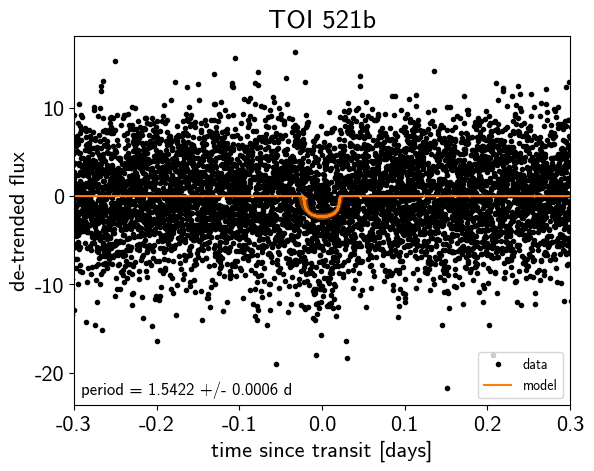

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

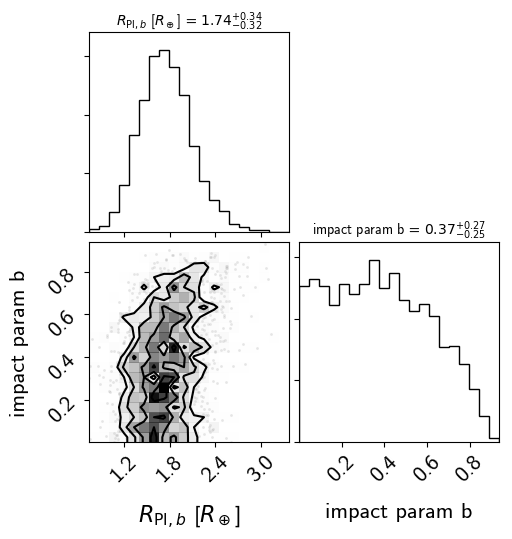

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

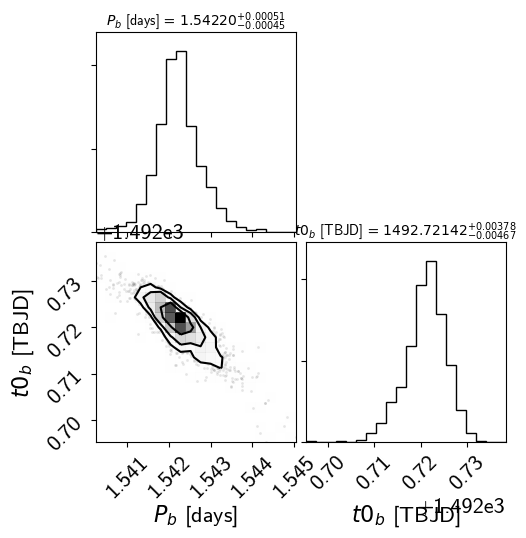

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

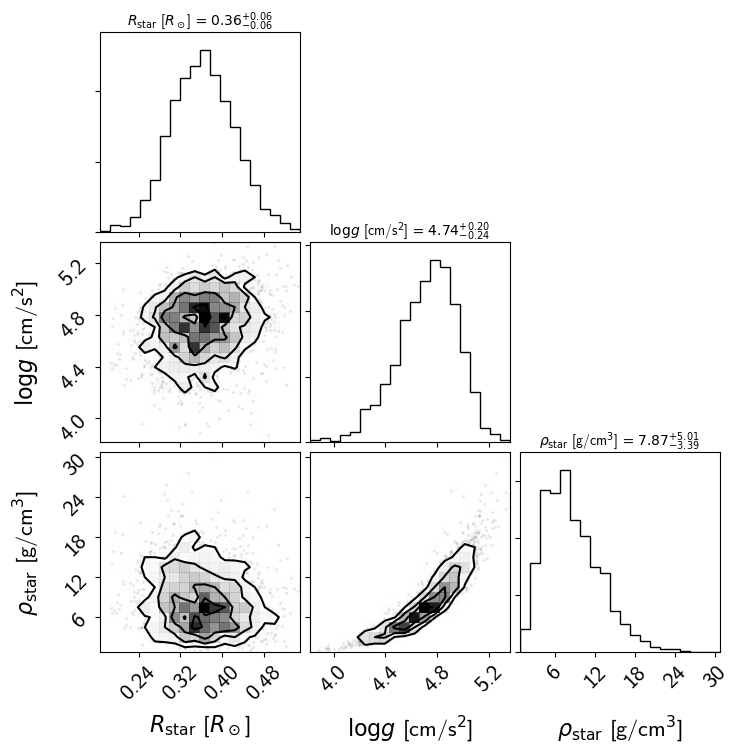

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3